This part of the code inizializes functions for the Ising 1d model: 

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import random
import matplotlib.pyplot as plt
import csv

def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N))-1
    return state


def mcmove(config, beta, J, h):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
                a = np.random.randint(0, N)
                s =  config[a]
                nb = config[(a+1)%N] + config[(a-1)%N] 
                cost = 2*s* (J*nb + h)   
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a] = s
    return config


def calcEnergy(config,J,h):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
            S = config[i]
            nb = config[(i+1)%N] + config[(i-1)%N] 
            energy += -J*nb*S -h*S
    return energy/2. 


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag


nt      = 1         #  number of temperature points
N       = 200         #  size of the lattice, N 
eqSteps = 1024       #  number of MC sweeps for equilibration
mcSteps = 5000       #  number of MC sweeps for calculation

J       = 1.0
h       = 1.0
T       = np.linspace(3.28, 3.29, nt); #1.53
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

 Run the following cell only if you want to produce cnfgs and store them into a folder. If you already have the cnfg, skip this part.  

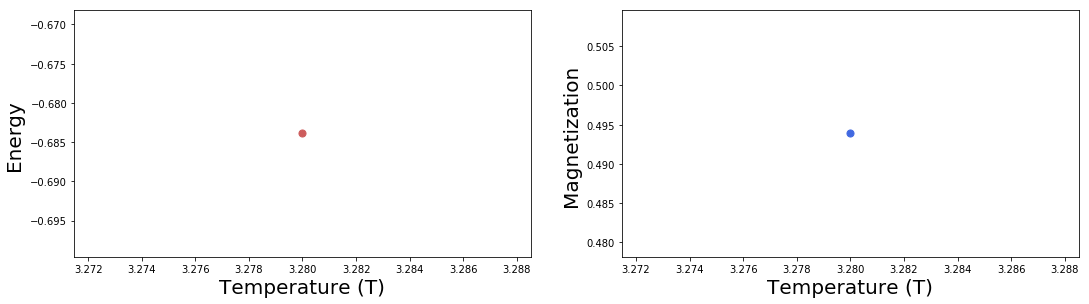

In [2]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstate(N)
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):             # equilibrate
        mcmove(config, iT,J,h)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT,J,h)           
        Ene = calcEnergy(config,J,h)     # calculate the energy
        Mag = calcMag(config)            # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        #M2 = M2 + Mag*Mag 
        #E2 = E2 + Ene*Ene
        
        parameters = [Ene/N, Mag/N, T[tt]]
        np.savetxt("./cnfg_1d/cnfg_1d_T" + str(T[tt]) + "_" + str(i) + ".csv", config.astype(int),fmt='%i',delimiter=",") 
        with open("./cnfg_1d/cnfg_1d_T" + str(T[tt]) + "_" + str(i) + ".csv", 'a') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(parameters)
        csvFile.close()
        
    E[tt] = n1*E1
    M[tt] = n1*M1
    #C[tt] = (n1*E2 - n2*E1*E1)*iT2
    #X[tt] = (n1*M2 - n2*M1*M1)*iT
    
    
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

#sp =  f.add_subplot(2, 2, 3 );
#plt.scatter(T, C, s=50, marker='o', color='IndianRed')
#plt.xlabel("Temperature (T)", fontsize=20);  
#plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

#sp =  f.add_subplot(2, 2, 4 );
#plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
#plt.xlabel("Temperature (T)", fontsize=20); 
#plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');    

Now read from saved cnfg

In [3]:
cnfg_in=np.zeros((nt,mcSteps,N))
params_in=np.zeros((nt,mcSteps,3))        
for tt in range(nt):
    for i in range(mcSteps):
        cnfg_in[tt,i,:] = np.genfromtxt("./cnfg_1d/cnfg_1d_T" + str(T[tt]) + "_" + str(i) + ".csv", dtype=float, delimiter='\t', skip_footer=1) 
        params_in[tt,i,:] = np.genfromtxt("./cnfg_1d/cnfg_1d_T" + str(T[tt]) + "_" + str(i) + ".csv", dtype=float, delimiter=',', skip_header=N) 

Now Keras/TensorFlow. The idea is to use a RNN with LSTM cells to "learn" how a certain cnfg of 1d ising is ordered.
Notice that this is conceptually wrong, since the spin chain is NOT a time series... however let us see what happens if we try to generate new sequences which correspond to a label $[T_i,M_i,E_i]$ where $T$ is the temperature, $M$ the magnetization and $E$ the energy of a given cnfg $i$.

In [13]:
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Bidirectional
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.backend import one_hot
from sklearn.model_selection import train_test_split
from time import time

X = to_categorical(0.5*(cnfg_in[0,:,:]+1))   #if not one-hot encoder does not work with [1,-1]
shift=1        #Wonder what happens if I put 0... I should discover Identity transformation...
perc=0.0                                     #I do validation split directly into keras model...

Y = np.roll(X,shift, axis=0)  #forward shift: X(t)=Y(t-shift)  One might want to do a backward shift as well ...
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=perc, random_state=1)
Y_train = np.swapaxes(Y_train, 0, 1)  # this is weird ... But I follow Sacred Mr. Ng 
Y_test = np.swapaxes(Y_test, 0, 1)   # this is weird ... But I follow Sacred Mr. Ng

Define Keras model: $T_x$ is the total length N of our cnfg, $n_a$ is the number of activations, $n_{\rm values}$=2 since is a $\mathbf{Z}_2$ symmetry model. 

In [5]:
n_states=X.shape[2]  # possible spin projections. Ready for Potts model.
n_a=100              # number of activation units at each time t 

reshapor = Reshape((1, n_states))                
LSTM_cell = LSTM(n_a, return_state = True, activation='tanh')   #testing linear activation --> require clipping 
densor = Dense(n_states, activation='softmax')   

In [6]:
def Ising1d_model(Tx, n_a, n_values):
    """
    Implement the model
    
    Arguments:
    Tx -- length of the sequence in a corpus
    n_a -- the number of activations used in our model
    n_values -- number of unique values ? 
    
    Returns:
    model -- a keras model with the 
    """
    
    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0

    # Step 1: Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    
    # Step 2: Loop
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = Lambda(lambda x: X[:,t,:])(X)
        # Step 2.B: Use reshapor to reshape x to be (1, n_values) (≈1 line)
        x = reshapor(x)
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return model

In [7]:
model = Ising1d_model(N, n_a, n_states)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

m =  int(mcSteps*(1.0-perc))
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [8]:
history = model.fit([X_train, a0, c0], list(Y_train), epochs=50, verbose=1, validation_split=0.1)#, callbacks=[tbCallBack])

Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 220s 49ms/step - loss: 103.8817 - dense_1_loss: 0.5317 - dense_1_acc: 0.7327 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7487 - dense_1_acc_3: 0.7416 - dense_1_acc_4: 0.7273 - dense_1_acc_5: 0.7476 - dense_1_acc_6: 0.7516 - dense_1_acc_7: 0.7522 - dense_1_acc_8: 0.7438 - dense_1_acc_9: 0.7593 - dense_1_acc_10: 0.7373 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7376 - dense_1_acc_13: 0.7407 - dense_1_acc_14: 0.7458 - dense_1_acc_15: 0.7702 - dense_1_acc_16: 0.7520 - dense_1_acc_17: 0.7387 - dense_1_acc_18: 0.7387 - dense_1_acc_19: 0.7487 - dense_1_acc_20: 0.7480 - dense_1_acc_21: 0.7618 - dense_1_acc_22: 0.7538 - dense_1_acc_23: 0.7396 - dense_1_acc_24: 0.7413 - dense_1_acc_25: 0.7356 - dense_1_acc_26: 0.7329 - dense_1_acc_27: 0.7464 - dense_1_acc_28: 0.7600 - dense_1_acc_29: 0.7464 - dense_1_acc_30: 0.7449 - dense_1_acc_31: 0.7402 - dense_1_acc_32: 0.7613 - dense_1_acc_33: 0.7411 - de

Epoch 2/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2693 - dense_1_loss: 0.5248 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - d

Epoch 3/50
4500/4500 [==============================] - 26s 6ms/step - loss: 102.2468 - dense_1_loss: 0.5246 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - d

Epoch 4/50
4500/4500 [==============================] - 25s 5ms/step - loss: 102.2409 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - d

Epoch 5/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2422 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - d

Epoch 6/50


 480/4500 [==>...........................] - ETA: 22s - loss: 102.3367 - dense_1_loss: 0.4898 - dense_1_acc: 0.7417 - dense_1_acc_1: 0.7375 - dense_1_acc_2: 0.7583 - dense_1_acc_3: 0.7396 - dense_1_acc_4: 0.7167 - dense_1_acc_5: 0.7521 - dense_1_acc_6: 0.7708 - dense_1_acc_7: 0.7729 - dense_1_acc_8: 0.7646 - dense_1_acc_9: 0.7250 - dense_1_acc_10: 0.7583 - dense_1_acc_11: 0.7417 - dense_1_acc_12: 0.7375 - dense_1_acc_13: 0.7667 - dense_1_acc_14: 0.7896 - dense_1_acc_15: 0.8083 - dense_1_acc_16: 0.7375 - dense_1_acc_17: 0.7521 - dense_1_acc_18: 0.7333 - dense_1_acc_19: 0.7458 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7771 - dense_1_acc_22: 0.7458 - dense_1_acc_23: 0.7354 - dense_1_acc_24: 0.7292 - dense_1_acc_25: 0.7417 - dense_1_acc_26: 0.7562 - dense_1_acc_27: 0.7396 - dense_1_acc_28: 0.7354 - dense_1_acc_29: 0.7312 - dense_1_acc_30: 0.7458 - dense_1_acc_31: 0.7646 - dense_1_acc_32: 0.7396 - dense_1_acc_33: 0.7146 - dense_1_acc_34: 0.7479 - dense_1_acc_35: 0.7396 - dense_1_acc_36: 

 512/4500 [==>...........................] - ETA: 22s - loss: 102.4400 - dense_1_loss: 0.4856 - dense_1_acc: 0.7383 - dense_1_acc_1: 0.7324 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7422 - dense_1_acc_4: 0.7148 - dense_1_acc_5: 0.7441 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7695 - dense_1_acc_8: 0.7559 - dense_1_acc_9: 0.7285 - dense_1_acc_10: 0.7559 - dense_1_acc_11: 0.7383 - dense_1_acc_12: 0.7383 - dense_1_acc_13: 0.7695 - dense_1_acc_14: 0.7793 - dense_1_acc_15: 0.8125 - dense_1_acc_16: 0.7461 - dense_1_acc_17: 0.7500 - dense_1_acc_18: 0.7227 - dense_1_acc_19: 0.7363 - dense_1_acc_20: 0.7520 - dense_1_acc_21: 0.7754 - dense_1_acc_22: 0.7422 - dense_1_acc_23: 0.7324 - dense_1_acc_24: 0.7363 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7598 - dense_1_acc_27: 0.7480 - dense_1_acc_28: 0.7305 - dense_1_acc_29: 0.7285 - dense_1_acc_30: 0.7461 - dense_1_acc_31: 0.7598 - dense_1_acc_32: 0.7422 - dense_1_acc_33: 0.7168 - dense_1_acc_34: 0.7520 - dense_1_acc_35: 0.7520 - dense_1_acc_36: 

 544/4500 [==>...........................] - ETA: 22s - loss: 102.4096 - dense_1_loss: 0.4943 - dense_1_acc: 0.7335 - dense_1_acc_1: 0.7224 - dense_1_acc_2: 0.7537 - dense_1_acc_3: 0.7445 - dense_1_acc_4: 0.7151 - dense_1_acc_5: 0.7408 - dense_1_acc_6: 0.7518 - dense_1_acc_7: 0.7665 - dense_1_acc_8: 0.7463 - dense_1_acc_9: 0.7224 - dense_1_acc_10: 0.7592 - dense_1_acc_11: 0.7445 - dense_1_acc_12: 0.7371 - dense_1_acc_13: 0.7665 - dense_1_acc_14: 0.7757 - dense_1_acc_15: 0.8125 - dense_1_acc_16: 0.7445 - dense_1_acc_17: 0.7408 - dense_1_acc_18: 0.7188 - dense_1_acc_19: 0.7279 - dense_1_acc_20: 0.7426 - dense_1_acc_21: 0.7739 - dense_1_acc_22: 0.7463 - dense_1_acc_23: 0.7353 - dense_1_acc_24: 0.7390 - dense_1_acc_25: 0.7390 - dense_1_acc_26: 0.7610 - dense_1_acc_27: 0.7463 - dense_1_acc_28: 0.7371 - dense_1_acc_29: 0.7243 - dense_1_acc_30: 0.7463 - dense_1_acc_31: 0.7555 - dense_1_acc_32: 0.7335 - dense_1_acc_33: 0.7169 - dense_1_acc_34: 0.7518 - dense_1_acc_35: 0.7500 - dense_1_acc_36: 

 576/4500 [==>...........................] - ETA: 21s - loss: 102.2633 - dense_1_loss: 0.4978 - dense_1_acc: 0.7292 - dense_1_acc_1: 0.7240 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7413 - dense_1_acc_4: 0.7135 - dense_1_acc_5: 0.7413 - dense_1_acc_6: 0.7500 - dense_1_acc_7: 0.7708 - dense_1_acc_8: 0.7483 - dense_1_acc_9: 0.7240 - dense_1_acc_10: 0.7587 - dense_1_acc_11: 0.7465 - dense_1_acc_12: 0.7483 - dense_1_acc_13: 0.7691 - dense_1_acc_14: 0.7778 - dense_1_acc_15: 0.8090 - dense_1_acc_16: 0.7396 - dense_1_acc_17: 0.7448 - dense_1_acc_18: 0.7240 - dense_1_acc_19: 0.7292 - dense_1_acc_20: 0.7483 - dense_1_acc_21: 0.7726 - dense_1_acc_22: 0.7465 - dense_1_acc_23: 0.7378 - dense_1_acc_24: 0.7344 - dense_1_acc_25: 0.7413 - dense_1_acc_26: 0.7587 - dense_1_acc_27: 0.7517 - dense_1_acc_28: 0.7431 - dense_1_acc_29: 0.7292 - dense_1_acc_30: 0.7465 - dense_1_acc_31: 0.7535 - dense_1_acc_32: 0.7396 - dense_1_acc_33: 0.7274 - dense_1_acc_34: 0.7517 - dense_1_acc_35: 0.7587 - dense_1_acc_36: 

 608/4500 [===>..........................] - ETA: 21s - loss: 102.1283 - dense_1_loss: 0.5012 - dense_1_acc: 0.7286 - dense_1_acc_1: 0.7237 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7401 - dense_1_acc_4: 0.7056 - dense_1_acc_5: 0.7434 - dense_1_acc_6: 0.7533 - dense_1_acc_7: 0.7730 - dense_1_acc_8: 0.7533 - dense_1_acc_9: 0.7303 - dense_1_acc_10: 0.7533 - dense_1_acc_11: 0.7401 - dense_1_acc_12: 0.7467 - dense_1_acc_13: 0.7681 - dense_1_acc_14: 0.7747 - dense_1_acc_15: 0.8026 - dense_1_acc_16: 0.7401 - dense_1_acc_17: 0.7484 - dense_1_acc_18: 0.7237 - dense_1_acc_19: 0.7368 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7747 - dense_1_acc_22: 0.7451 - dense_1_acc_23: 0.7401 - dense_1_acc_24: 0.7368 - dense_1_acc_25: 0.7368 - dense_1_acc_26: 0.7516 - dense_1_acc_27: 0.7484 - dense_1_acc_28: 0.7434 - dense_1_acc_29: 0.7303 - dense_1_acc_30: 0.7516 - dense_1_acc_31: 0.7582 - dense_1_acc_32: 0.7434 - dense_1_acc_33: 0.7303 - dense_1_acc_34: 0.7566 - dense_1_acc_35: 0.7632 - dense_1_acc_36: 

 640/4500 [===>..........................] - ETA: 21s - loss: 102.1856 - dense_1_loss: 0.5064 - dense_1_acc: 0.7312 - dense_1_acc_1: 0.7234 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7406 - dense_1_acc_4: 0.7063 - dense_1_acc_5: 0.7453 - dense_1_acc_6: 0.7578 - dense_1_acc_7: 0.7781 - dense_1_acc_8: 0.7578 - dense_1_acc_9: 0.7312 - dense_1_acc_10: 0.7562 - dense_1_acc_11: 0.7438 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7688 - dense_1_acc_14: 0.7703 - dense_1_acc_15: 0.8000 - dense_1_acc_16: 0.7406 - dense_1_acc_17: 0.7500 - dense_1_acc_18: 0.7312 - dense_1_acc_19: 0.7406 - dense_1_acc_20: 0.7484 - dense_1_acc_21: 0.7719 - dense_1_acc_22: 0.7484 - dense_1_acc_23: 0.7391 - dense_1_acc_24: 0.7328 - dense_1_acc_25: 0.7375 - dense_1_acc_26: 0.7500 - dense_1_acc_27: 0.7516 - dense_1_acc_28: 0.7406 - dense_1_acc_29: 0.7297 - dense_1_acc_30: 0.7453 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7453 - dense_1_acc_33: 0.7328 - dense_1_acc_34: 0.7625 - dense_1_acc_35: 0.7625 - dense_1_acc_36: 

 672/4500 [===>..........................] - ETA: 21s - loss: 102.2812 - dense_1_loss: 0.5061 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7217 - dense_1_acc_2: 0.7530 - dense_1_acc_3: 0.7366 - dense_1_acc_4: 0.7068 - dense_1_acc_5: 0.7485 - dense_1_acc_6: 0.7589 - dense_1_acc_7: 0.7783 - dense_1_acc_8: 0.7530 - dense_1_acc_9: 0.7366 - dense_1_acc_10: 0.7589 - dense_1_acc_11: 0.7455 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7664 - dense_1_acc_14: 0.7634 - dense_1_acc_15: 0.8021 - dense_1_acc_16: 0.7426 - dense_1_acc_17: 0.7530 - dense_1_acc_18: 0.7336 - dense_1_acc_19: 0.7411 - dense_1_acc_20: 0.7455 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7470 - dense_1_acc_23: 0.7440 - dense_1_acc_24: 0.7411 - dense_1_acc_25: 0.7426 - dense_1_acc_26: 0.7500 - dense_1_acc_27: 0.7560 - dense_1_acc_28: 0.7366 - dense_1_acc_29: 0.7262 - dense_1_acc_30: 0.7455 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7500 - dense_1_acc_33: 0.7351 - dense_1_acc_34: 0.7649 - dense_1_acc_35: 0.7649 - dense_1_acc_36: 

 704/4500 [===>..........................] - ETA: 21s - loss: 102.2610 - dense_1_loss: 0.5070 - dense_1_acc: 0.7386 - dense_1_acc_1: 0.7273 - dense_1_acc_2: 0.7571 - dense_1_acc_3: 0.7386 - dense_1_acc_4: 0.7102 - dense_1_acc_5: 0.7486 - dense_1_acc_6: 0.7614 - dense_1_acc_7: 0.7798 - dense_1_acc_8: 0.7543 - dense_1_acc_9: 0.7401 - dense_1_acc_10: 0.7599 - dense_1_acc_11: 0.7472 - dense_1_acc_12: 0.7415 - dense_1_acc_13: 0.7628 - dense_1_acc_14: 0.7642 - dense_1_acc_15: 0.7969 - dense_1_acc_16: 0.7358 - dense_1_acc_17: 0.7500 - dense_1_acc_18: 0.7315 - dense_1_acc_19: 0.7429 - dense_1_acc_20: 0.7443 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7401 - dense_1_acc_24: 0.7415 - dense_1_acc_25: 0.7429 - dense_1_acc_26: 0.7457 - dense_1_acc_27: 0.7599 - dense_1_acc_28: 0.7415 - dense_1_acc_29: 0.7301 - dense_1_acc_30: 0.7457 - dense_1_acc_31: 0.7415 - dense_1_acc_32: 0.7514 - dense_1_acc_33: 0.7330 - dense_1_acc_34: 0.7628 - dense_1_acc_35: 0.7571 - dense_1_acc_36: 

 736/4500 [===>..........................] - ETA: 21s - loss: 102.3217 - dense_1_loss: 0.5147 - dense_1_acc: 0.7391 - dense_1_acc_1: 0.7296 - dense_1_acc_2: 0.7568 - dense_1_acc_3: 0.7391 - dense_1_acc_4: 0.7120 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7622 - dense_1_acc_7: 0.7826 - dense_1_acc_8: 0.7554 - dense_1_acc_9: 0.7405 - dense_1_acc_10: 0.7582 - dense_1_acc_11: 0.7459 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7636 - dense_1_acc_14: 0.7663 - dense_1_acc_15: 0.7921 - dense_1_acc_16: 0.7351 - dense_1_acc_17: 0.7500 - dense_1_acc_18: 0.7323 - dense_1_acc_19: 0.7418 - dense_1_acc_20: 0.7486 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7514 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7418 - dense_1_acc_25: 0.7459 - dense_1_acc_26: 0.7432 - dense_1_acc_27: 0.7554 - dense_1_acc_28: 0.7391 - dense_1_acc_29: 0.7323 - dense_1_acc_30: 0.7514 - dense_1_acc_31: 0.7418 - dense_1_acc_32: 0.7568 - dense_1_acc_33: 0.7364 - dense_1_acc_34: 0.7649 - dense_1_acc_35: 0.7554 - dense_1_acc_36: 

 768/4500 [====>.........................] - ETA: 21s - loss: 102.3271 - dense_1_loss: 0.5212 - dense_1_acc: 0.7396 - dense_1_acc_1: 0.7331 - dense_1_acc_2: 0.7604 - dense_1_acc_3: 0.7461 - dense_1_acc_4: 0.7135 - dense_1_acc_5: 0.7487 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7786 - dense_1_acc_8: 0.7578 - dense_1_acc_9: 0.7396 - dense_1_acc_10: 0.7539 - dense_1_acc_11: 0.7409 - dense_1_acc_12: 0.7448 - dense_1_acc_13: 0.7617 - dense_1_acc_14: 0.7708 - dense_1_acc_15: 0.7891 - dense_1_acc_16: 0.7331 - dense_1_acc_17: 0.7513 - dense_1_acc_18: 0.7396 - dense_1_acc_19: 0.7448 - dense_1_acc_20: 0.7448 - dense_1_acc_21: 0.7604 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7448 - dense_1_acc_24: 0.7383 - dense_1_acc_25: 0.7435 - dense_1_acc_26: 0.7448 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7383 - dense_1_acc_29: 0.7331 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7383 - dense_1_acc_32: 0.7604 - dense_1_acc_33: 0.7370 - dense_1_acc_34: 0.7617 - dense_1_acc_35: 0.7552 - dense_1_acc_36: 

 800/4500 [====>.........................] - ETA: 20s - loss: 102.1937 - dense_1_loss: 0.5259 - dense_1_acc: 0.7388 - dense_1_acc_1: 0.7325 - dense_1_acc_2: 0.7562 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7137 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7625 - dense_1_acc_7: 0.7812 - dense_1_acc_8: 0.7550 - dense_1_acc_9: 0.7438 - dense_1_acc_10: 0.7525 - dense_1_acc_11: 0.7438 - dense_1_acc_12: 0.7462 - dense_1_acc_13: 0.7625 - dense_1_acc_14: 0.7712 - dense_1_acc_15: 0.7900 - dense_1_acc_16: 0.7375 - dense_1_acc_17: 0.7575 - dense_1_acc_18: 0.7362 - dense_1_acc_19: 0.7475 - dense_1_acc_20: 0.7462 - dense_1_acc_21: 0.7650 - dense_1_acc_22: 0.7525 - dense_1_acc_23: 0.7438 - dense_1_acc_24: 0.7400 - dense_1_acc_25: 0.7475 - dense_1_acc_26: 0.7475 - dense_1_acc_27: 0.7600 - dense_1_acc_28: 0.7450 - dense_1_acc_29: 0.7338 - dense_1_acc_30: 0.7538 - dense_1_acc_31: 0.7425 - dense_1_acc_32: 0.7575 - dense_1_acc_33: 0.7425 - dense_1_acc_34: 0.7662 - dense_1_acc_35: 0.7500 - dense_1_acc_36: 

 832/4500 [====>.........................] - ETA: 20s - loss: 102.2319 - dense_1_loss: 0.5239 - dense_1_acc: 0.7392 - dense_1_acc_1: 0.7356 - dense_1_acc_2: 0.7560 - dense_1_acc_3: 0.7464 - dense_1_acc_4: 0.7151 - dense_1_acc_5: 0.7476 - dense_1_acc_6: 0.7572 - dense_1_acc_7: 0.7752 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7452 - dense_1_acc_10: 0.7512 - dense_1_acc_11: 0.7404 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7620 - dense_1_acc_14: 0.7668 - dense_1_acc_15: 0.7945 - dense_1_acc_16: 0.7380 - dense_1_acc_17: 0.7572 - dense_1_acc_18: 0.7392 - dense_1_acc_19: 0.7488 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7548 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7392 - dense_1_acc_25: 0.7464 - dense_1_acc_26: 0.7512 - dense_1_acc_27: 0.7596 - dense_1_acc_28: 0.7416 - dense_1_acc_29: 0.7332 - dense_1_acc_30: 0.7560 - dense_1_acc_31: 0.7488 - dense_1_acc_32: 0.7596 - dense_1_acc_33: 0.7428 - dense_1_acc_34: 0.7704 - dense_1_acc_35: 0.7548 - dense_1_acc_36: 

 864/4500 [====>.........................] - ETA: 20s - loss: 102.2855 - dense_1_loss: 0.5219 - dense_1_acc: 0.7419 - dense_1_acc_1: 0.7396 - dense_1_acc_2: 0.7546 - dense_1_acc_3: 0.7431 - dense_1_acc_4: 0.7153 - dense_1_acc_5: 0.7477 - dense_1_acc_6: 0.7593 - dense_1_acc_7: 0.7743 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7396 - dense_1_acc_10: 0.7546 - dense_1_acc_11: 0.7431 - dense_1_acc_12: 0.7454 - dense_1_acc_13: 0.7616 - dense_1_acc_14: 0.7650 - dense_1_acc_15: 0.7928 - dense_1_acc_16: 0.7396 - dense_1_acc_17: 0.7604 - dense_1_acc_18: 0.7419 - dense_1_acc_19: 0.7488 - dense_1_acc_20: 0.7477 - dense_1_acc_21: 0.7616 - dense_1_acc_22: 0.7569 - dense_1_acc_23: 0.7454 - dense_1_acc_24: 0.7396 - dense_1_acc_25: 0.7442 - dense_1_acc_26: 0.7454 - dense_1_acc_27: 0.7604 - dense_1_acc_28: 0.7454 - dense_1_acc_29: 0.7350 - dense_1_acc_30: 0.7558 - dense_1_acc_31: 0.7442 - dense_1_acc_32: 0.7581 - dense_1_acc_33: 0.7454 - dense_1_acc_34: 0.7720 - dense_1_acc_35: 0.7535 - dense_1_acc_36: 

 896/4500 [====>.........................] - ETA: 20s - loss: 102.1880 - dense_1_loss: 0.5218 - dense_1_acc: 0.7444 - dense_1_acc_1: 0.7444 - dense_1_acc_2: 0.7556 - dense_1_acc_3: 0.7411 - dense_1_acc_4: 0.7143 - dense_1_acc_5: 0.7478 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7734 - dense_1_acc_8: 0.7455 - dense_1_acc_9: 0.7377 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7411 - dense_1_acc_12: 0.7455 - dense_1_acc_13: 0.7623 - dense_1_acc_14: 0.7578 - dense_1_acc_15: 0.7868 - dense_1_acc_16: 0.7377 - dense_1_acc_17: 0.7656 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7522 - dense_1_acc_21: 0.7645 - dense_1_acc_22: 0.7511 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7400 - dense_1_acc_25: 0.7467 - dense_1_acc_26: 0.7444 - dense_1_acc_27: 0.7600 - dense_1_acc_28: 0.7422 - dense_1_acc_29: 0.7333 - dense_1_acc_30: 0.7578 - dense_1_acc_31: 0.7433 - dense_1_acc_32: 0.7556 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7701 - dense_1_acc_35: 0.7545 - dense_1_acc_36: 

 928/4500 [=====>........................] - ETA: 19s - loss: 102.1685 - dense_1_loss: 0.5244 - dense_1_acc: 0.7446 - dense_1_acc_1: 0.7446 - dense_1_acc_2: 0.7554 - dense_1_acc_3: 0.7403 - dense_1_acc_4: 0.7155 - dense_1_acc_5: 0.7435 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7726 - dense_1_acc_8: 0.7457 - dense_1_acc_9: 0.7360 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7446 - dense_1_acc_12: 0.7478 - dense_1_acc_13: 0.7640 - dense_1_acc_14: 0.7565 - dense_1_acc_15: 0.7877 - dense_1_acc_16: 0.7392 - dense_1_acc_17: 0.7672 - dense_1_acc_18: 0.7457 - dense_1_acc_19: 0.7543 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7694 - dense_1_acc_22: 0.7478 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7381 - dense_1_acc_25: 0.7414 - dense_1_acc_26: 0.7403 - dense_1_acc_27: 0.7575 - dense_1_acc_28: 0.7457 - dense_1_acc_29: 0.7360 - dense_1_acc_30: 0.7586 - dense_1_acc_31: 0.7414 - dense_1_acc_32: 0.7575 - dense_1_acc_33: 0.7457 - dense_1_acc_34: 0.7662 - dense_1_acc_35: 0.7543 - dense_1_acc_36: 

 960/4500 [=====>........................] - ETA: 19s - loss: 102.1920 - dense_1_loss: 0.5230 - dense_1_acc: 0.7406 - dense_1_acc_1: 0.7417 - dense_1_acc_2: 0.7552 - dense_1_acc_3: 0.7427 - dense_1_acc_4: 0.7146 - dense_1_acc_5: 0.7438 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7729 - dense_1_acc_8: 0.7469 - dense_1_acc_9: 0.7396 - dense_1_acc_10: 0.7469 - dense_1_acc_11: 0.7417 - dense_1_acc_12: 0.7510 - dense_1_acc_13: 0.7615 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7844 - dense_1_acc_16: 0.7417 - dense_1_acc_17: 0.7656 - dense_1_acc_18: 0.7458 - dense_1_acc_19: 0.7542 - dense_1_acc_20: 0.7562 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7490 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7375 - dense_1_acc_25: 0.7406 - dense_1_acc_26: 0.7448 - dense_1_acc_27: 0.7531 - dense_1_acc_28: 0.7469 - dense_1_acc_29: 0.7354 - dense_1_acc_30: 0.7594 - dense_1_acc_31: 0.7448 - dense_1_acc_32: 0.7604 - dense_1_acc_33: 0.7458 - dense_1_acc_34: 0.7677 - dense_1_acc_35: 0.7531 - dense_1_acc_36: 

 992/4500 [=====>........................] - ETA: 19s - loss: 102.1298 - dense_1_loss: 0.5245 - dense_1_acc: 0.7399 - dense_1_acc_1: 0.7429 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7450 - dense_1_acc_4: 0.7188 - dense_1_acc_5: 0.7460 - dense_1_acc_6: 0.7601 - dense_1_acc_7: 0.7692 - dense_1_acc_8: 0.7399 - dense_1_acc_9: 0.7399 - dense_1_acc_10: 0.7490 - dense_1_acc_11: 0.7409 - dense_1_acc_12: 0.7510 - dense_1_acc_13: 0.7651 - dense_1_acc_14: 0.7571 - dense_1_acc_15: 0.7873 - dense_1_acc_16: 0.7460 - dense_1_acc_17: 0.7651 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7591 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7369 - dense_1_acc_25: 0.7440 - dense_1_acc_26: 0.7419 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7490 - dense_1_acc_29: 0.7379 - dense_1_acc_30: 0.7641 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7460 - dense_1_acc_34: 0.7671 - dense_1_acc_35: 0.7571 - dense_1_acc_36: 

1024/4500 [=====>........................] - ETA: 19s - loss: 102.2129 - dense_1_loss: 0.5244 - dense_1_acc: 0.7383 - dense_1_acc_1: 0.7461 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7451 - dense_1_acc_4: 0.7217 - dense_1_acc_5: 0.7441 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7656 - dense_1_acc_8: 0.7432 - dense_1_acc_9: 0.7383 - dense_1_acc_10: 0.7510 - dense_1_acc_11: 0.7412 - dense_1_acc_12: 0.7510 - dense_1_acc_13: 0.7617 - dense_1_acc_14: 0.7539 - dense_1_acc_15: 0.7842 - dense_1_acc_16: 0.7461 - dense_1_acc_17: 0.7656 - dense_1_acc_18: 0.7402 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7588 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7529 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7393 - dense_1_acc_25: 0.7471 - dense_1_acc_26: 0.7480 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7510 - dense_1_acc_29: 0.7363 - dense_1_acc_30: 0.7627 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7607 - dense_1_acc_33: 0.7471 - dense_1_acc_34: 0.7695 - dense_1_acc_35: 0.7588 - dense_1_acc_36: 

1056/4500 [======>.......................] - ETA: 19s - loss: 102.1929 - dense_1_loss: 0.5236 - dense_1_acc: 0.7377 - dense_1_acc_1: 0.7434 - dense_1_acc_2: 0.7491 - dense_1_acc_3: 0.7434 - dense_1_acc_4: 0.7235 - dense_1_acc_5: 0.7481 - dense_1_acc_6: 0.7614 - dense_1_acc_7: 0.7661 - dense_1_acc_8: 0.7434 - dense_1_acc_9: 0.7405 - dense_1_acc_10: 0.7528 - dense_1_acc_11: 0.7405 - dense_1_acc_12: 0.7453 - dense_1_acc_13: 0.7623 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7822 - dense_1_acc_16: 0.7481 - dense_1_acc_17: 0.7633 - dense_1_acc_18: 0.7405 - dense_1_acc_19: 0.7547 - dense_1_acc_20: 0.7614 - dense_1_acc_21: 0.7699 - dense_1_acc_22: 0.7491 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7330 - dense_1_acc_25: 0.7434 - dense_1_acc_26: 0.7509 - dense_1_acc_27: 0.7528 - dense_1_acc_28: 0.7547 - dense_1_acc_29: 0.7358 - dense_1_acc_30: 0.7652 - dense_1_acc_31: 0.7519 - dense_1_acc_32: 0.7633 - dense_1_acc_33: 0.7472 - dense_1_acc_34: 0.7670 - dense_1_acc_35: 0.7557 - dense_1_acc_36: 

1088/4500 [======>.......................] - ETA: 18s - loss: 102.2115 - dense_1_loss: 0.5198 - dense_1_acc: 0.7399 - dense_1_acc_1: 0.7436 - dense_1_acc_2: 0.7472 - dense_1_acc_3: 0.7445 - dense_1_acc_4: 0.7233 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7647 - dense_1_acc_8: 0.7454 - dense_1_acc_9: 0.7381 - dense_1_acc_10: 0.7482 - dense_1_acc_11: 0.7390 - dense_1_acc_12: 0.7463 - dense_1_acc_13: 0.7638 - dense_1_acc_14: 0.7518 - dense_1_acc_15: 0.7794 - dense_1_acc_16: 0.7482 - dense_1_acc_17: 0.7629 - dense_1_acc_18: 0.7408 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7610 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7454 - dense_1_acc_23: 0.7445 - dense_1_acc_24: 0.7307 - dense_1_acc_25: 0.7390 - dense_1_acc_26: 0.7518 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7537 - dense_1_acc_29: 0.7335 - dense_1_acc_30: 0.7675 - dense_1_acc_31: 0.7546 - dense_1_acc_32: 0.7665 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7665 - dense_1_acc_35: 0.7592 - dense_1_acc_36: 

1120/4500 [======>.......................] - ETA: 18s - loss: 102.2073 - dense_1_loss: 0.5242 - dense_1_acc: 0.7384 - dense_1_acc_1: 0.7446 - dense_1_acc_2: 0.7473 - dense_1_acc_3: 0.7446 - dense_1_acc_4: 0.7223 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7598 - dense_1_acc_7: 0.7670 - dense_1_acc_8: 0.7473 - dense_1_acc_9: 0.7366 - dense_1_acc_10: 0.7473 - dense_1_acc_11: 0.7393 - dense_1_acc_12: 0.7473 - dense_1_acc_13: 0.7643 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7795 - dense_1_acc_16: 0.7509 - dense_1_acc_17: 0.7616 - dense_1_acc_18: 0.7366 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7598 - dense_1_acc_21: 0.7741 - dense_1_acc_22: 0.7482 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7286 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7509 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7562 - dense_1_acc_29: 0.7330 - dense_1_acc_30: 0.7643 - dense_1_acc_31: 0.7545 - dense_1_acc_32: 0.7670 - dense_1_acc_33: 0.7446 - dense_1_acc_34: 0.7652 - dense_1_acc_35: 0.7562 - dense_1_acc_36: 

1152/4500 [======>.......................] - ETA: 18s - loss: 102.2237 - dense_1_loss: 0.5280 - dense_1_acc: 0.7413 - dense_1_acc_1: 0.7448 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7465 - dense_1_acc_4: 0.7248 - dense_1_acc_5: 0.7517 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7665 - dense_1_acc_8: 0.7448 - dense_1_acc_9: 0.7387 - dense_1_acc_10: 0.7474 - dense_1_acc_11: 0.7378 - dense_1_acc_12: 0.7457 - dense_1_acc_13: 0.7604 - dense_1_acc_14: 0.7465 - dense_1_acc_15: 0.7778 - dense_1_acc_16: 0.7526 - dense_1_acc_17: 0.7604 - dense_1_acc_18: 0.7361 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7622 - dense_1_acc_21: 0.7752 - dense_1_acc_22: 0.7474 - dense_1_acc_23: 0.7431 - dense_1_acc_24: 0.7283 - dense_1_acc_25: 0.7405 - dense_1_acc_26: 0.7526 - dense_1_acc_27: 0.7491 - dense_1_acc_28: 0.7569 - dense_1_acc_29: 0.7300 - dense_1_acc_30: 0.7630 - dense_1_acc_31: 0.7526 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7422 - dense_1_acc_34: 0.7648 - dense_1_acc_35: 0.7543 - dense_1_acc_36: 

1184/4500 [======>.......................] - ETA: 18s - loss: 102.1918 - dense_1_loss: 0.5283 - dense_1_acc: 0.7399 - dense_1_acc_1: 0.7458 - dense_1_acc_2: 0.7475 - dense_1_acc_3: 0.7424 - dense_1_acc_4: 0.7264 - dense_1_acc_5: 0.7517 - dense_1_acc_6: 0.7635 - dense_1_acc_7: 0.7703 - dense_1_acc_8: 0.7407 - dense_1_acc_9: 0.7399 - dense_1_acc_10: 0.7492 - dense_1_acc_11: 0.7382 - dense_1_acc_12: 0.7466 - dense_1_acc_13: 0.7618 - dense_1_acc_14: 0.7475 - dense_1_acc_15: 0.7779 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7610 - dense_1_acc_18: 0.7365 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7627 - dense_1_acc_21: 0.7745 - dense_1_acc_22: 0.7492 - dense_1_acc_23: 0.7432 - dense_1_acc_24: 0.7280 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7525 - dense_1_acc_27: 0.7525 - dense_1_acc_28: 0.7534 - dense_1_acc_29: 0.7314 - dense_1_acc_30: 0.7627 - dense_1_acc_31: 0.7517 - dense_1_acc_32: 0.7703 - dense_1_acc_33: 0.7416 - dense_1_acc_34: 0.7660 - dense_1_acc_35: 0.7559 - dense_1_acc_36: 

1216/4500 [=======>......................] - ETA: 18s - loss: 102.1555 - dense_1_loss: 0.5284 - dense_1_acc: 0.7410 - dense_1_acc_1: 0.7451 - dense_1_acc_2: 0.7451 - dense_1_acc_3: 0.7393 - dense_1_acc_4: 0.7262 - dense_1_acc_5: 0.7516 - dense_1_acc_6: 0.7599 - dense_1_acc_7: 0.7689 - dense_1_acc_8: 0.7410 - dense_1_acc_9: 0.7377 - dense_1_acc_10: 0.7467 - dense_1_acc_11: 0.7360 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7607 - dense_1_acc_14: 0.7484 - dense_1_acc_15: 0.7804 - dense_1_acc_16: 0.7541 - dense_1_acc_17: 0.7623 - dense_1_acc_18: 0.7385 - dense_1_acc_19: 0.7566 - dense_1_acc_20: 0.7632 - dense_1_acc_21: 0.7755 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7401 - dense_1_acc_24: 0.7278 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7541 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7525 - dense_1_acc_29: 0.7294 - dense_1_acc_30: 0.7623 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7722 - dense_1_acc_33: 0.7459 - dense_1_acc_34: 0.7656 - dense_1_acc_35: 0.7582 - dense_1_acc_36: 

1248/4500 [=======>......................] - ETA: 17s - loss: 102.1765 - dense_1_loss: 0.5258 - dense_1_acc: 0.7428 - dense_1_acc_1: 0.7444 - dense_1_acc_2: 0.7484 - dense_1_acc_3: 0.7428 - dense_1_acc_4: 0.7236 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7684 - dense_1_acc_8: 0.7420 - dense_1_acc_9: 0.7380 - dense_1_acc_10: 0.7476 - dense_1_acc_11: 0.7356 - dense_1_acc_12: 0.7468 - dense_1_acc_13: 0.7612 - dense_1_acc_14: 0.7460 - dense_1_acc_15: 0.7804 - dense_1_acc_16: 0.7556 - dense_1_acc_17: 0.7636 - dense_1_acc_18: 0.7364 - dense_1_acc_19: 0.7556 - dense_1_acc_20: 0.7628 - dense_1_acc_21: 0.7724 - dense_1_acc_22: 0.7460 - dense_1_acc_23: 0.7404 - dense_1_acc_24: 0.7292 - dense_1_acc_25: 0.7388 - dense_1_acc_26: 0.7508 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7524 - dense_1_acc_29: 0.7332 - dense_1_acc_30: 0.7620 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7716 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7636 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 

1280/4500 [=======>......................] - ETA: 17s - loss: 102.1139 - dense_1_loss: 0.5253 - dense_1_acc: 0.7422 - dense_1_acc_1: 0.7445 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7234 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7594 - dense_1_acc_7: 0.7664 - dense_1_acc_8: 0.7414 - dense_1_acc_9: 0.7406 - dense_1_acc_10: 0.7461 - dense_1_acc_11: 0.7391 - dense_1_acc_12: 0.7469 - dense_1_acc_13: 0.7617 - dense_1_acc_14: 0.7492 - dense_1_acc_15: 0.7789 - dense_1_acc_16: 0.7570 - dense_1_acc_17: 0.7648 - dense_1_acc_18: 0.7359 - dense_1_acc_19: 0.7562 - dense_1_acc_20: 0.7609 - dense_1_acc_21: 0.7727 - dense_1_acc_22: 0.7445 - dense_1_acc_23: 0.7422 - dense_1_acc_24: 0.7258 - dense_1_acc_25: 0.7391 - dense_1_acc_26: 0.7531 - dense_1_acc_27: 0.7477 - dense_1_acc_28: 0.7531 - dense_1_acc_29: 0.7344 - dense_1_acc_30: 0.7617 - dense_1_acc_31: 0.7508 - dense_1_acc_32: 0.7719 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7641 - dense_1_acc_35: 0.7609 - dense_1_acc_36: 

1312/4500 [=======>......................] - ETA: 17s - loss: 102.1074 - dense_1_loss: 0.5253 - dense_1_acc: 0.7424 - dense_1_acc_1: 0.7454 - dense_1_acc_2: 0.7530 - dense_1_acc_3: 0.7431 - dense_1_acc_4: 0.7226 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7614 - dense_1_acc_7: 0.7660 - dense_1_acc_8: 0.7416 - dense_1_acc_9: 0.7409 - dense_1_acc_10: 0.7447 - dense_1_acc_11: 0.7409 - dense_1_acc_12: 0.7485 - dense_1_acc_13: 0.7622 - dense_1_acc_14: 0.7492 - dense_1_acc_15: 0.7759 - dense_1_acc_16: 0.7523 - dense_1_acc_17: 0.7614 - dense_1_acc_18: 0.7355 - dense_1_acc_19: 0.7538 - dense_1_acc_20: 0.7607 - dense_1_acc_21: 0.7759 - dense_1_acc_22: 0.7470 - dense_1_acc_23: 0.7424 - dense_1_acc_24: 0.7248 - dense_1_acc_25: 0.7416 - dense_1_acc_26: 0.7553 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7546 - dense_1_acc_29: 0.7370 - dense_1_acc_30: 0.7637 - dense_1_acc_31: 0.7523 - dense_1_acc_32: 0.7721 - dense_1_acc_33: 0.7485 - dense_1_acc_34: 0.7630 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 

1344/4500 [=======>......................] - ETA: 17s - loss: 102.0961 - dense_1_loss: 0.5230 - dense_1_acc: 0.7411 - dense_1_acc_1: 0.7448 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7411 - dense_1_acc_4: 0.7232 - dense_1_acc_5: 0.7478 - dense_1_acc_6: 0.7612 - dense_1_acc_7: 0.7664 - dense_1_acc_8: 0.7418 - dense_1_acc_9: 0.7359 - dense_1_acc_10: 0.7440 - dense_1_acc_11: 0.7403 - dense_1_acc_12: 0.7485 - dense_1_acc_13: 0.7641 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7515 - dense_1_acc_17: 0.7597 - dense_1_acc_18: 0.7359 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7626 - dense_1_acc_21: 0.7768 - dense_1_acc_22: 0.7478 - dense_1_acc_23: 0.7411 - dense_1_acc_24: 0.7225 - dense_1_acc_25: 0.7433 - dense_1_acc_26: 0.7545 - dense_1_acc_27: 0.7455 - dense_1_acc_28: 0.7560 - dense_1_acc_29: 0.7359 - dense_1_acc_30: 0.7634 - dense_1_acc_31: 0.7537 - dense_1_acc_32: 0.7716 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7641 - dense_1_acc_35: 0.7634 - dense_1_acc_36: 

1376/4500 [========>.....................] - ETA: 17s - loss: 102.0791 - dense_1_loss: 0.5254 - dense_1_acc: 0.7391 - dense_1_acc_1: 0.7442 - dense_1_acc_2: 0.7544 - dense_1_acc_3: 0.7406 - dense_1_acc_4: 0.7238 - dense_1_acc_5: 0.7471 - dense_1_acc_6: 0.7624 - dense_1_acc_7: 0.7653 - dense_1_acc_8: 0.7427 - dense_1_acc_9: 0.7376 - dense_1_acc_10: 0.7449 - dense_1_acc_11: 0.7420 - dense_1_acc_12: 0.7485 - dense_1_acc_13: 0.7638 - dense_1_acc_14: 0.7515 - dense_1_acc_15: 0.7725 - dense_1_acc_16: 0.7485 - dense_1_acc_17: 0.7602 - dense_1_acc_18: 0.7355 - dense_1_acc_19: 0.7558 - dense_1_acc_20: 0.7631 - dense_1_acc_21: 0.7740 - dense_1_acc_22: 0.7449 - dense_1_acc_23: 0.7420 - dense_1_acc_24: 0.7217 - dense_1_acc_25: 0.7427 - dense_1_acc_26: 0.7536 - dense_1_acc_27: 0.7456 - dense_1_acc_28: 0.7544 - dense_1_acc_29: 0.7347 - dense_1_acc_30: 0.7616 - dense_1_acc_31: 0.7515 - dense_1_acc_32: 0.7703 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7624 - dense_1_acc_35: 0.7631 - dense_1_acc_36: 

1408/4500 [========>.....................] - ETA: 16s - loss: 102.0924 - dense_1_loss: 0.5245 - dense_1_acc: 0.7393 - dense_1_acc_1: 0.7422 - dense_1_acc_2: 0.7536 - dense_1_acc_3: 0.7408 - dense_1_acc_4: 0.7266 - dense_1_acc_5: 0.7479 - dense_1_acc_6: 0.7607 - dense_1_acc_7: 0.7663 - dense_1_acc_8: 0.7422 - dense_1_acc_9: 0.7408 - dense_1_acc_10: 0.7464 - dense_1_acc_11: 0.7408 - dense_1_acc_12: 0.7486 - dense_1_acc_13: 0.7635 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7472 - dense_1_acc_17: 0.7628 - dense_1_acc_18: 0.7372 - dense_1_acc_19: 0.7578 - dense_1_acc_20: 0.7621 - dense_1_acc_21: 0.7749 - dense_1_acc_22: 0.7457 - dense_1_acc_23: 0.7443 - dense_1_acc_24: 0.7216 - dense_1_acc_25: 0.7457 - dense_1_acc_26: 0.7536 - dense_1_acc_27: 0.7457 - dense_1_acc_28: 0.7536 - dense_1_acc_29: 0.7351 - dense_1_acc_30: 0.7578 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7692 - dense_1_acc_33: 0.7536 - dense_1_acc_34: 0.7649 - dense_1_acc_35: 0.7628 - dense_1_acc_36: 

1440/4500 [========>.....................] - ETA: 16s - loss: 102.0645 - dense_1_loss: 0.5249 - dense_1_acc: 0.7382 - dense_1_acc_1: 0.7424 - dense_1_acc_2: 0.7528 - dense_1_acc_3: 0.7382 - dense_1_acc_4: 0.7243 - dense_1_acc_5: 0.7493 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7667 - dense_1_acc_8: 0.7438 - dense_1_acc_9: 0.7417 - dense_1_acc_10: 0.7493 - dense_1_acc_11: 0.7396 - dense_1_acc_12: 0.7507 - dense_1_acc_13: 0.7583 - dense_1_acc_14: 0.7507 - dense_1_acc_15: 0.7736 - dense_1_acc_16: 0.7479 - dense_1_acc_17: 0.7618 - dense_1_acc_18: 0.7347 - dense_1_acc_19: 0.7583 - dense_1_acc_20: 0.7639 - dense_1_acc_21: 0.7736 - dense_1_acc_22: 0.7458 - dense_1_acc_23: 0.7465 - dense_1_acc_24: 0.7215 - dense_1_acc_25: 0.7451 - dense_1_acc_26: 0.7562 - dense_1_acc_27: 0.7493 - dense_1_acc_28: 0.7556 - dense_1_acc_29: 0.7368 - dense_1_acc_30: 0.7583 - dense_1_acc_31: 0.7444 - dense_1_acc_32: 0.7667 - dense_1_acc_33: 0.7542 - dense_1_acc_34: 0.7681 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 

1472/4500 [========>.....................] - ETA: 16s - loss: 102.0795 - dense_1_loss: 0.5285 - dense_1_acc: 0.7371 - dense_1_acc_1: 0.7412 - dense_1_acc_2: 0.7514 - dense_1_acc_3: 0.7378 - dense_1_acc_4: 0.7242 - dense_1_acc_5: 0.7534 - dense_1_acc_6: 0.7622 - dense_1_acc_7: 0.7677 - dense_1_acc_8: 0.7432 - dense_1_acc_9: 0.7432 - dense_1_acc_10: 0.7486 - dense_1_acc_11: 0.7412 - dense_1_acc_12: 0.7486 - dense_1_acc_13: 0.7554 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7724 - dense_1_acc_16: 0.7446 - dense_1_acc_17: 0.7615 - dense_1_acc_18: 0.7317 - dense_1_acc_19: 0.7575 - dense_1_acc_20: 0.7649 - dense_1_acc_21: 0.7717 - dense_1_acc_22: 0.7452 - dense_1_acc_23: 0.7466 - dense_1_acc_24: 0.7208 - dense_1_acc_25: 0.7452 - dense_1_acc_26: 0.7575 - dense_1_acc_27: 0.7514 - dense_1_acc_28: 0.7554 - dense_1_acc_29: 0.7357 - dense_1_acc_30: 0.7582 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7670 - dense_1_acc_33: 0.7548 - dense_1_acc_34: 0.7663 - dense_1_acc_35: 0.7643 - dense_1_acc_36: 

1504/4500 [=========>....................] - ETA: 16s - loss: 102.0540 - dense_1_loss: 0.5287 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7434 - dense_1_acc_2: 0.7507 - dense_1_acc_3: 0.7400 - dense_1_acc_4: 0.7247 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7606 - dense_1_acc_7: 0.7680 - dense_1_acc_8: 0.7434 - dense_1_acc_9: 0.7394 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7434 - dense_1_acc_12: 0.7487 - dense_1_acc_13: 0.7580 - dense_1_acc_14: 0.7513 - dense_1_acc_15: 0.7739 - dense_1_acc_16: 0.7427 - dense_1_acc_17: 0.7593 - dense_1_acc_18: 0.7320 - dense_1_acc_19: 0.7553 - dense_1_acc_20: 0.7653 - dense_1_acc_21: 0.7719 - dense_1_acc_22: 0.7467 - dense_1_acc_23: 0.7460 - dense_1_acc_24: 0.7221 - dense_1_acc_25: 0.7440 - dense_1_acc_26: 0.7566 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7553 - dense_1_acc_29: 0.7347 - dense_1_acc_30: 0.7586 - dense_1_acc_31: 0.7507 - dense_1_acc_32: 0.7673 - dense_1_acc_33: 0.7540 - dense_1_acc_34: 0.7660 - dense_1_acc_35: 0.7646 - dense_1_acc_36: 

1536/4500 [=========>....................] - ETA: 16s - loss: 102.0924 - dense_1_loss: 0.5260 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7441 - dense_1_acc_2: 0.7533 - dense_1_acc_3: 0.7428 - dense_1_acc_4: 0.7272 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7598 - dense_1_acc_7: 0.7663 - dense_1_acc_8: 0.7422 - dense_1_acc_9: 0.7370 - dense_1_acc_10: 0.7493 - dense_1_acc_11: 0.7448 - dense_1_acc_12: 0.7487 - dense_1_acc_13: 0.7578 - dense_1_acc_14: 0.7493 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7435 - dense_1_acc_17: 0.7578 - dense_1_acc_18: 0.7311 - dense_1_acc_19: 0.7546 - dense_1_acc_20: 0.7663 - dense_1_acc_21: 0.7728 - dense_1_acc_22: 0.7474 - dense_1_acc_23: 0.7448 - dense_1_acc_24: 0.7227 - dense_1_acc_25: 0.7448 - dense_1_acc_26: 0.7539 - dense_1_acc_27: 0.7480 - dense_1_acc_28: 0.7546 - dense_1_acc_29: 0.7383 - dense_1_acc_30: 0.7598 - dense_1_acc_31: 0.7507 - dense_1_acc_32: 0.7663 - dense_1_acc_33: 0.7513 - dense_1_acc_34: 0.7650 - dense_1_acc_35: 0.7643 - dense_1_acc_36: 

1568/4500 [=========>....................] - ETA: 16s - loss: 102.0463 - dense_1_loss: 0.5277 - dense_1_acc: 0.7328 - dense_1_acc_1: 0.7455 - dense_1_acc_2: 0.7532 - dense_1_acc_3: 0.7417 - dense_1_acc_4: 0.7245 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7570 - dense_1_acc_7: 0.7659 - dense_1_acc_8: 0.7411 - dense_1_acc_9: 0.7392 - dense_1_acc_10: 0.7487 - dense_1_acc_11: 0.7455 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7577 - dense_1_acc_14: 0.7487 - dense_1_acc_15: 0.7742 - dense_1_acc_16: 0.7449 - dense_1_acc_17: 0.7583 - dense_1_acc_18: 0.7302 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7672 - dense_1_acc_21: 0.7710 - dense_1_acc_22: 0.7468 - dense_1_acc_23: 0.7443 - dense_1_acc_24: 0.7245 - dense_1_acc_25: 0.7455 - dense_1_acc_26: 0.7545 - dense_1_acc_27: 0.7474 - dense_1_acc_28: 0.7551 - dense_1_acc_29: 0.7392 - dense_1_acc_30: 0.7608 - dense_1_acc_31: 0.7519 - dense_1_acc_32: 0.7666 - dense_1_acc_33: 0.7538 - dense_1_acc_34: 0.7653 - dense_1_acc_35: 0.7647 - dense_1_acc_36: 

1600/4500 [=========>....................] - ETA: 15s - loss: 102.0757 - dense_1_loss: 0.5296 - dense_1_acc: 0.7319 - dense_1_acc_1: 0.7469 - dense_1_acc_2: 0.7538 - dense_1_acc_3: 0.7412 - dense_1_acc_4: 0.7250 - dense_1_acc_5: 0.7506 - dense_1_acc_6: 0.7569 - dense_1_acc_7: 0.7675 - dense_1_acc_8: 0.7431 - dense_1_acc_9: 0.7412 - dense_1_acc_10: 0.7462 - dense_1_acc_11: 0.7456 - dense_1_acc_12: 0.7494 - dense_1_acc_13: 0.7581 - dense_1_acc_14: 0.7475 - dense_1_acc_15: 0.7731 - dense_1_acc_16: 0.7450 - dense_1_acc_17: 0.7581 - dense_1_acc_18: 0.7288 - dense_1_acc_19: 0.7525 - dense_1_acc_20: 0.7644 - dense_1_acc_21: 0.7719 - dense_1_acc_22: 0.7481 - dense_1_acc_23: 0.7444 - dense_1_acc_24: 0.7256 - dense_1_acc_25: 0.7438 - dense_1_acc_26: 0.7538 - dense_1_acc_27: 0.7494 - dense_1_acc_28: 0.7556 - dense_1_acc_29: 0.7394 - dense_1_acc_30: 0.7612 - dense_1_acc_31: 0.7506 - dense_1_acc_32: 0.7675 - dense_1_acc_33: 0.7550 - dense_1_acc_34: 0.7650 - dense_1_acc_35: 0.7656 - dense_1_acc_36: 

1632/4500 [=========>....................] - ETA: 15s - loss: 102.1092 - dense_1_loss: 0.5305 - dense_1_acc: 0.7292 - dense_1_acc_1: 0.7469 - dense_1_acc_2: 0.7543 - dense_1_acc_3: 0.7433 - dense_1_acc_4: 0.7273 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7659 - dense_1_acc_8: 0.7433 - dense_1_acc_9: 0.7384 - dense_1_acc_10: 0.7439 - dense_1_acc_11: 0.7439 - dense_1_acc_12: 0.7488 - dense_1_acc_13: 0.7567 - dense_1_acc_14: 0.7469 - dense_1_acc_15: 0.7739 - dense_1_acc_16: 0.7469 - dense_1_acc_17: 0.7586 - dense_1_acc_18: 0.7279 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7623 - dense_1_acc_21: 0.7721 - dense_1_acc_22: 0.7488 - dense_1_acc_23: 0.7463 - dense_1_acc_24: 0.7255 - dense_1_acc_25: 0.7420 - dense_1_acc_26: 0.7518 - dense_1_acc_27: 0.7506 - dense_1_acc_28: 0.7555 - dense_1_acc_29: 0.7396 - dense_1_acc_30: 0.7604 - dense_1_acc_31: 0.7512 - dense_1_acc_32: 0.7696 - dense_1_acc_33: 0.7537 - dense_1_acc_34: 0.7635 - dense_1_acc_35: 0.7659 - dense_1_acc_36: 

1664/4500 [==========>...................] - ETA: 15s - loss: 102.1238 - dense_1_loss: 0.5318 - dense_1_acc: 0.7296 - dense_1_acc_1: 0.7458 - dense_1_acc_2: 0.7536 - dense_1_acc_3: 0.7434 - dense_1_acc_4: 0.7266 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7620 - dense_1_acc_7: 0.7650 - dense_1_acc_8: 0.7428 - dense_1_acc_9: 0.7386 - dense_1_acc_10: 0.7434 - dense_1_acc_11: 0.7452 - dense_1_acc_12: 0.7506 - dense_1_acc_13: 0.7554 - dense_1_acc_14: 0.7470 - dense_1_acc_15: 0.7722 - dense_1_acc_16: 0.7476 - dense_1_acc_17: 0.7536 - dense_1_acc_18: 0.7296 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7620 - dense_1_acc_21: 0.7704 - dense_1_acc_22: 0.7494 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7254 - dense_1_acc_25: 0.7410 - dense_1_acc_26: 0.7518 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7560 - dense_1_acc_29: 0.7374 - dense_1_acc_30: 0.7578 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7680 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7644 - dense_1_acc_35: 0.7656 - dense_1_acc_36: 

1696/4500 [==========>...................] - ETA: 15s - loss: 102.0963 - dense_1_loss: 0.5311 - dense_1_acc: 0.7305 - dense_1_acc_1: 0.7453 - dense_1_acc_2: 0.7529 - dense_1_acc_3: 0.7417 - dense_1_acc_4: 0.7276 - dense_1_acc_5: 0.7553 - dense_1_acc_6: 0.7630 - dense_1_acc_7: 0.7653 - dense_1_acc_8: 0.7435 - dense_1_acc_9: 0.7406 - dense_1_acc_10: 0.7417 - dense_1_acc_11: 0.7476 - dense_1_acc_12: 0.7512 - dense_1_acc_13: 0.7541 - dense_1_acc_14: 0.7494 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7488 - dense_1_acc_17: 0.7518 - dense_1_acc_18: 0.7288 - dense_1_acc_19: 0.7553 - dense_1_acc_20: 0.7624 - dense_1_acc_21: 0.7724 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7506 - dense_1_acc_24: 0.7264 - dense_1_acc_25: 0.7394 - dense_1_acc_26: 0.7506 - dense_1_acc_27: 0.7512 - dense_1_acc_28: 0.7547 - dense_1_acc_29: 0.7364 - dense_1_acc_30: 0.7571 - dense_1_acc_31: 0.7535 - dense_1_acc_32: 0.7689 - dense_1_acc_33: 0.7518 - dense_1_acc_34: 0.7647 - dense_1_acc_35: 0.7665 - dense_1_acc_36: 

1728/4500 [==========>...................] - ETA: 15s - loss: 102.1578 - dense_1_loss: 0.5330 - dense_1_acc: 0.7326 - dense_1_acc_1: 0.7494 - dense_1_acc_2: 0.7541 - dense_1_acc_3: 0.7407 - dense_1_acc_4: 0.7269 - dense_1_acc_5: 0.7558 - dense_1_acc_6: 0.7616 - dense_1_acc_7: 0.7633 - dense_1_acc_8: 0.7431 - dense_1_acc_9: 0.7407 - dense_1_acc_10: 0.7419 - dense_1_acc_11: 0.7454 - dense_1_acc_12: 0.7512 - dense_1_acc_13: 0.7535 - dense_1_acc_14: 0.7494 - dense_1_acc_15: 0.7743 - dense_1_acc_16: 0.7488 - dense_1_acc_17: 0.7512 - dense_1_acc_18: 0.7292 - dense_1_acc_19: 0.7552 - dense_1_acc_20: 0.7616 - dense_1_acc_21: 0.7726 - dense_1_acc_22: 0.7488 - dense_1_acc_23: 0.7442 - dense_1_acc_24: 0.7257 - dense_1_acc_25: 0.7367 - dense_1_acc_26: 0.7488 - dense_1_acc_27: 0.7523 - dense_1_acc_28: 0.7529 - dense_1_acc_29: 0.7367 - dense_1_acc_30: 0.7575 - dense_1_acc_31: 0.7512 - dense_1_acc_32: 0.7662 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7633 - dense_1_acc_35: 0.7645 - dense_1_acc_36: 

1760/4500 [==========>...................] - ETA: 14s - loss: 102.1886 - dense_1_loss: 0.5343 - dense_1_acc: 0.7347 - dense_1_acc_1: 0.7472 - dense_1_acc_2: 0.7523 - dense_1_acc_3: 0.7386 - dense_1_acc_4: 0.7250 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7625 - dense_1_acc_7: 0.7642 - dense_1_acc_8: 0.7455 - dense_1_acc_9: 0.7426 - dense_1_acc_10: 0.7432 - dense_1_acc_11: 0.7455 - dense_1_acc_12: 0.7506 - dense_1_acc_13: 0.7528 - dense_1_acc_14: 0.7466 - dense_1_acc_15: 0.7733 - dense_1_acc_16: 0.7500 - dense_1_acc_17: 0.7528 - dense_1_acc_18: 0.7307 - dense_1_acc_19: 0.7540 - dense_1_acc_20: 0.7614 - dense_1_acc_21: 0.7727 - dense_1_acc_22: 0.7506 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7267 - dense_1_acc_25: 0.7386 - dense_1_acc_26: 0.7460 - dense_1_acc_27: 0.7523 - dense_1_acc_28: 0.7517 - dense_1_acc_29: 0.7352 - dense_1_acc_30: 0.7551 - dense_1_acc_31: 0.7511 - dense_1_acc_32: 0.7648 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7619 - dense_1_acc_35: 0.7653 - dense_1_acc_36: 

1792/4500 [==========>...................] - ETA: 14s - loss: 102.1566 - dense_1_loss: 0.5346 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7494 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7372 - dense_1_acc_4: 0.7271 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7628 - dense_1_acc_7: 0.7628 - dense_1_acc_8: 0.7461 - dense_1_acc_9: 0.7444 - dense_1_acc_10: 0.7416 - dense_1_acc_11: 0.7467 - dense_1_acc_12: 0.7506 - dense_1_acc_13: 0.7556 - dense_1_acc_14: 0.7455 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7517 - dense_1_acc_17: 0.7545 - dense_1_acc_18: 0.7310 - dense_1_acc_19: 0.7539 - dense_1_acc_20: 0.7617 - dense_1_acc_21: 0.7723 - dense_1_acc_22: 0.7511 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7282 - dense_1_acc_25: 0.7383 - dense_1_acc_26: 0.7467 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7533 - dense_1_acc_29: 0.7344 - dense_1_acc_30: 0.7550 - dense_1_acc_31: 0.7511 - dense_1_acc_32: 0.7645 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7617 - dense_1_acc_35: 0.7667 - dense_1_acc_36: 

1824/4500 [===========>..................] - ETA: 14s - loss: 102.1552 - dense_1_loss: 0.5317 - dense_1_acc: 0.7346 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7516 - dense_1_acc_3: 0.7374 - dense_1_acc_4: 0.7286 - dense_1_acc_5: 0.7555 - dense_1_acc_6: 0.7637 - dense_1_acc_7: 0.7621 - dense_1_acc_8: 0.7462 - dense_1_acc_9: 0.7440 - dense_1_acc_10: 0.7423 - dense_1_acc_11: 0.7467 - dense_1_acc_12: 0.7516 - dense_1_acc_13: 0.7566 - dense_1_acc_14: 0.7445 - dense_1_acc_15: 0.7736 - dense_1_acc_16: 0.7533 - dense_1_acc_17: 0.7549 - dense_1_acc_18: 0.7314 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7632 - dense_1_acc_21: 0.7725 - dense_1_acc_22: 0.7511 - dense_1_acc_23: 0.7456 - dense_1_acc_24: 0.7286 - dense_1_acc_25: 0.7379 - dense_1_acc_26: 0.7445 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7516 - dense_1_acc_29: 0.7336 - dense_1_acc_30: 0.7533 - dense_1_acc_31: 0.7505 - dense_1_acc_32: 0.7637 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7610 - dense_1_acc_35: 0.7670 - dense_1_acc_36: 

1856/4500 [===========>..................] - ETA: 14s - loss: 102.1750 - dense_1_loss: 0.5302 - dense_1_acc: 0.7306 - dense_1_acc_1: 0.7473 - dense_1_acc_2: 0.7532 - dense_1_acc_3: 0.7376 - dense_1_acc_4: 0.7274 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7624 - dense_1_acc_7: 0.7608 - dense_1_acc_8: 0.7468 - dense_1_acc_9: 0.7441 - dense_1_acc_10: 0.7441 - dense_1_acc_11: 0.7468 - dense_1_acc_12: 0.7495 - dense_1_acc_13: 0.7570 - dense_1_acc_14: 0.7457 - dense_1_acc_15: 0.7726 - dense_1_acc_16: 0.7522 - dense_1_acc_17: 0.7543 - dense_1_acc_18: 0.7328 - dense_1_acc_19: 0.7548 - dense_1_acc_20: 0.7635 - dense_1_acc_21: 0.7737 - dense_1_acc_22: 0.7505 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7295 - dense_1_acc_25: 0.7381 - dense_1_acc_26: 0.7478 - dense_1_acc_27: 0.7554 - dense_1_acc_28: 0.7527 - dense_1_acc_29: 0.7328 - dense_1_acc_30: 0.7538 - dense_1_acc_31: 0.7532 - dense_1_acc_32: 0.7635 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7592 - dense_1_acc_35: 0.7651 - dense_1_acc_36: 

1888/4500 [===========>..................] - ETA: 14s - loss: 102.1893 - dense_1_loss: 0.5309 - dense_1_acc: 0.7315 - dense_1_acc_1: 0.7468 - dense_1_acc_2: 0.7548 - dense_1_acc_3: 0.7378 - dense_1_acc_4: 0.7293 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7606 - dense_1_acc_8: 0.7479 - dense_1_acc_9: 0.7421 - dense_1_acc_10: 0.7447 - dense_1_acc_11: 0.7468 - dense_1_acc_12: 0.7495 - dense_1_acc_13: 0.7585 - dense_1_acc_14: 0.7489 - dense_1_acc_15: 0.7744 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7548 - dense_1_acc_18: 0.7336 - dense_1_acc_19: 0.7537 - dense_1_acc_20: 0.7643 - dense_1_acc_21: 0.7728 - dense_1_acc_22: 0.7516 - dense_1_acc_23: 0.7421 - dense_1_acc_24: 0.7283 - dense_1_acc_25: 0.7368 - dense_1_acc_26: 0.7474 - dense_1_acc_27: 0.7558 - dense_1_acc_28: 0.7521 - dense_1_acc_29: 0.7352 - dense_1_acc_30: 0.7537 - dense_1_acc_31: 0.7516 - dense_1_acc_32: 0.7622 - dense_1_acc_33: 0.7468 - dense_1_acc_34: 0.7574 - dense_1_acc_35: 0.7654 - dense_1_acc_36: 

1920/4500 [===========>..................] - ETA: 13s - loss: 102.2242 - dense_1_loss: 0.5304 - dense_1_acc: 0.7333 - dense_1_acc_1: 0.7474 - dense_1_acc_2: 0.7547 - dense_1_acc_3: 0.7354 - dense_1_acc_4: 0.7292 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7615 - dense_1_acc_7: 0.7620 - dense_1_acc_8: 0.7484 - dense_1_acc_9: 0.7422 - dense_1_acc_10: 0.7438 - dense_1_acc_11: 0.7453 - dense_1_acc_12: 0.7479 - dense_1_acc_13: 0.7583 - dense_1_acc_14: 0.7484 - dense_1_acc_15: 0.7750 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7542 - dense_1_acc_18: 0.7323 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7641 - dense_1_acc_21: 0.7719 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7427 - dense_1_acc_24: 0.7276 - dense_1_acc_25: 0.7380 - dense_1_acc_26: 0.7458 - dense_1_acc_27: 0.7568 - dense_1_acc_28: 0.7531 - dense_1_acc_29: 0.7375 - dense_1_acc_30: 0.7521 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7625 - dense_1_acc_33: 0.7464 - dense_1_acc_34: 0.7552 - dense_1_acc_35: 0.7656 - dense_1_acc_36: 

1952/4500 [============>.................] - ETA: 13s - loss: 102.2239 - dense_1_loss: 0.5308 - dense_1_acc: 0.7326 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7357 - dense_1_acc_4: 0.7300 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7618 - dense_1_acc_7: 0.7618 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7433 - dense_1_acc_10: 0.7418 - dense_1_acc_11: 0.7433 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7567 - dense_1_acc_14: 0.7505 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7536 - dense_1_acc_18: 0.7326 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7638 - dense_1_acc_21: 0.7720 - dense_1_acc_22: 0.7490 - dense_1_acc_23: 0.7428 - dense_1_acc_24: 0.7275 - dense_1_acc_25: 0.7367 - dense_1_acc_26: 0.7469 - dense_1_acc_27: 0.7541 - dense_1_acc_28: 0.7505 - dense_1_acc_29: 0.7392 - dense_1_acc_30: 0.7531 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7608 - dense_1_acc_33: 0.7449 - dense_1_acc_34: 0.7531 - dense_1_acc_35: 0.7669 - dense_1_acc_36: 

1984/4500 [============>.................] - ETA: 13s - loss: 102.2743 - dense_1_loss: 0.5333 - dense_1_acc: 0.7314 - dense_1_acc_1: 0.7460 - dense_1_acc_2: 0.7515 - dense_1_acc_3: 0.7364 - dense_1_acc_4: 0.7293 - dense_1_acc_5: 0.7530 - dense_1_acc_6: 0.7626 - dense_1_acc_7: 0.7621 - dense_1_acc_8: 0.7485 - dense_1_acc_9: 0.7445 - dense_1_acc_10: 0.7434 - dense_1_acc_11: 0.7434 - dense_1_acc_12: 0.7455 - dense_1_acc_13: 0.7560 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7762 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7510 - dense_1_acc_18: 0.7324 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7636 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7434 - dense_1_acc_24: 0.7258 - dense_1_acc_25: 0.7349 - dense_1_acc_26: 0.7455 - dense_1_acc_27: 0.7566 - dense_1_acc_28: 0.7520 - dense_1_acc_29: 0.7404 - dense_1_acc_30: 0.7510 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7606 - dense_1_acc_33: 0.7465 - dense_1_acc_34: 0.7515 - dense_1_acc_35: 0.7651 - dense_1_acc_36: 

2016/4500 [============>.................] - ETA: 13s - loss: 102.2629 - dense_1_loss: 0.5309 - dense_1_acc: 0.7312 - dense_1_acc_1: 0.7470 - dense_1_acc_2: 0.7505 - dense_1_acc_3: 0.7356 - dense_1_acc_4: 0.7292 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7614 - dense_1_acc_7: 0.7609 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7470 - dense_1_acc_10: 0.7416 - dense_1_acc_11: 0.7450 - dense_1_acc_12: 0.7460 - dense_1_acc_13: 0.7569 - dense_1_acc_14: 0.7520 - dense_1_acc_15: 0.7773 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7505 - dense_1_acc_18: 0.7312 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7644 - dense_1_acc_21: 0.7713 - dense_1_acc_22: 0.7500 - dense_1_acc_23: 0.7431 - dense_1_acc_24: 0.7232 - dense_1_acc_25: 0.7351 - dense_1_acc_26: 0.7470 - dense_1_acc_27: 0.7569 - dense_1_acc_28: 0.7525 - dense_1_acc_29: 0.7406 - dense_1_acc_30: 0.7520 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7599 - dense_1_acc_33: 0.7436 - dense_1_acc_34: 0.7490 - dense_1_acc_35: 0.7654 - dense_1_acc_36: 

2048/4500 [============>.................] - ETA: 13s - loss: 102.2574 - dense_1_loss: 0.5332 - dense_1_acc: 0.7285 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7358 - dense_1_acc_4: 0.7300 - dense_1_acc_5: 0.7490 - dense_1_acc_6: 0.7607 - dense_1_acc_7: 0.7617 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7466 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7471 - dense_1_acc_12: 0.7466 - dense_1_acc_13: 0.7578 - dense_1_acc_14: 0.7505 - dense_1_acc_15: 0.7788 - dense_1_acc_16: 0.7554 - dense_1_acc_17: 0.7490 - dense_1_acc_18: 0.7310 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7627 - dense_1_acc_21: 0.7710 - dense_1_acc_22: 0.7510 - dense_1_acc_23: 0.7451 - dense_1_acc_24: 0.7266 - dense_1_acc_25: 0.7349 - dense_1_acc_26: 0.7476 - dense_1_acc_27: 0.7568 - dense_1_acc_28: 0.7534 - dense_1_acc_29: 0.7412 - dense_1_acc_30: 0.7544 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7612 - dense_1_acc_33: 0.7451 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7651 - dense_1_acc_36: 

2080/4500 [============>.................] - ETA: 13s - loss: 102.2558 - dense_1_loss: 0.5319 - dense_1_acc: 0.7288 - dense_1_acc_1: 0.7486 - dense_1_acc_2: 0.7490 - dense_1_acc_3: 0.7365 - dense_1_acc_4: 0.7293 - dense_1_acc_5: 0.7490 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7606 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7481 - dense_1_acc_10: 0.7418 - dense_1_acc_11: 0.7462 - dense_1_acc_12: 0.7457 - dense_1_acc_13: 0.7567 - dense_1_acc_14: 0.7519 - dense_1_acc_15: 0.7793 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7495 - dense_1_acc_18: 0.7317 - dense_1_acc_19: 0.7543 - dense_1_acc_20: 0.7615 - dense_1_acc_21: 0.7721 - dense_1_acc_22: 0.7519 - dense_1_acc_23: 0.7447 - dense_1_acc_24: 0.7269 - dense_1_acc_25: 0.7361 - dense_1_acc_26: 0.7471 - dense_1_acc_27: 0.7577 - dense_1_acc_28: 0.7529 - dense_1_acc_29: 0.7433 - dense_1_acc_30: 0.7548 - dense_1_acc_31: 0.7495 - dense_1_acc_32: 0.7635 - dense_1_acc_33: 0.7466 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7659 - dense_1_acc_36: 

2112/4500 [=============>................] - ETA: 12s - loss: 102.2466 - dense_1_loss: 0.5310 - dense_1_acc: 0.7301 - dense_1_acc_1: 0.7481 - dense_1_acc_2: 0.7481 - dense_1_acc_3: 0.7367 - dense_1_acc_4: 0.7282 - dense_1_acc_5: 0.7476 - dense_1_acc_6: 0.7609 - dense_1_acc_7: 0.7599 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7481 - dense_1_acc_10: 0.7420 - dense_1_acc_11: 0.7486 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7595 - dense_1_acc_14: 0.7533 - dense_1_acc_15: 0.7794 - dense_1_acc_16: 0.7538 - dense_1_acc_17: 0.7491 - dense_1_acc_18: 0.7315 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7604 - dense_1_acc_21: 0.7737 - dense_1_acc_22: 0.7524 - dense_1_acc_23: 0.7457 - dense_1_acc_24: 0.7282 - dense_1_acc_25: 0.7363 - dense_1_acc_26: 0.7467 - dense_1_acc_27: 0.7595 - dense_1_acc_28: 0.7543 - dense_1_acc_29: 0.7443 - dense_1_acc_30: 0.7552 - dense_1_acc_31: 0.7491 - dense_1_acc_32: 0.7633 - dense_1_acc_33: 0.7486 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7652 - dense_1_acc_36: 

2144/4500 [=============>................] - ETA: 12s - loss: 102.2561 - dense_1_loss: 0.5300 - dense_1_acc: 0.7309 - dense_1_acc_1: 0.7477 - dense_1_acc_2: 0.7467 - dense_1_acc_3: 0.7383 - dense_1_acc_4: 0.7285 - dense_1_acc_5: 0.7472 - dense_1_acc_6: 0.7612 - dense_1_acc_7: 0.7593 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7495 - dense_1_acc_10: 0.7425 - dense_1_acc_11: 0.7495 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7612 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7799 - dense_1_acc_16: 0.7533 - dense_1_acc_17: 0.7481 - dense_1_acc_18: 0.7318 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7607 - dense_1_acc_21: 0.7715 - dense_1_acc_22: 0.7528 - dense_1_acc_23: 0.7453 - dense_1_acc_24: 0.7299 - dense_1_acc_25: 0.7374 - dense_1_acc_26: 0.7458 - dense_1_acc_27: 0.7579 - dense_1_acc_28: 0.7547 - dense_1_acc_29: 0.7439 - dense_1_acc_30: 0.7537 - dense_1_acc_31: 0.7495 - dense_1_acc_32: 0.7645 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7467 - dense_1_acc_35: 0.7635 - dense_1_acc_36: 

2176/4500 [=============>................] - ETA: 12s - loss: 102.2872 - dense_1_loss: 0.5295 - dense_1_acc: 0.7321 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7371 - dense_1_acc_4: 0.7298 - dense_1_acc_5: 0.7472 - dense_1_acc_6: 0.7624 - dense_1_acc_7: 0.7574 - dense_1_acc_8: 0.7486 - dense_1_acc_9: 0.7509 - dense_1_acc_10: 0.7431 - dense_1_acc_11: 0.7486 - dense_1_acc_12: 0.7468 - dense_1_acc_13: 0.7587 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7785 - dense_1_acc_16: 0.7514 - dense_1_acc_17: 0.7472 - dense_1_acc_18: 0.7321 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7629 - dense_1_acc_21: 0.7730 - dense_1_acc_22: 0.7528 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7298 - dense_1_acc_25: 0.7385 - dense_1_acc_26: 0.7472 - dense_1_acc_27: 0.7578 - dense_1_acc_28: 0.7532 - dense_1_acc_29: 0.7426 - dense_1_acc_30: 0.7551 - dense_1_acc_31: 0.7514 - dense_1_acc_32: 0.7642 - dense_1_acc_33: 0.7463 - dense_1_acc_34: 0.7449 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 

2208/4500 [=============>................] - ETA: 12s - loss: 102.2903 - dense_1_loss: 0.5297 - dense_1_acc: 0.7332 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7382 - dense_1_acc_4: 0.7323 - dense_1_acc_5: 0.7486 - dense_1_acc_6: 0.7645 - dense_1_acc_7: 0.7591 - dense_1_acc_8: 0.7477 - dense_1_acc_9: 0.7495 - dense_1_acc_10: 0.7423 - dense_1_acc_11: 0.7477 - dense_1_acc_12: 0.7473 - dense_1_acc_13: 0.7554 - dense_1_acc_14: 0.7518 - dense_1_acc_15: 0.7794 - dense_1_acc_16: 0.7514 - dense_1_acc_17: 0.7468 - dense_1_acc_18: 0.7310 - dense_1_acc_19: 0.7527 - dense_1_acc_20: 0.7627 - dense_1_acc_21: 0.7717 - dense_1_acc_22: 0.7527 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7296 - dense_1_acc_25: 0.7373 - dense_1_acc_26: 0.7441 - dense_1_acc_27: 0.7586 - dense_1_acc_28: 0.7532 - dense_1_acc_29: 0.7418 - dense_1_acc_30: 0.7563 - dense_1_acc_31: 0.7509 - dense_1_acc_32: 0.7645 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7446 - dense_1_acc_35: 0.7613 - dense_1_acc_36: 

2240/4500 [=============>................] - ETA: 12s - loss: 102.2778 - dense_1_loss: 0.5304 - dense_1_acc: 0.7321 - dense_1_acc_1: 0.7496 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7375 - dense_1_acc_4: 0.7317 - dense_1_acc_5: 0.7487 - dense_1_acc_6: 0.7625 - dense_1_acc_7: 0.7567 - dense_1_acc_8: 0.7482 - dense_1_acc_9: 0.7500 - dense_1_acc_10: 0.7424 - dense_1_acc_11: 0.7482 - dense_1_acc_12: 0.7469 - dense_1_acc_13: 0.7540 - dense_1_acc_14: 0.7540 - dense_1_acc_15: 0.7808 - dense_1_acc_16: 0.7513 - dense_1_acc_17: 0.7464 - dense_1_acc_18: 0.7317 - dense_1_acc_19: 0.7540 - dense_1_acc_20: 0.7616 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7536 - dense_1_acc_23: 0.7442 - dense_1_acc_24: 0.7317 - dense_1_acc_25: 0.7357 - dense_1_acc_26: 0.7442 - dense_1_acc_27: 0.7571 - dense_1_acc_28: 0.7540 - dense_1_acc_29: 0.7438 - dense_1_acc_30: 0.7571 - dense_1_acc_31: 0.7518 - dense_1_acc_32: 0.7647 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7451 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 

2272/4500 [==============>...............] - ETA: 12s - loss: 102.3072 - dense_1_loss: 0.5317 - dense_1_acc: 0.7320 - dense_1_acc_1: 0.7482 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7381 - dense_1_acc_4: 0.7311 - dense_1_acc_5: 0.7491 - dense_1_acc_6: 0.7619 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7474 - dense_1_acc_9: 0.7522 - dense_1_acc_10: 0.7425 - dense_1_acc_11: 0.7487 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7544 - dense_1_acc_14: 0.7526 - dense_1_acc_15: 0.7799 - dense_1_acc_16: 0.7509 - dense_1_acc_17: 0.7474 - dense_1_acc_18: 0.7320 - dense_1_acc_19: 0.7548 - dense_1_acc_20: 0.7606 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7522 - dense_1_acc_23: 0.7447 - dense_1_acc_24: 0.7333 - dense_1_acc_25: 0.7377 - dense_1_acc_26: 0.7438 - dense_1_acc_27: 0.7575 - dense_1_acc_28: 0.7531 - dense_1_acc_29: 0.7447 - dense_1_acc_30: 0.7570 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7641 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7438 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 

2304/4500 [==============>...............] - ETA: 11s - loss: 102.3257 - dense_1_loss: 0.5323 - dense_1_acc: 0.7318 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7496 - dense_1_acc_3: 0.7370 - dense_1_acc_4: 0.7296 - dense_1_acc_5: 0.7474 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7487 - dense_1_acc_9: 0.7509 - dense_1_acc_10: 0.7439 - dense_1_acc_11: 0.7496 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7535 - dense_1_acc_14: 0.7526 - dense_1_acc_15: 0.7804 - dense_1_acc_16: 0.7517 - dense_1_acc_17: 0.7461 - dense_1_acc_18: 0.7309 - dense_1_acc_19: 0.7526 - dense_1_acc_20: 0.7609 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7522 - dense_1_acc_23: 0.7448 - dense_1_acc_24: 0.7326 - dense_1_acc_25: 0.7365 - dense_1_acc_26: 0.7444 - dense_1_acc_27: 0.7582 - dense_1_acc_28: 0.7552 - dense_1_acc_29: 0.7457 - dense_1_acc_30: 0.7561 - dense_1_acc_31: 0.7513 - dense_1_acc_32: 0.7648 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7435 - dense_1_acc_35: 0.7600 - dense_1_acc_36: 

2336/4500 [==============>...............] - ETA: 11s - loss: 102.3282 - dense_1_loss: 0.5311 - dense_1_acc: 0.7320 - dense_1_acc_1: 0.7504 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7372 - dense_1_acc_4: 0.7295 - dense_1_acc_5: 0.7491 - dense_1_acc_6: 0.7607 - dense_1_acc_7: 0.7556 - dense_1_acc_8: 0.7466 - dense_1_acc_9: 0.7509 - dense_1_acc_10: 0.7436 - dense_1_acc_11: 0.7496 - dense_1_acc_12: 0.7457 - dense_1_acc_13: 0.7513 - dense_1_acc_14: 0.7526 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7517 - dense_1_acc_17: 0.7474 - dense_1_acc_18: 0.7333 - dense_1_acc_19: 0.7526 - dense_1_acc_20: 0.7598 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7530 - dense_1_acc_23: 0.7453 - dense_1_acc_24: 0.7354 - dense_1_acc_25: 0.7367 - dense_1_acc_26: 0.7453 - dense_1_acc_27: 0.7594 - dense_1_acc_28: 0.7547 - dense_1_acc_29: 0.7457 - dense_1_acc_30: 0.7547 - dense_1_acc_31: 0.7534 - dense_1_acc_32: 0.7667 - dense_1_acc_33: 0.7457 - dense_1_acc_34: 0.7419 - dense_1_acc_35: 0.7598 - dense_1_acc_36: 

2368/4500 [==============>...............] - ETA: 11s - loss: 102.2897 - dense_1_loss: 0.5329 - dense_1_acc: 0.7331 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7369 - dense_1_acc_4: 0.7280 - dense_1_acc_5: 0.7504 - dense_1_acc_6: 0.7622 - dense_1_acc_7: 0.7563 - dense_1_acc_8: 0.7458 - dense_1_acc_9: 0.7508 - dense_1_acc_10: 0.7432 - dense_1_acc_11: 0.7508 - dense_1_acc_12: 0.7462 - dense_1_acc_13: 0.7508 - dense_1_acc_14: 0.7530 - dense_1_acc_15: 0.7825 - dense_1_acc_16: 0.7517 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7344 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7601 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7530 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7373 - dense_1_acc_25: 0.7373 - dense_1_acc_26: 0.7445 - dense_1_acc_27: 0.7593 - dense_1_acc_28: 0.7542 - dense_1_acc_29: 0.7445 - dense_1_acc_30: 0.7563 - dense_1_acc_31: 0.7525 - dense_1_acc_32: 0.7669 - dense_1_acc_33: 0.7454 - dense_1_acc_34: 0.7420 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 

2400/4500 [===============>..............] - ETA: 11s - loss: 102.2927 - dense_1_loss: 0.5314 - dense_1_acc: 0.7338 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7383 - dense_1_acc_4: 0.7271 - dense_1_acc_5: 0.7517 - dense_1_acc_6: 0.7642 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7458 - dense_1_acc_9: 0.7508 - dense_1_acc_10: 0.7433 - dense_1_acc_11: 0.7504 - dense_1_acc_12: 0.7450 - dense_1_acc_13: 0.7512 - dense_1_acc_14: 0.7533 - dense_1_acc_15: 0.7837 - dense_1_acc_16: 0.7538 - dense_1_acc_17: 0.7471 - dense_1_acc_18: 0.7338 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7596 - dense_1_acc_21: 0.7692 - dense_1_acc_22: 0.7529 - dense_1_acc_23: 0.7442 - dense_1_acc_24: 0.7379 - dense_1_acc_25: 0.7367 - dense_1_acc_26: 0.7433 - dense_1_acc_27: 0.7583 - dense_1_acc_28: 0.7521 - dense_1_acc_29: 0.7438 - dense_1_acc_30: 0.7550 - dense_1_acc_31: 0.7521 - dense_1_acc_32: 0.7671 - dense_1_acc_33: 0.7442 - dense_1_acc_34: 0.7421 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 

2432/4500 [===============>..............] - ETA: 11s - loss: 102.3053 - dense_1_loss: 0.5312 - dense_1_acc: 0.7323 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7492 - dense_1_acc_3: 0.7393 - dense_1_acc_4: 0.7278 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7640 - dense_1_acc_7: 0.7566 - dense_1_acc_8: 0.7467 - dense_1_acc_9: 0.7525 - dense_1_acc_10: 0.7447 - dense_1_acc_11: 0.7504 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7488 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7829 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7475 - dense_1_acc_18: 0.7323 - dense_1_acc_19: 0.7545 - dense_1_acc_20: 0.7603 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7545 - dense_1_acc_23: 0.7430 - dense_1_acc_24: 0.7373 - dense_1_acc_25: 0.7364 - dense_1_acc_26: 0.7414 - dense_1_acc_27: 0.7595 - dense_1_acc_28: 0.7529 - dense_1_acc_29: 0.7451 - dense_1_acc_30: 0.7549 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7664 - dense_1_acc_33: 0.7451 - dense_1_acc_34: 0.7414 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 

2464/4500 [===============>..............] - ETA: 10s - loss: 102.3239 - dense_1_loss: 0.5300 - dense_1_acc: 0.7334 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7516 - dense_1_acc_3: 0.7390 - dense_1_acc_4: 0.7277 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7634 - dense_1_acc_7: 0.7545 - dense_1_acc_8: 0.7455 - dense_1_acc_9: 0.7516 - dense_1_acc_10: 0.7463 - dense_1_acc_11: 0.7496 - dense_1_acc_12: 0.7439 - dense_1_acc_13: 0.7496 - dense_1_acc_14: 0.7524 - dense_1_acc_15: 0.7837 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7472 - dense_1_acc_18: 0.7321 - dense_1_acc_19: 0.7545 - dense_1_acc_20: 0.7597 - dense_1_acc_21: 0.7687 - dense_1_acc_22: 0.7549 - dense_1_acc_23: 0.7427 - dense_1_acc_24: 0.7386 - dense_1_acc_25: 0.7386 - dense_1_acc_26: 0.7419 - dense_1_acc_27: 0.7593 - dense_1_acc_28: 0.7516 - dense_1_acc_29: 0.7435 - dense_1_acc_30: 0.7549 - dense_1_acc_31: 0.7504 - dense_1_acc_32: 0.7662 - dense_1_acc_33: 0.7463 - dense_1_acc_34: 0.7423 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 

2496/4500 [===============>..............] - ETA: 10s - loss: 102.2950 - dense_1_loss: 0.5291 - dense_1_acc: 0.7348 - dense_1_acc_1: 0.7496 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7388 - dense_1_acc_4: 0.7276 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7640 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7456 - dense_1_acc_9: 0.7500 - dense_1_acc_10: 0.7456 - dense_1_acc_11: 0.7504 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7488 - dense_1_acc_14: 0.7524 - dense_1_acc_15: 0.7841 - dense_1_acc_16: 0.7548 - dense_1_acc_17: 0.7460 - dense_1_acc_18: 0.7336 - dense_1_acc_19: 0.7564 - dense_1_acc_20: 0.7604 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7540 - dense_1_acc_23: 0.7424 - dense_1_acc_24: 0.7388 - dense_1_acc_25: 0.7400 - dense_1_acc_26: 0.7428 - dense_1_acc_27: 0.7600 - dense_1_acc_28: 0.7524 - dense_1_acc_29: 0.7432 - dense_1_acc_30: 0.7540 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7648 - dense_1_acc_33: 0.7460 - dense_1_acc_34: 0.7424 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 

2528/4500 [===============>..............] - ETA: 10s - loss: 102.3155 - dense_1_loss: 0.5300 - dense_1_acc: 0.7346 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7504 - dense_1_acc_3: 0.7397 - dense_1_acc_4: 0.7271 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7646 - dense_1_acc_7: 0.7567 - dense_1_acc_8: 0.7464 - dense_1_acc_9: 0.7512 - dense_1_acc_10: 0.7480 - dense_1_acc_11: 0.7516 - dense_1_acc_12: 0.7433 - dense_1_acc_13: 0.7484 - dense_1_acc_14: 0.7544 - dense_1_acc_15: 0.7832 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7449 - dense_1_acc_18: 0.7330 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7615 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7551 - dense_1_acc_23: 0.7413 - dense_1_acc_24: 0.7389 - dense_1_acc_25: 0.7385 - dense_1_acc_26: 0.7417 - dense_1_acc_27: 0.7599 - dense_1_acc_28: 0.7520 - dense_1_acc_29: 0.7425 - dense_1_acc_30: 0.7544 - dense_1_acc_31: 0.7488 - dense_1_acc_32: 0.7634 - dense_1_acc_33: 0.7449 - dense_1_acc_34: 0.7425 - dense_1_acc_35: 0.7623 - dense_1_acc_36: 

2560/4500 [================>.............] - ETA: 10s - loss: 102.3186 - dense_1_loss: 0.5280 - dense_1_acc: 0.7355 - dense_1_acc_1: 0.7504 - dense_1_acc_2: 0.7492 - dense_1_acc_3: 0.7383 - dense_1_acc_4: 0.7277 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7641 - dense_1_acc_7: 0.7559 - dense_1_acc_8: 0.7457 - dense_1_acc_9: 0.7516 - dense_1_acc_10: 0.7480 - dense_1_acc_11: 0.7512 - dense_1_acc_12: 0.7445 - dense_1_acc_13: 0.7477 - dense_1_acc_14: 0.7543 - dense_1_acc_15: 0.7844 - dense_1_acc_16: 0.7562 - dense_1_acc_17: 0.7441 - dense_1_acc_18: 0.7328 - dense_1_acc_19: 0.7566 - dense_1_acc_20: 0.7609 - dense_1_acc_21: 0.7676 - dense_1_acc_22: 0.7555 - dense_1_acc_23: 0.7410 - dense_1_acc_24: 0.7387 - dense_1_acc_25: 0.7375 - dense_1_acc_26: 0.7414 - dense_1_acc_27: 0.7598 - dense_1_acc_28: 0.7516 - dense_1_acc_29: 0.7430 - dense_1_acc_30: 0.7535 - dense_1_acc_31: 0.7488 - dense_1_acc_32: 0.7629 - dense_1_acc_33: 0.7449 - dense_1_acc_34: 0.7441 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 

2592/4500 [================>.............] - ETA: 10s - loss: 102.3126 - dense_1_loss: 0.5267 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7469 - dense_1_acc_3: 0.7384 - dense_1_acc_4: 0.7265 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7627 - dense_1_acc_7: 0.7566 - dense_1_acc_8: 0.7465 - dense_1_acc_9: 0.7531 - dense_1_acc_10: 0.7481 - dense_1_acc_11: 0.7523 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7488 - dense_1_acc_14: 0.7554 - dense_1_acc_15: 0.7840 - dense_1_acc_16: 0.7566 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7334 - dense_1_acc_19: 0.7546 - dense_1_acc_20: 0.7608 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7415 - dense_1_acc_24: 0.7384 - dense_1_acc_25: 0.7361 - dense_1_acc_26: 0.7411 - dense_1_acc_27: 0.7589 - dense_1_acc_28: 0.7512 - dense_1_acc_29: 0.7442 - dense_1_acc_30: 0.7527 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7639 - dense_1_acc_33: 0.7461 - dense_1_acc_34: 0.7450 - dense_1_acc_35: 0.7600 - dense_1_acc_36: 

2624/4500 [================>.............] - ETA: 10s - loss: 102.3117 - dense_1_loss: 0.5270 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7470 - dense_1_acc_3: 0.7393 - dense_1_acc_4: 0.7279 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7618 - dense_1_acc_7: 0.7565 - dense_1_acc_8: 0.7473 - dense_1_acc_9: 0.7530 - dense_1_acc_10: 0.7473 - dense_1_acc_11: 0.7511 - dense_1_acc_12: 0.7412 - dense_1_acc_13: 0.7485 - dense_1_acc_14: 0.7561 - dense_1_acc_15: 0.7851 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7332 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7591 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7565 - dense_1_acc_23: 0.7420 - dense_1_acc_24: 0.7401 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7424 - dense_1_acc_27: 0.7595 - dense_1_acc_28: 0.7515 - dense_1_acc_29: 0.7439 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7637 - dense_1_acc_33: 0.7458 - dense_1_acc_34: 0.7454 - dense_1_acc_35: 0.7591 - dense_1_acc_36: 

2656/4500 [================>.............] - ETA: 9s - loss: 102.2853 - dense_1_loss: 0.5247 - dense_1_acc: 0.7349 - dense_1_acc_1: 0.7508 - dense_1_acc_2: 0.7477 - dense_1_acc_3: 0.7395 - dense_1_acc_4: 0.7285 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7620 - dense_1_acc_7: 0.7568 - dense_1_acc_8: 0.7455 - dense_1_acc_9: 0.7534 - dense_1_acc_10: 0.7470 - dense_1_acc_11: 0.7511 - dense_1_acc_12: 0.7417 - dense_1_acc_13: 0.7481 - dense_1_acc_14: 0.7564 - dense_1_acc_15: 0.7854 - dense_1_acc_16: 0.7568 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7338 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7583 - dense_1_acc_21: 0.7654 - dense_1_acc_22: 0.7556 - dense_1_acc_23: 0.7425 - dense_1_acc_24: 0.7402 - dense_1_acc_25: 0.7353 - dense_1_acc_26: 0.7425 - dense_1_acc_27: 0.7587 - dense_1_acc_28: 0.7504 - dense_1_acc_29: 0.7447 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7639 - dense_1_acc_33: 0.7459 - dense_1_acc_34: 0.7459 - dense_1_acc_35: 0.7590 - dense_1_acc_36: 0

2688/4500 [================>.............] - ETA: 9s - loss: 102.2813 - dense_1_loss: 0.5247 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7507 - dense_1_acc_2: 0.7474 - dense_1_acc_3: 0.7396 - dense_1_acc_4: 0.7281 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7626 - dense_1_acc_7: 0.7574 - dense_1_acc_8: 0.7463 - dense_1_acc_9: 0.7548 - dense_1_acc_10: 0.7485 - dense_1_acc_11: 0.7515 - dense_1_acc_12: 0.7411 - dense_1_acc_13: 0.7470 - dense_1_acc_14: 0.7556 - dense_1_acc_15: 0.7846 - dense_1_acc_16: 0.7574 - dense_1_acc_17: 0.7459 - dense_1_acc_18: 0.7333 - dense_1_acc_19: 0.7526 - dense_1_acc_20: 0.7578 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7548 - dense_1_acc_23: 0.7414 - dense_1_acc_24: 0.7400 - dense_1_acc_25: 0.7347 - dense_1_acc_26: 0.7422 - dense_1_acc_27: 0.7582 - dense_1_acc_28: 0.7500 - dense_1_acc_29: 0.7455 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7448 - dense_1_acc_32: 0.7634 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7459 - dense_1_acc_35: 0.7593 - dense_1_acc_36: 0

2720/4500 [=================>............] - ETA: 9s - loss: 102.2728 - dense_1_loss: 0.5235 - dense_1_acc: 0.7346 - dense_1_acc_1: 0.7526 - dense_1_acc_2: 0.7471 - dense_1_acc_3: 0.7386 - dense_1_acc_4: 0.7287 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7636 - dense_1_acc_7: 0.7585 - dense_1_acc_8: 0.7478 - dense_1_acc_9: 0.7562 - dense_1_acc_10: 0.7489 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7471 - dense_1_acc_14: 0.7559 - dense_1_acc_15: 0.7846 - dense_1_acc_16: 0.7581 - dense_1_acc_17: 0.7474 - dense_1_acc_18: 0.7331 - dense_1_acc_19: 0.7511 - dense_1_acc_20: 0.7577 - dense_1_acc_21: 0.7654 - dense_1_acc_22: 0.7555 - dense_1_acc_23: 0.7434 - dense_1_acc_24: 0.7401 - dense_1_acc_25: 0.7342 - dense_1_acc_26: 0.7419 - dense_1_acc_27: 0.7581 - dense_1_acc_28: 0.7504 - dense_1_acc_29: 0.7471 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7632 - dense_1_acc_33: 0.7445 - dense_1_acc_34: 0.7463 - dense_1_acc_35: 0.7585 - dense_1_acc_36: 0

2752/4500 [=================>............] - ETA: 9s - loss: 102.2805 - dense_1_loss: 0.5232 - dense_1_acc: 0.7340 - dense_1_acc_1: 0.7522 - dense_1_acc_2: 0.7478 - dense_1_acc_3: 0.7387 - dense_1_acc_4: 0.7307 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7645 - dense_1_acc_7: 0.7584 - dense_1_acc_8: 0.7471 - dense_1_acc_9: 0.7555 - dense_1_acc_10: 0.7485 - dense_1_acc_11: 0.7525 - dense_1_acc_12: 0.7395 - dense_1_acc_13: 0.7456 - dense_1_acc_14: 0.7547 - dense_1_acc_15: 0.7842 - dense_1_acc_16: 0.7573 - dense_1_acc_17: 0.7489 - dense_1_acc_18: 0.7336 - dense_1_acc_19: 0.7518 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7656 - dense_1_acc_22: 0.7551 - dense_1_acc_23: 0.7445 - dense_1_acc_24: 0.7406 - dense_1_acc_25: 0.7322 - dense_1_acc_26: 0.7416 - dense_1_acc_27: 0.7569 - dense_1_acc_28: 0.7522 - dense_1_acc_29: 0.7475 - dense_1_acc_30: 0.7496 - dense_1_acc_31: 0.7460 - dense_1_acc_32: 0.7642 - dense_1_acc_33: 0.7445 - dense_1_acc_34: 0.7456 - dense_1_acc_35: 0.7576 - dense_1_acc_36: 0

2784/4500 [=================>............] - ETA: 9s - loss: 102.2848 - dense_1_loss: 0.5230 - dense_1_acc: 0.7342 - dense_1_acc_1: 0.7525 - dense_1_acc_2: 0.7486 - dense_1_acc_3: 0.7392 - dense_1_acc_4: 0.7306 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7651 - dense_1_acc_7: 0.7593 - dense_1_acc_8: 0.7482 - dense_1_acc_9: 0.7547 - dense_1_acc_10: 0.7496 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7389 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7830 - dense_1_acc_16: 0.7579 - dense_1_acc_17: 0.7486 - dense_1_acc_18: 0.7335 - dense_1_acc_19: 0.7514 - dense_1_acc_20: 0.7575 - dense_1_acc_21: 0.7669 - dense_1_acc_22: 0.7540 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7407 - dense_1_acc_25: 0.7320 - dense_1_acc_26: 0.7421 - dense_1_acc_27: 0.7583 - dense_1_acc_28: 0.7522 - dense_1_acc_29: 0.7464 - dense_1_acc_30: 0.7496 - dense_1_acc_31: 0.7457 - dense_1_acc_32: 0.7633 - dense_1_acc_33: 0.7450 - dense_1_acc_34: 0.7471 - dense_1_acc_35: 0.7575 - dense_1_acc_36: 0

2816/4500 [=================>............] - ETA: 9s - loss: 102.2738 - dense_1_loss: 0.5236 - dense_1_acc: 0.7354 - dense_1_acc_1: 0.7536 - dense_1_acc_2: 0.7479 - dense_1_acc_3: 0.7401 - dense_1_acc_4: 0.7312 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7638 - dense_1_acc_7: 0.7575 - dense_1_acc_8: 0.7472 - dense_1_acc_9: 0.7553 - dense_1_acc_10: 0.7507 - dense_1_acc_11: 0.7532 - dense_1_acc_12: 0.7393 - dense_1_acc_13: 0.7447 - dense_1_acc_14: 0.7539 - dense_1_acc_15: 0.7820 - dense_1_acc_16: 0.7575 - dense_1_acc_17: 0.7464 - dense_1_acc_18: 0.7337 - dense_1_acc_19: 0.7525 - dense_1_acc_20: 0.7578 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7546 - dense_1_acc_23: 0.7443 - dense_1_acc_24: 0.7408 - dense_1_acc_25: 0.7326 - dense_1_acc_26: 0.7422 - dense_1_acc_27: 0.7582 - dense_1_acc_28: 0.7528 - dense_1_acc_29: 0.7450 - dense_1_acc_30: 0.7496 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7631 - dense_1_acc_33: 0.7447 - dense_1_acc_34: 0.7461 - dense_1_acc_35: 0.7578 - dense_1_acc_36: 0

2848/4500 [=================>............] - ETA: 8s - loss: 102.2824 - dense_1_loss: 0.5222 - dense_1_acc: 0.7349 - dense_1_acc_1: 0.7528 - dense_1_acc_2: 0.7479 - dense_1_acc_3: 0.7405 - dense_1_acc_4: 0.7310 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7640 - dense_1_acc_7: 0.7570 - dense_1_acc_8: 0.7472 - dense_1_acc_9: 0.7556 - dense_1_acc_10: 0.7504 - dense_1_acc_11: 0.7521 - dense_1_acc_12: 0.7377 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7546 - dense_1_acc_15: 0.7816 - dense_1_acc_16: 0.7577 - dense_1_acc_17: 0.7465 - dense_1_acc_18: 0.7335 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7567 - dense_1_acc_21: 0.7647 - dense_1_acc_22: 0.7539 - dense_1_acc_23: 0.7433 - dense_1_acc_24: 0.7419 - dense_1_acc_25: 0.7317 - dense_1_acc_26: 0.7426 - dense_1_acc_27: 0.7570 - dense_1_acc_28: 0.7539 - dense_1_acc_29: 0.7451 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7640 - dense_1_acc_33: 0.7447 - dense_1_acc_34: 0.7461 - dense_1_acc_35: 0.7570 - dense_1_acc_36: 0

2880/4500 [==================>...........] - ETA: 8s - loss: 102.3008 - dense_1_loss: 0.5235 - dense_1_acc: 0.7333 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7462 - dense_1_acc_3: 0.7417 - dense_1_acc_4: 0.7312 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7632 - dense_1_acc_7: 0.7573 - dense_1_acc_8: 0.7469 - dense_1_acc_9: 0.7556 - dense_1_acc_10: 0.7510 - dense_1_acc_11: 0.7524 - dense_1_acc_12: 0.7378 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7559 - dense_1_acc_15: 0.7823 - dense_1_acc_16: 0.7583 - dense_1_acc_17: 0.7476 - dense_1_acc_18: 0.7337 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7646 - dense_1_acc_22: 0.7531 - dense_1_acc_23: 0.7434 - dense_1_acc_24: 0.7431 - dense_1_acc_25: 0.7323 - dense_1_acc_26: 0.7427 - dense_1_acc_27: 0.7569 - dense_1_acc_28: 0.7531 - dense_1_acc_29: 0.7458 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7622 - dense_1_acc_33: 0.7455 - dense_1_acc_34: 0.7455 - dense_1_acc_35: 0.7576 - dense_1_acc_36: 0

2912/4500 [==================>...........] - ETA: 8s - loss: 102.2983 - dense_1_loss: 0.5224 - dense_1_acc: 0.7335 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7462 - dense_1_acc_3: 0.7418 - dense_1_acc_4: 0.7304 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7627 - dense_1_acc_7: 0.7579 - dense_1_acc_8: 0.7476 - dense_1_acc_9: 0.7552 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7517 - dense_1_acc_12: 0.7390 - dense_1_acc_13: 0.7452 - dense_1_acc_14: 0.7569 - dense_1_acc_15: 0.7819 - dense_1_acc_16: 0.7586 - dense_1_acc_17: 0.7473 - dense_1_acc_18: 0.7342 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7555 - dense_1_acc_21: 0.7658 - dense_1_acc_22: 0.7548 - dense_1_acc_23: 0.7431 - dense_1_acc_24: 0.7435 - dense_1_acc_25: 0.7332 - dense_1_acc_26: 0.7428 - dense_1_acc_27: 0.7572 - dense_1_acc_28: 0.7521 - dense_1_acc_29: 0.7452 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7617 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7452 - dense_1_acc_35: 0.7586 - dense_1_acc_36: 0

2944/4500 [==================>...........] - ETA: 8s - loss: 102.2541 - dense_1_loss: 0.5233 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7469 - dense_1_acc_3: 0.7418 - dense_1_acc_4: 0.7320 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7629 - dense_1_acc_7: 0.7578 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7558 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7520 - dense_1_acc_12: 0.7398 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7568 - dense_1_acc_15: 0.7826 - dense_1_acc_16: 0.7582 - dense_1_acc_17: 0.7483 - dense_1_acc_18: 0.7357 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7544 - dense_1_acc_23: 0.7439 - dense_1_acc_24: 0.7456 - dense_1_acc_25: 0.7337 - dense_1_acc_26: 0.7442 - dense_1_acc_27: 0.7571 - dense_1_acc_28: 0.7510 - dense_1_acc_29: 0.7446 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7615 - dense_1_acc_33: 0.7463 - dense_1_acc_34: 0.7459 - dense_1_acc_35: 0.7592 - dense_1_acc_36: 0

2976/4500 [==================>...........] - ETA: 8s - loss: 102.2406 - dense_1_loss: 0.5220 - dense_1_acc: 0.7339 - dense_1_acc_1: 0.7507 - dense_1_acc_2: 0.7470 - dense_1_acc_3: 0.7409 - dense_1_acc_4: 0.7315 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7628 - dense_1_acc_7: 0.7564 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7554 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7517 - dense_1_acc_12: 0.7403 - dense_1_acc_13: 0.7456 - dense_1_acc_14: 0.7571 - dense_1_acc_15: 0.7819 - dense_1_acc_16: 0.7587 - dense_1_acc_17: 0.7480 - dense_1_acc_18: 0.7356 - dense_1_acc_19: 0.7524 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7671 - dense_1_acc_22: 0.7544 - dense_1_acc_23: 0.7433 - dense_1_acc_24: 0.7460 - dense_1_acc_25: 0.7345 - dense_1_acc_26: 0.7436 - dense_1_acc_27: 0.7571 - dense_1_acc_28: 0.7513 - dense_1_acc_29: 0.7440 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7597 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7463 - dense_1_acc_35: 0.7594 - dense_1_acc_36: 0

3008/4500 [===================>..........] - ETA: 8s - loss: 102.2140 - dense_1_loss: 0.5232 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7493 - dense_1_acc_3: 0.7420 - dense_1_acc_4: 0.7317 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7613 - dense_1_acc_7: 0.7560 - dense_1_acc_8: 0.7503 - dense_1_acc_9: 0.7563 - dense_1_acc_10: 0.7503 - dense_1_acc_11: 0.7523 - dense_1_acc_12: 0.7400 - dense_1_acc_13: 0.7463 - dense_1_acc_14: 0.7576 - dense_1_acc_15: 0.7816 - dense_1_acc_16: 0.7610 - dense_1_acc_17: 0.7487 - dense_1_acc_18: 0.7367 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7563 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7533 - dense_1_acc_23: 0.7424 - dense_1_acc_24: 0.7450 - dense_1_acc_25: 0.7364 - dense_1_acc_26: 0.7443 - dense_1_acc_27: 0.7566 - dense_1_acc_28: 0.7513 - dense_1_acc_29: 0.7443 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7606 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7457 - dense_1_acc_35: 0.7596 - dense_1_acc_36: 0

3040/4500 [===================>..........] - ETA: 7s - loss: 102.1857 - dense_1_loss: 0.5219 - dense_1_acc: 0.7345 - dense_1_acc_1: 0.7530 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7421 - dense_1_acc_4: 0.7329 - dense_1_acc_5: 0.7539 - dense_1_acc_6: 0.7618 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7566 - dense_1_acc_10: 0.7503 - dense_1_acc_11: 0.7523 - dense_1_acc_12: 0.7408 - dense_1_acc_13: 0.7454 - dense_1_acc_14: 0.7569 - dense_1_acc_15: 0.7829 - dense_1_acc_16: 0.7599 - dense_1_acc_17: 0.7487 - dense_1_acc_18: 0.7375 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7556 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7546 - dense_1_acc_23: 0.7431 - dense_1_acc_24: 0.7444 - dense_1_acc_25: 0.7368 - dense_1_acc_26: 0.7438 - dense_1_acc_27: 0.7576 - dense_1_acc_28: 0.7510 - dense_1_acc_29: 0.7457 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7602 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7447 - dense_1_acc_35: 0.7595 - dense_1_acc_36: 0

3072/4500 [===================>..........] - ETA: 7s - loss: 102.1756 - dense_1_loss: 0.5212 - dense_1_acc: 0.7340 - dense_1_acc_1: 0.7529 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7422 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7539 - dense_1_acc_6: 0.7624 - dense_1_acc_7: 0.7572 - dense_1_acc_8: 0.7487 - dense_1_acc_9: 0.7565 - dense_1_acc_10: 0.7507 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7402 - dense_1_acc_13: 0.7445 - dense_1_acc_14: 0.7549 - dense_1_acc_15: 0.7829 - dense_1_acc_16: 0.7607 - dense_1_acc_17: 0.7493 - dense_1_acc_18: 0.7376 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7562 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7428 - dense_1_acc_24: 0.7445 - dense_1_acc_25: 0.7357 - dense_1_acc_26: 0.7441 - dense_1_acc_27: 0.7568 - dense_1_acc_28: 0.7513 - dense_1_acc_29: 0.7451 - dense_1_acc_30: 0.7484 - dense_1_acc_31: 0.7471 - dense_1_acc_32: 0.7607 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7441 - dense_1_acc_35: 0.7594 - dense_1_acc_36: 0

3104/4500 [===================>..........] - ETA: 7s - loss: 102.1652 - dense_1_loss: 0.5195 - dense_1_acc: 0.7358 - dense_1_acc_1: 0.7539 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7423 - dense_1_acc_4: 0.7336 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7619 - dense_1_acc_7: 0.7581 - dense_1_acc_8: 0.7487 - dense_1_acc_9: 0.7568 - dense_1_acc_10: 0.7481 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7403 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7552 - dense_1_acc_15: 0.7832 - dense_1_acc_16: 0.7613 - dense_1_acc_17: 0.7481 - dense_1_acc_18: 0.7365 - dense_1_acc_19: 0.7523 - dense_1_acc_20: 0.7552 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7564 - dense_1_acc_23: 0.7442 - dense_1_acc_24: 0.7432 - dense_1_acc_25: 0.7358 - dense_1_acc_26: 0.7436 - dense_1_acc_27: 0.7564 - dense_1_acc_28: 0.7510 - dense_1_acc_29: 0.7461 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7616 - dense_1_acc_33: 0.7471 - dense_1_acc_34: 0.7452 - dense_1_acc_35: 0.7590 - dense_1_acc_36: 0

3136/4500 [===================>..........] - ETA: 7s - loss: 102.1706 - dense_1_loss: 0.5190 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7538 - dense_1_acc_2: 0.7513 - dense_1_acc_3: 0.7420 - dense_1_acc_4: 0.7328 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7615 - dense_1_acc_7: 0.7577 - dense_1_acc_8: 0.7481 - dense_1_acc_9: 0.7567 - dense_1_acc_10: 0.7481 - dense_1_acc_11: 0.7519 - dense_1_acc_12: 0.7417 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7551 - dense_1_acc_15: 0.7832 - dense_1_acc_16: 0.7612 - dense_1_acc_17: 0.7471 - dense_1_acc_18: 0.7369 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7548 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7433 - dense_1_acc_25: 0.7353 - dense_1_acc_26: 0.7427 - dense_1_acc_27: 0.7557 - dense_1_acc_28: 0.7506 - dense_1_acc_29: 0.7471 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7624 - dense_1_acc_33: 0.7462 - dense_1_acc_34: 0.7452 - dense_1_acc_35: 0.7580 - dense_1_acc_36: 0

3168/4500 [====================>.........] - ETA: 7s - loss: 102.1782 - dense_1_loss: 0.5218 - dense_1_acc: 0.7377 - dense_1_acc_1: 0.7544 - dense_1_acc_2: 0.7506 - dense_1_acc_3: 0.7421 - dense_1_acc_4: 0.7330 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7620 - dense_1_acc_7: 0.7579 - dense_1_acc_8: 0.7475 - dense_1_acc_9: 0.7554 - dense_1_acc_10: 0.7484 - dense_1_acc_11: 0.7516 - dense_1_acc_12: 0.7421 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7835 - dense_1_acc_16: 0.7623 - dense_1_acc_17: 0.7481 - dense_1_acc_18: 0.7380 - dense_1_acc_19: 0.7525 - dense_1_acc_20: 0.7554 - dense_1_acc_21: 0.7677 - dense_1_acc_22: 0.7585 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7437 - dense_1_acc_25: 0.7352 - dense_1_acc_26: 0.7437 - dense_1_acc_27: 0.7569 - dense_1_acc_28: 0.7509 - dense_1_acc_29: 0.7481 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7614 - dense_1_acc_33: 0.7456 - dense_1_acc_34: 0.7443 - dense_1_acc_35: 0.7573 - dense_1_acc_36: 0

3200/4500 [====================>.........] - ETA: 6s - loss: 102.1707 - dense_1_loss: 0.5208 - dense_1_acc: 0.7384 - dense_1_acc_1: 0.7538 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7431 - dense_1_acc_4: 0.7331 - dense_1_acc_5: 0.7559 - dense_1_acc_6: 0.7619 - dense_1_acc_7: 0.7584 - dense_1_acc_8: 0.7475 - dense_1_acc_9: 0.7562 - dense_1_acc_10: 0.7481 - dense_1_acc_11: 0.7519 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7462 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7841 - dense_1_acc_16: 0.7628 - dense_1_acc_17: 0.7481 - dense_1_acc_18: 0.7375 - dense_1_acc_19: 0.7519 - dense_1_acc_20: 0.7553 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7584 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7450 - dense_1_acc_25: 0.7356 - dense_1_acc_26: 0.7431 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7509 - dense_1_acc_29: 0.7469 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7603 - dense_1_acc_33: 0.7450 - dense_1_acc_34: 0.7434 - dense_1_acc_35: 0.7559 - dense_1_acc_36: 0

3232/4500 [====================>.........] - ETA: 6s - loss: 102.1770 - dense_1_loss: 0.5210 - dense_1_acc: 0.7401 - dense_1_acc_1: 0.7534 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7420 - dense_1_acc_4: 0.7327 - dense_1_acc_5: 0.7556 - dense_1_acc_6: 0.7621 - dense_1_acc_7: 0.7590 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7553 - dense_1_acc_10: 0.7466 - dense_1_acc_11: 0.7525 - dense_1_acc_12: 0.7426 - dense_1_acc_13: 0.7463 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7837 - dense_1_acc_16: 0.7639 - dense_1_acc_17: 0.7491 - dense_1_acc_18: 0.7386 - dense_1_acc_19: 0.7525 - dense_1_acc_20: 0.7559 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7590 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7454 - dense_1_acc_25: 0.7361 - dense_1_acc_26: 0.7435 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7497 - dense_1_acc_29: 0.7469 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7611 - dense_1_acc_33: 0.7463 - dense_1_acc_34: 0.7423 - dense_1_acc_35: 0.7556 - dense_1_acc_36: 0

3264/4500 [====================>.........] - ETA: 6s - loss: 102.1944 - dense_1_loss: 0.5215 - dense_1_acc: 0.7402 - dense_1_acc_1: 0.7546 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7433 - dense_1_acc_4: 0.7325 - dense_1_acc_5: 0.7561 - dense_1_acc_6: 0.7623 - dense_1_acc_7: 0.7580 - dense_1_acc_8: 0.7491 - dense_1_acc_9: 0.7555 - dense_1_acc_10: 0.7479 - dense_1_acc_11: 0.7521 - dense_1_acc_12: 0.7426 - dense_1_acc_13: 0.7463 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7837 - dense_1_acc_16: 0.7629 - dense_1_acc_17: 0.7485 - dense_1_acc_18: 0.7390 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7669 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7451 - dense_1_acc_25: 0.7353 - dense_1_acc_26: 0.7439 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7509 - dense_1_acc_29: 0.7472 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7610 - dense_1_acc_33: 0.7472 - dense_1_acc_34: 0.7420 - dense_1_acc_35: 0.7546 - dense_1_acc_36: 0

3296/4500 [====================>.........] - ETA: 6s - loss: 102.1965 - dense_1_loss: 0.5219 - dense_1_acc: 0.7397 - dense_1_acc_1: 0.7536 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7433 - dense_1_acc_4: 0.7321 - dense_1_acc_5: 0.7558 - dense_1_acc_6: 0.7627 - dense_1_acc_7: 0.7579 - dense_1_acc_8: 0.7482 - dense_1_acc_9: 0.7573 - dense_1_acc_10: 0.7479 - dense_1_acc_11: 0.7512 - dense_1_acc_12: 0.7412 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7539 - dense_1_acc_15: 0.7843 - dense_1_acc_16: 0.7633 - dense_1_acc_17: 0.7494 - dense_1_acc_18: 0.7388 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7549 - dense_1_acc_21: 0.7667 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7451 - dense_1_acc_25: 0.7351 - dense_1_acc_26: 0.7424 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7518 - dense_1_acc_29: 0.7476 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7609 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7427 - dense_1_acc_35: 0.7561 - dense_1_acc_36: 0

3328/4500 [=====================>........] - ETA: 6s - loss: 102.2123 - dense_1_loss: 0.5218 - dense_1_acc: 0.7383 - dense_1_acc_1: 0.7530 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7431 - dense_1_acc_4: 0.7320 - dense_1_acc_5: 0.7539 - dense_1_acc_6: 0.7620 - dense_1_acc_7: 0.7578 - dense_1_acc_8: 0.7479 - dense_1_acc_9: 0.7587 - dense_1_acc_10: 0.7476 - dense_1_acc_11: 0.7506 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7443 - dense_1_acc_14: 0.7536 - dense_1_acc_15: 0.7831 - dense_1_acc_16: 0.7641 - dense_1_acc_17: 0.7509 - dense_1_acc_18: 0.7389 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7548 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7476 - dense_1_acc_24: 0.7458 - dense_1_acc_25: 0.7362 - dense_1_acc_26: 0.7431 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7521 - dense_1_acc_29: 0.7476 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7617 - dense_1_acc_33: 0.7464 - dense_1_acc_34: 0.7434 - dense_1_acc_35: 0.7569 - dense_1_acc_36: 0

3360/4500 [=====================>........] - ETA: 6s - loss: 102.2243 - dense_1_loss: 0.5221 - dense_1_acc: 0.7378 - dense_1_acc_1: 0.7539 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7429 - dense_1_acc_4: 0.7315 - dense_1_acc_5: 0.7533 - dense_1_acc_6: 0.7610 - dense_1_acc_7: 0.7574 - dense_1_acc_8: 0.7476 - dense_1_acc_9: 0.7592 - dense_1_acc_10: 0.7476 - dense_1_acc_11: 0.7506 - dense_1_acc_12: 0.7402 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7542 - dense_1_acc_15: 0.7821 - dense_1_acc_16: 0.7640 - dense_1_acc_17: 0.7485 - dense_1_acc_18: 0.7381 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7560 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7580 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7446 - dense_1_acc_25: 0.7360 - dense_1_acc_26: 0.7440 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7524 - dense_1_acc_29: 0.7479 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7488 - dense_1_acc_32: 0.7616 - dense_1_acc_33: 0.7458 - dense_1_acc_34: 0.7440 - dense_1_acc_35: 0.7580 - dense_1_acc_36: 0

3392/4500 [=====================>........] - ETA: 5s - loss: 102.2521 - dense_1_loss: 0.5226 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7535 - dense_1_acc_2: 0.7476 - dense_1_acc_3: 0.7432 - dense_1_acc_4: 0.7320 - dense_1_acc_5: 0.7535 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7565 - dense_1_acc_8: 0.7459 - dense_1_acc_9: 0.7597 - dense_1_acc_10: 0.7482 - dense_1_acc_11: 0.7512 - dense_1_acc_12: 0.7412 - dense_1_acc_13: 0.7435 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7807 - dense_1_acc_16: 0.7639 - dense_1_acc_17: 0.7482 - dense_1_acc_18: 0.7379 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7559 - dense_1_acc_21: 0.7665 - dense_1_acc_22: 0.7585 - dense_1_acc_23: 0.7485 - dense_1_acc_24: 0.7450 - dense_1_acc_25: 0.7347 - dense_1_acc_26: 0.7447 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7524 - dense_1_acc_29: 0.7485 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7462 - dense_1_acc_34: 0.7441 - dense_1_acc_35: 0.7580 - dense_1_acc_36: 0

3424/4500 [=====================>........] - ETA: 5s - loss: 102.2907 - dense_1_loss: 0.5239 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7541 - dense_1_acc_2: 0.7471 - dense_1_acc_3: 0.7421 - dense_1_acc_4: 0.7316 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7573 - dense_1_acc_8: 0.7462 - dense_1_acc_9: 0.7596 - dense_1_acc_10: 0.7480 - dense_1_acc_11: 0.7506 - dense_1_acc_12: 0.7398 - dense_1_acc_13: 0.7430 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7798 - dense_1_acc_16: 0.7634 - dense_1_acc_17: 0.7485 - dense_1_acc_18: 0.7374 - dense_1_acc_19: 0.7544 - dense_1_acc_20: 0.7550 - dense_1_acc_21: 0.7658 - dense_1_acc_22: 0.7567 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7447 - dense_1_acc_25: 0.7348 - dense_1_acc_26: 0.7445 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7529 - dense_1_acc_29: 0.7480 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7480 - dense_1_acc_32: 0.7626 - dense_1_acc_33: 0.7465 - dense_1_acc_34: 0.7450 - dense_1_acc_35: 0.7588 - dense_1_acc_36: 0

3456/4500 [======================>.......] - ETA: 5s - loss: 102.2760 - dense_1_loss: 0.5237 - dense_1_acc: 0.7358 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7471 - dense_1_acc_3: 0.7422 - dense_1_acc_4: 0.7306 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7601 - dense_1_acc_7: 0.7572 - dense_1_acc_8: 0.7462 - dense_1_acc_9: 0.7598 - dense_1_acc_10: 0.7486 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7405 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7795 - dense_1_acc_16: 0.7639 - dense_1_acc_17: 0.7480 - dense_1_acc_18: 0.7364 - dense_1_acc_19: 0.7546 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7572 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7459 - dense_1_acc_25: 0.7352 - dense_1_acc_26: 0.7442 - dense_1_acc_27: 0.7541 - dense_1_acc_28: 0.7538 - dense_1_acc_29: 0.7486 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7465 - dense_1_acc_32: 0.7627 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7448 - dense_1_acc_35: 0.7590 - dense_1_acc_36: 0

3488/4500 [======================>.......] - ETA: 5s - loss: 102.2738 - dense_1_loss: 0.5239 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7526 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7417 - dense_1_acc_4: 0.7311 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7566 - dense_1_acc_8: 0.7463 - dense_1_acc_9: 0.7603 - dense_1_acc_10: 0.7494 - dense_1_acc_11: 0.7506 - dense_1_acc_12: 0.7414 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7790 - dense_1_acc_16: 0.7643 - dense_1_acc_17: 0.7483 - dense_1_acc_18: 0.7362 - dense_1_acc_19: 0.7546 - dense_1_acc_20: 0.7563 - dense_1_acc_21: 0.7661 - dense_1_acc_22: 0.7572 - dense_1_acc_23: 0.7448 - dense_1_acc_24: 0.7451 - dense_1_acc_25: 0.7351 - dense_1_acc_26: 0.7446 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7529 - dense_1_acc_29: 0.7463 - dense_1_acc_30: 0.7506 - dense_1_acc_31: 0.7463 - dense_1_acc_32: 0.7626 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7446 - dense_1_acc_35: 0.7583 - dense_1_acc_36: 0

3520/4500 [======================>.......] - ETA: 5s - loss: 102.2687 - dense_1_loss: 0.5231 - dense_1_acc: 0.7369 - dense_1_acc_1: 0.7531 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7420 - dense_1_acc_4: 0.7318 - dense_1_acc_5: 0.7531 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7568 - dense_1_acc_8: 0.7469 - dense_1_acc_9: 0.7616 - dense_1_acc_10: 0.7506 - dense_1_acc_11: 0.7509 - dense_1_acc_12: 0.7418 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7784 - dense_1_acc_16: 0.7634 - dense_1_acc_17: 0.7472 - dense_1_acc_18: 0.7361 - dense_1_acc_19: 0.7548 - dense_1_acc_20: 0.7560 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7449 - dense_1_acc_25: 0.7355 - dense_1_acc_26: 0.7438 - dense_1_acc_27: 0.7531 - dense_1_acc_28: 0.7540 - dense_1_acc_29: 0.7463 - dense_1_acc_30: 0.7503 - dense_1_acc_31: 0.7460 - dense_1_acc_32: 0.7625 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7463 - dense_1_acc_35: 0.7591 - dense_1_acc_36: 0

3552/4500 [======================>.......] - ETA: 5s - loss: 102.2400 - dense_1_loss: 0.5232 - dense_1_acc: 0.7373 - dense_1_acc_1: 0.7542 - dense_1_acc_2: 0.7480 - dense_1_acc_3: 0.7421 - dense_1_acc_4: 0.7325 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7593 - dense_1_acc_7: 0.7570 - dense_1_acc_8: 0.7472 - dense_1_acc_9: 0.7615 - dense_1_acc_10: 0.7503 - dense_1_acc_11: 0.7520 - dense_1_acc_12: 0.7424 - dense_1_acc_13: 0.7430 - dense_1_acc_14: 0.7537 - dense_1_acc_15: 0.7793 - dense_1_acc_16: 0.7641 - dense_1_acc_17: 0.7477 - dense_1_acc_18: 0.7365 - dense_1_acc_19: 0.7553 - dense_1_acc_20: 0.7551 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7570 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7455 - dense_1_acc_25: 0.7348 - dense_1_acc_26: 0.7435 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7548 - dense_1_acc_29: 0.7472 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7461 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7480 - dense_1_acc_34: 0.7463 - dense_1_acc_35: 0.7590 - dense_1_acc_36: 0

3584/4500 [======================>.......] - ETA: 4s - loss: 102.2368 - dense_1_loss: 0.5240 - dense_1_acc: 0.7377 - dense_1_acc_1: 0.7533 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7422 - dense_1_acc_4: 0.7335 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7598 - dense_1_acc_7: 0.7575 - dense_1_acc_8: 0.7475 - dense_1_acc_9: 0.7612 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7525 - dense_1_acc_12: 0.7425 - dense_1_acc_13: 0.7425 - dense_1_acc_14: 0.7533 - dense_1_acc_15: 0.7796 - dense_1_acc_16: 0.7637 - dense_1_acc_17: 0.7475 - dense_1_acc_18: 0.7363 - dense_1_acc_19: 0.7556 - dense_1_acc_20: 0.7550 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7570 - dense_1_acc_23: 0.7461 - dense_1_acc_24: 0.7464 - dense_1_acc_25: 0.7358 - dense_1_acc_26: 0.7430 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7533 - dense_1_acc_29: 0.7461 - dense_1_acc_30: 0.7506 - dense_1_acc_31: 0.7467 - dense_1_acc_32: 0.7626 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7586 - dense_1_acc_36: 0

3616/4500 [=======================>......] - ETA: 4s - loss: 102.2467 - dense_1_loss: 0.5241 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7533 - dense_1_acc_2: 0.7494 - dense_1_acc_3: 0.7425 - dense_1_acc_4: 0.7340 - dense_1_acc_5: 0.7525 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7575 - dense_1_acc_8: 0.7475 - dense_1_acc_9: 0.7608 - dense_1_acc_10: 0.7503 - dense_1_acc_11: 0.7517 - dense_1_acc_12: 0.7423 - dense_1_acc_13: 0.7434 - dense_1_acc_14: 0.7536 - dense_1_acc_15: 0.7793 - dense_1_acc_16: 0.7647 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7364 - dense_1_acc_19: 0.7561 - dense_1_acc_20: 0.7555 - dense_1_acc_21: 0.7666 - dense_1_acc_22: 0.7580 - dense_1_acc_23: 0.7459 - dense_1_acc_24: 0.7461 - dense_1_acc_25: 0.7367 - dense_1_acc_26: 0.7431 - dense_1_acc_27: 0.7533 - dense_1_acc_28: 0.7550 - dense_1_acc_29: 0.7467 - dense_1_acc_30: 0.7511 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7611 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7464 - dense_1_acc_35: 0.7594 - dense_1_acc_36: 0

3648/4500 [=======================>......] - ETA: 4s - loss: 102.2562 - dense_1_loss: 0.5248 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7525 - dense_1_acc_2: 0.7489 - dense_1_acc_3: 0.7421 - dense_1_acc_4: 0.7333 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7569 - dense_1_acc_8: 0.7484 - dense_1_acc_9: 0.7612 - dense_1_acc_10: 0.7503 - dense_1_acc_11: 0.7508 - dense_1_acc_12: 0.7423 - dense_1_acc_13: 0.7431 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7780 - dense_1_acc_16: 0.7643 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7366 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7462 - dense_1_acc_25: 0.7377 - dense_1_acc_26: 0.7431 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7555 - dense_1_acc_29: 0.7473 - dense_1_acc_30: 0.7505 - dense_1_acc_31: 0.7451 - dense_1_acc_32: 0.7607 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3680/4500 [=======================>......] - ETA: 4s - loss: 102.2471 - dense_1_loss: 0.5257 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7530 - dense_1_acc_2: 0.7489 - dense_1_acc_3: 0.7429 - dense_1_acc_4: 0.7332 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7601 - dense_1_acc_7: 0.7552 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7617 - dense_1_acc_10: 0.7505 - dense_1_acc_11: 0.7514 - dense_1_acc_12: 0.7418 - dense_1_acc_13: 0.7427 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7774 - dense_1_acc_16: 0.7633 - dense_1_acc_17: 0.7451 - dense_1_acc_18: 0.7378 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7655 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7465 - dense_1_acc_25: 0.7383 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7554 - dense_1_acc_29: 0.7476 - dense_1_acc_30: 0.7505 - dense_1_acc_31: 0.7448 - dense_1_acc_32: 0.7601 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7598 - dense_1_acc_36: 0

3712/4500 [=======================>......] - ETA: 4s - loss: 102.2465 - dense_1_loss: 0.5265 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7524 - dense_1_acc_2: 0.7487 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7336 - dense_1_acc_5: 0.7516 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7624 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7516 - dense_1_acc_12: 0.7430 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7780 - dense_1_acc_16: 0.7621 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7381 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7532 - dense_1_acc_21: 0.7651 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7392 - dense_1_acc_26: 0.7419 - dense_1_acc_27: 0.7532 - dense_1_acc_28: 0.7546 - dense_1_acc_29: 0.7473 - dense_1_acc_30: 0.7503 - dense_1_acc_31: 0.7435 - dense_1_acc_32: 0.7600 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

3744/4500 [=======================>......] - ETA: 4s - loss: 102.2472 - dense_1_loss: 0.5256 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7519 - dense_1_acc_2: 0.7484 - dense_1_acc_3: 0.7441 - dense_1_acc_4: 0.7337 - dense_1_acc_5: 0.7503 - dense_1_acc_6: 0.7593 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7631 - dense_1_acc_10: 0.7503 - dense_1_acc_11: 0.7513 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7537 - dense_1_acc_15: 0.7764 - dense_1_acc_16: 0.7607 - dense_1_acc_17: 0.7457 - dense_1_acc_18: 0.7388 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7529 - dense_1_acc_21: 0.7652 - dense_1_acc_22: 0.7580 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7463 - dense_1_acc_25: 0.7396 - dense_1_acc_26: 0.7415 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7548 - dense_1_acc_29: 0.7465 - dense_1_acc_30: 0.7505 - dense_1_acc_31: 0.7444 - dense_1_acc_32: 0.7607 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7604 - dense_1_acc_36: 0

3776/4500 [========================>.....] - ETA: 3s - loss: 102.2531 - dense_1_loss: 0.5262 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7508 - dense_1_acc_2: 0.7466 - dense_1_acc_3: 0.7436 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7595 - dense_1_acc_7: 0.7540 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7495 - dense_1_acc_11: 0.7519 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7550 - dense_1_acc_15: 0.7762 - dense_1_acc_16: 0.7595 - dense_1_acc_17: 0.7450 - dense_1_acc_18: 0.7394 - dense_1_acc_19: 0.7556 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7659 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7481 - dense_1_acc_24: 0.7458 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7421 - dense_1_acc_27: 0.7526 - dense_1_acc_28: 0.7550 - dense_1_acc_29: 0.7471 - dense_1_acc_30: 0.7516 - dense_1_acc_31: 0.7447 - dense_1_acc_32: 0.7611 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7479 - dense_1_acc_35: 0.7606 - dense_1_acc_36: 0

3808/4500 [========================>.....] - ETA: 3s - loss: 102.2530 - dense_1_loss: 0.5270 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7463 - dense_1_acc_3: 0.7429 - dense_1_acc_4: 0.7316 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7534 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7623 - dense_1_acc_10: 0.7489 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7437 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7553 - dense_1_acc_15: 0.7757 - dense_1_acc_16: 0.7600 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7384 - dense_1_acc_19: 0.7553 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7587 - dense_1_acc_23: 0.7487 - dense_1_acc_24: 0.7453 - dense_1_acc_25: 0.7408 - dense_1_acc_26: 0.7424 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7555 - dense_1_acc_29: 0.7482 - dense_1_acc_30: 0.7521 - dense_1_acc_31: 0.7447 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

3840/4500 [========================>.....] - ETA: 3s - loss: 102.2230 - dense_1_loss: 0.5279 - dense_1_acc: 0.7333 - dense_1_acc_1: 0.7490 - dense_1_acc_2: 0.7464 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7320 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7583 - dense_1_acc_7: 0.7536 - dense_1_acc_8: 0.7516 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7487 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7547 - dense_1_acc_15: 0.7758 - dense_1_acc_16: 0.7596 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7388 - dense_1_acc_19: 0.7547 - dense_1_acc_20: 0.7542 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7495 - dense_1_acc_24: 0.7453 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7424 - dense_1_acc_27: 0.7534 - dense_1_acc_28: 0.7565 - dense_1_acc_29: 0.7487 - dense_1_acc_30: 0.7529 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7490 - dense_1_acc_34: 0.7474 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3872/4500 [========================>.....] - ETA: 3s - loss: 102.2283 - dense_1_loss: 0.5278 - dense_1_acc: 0.7335 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7464 - dense_1_acc_3: 0.7433 - dense_1_acc_4: 0.7330 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7590 - dense_1_acc_7: 0.7534 - dense_1_acc_8: 0.7515 - dense_1_acc_9: 0.7629 - dense_1_acc_10: 0.7490 - dense_1_acc_11: 0.7531 - dense_1_acc_12: 0.7423 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7552 - dense_1_acc_15: 0.7763 - dense_1_acc_16: 0.7593 - dense_1_acc_17: 0.7448 - dense_1_acc_18: 0.7397 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7508 - dense_1_acc_24: 0.7456 - dense_1_acc_25: 0.7423 - dense_1_acc_26: 0.7425 - dense_1_acc_27: 0.7534 - dense_1_acc_28: 0.7565 - dense_1_acc_29: 0.7482 - dense_1_acc_30: 0.7515 - dense_1_acc_31: 0.7456 - dense_1_acc_32: 0.7627 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 0

3904/4500 [=========================>....] - ETA: 3s - loss: 102.2181 - dense_1_loss: 0.5278 - dense_1_acc: 0.7339 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7474 - dense_1_acc_3: 0.7439 - dense_1_acc_4: 0.7336 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7590 - dense_1_acc_7: 0.7538 - dense_1_acc_8: 0.7518 - dense_1_acc_9: 0.7631 - dense_1_acc_10: 0.7485 - dense_1_acc_11: 0.7536 - dense_1_acc_12: 0.7410 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7559 - dense_1_acc_15: 0.7766 - dense_1_acc_16: 0.7595 - dense_1_acc_17: 0.7454 - dense_1_acc_18: 0.7392 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7554 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7505 - dense_1_acc_24: 0.7451 - dense_1_acc_25: 0.7413 - dense_1_acc_26: 0.7418 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7561 - dense_1_acc_29: 0.7480 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7636 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7477 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

3936/4500 [=========================>....] - ETA: 3s - loss: 102.2311 - dense_1_loss: 0.5273 - dense_1_acc: 0.7345 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7475 - dense_1_acc_3: 0.7439 - dense_1_acc_4: 0.7345 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7594 - dense_1_acc_7: 0.7551 - dense_1_acc_8: 0.7523 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7485 - dense_1_acc_11: 0.7536 - dense_1_acc_12: 0.7414 - dense_1_acc_13: 0.7434 - dense_1_acc_14: 0.7561 - dense_1_acc_15: 0.7762 - dense_1_acc_16: 0.7591 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7388 - dense_1_acc_19: 0.7546 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7604 - dense_1_acc_23: 0.7510 - dense_1_acc_24: 0.7464 - dense_1_acc_25: 0.7416 - dense_1_acc_26: 0.7409 - dense_1_acc_27: 0.7528 - dense_1_acc_28: 0.7561 - dense_1_acc_29: 0.7464 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7642 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7480 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3968/4500 [=========================>....] - ETA: 2s - loss: 102.2133 - dense_1_loss: 0.5267 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7437 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7553 - dense_1_acc_8: 0.7518 - dense_1_acc_9: 0.7616 - dense_1_acc_10: 0.7465 - dense_1_acc_11: 0.7538 - dense_1_acc_12: 0.7407 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7563 - dense_1_acc_15: 0.7767 - dense_1_acc_16: 0.7596 - dense_1_acc_17: 0.7455 - dense_1_acc_18: 0.7392 - dense_1_acc_19: 0.7550 - dense_1_acc_20: 0.7558 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7611 - dense_1_acc_23: 0.7515 - dense_1_acc_24: 0.7460 - dense_1_acc_25: 0.7409 - dense_1_acc_26: 0.7412 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7568 - dense_1_acc_29: 0.7462 - dense_1_acc_30: 0.7503 - dense_1_acc_31: 0.7470 - dense_1_acc_32: 0.7636 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 0

4000/4500 [=========================>....] - ETA: 2s - loss: 102.2078 - dense_1_loss: 0.5261 - dense_1_acc: 0.7348 - dense_1_acc_1: 0.7488 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7445 - dense_1_acc_4: 0.7340 - dense_1_acc_5: 0.7515 - dense_1_acc_6: 0.7595 - dense_1_acc_7: 0.7560 - dense_1_acc_8: 0.7502 - dense_1_acc_9: 0.7615 - dense_1_acc_10: 0.7465 - dense_1_acc_11: 0.7538 - dense_1_acc_12: 0.7405 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7562 - dense_1_acc_15: 0.7762 - dense_1_acc_16: 0.7595 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7390 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7548 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7602 - dense_1_acc_23: 0.7508 - dense_1_acc_24: 0.7462 - dense_1_acc_25: 0.7415 - dense_1_acc_26: 0.7415 - dense_1_acc_27: 0.7525 - dense_1_acc_28: 0.7562 - dense_1_acc_29: 0.7475 - dense_1_acc_30: 0.7510 - dense_1_acc_31: 0.7470 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7468 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 0

4032/4500 [=========================>....] - ETA: 2s - loss: 102.2125 - dense_1_loss: 0.5259 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7460 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7584 - dense_1_acc_7: 0.7567 - dense_1_acc_8: 0.7515 - dense_1_acc_9: 0.7619 - dense_1_acc_10: 0.7470 - dense_1_acc_11: 0.7525 - dense_1_acc_12: 0.7398 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7547 - dense_1_acc_15: 0.7758 - dense_1_acc_16: 0.7594 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7398 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7555 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7602 - dense_1_acc_23: 0.7507 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7411 - dense_1_acc_26: 0.7413 - dense_1_acc_27: 0.7525 - dense_1_acc_28: 0.7564 - dense_1_acc_29: 0.7468 - dense_1_acc_30: 0.7507 - dense_1_acc_31: 0.7463 - dense_1_acc_32: 0.7619 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

4064/4500 [==========================>...] - ETA: 2s - loss: 102.2049 - dense_1_loss: 0.5258 - dense_1_acc: 0.7350 - dense_1_acc_1: 0.7483 - dense_1_acc_2: 0.7485 - dense_1_acc_3: 0.7453 - dense_1_acc_4: 0.7340 - dense_1_acc_5: 0.7525 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7559 - dense_1_acc_8: 0.7520 - dense_1_acc_9: 0.7621 - dense_1_acc_10: 0.7470 - dense_1_acc_11: 0.7530 - dense_1_acc_12: 0.7411 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7554 - dense_1_acc_15: 0.7758 - dense_1_acc_16: 0.7594 - dense_1_acc_17: 0.7451 - dense_1_acc_18: 0.7402 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7549 - dense_1_acc_21: 0.7667 - dense_1_acc_22: 0.7603 - dense_1_acc_23: 0.7510 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7414 - dense_1_acc_26: 0.7421 - dense_1_acc_27: 0.7525 - dense_1_acc_28: 0.7566 - dense_1_acc_29: 0.7468 - dense_1_acc_30: 0.7507 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7618 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7473 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 0

4096/4500 [==========================>...] - ETA: 2s - loss: 102.2134 - dense_1_loss: 0.5256 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7493 - dense_1_acc_3: 0.7451 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7583 - dense_1_acc_7: 0.7559 - dense_1_acc_8: 0.7527 - dense_1_acc_9: 0.7625 - dense_1_acc_10: 0.7476 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7419 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7561 - dense_1_acc_15: 0.7759 - dense_1_acc_16: 0.7595 - dense_1_acc_17: 0.7449 - dense_1_acc_18: 0.7397 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7546 - dense_1_acc_21: 0.7661 - dense_1_acc_22: 0.7598 - dense_1_acc_23: 0.7502 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7434 - dense_1_acc_27: 0.7520 - dense_1_acc_28: 0.7561 - dense_1_acc_29: 0.7478 - dense_1_acc_30: 0.7505 - dense_1_acc_31: 0.7478 - dense_1_acc_32: 0.7617 - dense_1_acc_33: 0.7480 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7620 - dense_1_acc_36: 0

4128/4500 [==========================>...] - ETA: 1s - loss: 102.2182 - dense_1_loss: 0.5260 - dense_1_acc: 0.7350 - dense_1_acc_1: 0.7483 - dense_1_acc_2: 0.7493 - dense_1_acc_3: 0.7452 - dense_1_acc_4: 0.7343 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7561 - dense_1_acc_8: 0.7519 - dense_1_acc_9: 0.7619 - dense_1_acc_10: 0.7471 - dense_1_acc_11: 0.7539 - dense_1_acc_12: 0.7427 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7551 - dense_1_acc_15: 0.7757 - dense_1_acc_16: 0.7594 - dense_1_acc_17: 0.7447 - dense_1_acc_18: 0.7406 - dense_1_acc_19: 0.7544 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7657 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7502 - dense_1_acc_24: 0.7476 - dense_1_acc_25: 0.7427 - dense_1_acc_26: 0.7430 - dense_1_acc_27: 0.7519 - dense_1_acc_28: 0.7568 - dense_1_acc_29: 0.7473 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7483 - dense_1_acc_35: 0.7638 - dense_1_acc_36: 0

4160/4500 [==========================>...] - ETA: 1s - loss: 102.2196 - dense_1_loss: 0.5259 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7481 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7452 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7534 - dense_1_acc_6: 0.7591 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7517 - dense_1_acc_9: 0.7620 - dense_1_acc_10: 0.7471 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7430 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7550 - dense_1_acc_15: 0.7757 - dense_1_acc_16: 0.7587 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7411 - dense_1_acc_19: 0.7553 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7596 - dense_1_acc_23: 0.7498 - dense_1_acc_24: 0.7481 - dense_1_acc_25: 0.7425 - dense_1_acc_26: 0.7435 - dense_1_acc_27: 0.7519 - dense_1_acc_28: 0.7570 - dense_1_acc_29: 0.7483 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7618 - dense_1_acc_33: 0.7476 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7627 - dense_1_acc_36: 0

4192/4500 [==========================>...] - ETA: 1s - loss: 102.2276 - dense_1_loss: 0.5259 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7502 - dense_1_acc_3: 0.7459 - dense_1_acc_4: 0.7345 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7598 - dense_1_acc_7: 0.7555 - dense_1_acc_8: 0.7514 - dense_1_acc_9: 0.7624 - dense_1_acc_10: 0.7459 - dense_1_acc_11: 0.7543 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7550 - dense_1_acc_15: 0.7750 - dense_1_acc_16: 0.7572 - dense_1_acc_17: 0.7440 - dense_1_acc_18: 0.7409 - dense_1_acc_19: 0.7555 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7669 - dense_1_acc_22: 0.7603 - dense_1_acc_23: 0.7502 - dense_1_acc_24: 0.7486 - dense_1_acc_25: 0.7421 - dense_1_acc_26: 0.7426 - dense_1_acc_27: 0.7517 - dense_1_acc_28: 0.7576 - dense_1_acc_29: 0.7481 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7622 - dense_1_acc_33: 0.7476 - dense_1_acc_34: 0.7479 - dense_1_acc_35: 0.7629 - dense_1_acc_36: 0

4224/4500 [===========================>..] - ETA: 1s - loss: 102.2217 - dense_1_loss: 0.5256 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7507 - dense_1_acc_3: 0.7457 - dense_1_acc_4: 0.7360 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7595 - dense_1_acc_7: 0.7552 - dense_1_acc_8: 0.7512 - dense_1_acc_9: 0.7625 - dense_1_acc_10: 0.7448 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7554 - dense_1_acc_15: 0.7751 - dense_1_acc_16: 0.7569 - dense_1_acc_17: 0.7443 - dense_1_acc_18: 0.7412 - dense_1_acc_19: 0.7552 - dense_1_acc_20: 0.7540 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7597 - dense_1_acc_23: 0.7495 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7427 - dense_1_acc_26: 0.7427 - dense_1_acc_27: 0.7526 - dense_1_acc_28: 0.7576 - dense_1_acc_29: 0.7483 - dense_1_acc_30: 0.7507 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7625 - dense_1_acc_33: 0.7479 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7623 - dense_1_acc_36: 0

4256/4500 [===========================>..] - ETA: 1s - loss: 102.2345 - dense_1_loss: 0.5259 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7509 - dense_1_acc_3: 0.7455 - dense_1_acc_4: 0.7357 - dense_1_acc_5: 0.7535 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7451 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7545 - dense_1_acc_15: 0.7742 - dense_1_acc_16: 0.7573 - dense_1_acc_17: 0.7439 - dense_1_acc_18: 0.7411 - dense_1_acc_19: 0.7545 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7676 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7493 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7430 - dense_1_acc_26: 0.7415 - dense_1_acc_27: 0.7533 - dense_1_acc_28: 0.7582 - dense_1_acc_29: 0.7474 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7622 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7477 - dense_1_acc_35: 0.7629 - dense_1_acc_36: 0

4288/4500 [===========================>..] - ETA: 1s - loss: 102.2572 - dense_1_loss: 0.5251 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7507 - dense_1_acc_3: 0.7458 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7589 - dense_1_acc_7: 0.7551 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7453 - dense_1_acc_11: 0.7561 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7542 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7572 - dense_1_acc_17: 0.7439 - dense_1_acc_18: 0.7416 - dense_1_acc_19: 0.7542 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7591 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7481 - dense_1_acc_25: 0.7409 - dense_1_acc_26: 0.7404 - dense_1_acc_27: 0.7535 - dense_1_acc_28: 0.7584 - dense_1_acc_29: 0.7472 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7463 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7474 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

4320/4500 [===========================>..] - ETA: 0s - loss: 102.2485 - dense_1_loss: 0.5256 - dense_1_acc: 0.7352 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7514 - dense_1_acc_3: 0.7468 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7583 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7630 - dense_1_acc_10: 0.7451 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7738 - dense_1_acc_16: 0.7567 - dense_1_acc_17: 0.7431 - dense_1_acc_18: 0.7421 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7546 - dense_1_acc_21: 0.7685 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7410 - dense_1_acc_26: 0.7403 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7590 - dense_1_acc_29: 0.7479 - dense_1_acc_30: 0.7507 - dense_1_acc_31: 0.7461 - dense_1_acc_32: 0.7609 - dense_1_acc_33: 0.7475 - dense_1_acc_34: 0.7475 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4352/4500 [============================>.] - ETA: 0s - loss: 102.2450 - dense_1_loss: 0.5249 - dense_1_acc: 0.7355 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7521 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7362 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7580 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7629 - dense_1_acc_10: 0.7440 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7447 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7748 - dense_1_acc_16: 0.7574 - dense_1_acc_17: 0.7426 - dense_1_acc_18: 0.7422 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7553 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7475 - dense_1_acc_25: 0.7403 - dense_1_acc_26: 0.7410 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7587 - dense_1_acc_29: 0.7484 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7454 - dense_1_acc_32: 0.7606 - dense_1_acc_33: 0.7463 - dense_1_acc_34: 0.7484 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 0

4384/4500 [============================>.] - ETA: 0s - loss: 102.2537 - dense_1_loss: 0.5247 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7486 - dense_1_acc_2: 0.7518 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7573 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7436 - dense_1_acc_11: 0.7566 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7530 - dense_1_acc_15: 0.7742 - dense_1_acc_16: 0.7566 - dense_1_acc_17: 0.7429 - dense_1_acc_18: 0.7427 - dense_1_acc_19: 0.7527 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7687 - dense_1_acc_22: 0.7584 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7475 - dense_1_acc_25: 0.7404 - dense_1_acc_26: 0.7411 - dense_1_acc_27: 0.7541 - dense_1_acc_28: 0.7587 - dense_1_acc_29: 0.7491 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7461 - dense_1_acc_32: 0.7614 - dense_1_acc_33: 0.7454 - dense_1_acc_34: 0.7475 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 0

4416/4500 [============================>.] - ETA: 0s - loss: 102.2499 - dense_1_loss: 0.5257 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7572 - dense_1_acc_7: 0.7550 - dense_1_acc_8: 0.7502 - dense_1_acc_9: 0.7631 - dense_1_acc_10: 0.7432 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7443 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7568 - dense_1_acc_17: 0.7437 - dense_1_acc_18: 0.7425 - dense_1_acc_19: 0.7523 - dense_1_acc_20: 0.7548 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7407 - dense_1_acc_26: 0.7409 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7597 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7457 - dense_1_acc_32: 0.7613 - dense_1_acc_33: 0.7457 - dense_1_acc_34: 0.7486 - dense_1_acc_35: 0.7615 - dense_1_acc_36: 0

4448/4500 [============================>.] - ETA: 0s - loss: 102.2437 - dense_1_loss: 0.5257 - dense_1_acc: 0.7354 - dense_1_acc_1: 0.7482 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7469 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7574 - dense_1_acc_7: 0.7547 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7633 - dense_1_acc_10: 0.7424 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7455 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7756 - dense_1_acc_16: 0.7554 - dense_1_acc_17: 0.7442 - dense_1_acc_18: 0.7428 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7397 - dense_1_acc_26: 0.7408 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7594 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7619 - dense_1_acc_33: 0.7466 - dense_1_acc_34: 0.7491 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

4480/4500 [============================>.] - ETA: 0s - loss: 102.2268 - dense_1_loss: 0.5249 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7467 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7580 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7504 - dense_1_acc_9: 0.7629 - dense_1_acc_10: 0.7420 - dense_1_acc_11: 0.7549 - dense_1_acc_12: 0.7453 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7754 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7449 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7388 - dense_1_acc_26: 0.7413 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7603 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7467 - dense_1_acc_32: 0.7618 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

4500/4500 [==============================] - 25s 6ms/step - loss: 102.2348 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - dense_1_acc_

Epoch 7/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2274 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - d

Epoch 8/50


3616/4500 [=======================>......] - ETA: 4s - loss: 102.2031 - dense_1_loss: 0.5262 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7514 - dense_1_acc_6: 0.7633 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7533 - dense_1_acc_9: 0.7594 - dense_1_acc_10: 0.7464 - dense_1_acc_11: 0.7530 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7475 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7674 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7464 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7564 - dense_1_acc_20: 0.7497 - dense_1_acc_21: 0.7699 - dense_1_acc_22: 0.7544 - dense_1_acc_23: 0.7425 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7417 - dense_1_acc_26: 0.7348 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7627 - dense_1_acc_29: 0.7541 - dense_1_acc_30: 0.7530 - dense_1_acc_31: 0.7486 - dense_1_acc_32: 0.7660 - dense_1_acc_33: 0.7539 - dense_1_acc_34: 0.7517 - dense_1_acc_35: 0.7597 - dense_1_acc_36: 0

3648/4500 [=======================>......] - ETA: 4s - loss: 102.2355 - dense_1_loss: 0.5257 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7492 - dense_1_acc_4: 0.7360 - dense_1_acc_5: 0.7516 - dense_1_acc_6: 0.7632 - dense_1_acc_7: 0.7495 - dense_1_acc_8: 0.7525 - dense_1_acc_9: 0.7593 - dense_1_acc_10: 0.7445 - dense_1_acc_11: 0.7519 - dense_1_acc_12: 0.7484 - dense_1_acc_13: 0.7481 - dense_1_acc_14: 0.7516 - dense_1_acc_15: 0.7675 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7464 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7563 - dense_1_acc_20: 0.7492 - dense_1_acc_21: 0.7697 - dense_1_acc_22: 0.7536 - dense_1_acc_23: 0.7423 - dense_1_acc_24: 0.7511 - dense_1_acc_25: 0.7423 - dense_1_acc_26: 0.7349 - dense_1_acc_27: 0.7533 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7530 - dense_1_acc_30: 0.7541 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7667 - dense_1_acc_33: 0.7538 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3680/4500 [=======================>......] - ETA: 4s - loss: 102.2276 - dense_1_loss: 0.5259 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7486 - dense_1_acc_2: 0.7516 - dense_1_acc_3: 0.7486 - dense_1_acc_4: 0.7367 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7625 - dense_1_acc_7: 0.7495 - dense_1_acc_8: 0.7519 - dense_1_acc_9: 0.7601 - dense_1_acc_10: 0.7443 - dense_1_acc_11: 0.7527 - dense_1_acc_12: 0.7484 - dense_1_acc_13: 0.7476 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7677 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7457 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7495 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7541 - dense_1_acc_23: 0.7427 - dense_1_acc_24: 0.7505 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7356 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7614 - dense_1_acc_29: 0.7533 - dense_1_acc_30: 0.7533 - dense_1_acc_31: 0.7486 - dense_1_acc_32: 0.7663 - dense_1_acc_33: 0.7541 - dense_1_acc_34: 0.7535 - dense_1_acc_35: 0.7606 - dense_1_acc_36: 0

3712/4500 [=======================>......] - ETA: 4s - loss: 102.2195 - dense_1_loss: 0.5249 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7530 - dense_1_acc_3: 0.7481 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7535 - dense_1_acc_6: 0.7619 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7527 - dense_1_acc_9: 0.7608 - dense_1_acc_10: 0.7452 - dense_1_acc_11: 0.7535 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7476 - dense_1_acc_14: 0.7513 - dense_1_acc_15: 0.7683 - dense_1_acc_16: 0.7548 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7435 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7503 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7530 - dense_1_acc_23: 0.7425 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7411 - dense_1_acc_26: 0.7349 - dense_1_acc_27: 0.7532 - dense_1_acc_28: 0.7624 - dense_1_acc_29: 0.7538 - dense_1_acc_30: 0.7538 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7670 - dense_1_acc_33: 0.7540 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7597 - dense_1_acc_36: 0

3744/4500 [=======================>......] - ETA: 4s - loss: 102.2025 - dense_1_loss: 0.5247 - dense_1_acc: 0.7372 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7537 - dense_1_acc_3: 0.7484 - dense_1_acc_4: 0.7358 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7623 - dense_1_acc_7: 0.7508 - dense_1_acc_8: 0.7532 - dense_1_acc_9: 0.7612 - dense_1_acc_10: 0.7444 - dense_1_acc_11: 0.7537 - dense_1_acc_12: 0.7473 - dense_1_acc_13: 0.7465 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7690 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7463 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7561 - dense_1_acc_20: 0.7508 - dense_1_acc_21: 0.7700 - dense_1_acc_22: 0.7527 - dense_1_acc_23: 0.7431 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7409 - dense_1_acc_26: 0.7353 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7626 - dense_1_acc_29: 0.7535 - dense_1_acc_30: 0.7532 - dense_1_acc_31: 0.7489 - dense_1_acc_32: 0.7655 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7516 - dense_1_acc_35: 0.7596 - dense_1_acc_36: 0

3776/4500 [========================>.....] - ETA: 3s - loss: 102.2125 - dense_1_loss: 0.5259 - dense_1_acc: 0.7376 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7540 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7624 - dense_1_acc_7: 0.7519 - dense_1_acc_8: 0.7529 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7447 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7476 - dense_1_acc_13: 0.7460 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7691 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7466 - dense_1_acc_18: 0.7455 - dense_1_acc_19: 0.7569 - dense_1_acc_20: 0.7513 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7519 - dense_1_acc_23: 0.7418 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7357 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7630 - dense_1_acc_29: 0.7526 - dense_1_acc_30: 0.7534 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7516 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 0

3808/4500 [========================>.....] - ETA: 3s - loss: 102.1930 - dense_1_loss: 0.5253 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7539 - dense_1_acc_3: 0.7487 - dense_1_acc_4: 0.7345 - dense_1_acc_5: 0.7555 - dense_1_acc_6: 0.7631 - dense_1_acc_7: 0.7537 - dense_1_acc_8: 0.7521 - dense_1_acc_9: 0.7610 - dense_1_acc_10: 0.7461 - dense_1_acc_11: 0.7537 - dense_1_acc_12: 0.7484 - dense_1_acc_13: 0.7455 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7697 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7474 - dense_1_acc_18: 0.7471 - dense_1_acc_19: 0.7579 - dense_1_acc_20: 0.7529 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7518 - dense_1_acc_23: 0.7408 - dense_1_acc_24: 0.7495 - dense_1_acc_25: 0.7416 - dense_1_acc_26: 0.7358 - dense_1_acc_27: 0.7532 - dense_1_acc_28: 0.7623 - dense_1_acc_29: 0.7524 - dense_1_acc_30: 0.7532 - dense_1_acc_31: 0.7489 - dense_1_acc_32: 0.7660 - dense_1_acc_33: 0.7524 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7608 - dense_1_acc_36: 0

3840/4500 [========================>.....] - ETA: 3s - loss: 102.1759 - dense_1_loss: 0.5256 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7542 - dense_1_acc_3: 0.7490 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7557 - dense_1_acc_6: 0.7630 - dense_1_acc_7: 0.7544 - dense_1_acc_8: 0.7518 - dense_1_acc_9: 0.7609 - dense_1_acc_10: 0.7461 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7482 - dense_1_acc_13: 0.7456 - dense_1_acc_14: 0.7513 - dense_1_acc_15: 0.7701 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7479 - dense_1_acc_18: 0.7464 - dense_1_acc_19: 0.7578 - dense_1_acc_20: 0.7529 - dense_1_acc_21: 0.7698 - dense_1_acc_22: 0.7518 - dense_1_acc_23: 0.7404 - dense_1_acc_24: 0.7492 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7370 - dense_1_acc_27: 0.7526 - dense_1_acc_28: 0.7609 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7536 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7661 - dense_1_acc_33: 0.7526 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

3872/4500 [========================>.....] - ETA: 3s - loss: 102.1927 - dense_1_loss: 0.5244 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7536 - dense_1_acc_3: 0.7495 - dense_1_acc_4: 0.7355 - dense_1_acc_5: 0.7562 - dense_1_acc_6: 0.7634 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7513 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7466 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7469 - dense_1_acc_13: 0.7454 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7689 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7461 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7572 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7699 - dense_1_acc_22: 0.7528 - dense_1_acc_23: 0.7415 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7415 - dense_1_acc_26: 0.7373 - dense_1_acc_27: 0.7528 - dense_1_acc_28: 0.7616 - dense_1_acc_29: 0.7528 - dense_1_acc_30: 0.7536 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7660 - dense_1_acc_33: 0.7521 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 0

3904/4500 [=========================>....] - ETA: 3s - loss: 102.2200 - dense_1_loss: 0.5246 - dense_1_acc: 0.7369 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7536 - dense_1_acc_3: 0.7490 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7567 - dense_1_acc_6: 0.7636 - dense_1_acc_7: 0.7561 - dense_1_acc_8: 0.7513 - dense_1_acc_9: 0.7613 - dense_1_acc_10: 0.7459 - dense_1_acc_11: 0.7546 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7454 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7690 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7582 - dense_1_acc_20: 0.7533 - dense_1_acc_21: 0.7695 - dense_1_acc_22: 0.7533 - dense_1_acc_23: 0.7423 - dense_1_acc_24: 0.7492 - dense_1_acc_25: 0.7408 - dense_1_acc_26: 0.7380 - dense_1_acc_27: 0.7526 - dense_1_acc_28: 0.7618 - dense_1_acc_29: 0.7526 - dense_1_acc_30: 0.7541 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7661 - dense_1_acc_33: 0.7515 - dense_1_acc_34: 0.7510 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 0

3936/4500 [=========================>....] - ETA: 3s - loss: 102.2336 - dense_1_loss: 0.5250 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7530 - dense_1_acc_3: 0.7495 - dense_1_acc_4: 0.7342 - dense_1_acc_5: 0.7566 - dense_1_acc_6: 0.7614 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7513 - dense_1_acc_9: 0.7609 - dense_1_acc_10: 0.7449 - dense_1_acc_11: 0.7546 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7688 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7457 - dense_1_acc_18: 0.7457 - dense_1_acc_19: 0.7576 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7538 - dense_1_acc_23: 0.7419 - dense_1_acc_24: 0.7495 - dense_1_acc_25: 0.7414 - dense_1_acc_26: 0.7378 - dense_1_acc_27: 0.7525 - dense_1_acc_28: 0.7619 - dense_1_acc_29: 0.7528 - dense_1_acc_30: 0.7536 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7658 - dense_1_acc_33: 0.7515 - dense_1_acc_34: 0.7513 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

3968/4500 [=========================>....] - ETA: 2s - loss: 102.2378 - dense_1_loss: 0.5258 - dense_1_acc: 0.7371 - dense_1_acc_1: 0.7482 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7555 - dense_1_acc_6: 0.7611 - dense_1_acc_7: 0.7553 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7603 - dense_1_acc_10: 0.7445 - dense_1_acc_11: 0.7548 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7447 - dense_1_acc_14: 0.7518 - dense_1_acc_15: 0.7699 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7462 - dense_1_acc_19: 0.7583 - dense_1_acc_20: 0.7528 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7533 - dense_1_acc_23: 0.7414 - dense_1_acc_24: 0.7485 - dense_1_acc_25: 0.7417 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7618 - dense_1_acc_29: 0.7528 - dense_1_acc_30: 0.7533 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7515 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7606 - dense_1_acc_36: 0

4000/4500 [=========================>....] - ETA: 2s - loss: 102.2423 - dense_1_loss: 0.5261 - dense_1_acc: 0.7375 - dense_1_acc_1: 0.7478 - dense_1_acc_2: 0.7515 - dense_1_acc_3: 0.7498 - dense_1_acc_4: 0.7342 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7605 - dense_1_acc_7: 0.7550 - dense_1_acc_8: 0.7510 - dense_1_acc_9: 0.7602 - dense_1_acc_10: 0.7445 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7702 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7468 - dense_1_acc_18: 0.7470 - dense_1_acc_19: 0.7575 - dense_1_acc_20: 0.7522 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7540 - dense_1_acc_23: 0.7410 - dense_1_acc_24: 0.7492 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7372 - dense_1_acc_27: 0.7522 - dense_1_acc_28: 0.7618 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7530 - dense_1_acc_31: 0.7470 - dense_1_acc_32: 0.7652 - dense_1_acc_33: 0.7505 - dense_1_acc_34: 0.7498 - dense_1_acc_35: 0.7605 - dense_1_acc_36: 0

4032/4500 [=========================>....] - ETA: 2s - loss: 102.2415 - dense_1_loss: 0.5263 - dense_1_acc: 0.7378 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7490 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7555 - dense_1_acc_6: 0.7602 - dense_1_acc_7: 0.7552 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7599 - dense_1_acc_10: 0.7438 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7468 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7515 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7555 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7465 - dense_1_acc_19: 0.7582 - dense_1_acc_20: 0.7525 - dense_1_acc_21: 0.7676 - dense_1_acc_22: 0.7542 - dense_1_acc_23: 0.7423 - dense_1_acc_24: 0.7488 - dense_1_acc_25: 0.7423 - dense_1_acc_26: 0.7383 - dense_1_acc_27: 0.7535 - dense_1_acc_28: 0.7619 - dense_1_acc_29: 0.7520 - dense_1_acc_30: 0.7530 - dense_1_acc_31: 0.7470 - dense_1_acc_32: 0.7651 - dense_1_acc_33: 0.7505 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

4064/4500 [==========================>...] - ETA: 2s - loss: 102.2315 - dense_1_loss: 0.5263 - dense_1_acc: 0.7389 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7485 - dense_1_acc_4: 0.7347 - dense_1_acc_5: 0.7552 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7502 - dense_1_acc_9: 0.7596 - dense_1_acc_10: 0.7436 - dense_1_acc_11: 0.7544 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7520 - dense_1_acc_15: 0.7714 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7463 - dense_1_acc_18: 0.7458 - dense_1_acc_19: 0.7581 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7544 - dense_1_acc_23: 0.7424 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7424 - dense_1_acc_26: 0.7384 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7608 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7534 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7653 - dense_1_acc_33: 0.7490 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4096/4500 [==========================>...] - ETA: 2s - loss: 102.2255 - dense_1_loss: 0.5264 - dense_1_acc: 0.7385 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7483 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7603 - dense_1_acc_7: 0.7551 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7600 - dense_1_acc_10: 0.7439 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7468 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7522 - dense_1_acc_15: 0.7722 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7461 - dense_1_acc_18: 0.7458 - dense_1_acc_19: 0.7578 - dense_1_acc_20: 0.7537 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7544 - dense_1_acc_23: 0.7432 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7539 - dense_1_acc_28: 0.7600 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7534 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7659 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7615 - dense_1_acc_36: 0

4128/4500 [==========================>...] - ETA: 2s - loss: 102.2123 - dense_1_loss: 0.5269 - dense_1_acc: 0.7386 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7478 - dense_1_acc_4: 0.7347 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7561 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7599 - dense_1_acc_10: 0.7444 - dense_1_acc_11: 0.7536 - dense_1_acc_12: 0.7471 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7517 - dense_1_acc_15: 0.7733 - dense_1_acc_16: 0.7556 - dense_1_acc_17: 0.7469 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7578 - dense_1_acc_20: 0.7536 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7551 - dense_1_acc_23: 0.7437 - dense_1_acc_24: 0.7485 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7389 - dense_1_acc_27: 0.7531 - dense_1_acc_28: 0.7594 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7534 - dense_1_acc_31: 0.7483 - dense_1_acc_32: 0.7655 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4160/4500 [==========================>...] - ETA: 1s - loss: 102.1925 - dense_1_loss: 0.5262 - dense_1_acc: 0.7387 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7524 - dense_1_acc_3: 0.7483 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7541 - dense_1_acc_6: 0.7594 - dense_1_acc_7: 0.7565 - dense_1_acc_8: 0.7512 - dense_1_acc_9: 0.7606 - dense_1_acc_10: 0.7447 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7738 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7459 - dense_1_acc_18: 0.7452 - dense_1_acc_19: 0.7584 - dense_1_acc_20: 0.7536 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7555 - dense_1_acc_23: 0.7445 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7389 - dense_1_acc_27: 0.7541 - dense_1_acc_28: 0.7594 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7538 - dense_1_acc_31: 0.7486 - dense_1_acc_32: 0.7642 - dense_1_acc_33: 0.7474 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7620 - dense_1_acc_36: 0

4192/4500 [==========================>...] - ETA: 1s - loss: 102.1954 - dense_1_loss: 0.5262 - dense_1_acc: 0.7376 - dense_1_acc_1: 0.7471 - dense_1_acc_2: 0.7517 - dense_1_acc_3: 0.7483 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7588 - dense_1_acc_7: 0.7564 - dense_1_acc_8: 0.7512 - dense_1_acc_9: 0.7610 - dense_1_acc_10: 0.7443 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7512 - dense_1_acc_15: 0.7731 - dense_1_acc_16: 0.7562 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7455 - dense_1_acc_19: 0.7574 - dense_1_acc_20: 0.7533 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7481 - dense_1_acc_25: 0.7412 - dense_1_acc_26: 0.7397 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7600 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7548 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7646 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7507 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 0

4224/4500 [===========================>..] - ETA: 1s - loss: 102.1952 - dense_1_loss: 0.5276 - dense_1_acc: 0.7377 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7531 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7363 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7564 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7602 - dense_1_acc_10: 0.7443 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7436 - dense_1_acc_14: 0.7505 - dense_1_acc_15: 0.7737 - dense_1_acc_16: 0.7564 - dense_1_acc_17: 0.7467 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7580 - dense_1_acc_20: 0.7533 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7566 - dense_1_acc_23: 0.7450 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7415 - dense_1_acc_26: 0.7405 - dense_1_acc_27: 0.7550 - dense_1_acc_28: 0.7604 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7538 - dense_1_acc_31: 0.7476 - dense_1_acc_32: 0.7647 - dense_1_acc_33: 0.7476 - dense_1_acc_34: 0.7509 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4256/4500 [===========================>..] - ETA: 1s - loss: 102.1986 - dense_1_loss: 0.5280 - dense_1_acc: 0.7383 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7528 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7559 - dense_1_acc_8: 0.7512 - dense_1_acc_9: 0.7613 - dense_1_acc_10: 0.7446 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7467 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7563 - dense_1_acc_17: 0.7469 - dense_1_acc_18: 0.7455 - dense_1_acc_19: 0.7570 - dense_1_acc_20: 0.7531 - dense_1_acc_21: 0.7683 - dense_1_acc_22: 0.7570 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7411 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7606 - dense_1_acc_29: 0.7516 - dense_1_acc_30: 0.7533 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7646 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7615 - dense_1_acc_36: 0

4288/4500 [===========================>..] - ETA: 1s - loss: 102.1930 - dense_1_loss: 0.5274 - dense_1_acc: 0.7379 - dense_1_acc_1: 0.7477 - dense_1_acc_2: 0.7521 - dense_1_acc_3: 0.7465 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7554 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7563 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7439 - dense_1_acc_11: 0.7544 - dense_1_acc_12: 0.7465 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7554 - dense_1_acc_17: 0.7463 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7565 - dense_1_acc_20: 0.7533 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7467 - dense_1_acc_25: 0.7414 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7610 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7533 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7642 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7624 - dense_1_acc_36: 0

4320/4500 [===========================>..] - ETA: 0s - loss: 102.1741 - dense_1_loss: 0.5265 - dense_1_acc: 0.7373 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7521 - dense_1_acc_3: 0.7470 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7583 - dense_1_acc_7: 0.7567 - dense_1_acc_8: 0.7512 - dense_1_acc_9: 0.7618 - dense_1_acc_10: 0.7438 - dense_1_acc_11: 0.7537 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7454 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7741 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7465 - dense_1_acc_18: 0.7435 - dense_1_acc_19: 0.7553 - dense_1_acc_20: 0.7530 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7465 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7410 - dense_1_acc_26: 0.7414 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7604 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7530 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7637 - dense_1_acc_33: 0.7465 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7632 - dense_1_acc_36: 0

4352/4500 [============================>.] - ETA: 0s - loss: 102.2078 - dense_1_loss: 0.5263 - dense_1_acc: 0.7358 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7523 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7585 - dense_1_acc_7: 0.7569 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7615 - dense_1_acc_10: 0.7426 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7468 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7518 - dense_1_acc_15: 0.7737 - dense_1_acc_16: 0.7548 - dense_1_acc_17: 0.7468 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7544 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7401 - dense_1_acc_26: 0.7410 - dense_1_acc_27: 0.7553 - dense_1_acc_28: 0.7599 - dense_1_acc_29: 0.7516 - dense_1_acc_30: 0.7521 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7626 - dense_1_acc_33: 0.7466 - dense_1_acc_34: 0.7495 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 0

4384/4500 [============================>.] - ETA: 0s - loss: 102.1986 - dense_1_loss: 0.5256 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7552 - dense_1_acc_6: 0.7580 - dense_1_acc_7: 0.7573 - dense_1_acc_8: 0.7509 - dense_1_acc_9: 0.7625 - dense_1_acc_10: 0.7432 - dense_1_acc_11: 0.7546 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7452 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7466 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7587 - dense_1_acc_23: 0.7466 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7391 - dense_1_acc_26: 0.7406 - dense_1_acc_27: 0.7550 - dense_1_acc_28: 0.7600 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7523 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7464 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 0

4416/4500 [============================>.] - ETA: 0s - loss: 102.2256 - dense_1_loss: 0.5264 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7518 - dense_1_acc_3: 0.7484 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7582 - dense_1_acc_7: 0.7566 - dense_1_acc_8: 0.7511 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7434 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7455 - dense_1_acc_13: 0.7448 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7736 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7525 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7683 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7466 - dense_1_acc_24: 0.7466 - dense_1_acc_25: 0.7391 - dense_1_acc_26: 0.7409 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7604 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7511 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7622 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7493 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 0

4448/4500 [============================>.] - ETA: 0s - loss: 102.2224 - dense_1_loss: 0.5256 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7491 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7583 - dense_1_acc_7: 0.7570 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7624 - dense_1_acc_10: 0.7428 - dense_1_acc_11: 0.7538 - dense_1_acc_12: 0.7460 - dense_1_acc_13: 0.7448 - dense_1_acc_14: 0.7536 - dense_1_acc_15: 0.7745 - dense_1_acc_16: 0.7549 - dense_1_acc_17: 0.7455 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7518 - dense_1_acc_20: 0.7543 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7469 - dense_1_acc_24: 0.7475 - dense_1_acc_25: 0.7392 - dense_1_acc_26: 0.7412 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7606 - dense_1_acc_29: 0.7513 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7626 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7491 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 0

4480/4500 [============================>.] - ETA: 0s - loss: 102.2250 - dense_1_loss: 0.5249 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7576 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7511 - dense_1_acc_9: 0.7629 - dense_1_acc_10: 0.7426 - dense_1_acc_11: 0.7540 - dense_1_acc_12: 0.7449 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7741 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7547 - dense_1_acc_21: 0.7685 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7386 - dense_1_acc_26: 0.7408 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7603 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7507 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7475 - dense_1_acc_34: 0.7491 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

4500/4500 [==============================] - 25s 6ms/step - loss: 102.2253 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - dense_1_acc_

Epoch 9/50
4500/4500 [==============================] - 25s 5ms/step - loss: 102.2243 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - d

Epoch 10/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2221 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 11/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2218 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 12/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2226 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 13/50
4500/4500 [==============================] - 25s 5ms/step - loss: 102.2239 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 14/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2200 - dense_1_loss: 0.5247 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 15/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2197 - dense_1_loss: 0.5246 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 16/50
4500/4500 [==============================] - 25s 5ms/step - loss: 102.2170 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 17/50
4500/4500 [==============================] - 25s 5ms/step - loss: 102.2216 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 18/50
4500/4500 [==============================] - 26s 6ms/step - loss: 102.2172 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 19/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2190 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 20/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2184 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 21/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2198 - dense_1_loss: 0.5246 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 22/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2166 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 23/50


 224/4500 [>.............................] - ETA: 27s - loss: 101.6635 - dense_1_loss: 0.4934 - dense_1_acc: 0.7009 - dense_1_acc_1: 0.7946 - dense_1_acc_2: 0.7768 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7455 - dense_1_acc_5: 0.7679 - dense_1_acc_6: 0.7500 - dense_1_acc_7: 0.7634 - dense_1_acc_8: 0.8080 - dense_1_acc_9: 0.8214 - dense_1_acc_10: 0.7991 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7589 - dense_1_acc_13: 0.7679 - dense_1_acc_14: 0.7366 - dense_1_acc_15: 0.7366 - dense_1_acc_16: 0.7634 - dense_1_acc_17: 0.7277 - dense_1_acc_18: 0.7143 - dense_1_acc_19: 0.7634 - dense_1_acc_20: 0.7321 - dense_1_acc_21: 0.7946 - dense_1_acc_22: 0.7679 - dense_1_acc_23: 0.7634 - dense_1_acc_24: 0.7679 - dense_1_acc_25: 0.7679 - dense_1_acc_26: 0.7188 - dense_1_acc_27: 0.7634 - dense_1_acc_28: 0.8080 - dense_1_acc_29: 0.7589 - dense_1_acc_30: 0.7545 - dense_1_acc_31: 0.7589 - dense_1_acc_32: 0.7857 - dense_1_acc_33: 0.7277 - dense_1_acc_34: 0.7455 - dense_1_acc_35: 0.6875 - dense_1_acc_36: 

 256/4500 [>.............................] - ETA: 26s - loss: 101.6411 - dense_1_loss: 0.5147 - dense_1_acc: 0.7227 - dense_1_acc_1: 0.7930 - dense_1_acc_2: 0.7617 - dense_1_acc_3: 0.7578 - dense_1_acc_4: 0.7578 - dense_1_acc_5: 0.7695 - dense_1_acc_6: 0.7539 - dense_1_acc_7: 0.7812 - dense_1_acc_8: 0.7891 - dense_1_acc_9: 0.8125 - dense_1_acc_10: 0.7891 - dense_1_acc_11: 0.7578 - dense_1_acc_12: 0.7539 - dense_1_acc_13: 0.7734 - dense_1_acc_14: 0.7461 - dense_1_acc_15: 0.7500 - dense_1_acc_16: 0.7617 - dense_1_acc_17: 0.7383 - dense_1_acc_18: 0.7148 - dense_1_acc_19: 0.7422 - dense_1_acc_20: 0.7227 - dense_1_acc_21: 0.7852 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7539 - dense_1_acc_24: 0.7656 - dense_1_acc_25: 0.7617 - dense_1_acc_26: 0.7188 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.8047 - dense_1_acc_29: 0.7383 - dense_1_acc_30: 0.7305 - dense_1_acc_31: 0.7617 - dense_1_acc_32: 0.7969 - dense_1_acc_33: 0.7266 - dense_1_acc_34: 0.7578 - dense_1_acc_35: 0.7031 - dense_1_acc_36: 

 288/4500 [>.............................] - ETA: 26s - loss: 101.9299 - dense_1_loss: 0.5211 - dense_1_acc: 0.7118 - dense_1_acc_1: 0.7778 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7569 - dense_1_acc_4: 0.7604 - dense_1_acc_5: 0.7708 - dense_1_acc_6: 0.7500 - dense_1_acc_7: 0.7847 - dense_1_acc_8: 0.7847 - dense_1_acc_9: 0.8160 - dense_1_acc_10: 0.7882 - dense_1_acc_11: 0.7674 - dense_1_acc_12: 0.7535 - dense_1_acc_13: 0.7882 - dense_1_acc_14: 0.7431 - dense_1_acc_15: 0.7569 - dense_1_acc_16: 0.7708 - dense_1_acc_17: 0.7431 - dense_1_acc_18: 0.7257 - dense_1_acc_19: 0.7361 - dense_1_acc_20: 0.7188 - dense_1_acc_21: 0.7743 - dense_1_acc_22: 0.7535 - dense_1_acc_23: 0.7431 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7569 - dense_1_acc_26: 0.7188 - dense_1_acc_27: 0.7639 - dense_1_acc_28: 0.7986 - dense_1_acc_29: 0.7292 - dense_1_acc_30: 0.7361 - dense_1_acc_31: 0.7535 - dense_1_acc_32: 0.7882 - dense_1_acc_33: 0.7188 - dense_1_acc_34: 0.7569 - dense_1_acc_35: 0.7118 - dense_1_acc_36: 

 320/4500 [=>............................] - ETA: 26s - loss: 102.0681 - dense_1_loss: 0.5198 - dense_1_acc: 0.7000 - dense_1_acc_1: 0.7781 - dense_1_acc_2: 0.7625 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7469 - dense_1_acc_5: 0.7719 - dense_1_acc_6: 0.7531 - dense_1_acc_7: 0.7656 - dense_1_acc_8: 0.7844 - dense_1_acc_9: 0.8125 - dense_1_acc_10: 0.7844 - dense_1_acc_11: 0.7750 - dense_1_acc_12: 0.7531 - dense_1_acc_13: 0.7781 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7625 - dense_1_acc_16: 0.7719 - dense_1_acc_17: 0.7531 - dense_1_acc_18: 0.7250 - dense_1_acc_19: 0.7375 - dense_1_acc_20: 0.7125 - dense_1_acc_21: 0.7781 - dense_1_acc_22: 0.7531 - dense_1_acc_23: 0.7531 - dense_1_acc_24: 0.7469 - dense_1_acc_25: 0.7688 - dense_1_acc_26: 0.7219 - dense_1_acc_27: 0.7688 - dense_1_acc_28: 0.7937 - dense_1_acc_29: 0.7406 - dense_1_acc_30: 0.7438 - dense_1_acc_31: 0.7656 - dense_1_acc_32: 0.7844 - dense_1_acc_33: 0.7344 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7000 - dense_1_acc_36: 

 352/4500 [=>............................] - ETA: 25s - loss: 102.1905 - dense_1_loss: 0.5315 - dense_1_acc: 0.6903 - dense_1_acc_1: 0.7727 - dense_1_acc_2: 0.7699 - dense_1_acc_3: 0.7443 - dense_1_acc_4: 0.7415 - dense_1_acc_5: 0.7756 - dense_1_acc_6: 0.7585 - dense_1_acc_7: 0.7614 - dense_1_acc_8: 0.7756 - dense_1_acc_9: 0.8097 - dense_1_acc_10: 0.7699 - dense_1_acc_11: 0.7727 - dense_1_acc_12: 0.7415 - dense_1_acc_13: 0.7642 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7727 - dense_1_acc_16: 0.7784 - dense_1_acc_17: 0.7472 - dense_1_acc_18: 0.7244 - dense_1_acc_19: 0.7358 - dense_1_acc_20: 0.7159 - dense_1_acc_21: 0.7812 - dense_1_acc_22: 0.7670 - dense_1_acc_23: 0.7557 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7699 - dense_1_acc_26: 0.7273 - dense_1_acc_27: 0.7784 - dense_1_acc_28: 0.7926 - dense_1_acc_29: 0.7386 - dense_1_acc_30: 0.7273 - dense_1_acc_31: 0.7585 - dense_1_acc_32: 0.7869 - dense_1_acc_33: 0.7330 - dense_1_acc_34: 0.7443 - dense_1_acc_35: 0.7045 - dense_1_acc_36: 

 384/4500 [=>............................] - ETA: 25s - loss: 101.9412 - dense_1_loss: 0.5178 - dense_1_acc: 0.7005 - dense_1_acc_1: 0.7682 - dense_1_acc_2: 0.7682 - dense_1_acc_3: 0.7526 - dense_1_acc_4: 0.7422 - dense_1_acc_5: 0.7708 - dense_1_acc_6: 0.7526 - dense_1_acc_7: 0.7526 - dense_1_acc_8: 0.7734 - dense_1_acc_9: 0.8151 - dense_1_acc_10: 0.7630 - dense_1_acc_11: 0.7656 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7630 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7786 - dense_1_acc_16: 0.7812 - dense_1_acc_17: 0.7422 - dense_1_acc_18: 0.7188 - dense_1_acc_19: 0.7344 - dense_1_acc_20: 0.7292 - dense_1_acc_21: 0.7917 - dense_1_acc_22: 0.7656 - dense_1_acc_23: 0.7552 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7708 - dense_1_acc_26: 0.7344 - dense_1_acc_27: 0.7865 - dense_1_acc_28: 0.7943 - dense_1_acc_29: 0.7474 - dense_1_acc_30: 0.7188 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7812 - dense_1_acc_33: 0.7344 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7109 - dense_1_acc_36: 

 416/4500 [=>............................] - ETA: 24s - loss: 101.8914 - dense_1_loss: 0.5138 - dense_1_acc: 0.6947 - dense_1_acc_1: 0.7596 - dense_1_acc_2: 0.7548 - dense_1_acc_3: 0.7524 - dense_1_acc_4: 0.7476 - dense_1_acc_5: 0.7716 - dense_1_acc_6: 0.7548 - dense_1_acc_7: 0.7452 - dense_1_acc_8: 0.7788 - dense_1_acc_9: 0.8125 - dense_1_acc_10: 0.7644 - dense_1_acc_11: 0.7668 - dense_1_acc_12: 0.7596 - dense_1_acc_13: 0.7620 - dense_1_acc_14: 0.7452 - dense_1_acc_15: 0.7788 - dense_1_acc_16: 0.7740 - dense_1_acc_17: 0.7476 - dense_1_acc_18: 0.7163 - dense_1_acc_19: 0.7284 - dense_1_acc_20: 0.7236 - dense_1_acc_21: 0.7909 - dense_1_acc_22: 0.7692 - dense_1_acc_23: 0.7548 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7668 - dense_1_acc_26: 0.7380 - dense_1_acc_27: 0.7837 - dense_1_acc_28: 0.7909 - dense_1_acc_29: 0.7524 - dense_1_acc_30: 0.7236 - dense_1_acc_31: 0.7548 - dense_1_acc_32: 0.7837 - dense_1_acc_33: 0.7380 - dense_1_acc_34: 0.7404 - dense_1_acc_35: 0.7188 - dense_1_acc_36: 

 448/4500 [=>............................] - ETA: 24s - loss: 101.9651 - dense_1_loss: 0.5090 - dense_1_acc: 0.6875 - dense_1_acc_1: 0.7634 - dense_1_acc_2: 0.7567 - dense_1_acc_3: 0.7545 - dense_1_acc_4: 0.7478 - dense_1_acc_5: 0.7723 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7478 - dense_1_acc_8: 0.7790 - dense_1_acc_9: 0.8147 - dense_1_acc_10: 0.7701 - dense_1_acc_11: 0.7634 - dense_1_acc_12: 0.7545 - dense_1_acc_13: 0.7567 - dense_1_acc_14: 0.7433 - dense_1_acc_15: 0.7835 - dense_1_acc_16: 0.7768 - dense_1_acc_17: 0.7500 - dense_1_acc_18: 0.7165 - dense_1_acc_19: 0.7321 - dense_1_acc_20: 0.7232 - dense_1_acc_21: 0.7924 - dense_1_acc_22: 0.7723 - dense_1_acc_23: 0.7567 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7679 - dense_1_acc_26: 0.7433 - dense_1_acc_27: 0.7946 - dense_1_acc_28: 0.7902 - dense_1_acc_29: 0.7522 - dense_1_acc_30: 0.7254 - dense_1_acc_31: 0.7612 - dense_1_acc_32: 0.7902 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7455 - dense_1_acc_35: 0.7188 - dense_1_acc_36: 

 480/4500 [==>...........................] - ETA: 23s - loss: 101.9016 - dense_1_loss: 0.5069 - dense_1_acc: 0.6917 - dense_1_acc_1: 0.7604 - dense_1_acc_2: 0.7521 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7479 - dense_1_acc_5: 0.7729 - dense_1_acc_6: 0.7583 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7812 - dense_1_acc_9: 0.8083 - dense_1_acc_10: 0.7729 - dense_1_acc_11: 0.7729 - dense_1_acc_12: 0.7562 - dense_1_acc_13: 0.7542 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7792 - dense_1_acc_16: 0.7688 - dense_1_acc_17: 0.7479 - dense_1_acc_18: 0.7167 - dense_1_acc_19: 0.7292 - dense_1_acc_20: 0.7271 - dense_1_acc_21: 0.7875 - dense_1_acc_22: 0.7771 - dense_1_acc_23: 0.7562 - dense_1_acc_24: 0.7542 - dense_1_acc_25: 0.7771 - dense_1_acc_26: 0.7417 - dense_1_acc_27: 0.7937 - dense_1_acc_28: 0.7917 - dense_1_acc_29: 0.7542 - dense_1_acc_30: 0.7250 - dense_1_acc_31: 0.7604 - dense_1_acc_32: 0.7937 - dense_1_acc_33: 0.7583 - dense_1_acc_34: 0.7354 - dense_1_acc_35: 0.7188 - dense_1_acc_36: 

 512/4500 [==>...........................] - ETA: 23s - loss: 101.9319 - dense_1_loss: 0.5071 - dense_1_acc: 0.6875 - dense_1_acc_1: 0.7617 - dense_1_acc_2: 0.7598 - dense_1_acc_3: 0.7461 - dense_1_acc_4: 0.7461 - dense_1_acc_5: 0.7754 - dense_1_acc_6: 0.7578 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7852 - dense_1_acc_9: 0.8027 - dense_1_acc_10: 0.7617 - dense_1_acc_11: 0.7656 - dense_1_acc_12: 0.7520 - dense_1_acc_13: 0.7461 - dense_1_acc_14: 0.7441 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7598 - dense_1_acc_17: 0.7539 - dense_1_acc_18: 0.7168 - dense_1_acc_19: 0.7324 - dense_1_acc_20: 0.7227 - dense_1_acc_21: 0.7852 - dense_1_acc_22: 0.7734 - dense_1_acc_23: 0.7559 - dense_1_acc_24: 0.7578 - dense_1_acc_25: 0.7734 - dense_1_acc_26: 0.7363 - dense_1_acc_27: 0.7930 - dense_1_acc_28: 0.7871 - dense_1_acc_29: 0.7578 - dense_1_acc_30: 0.7266 - dense_1_acc_31: 0.7617 - dense_1_acc_32: 0.7910 - dense_1_acc_33: 0.7520 - dense_1_acc_34: 0.7402 - dense_1_acc_35: 0.7266 - dense_1_acc_36: 

 544/4500 [==>...........................] - ETA: 23s - loss: 101.9443 - dense_1_loss: 0.5129 - dense_1_acc: 0.6857 - dense_1_acc_1: 0.7592 - dense_1_acc_2: 0.7592 - dense_1_acc_3: 0.7445 - dense_1_acc_4: 0.7390 - dense_1_acc_5: 0.7739 - dense_1_acc_6: 0.7629 - dense_1_acc_7: 0.7518 - dense_1_acc_8: 0.7868 - dense_1_acc_9: 0.7996 - dense_1_acc_10: 0.7537 - dense_1_acc_11: 0.7702 - dense_1_acc_12: 0.7537 - dense_1_acc_13: 0.7408 - dense_1_acc_14: 0.7426 - dense_1_acc_15: 0.7849 - dense_1_acc_16: 0.7610 - dense_1_acc_17: 0.7500 - dense_1_acc_18: 0.7169 - dense_1_acc_19: 0.7353 - dense_1_acc_20: 0.7151 - dense_1_acc_21: 0.7886 - dense_1_acc_22: 0.7794 - dense_1_acc_23: 0.7574 - dense_1_acc_24: 0.7592 - dense_1_acc_25: 0.7739 - dense_1_acc_26: 0.7335 - dense_1_acc_27: 0.7923 - dense_1_acc_28: 0.7849 - dense_1_acc_29: 0.7555 - dense_1_acc_30: 0.7316 - dense_1_acc_31: 0.7574 - dense_1_acc_32: 0.7831 - dense_1_acc_33: 0.7574 - dense_1_acc_34: 0.7390 - dense_1_acc_35: 0.7224 - dense_1_acc_36: 

 576/4500 [==>...........................] - ETA: 22s - loss: 101.8240 - dense_1_loss: 0.5123 - dense_1_acc: 0.6927 - dense_1_acc_1: 0.7535 - dense_1_acc_2: 0.7604 - dense_1_acc_3: 0.7396 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7726 - dense_1_acc_6: 0.7622 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7865 - dense_1_acc_9: 0.7969 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7656 - dense_1_acc_12: 0.7552 - dense_1_acc_13: 0.7465 - dense_1_acc_14: 0.7552 - dense_1_acc_15: 0.7830 - dense_1_acc_16: 0.7656 - dense_1_acc_17: 0.7569 - dense_1_acc_18: 0.7205 - dense_1_acc_19: 0.7378 - dense_1_acc_20: 0.7170 - dense_1_acc_21: 0.7847 - dense_1_acc_22: 0.7795 - dense_1_acc_23: 0.7535 - dense_1_acc_24: 0.7604 - dense_1_acc_25: 0.7691 - dense_1_acc_26: 0.7309 - dense_1_acc_27: 0.7934 - dense_1_acc_28: 0.7795 - dense_1_acc_29: 0.7483 - dense_1_acc_30: 0.7292 - dense_1_acc_31: 0.7569 - dense_1_acc_32: 0.7778 - dense_1_acc_33: 0.7535 - dense_1_acc_34: 0.7431 - dense_1_acc_35: 0.7292 - dense_1_acc_36: 

 608/4500 [===>..........................] - ETA: 22s - loss: 101.9444 - dense_1_loss: 0.5101 - dense_1_acc: 0.6957 - dense_1_acc_1: 0.7533 - dense_1_acc_2: 0.7582 - dense_1_acc_3: 0.7336 - dense_1_acc_4: 0.7352 - dense_1_acc_5: 0.7730 - dense_1_acc_6: 0.7681 - dense_1_acc_7: 0.7566 - dense_1_acc_8: 0.7845 - dense_1_acc_9: 0.7961 - dense_1_acc_10: 0.7467 - dense_1_acc_11: 0.7648 - dense_1_acc_12: 0.7484 - dense_1_acc_13: 0.7418 - dense_1_acc_14: 0.7599 - dense_1_acc_15: 0.7829 - dense_1_acc_16: 0.7681 - dense_1_acc_17: 0.7582 - dense_1_acc_18: 0.7204 - dense_1_acc_19: 0.7368 - dense_1_acc_20: 0.7171 - dense_1_acc_21: 0.7845 - dense_1_acc_22: 0.7763 - dense_1_acc_23: 0.7533 - dense_1_acc_24: 0.7615 - dense_1_acc_25: 0.7599 - dense_1_acc_26: 0.7352 - dense_1_acc_27: 0.7895 - dense_1_acc_28: 0.7796 - dense_1_acc_29: 0.7467 - dense_1_acc_30: 0.7319 - dense_1_acc_31: 0.7648 - dense_1_acc_32: 0.7796 - dense_1_acc_33: 0.7566 - dense_1_acc_34: 0.7451 - dense_1_acc_35: 0.7336 - dense_1_acc_36: 

 640/4500 [===>..........................] - ETA: 22s - loss: 101.8605 - dense_1_loss: 0.5145 - dense_1_acc: 0.7000 - dense_1_acc_1: 0.7531 - dense_1_acc_2: 0.7672 - dense_1_acc_3: 0.7391 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7750 - dense_1_acc_6: 0.7672 - dense_1_acc_7: 0.7594 - dense_1_acc_8: 0.7781 - dense_1_acc_9: 0.7937 - dense_1_acc_10: 0.7438 - dense_1_acc_11: 0.7672 - dense_1_acc_12: 0.7547 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7672 - dense_1_acc_15: 0.7844 - dense_1_acc_16: 0.7703 - dense_1_acc_17: 0.7594 - dense_1_acc_18: 0.7281 - dense_1_acc_19: 0.7422 - dense_1_acc_20: 0.7234 - dense_1_acc_21: 0.7797 - dense_1_acc_22: 0.7766 - dense_1_acc_23: 0.7516 - dense_1_acc_24: 0.7656 - dense_1_acc_25: 0.7531 - dense_1_acc_26: 0.7312 - dense_1_acc_27: 0.7875 - dense_1_acc_28: 0.7734 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7375 - dense_1_acc_31: 0.7672 - dense_1_acc_32: 0.7828 - dense_1_acc_33: 0.7547 - dense_1_acc_34: 0.7391 - dense_1_acc_35: 0.7406 - dense_1_acc_36: 

 672/4500 [===>..........................] - ETA: 22s - loss: 101.9526 - dense_1_loss: 0.5173 - dense_1_acc: 0.6964 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7649 - dense_1_acc_3: 0.7307 - dense_1_acc_4: 0.7307 - dense_1_acc_5: 0.7708 - dense_1_acc_6: 0.7664 - dense_1_acc_7: 0.7574 - dense_1_acc_8: 0.7708 - dense_1_acc_9: 0.7902 - dense_1_acc_10: 0.7440 - dense_1_acc_11: 0.7619 - dense_1_acc_12: 0.7530 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7679 - dense_1_acc_15: 0.7842 - dense_1_acc_16: 0.7723 - dense_1_acc_17: 0.7634 - dense_1_acc_18: 0.7262 - dense_1_acc_19: 0.7470 - dense_1_acc_20: 0.7247 - dense_1_acc_21: 0.7812 - dense_1_acc_22: 0.7798 - dense_1_acc_23: 0.7515 - dense_1_acc_24: 0.7693 - dense_1_acc_25: 0.7560 - dense_1_acc_26: 0.7351 - dense_1_acc_27: 0.7857 - dense_1_acc_28: 0.7693 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7381 - dense_1_acc_31: 0.7634 - dense_1_acc_32: 0.7842 - dense_1_acc_33: 0.7530 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7455 - dense_1_acc_36: 

 704/4500 [===>..........................] - ETA: 22s - loss: 101.9665 - dense_1_loss: 0.5166 - dense_1_acc: 0.7003 - dense_1_acc_1: 0.7457 - dense_1_acc_2: 0.7642 - dense_1_acc_3: 0.7273 - dense_1_acc_4: 0.7315 - dense_1_acc_5: 0.7741 - dense_1_acc_6: 0.7670 - dense_1_acc_7: 0.7486 - dense_1_acc_8: 0.7656 - dense_1_acc_9: 0.7869 - dense_1_acc_10: 0.7472 - dense_1_acc_11: 0.7628 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7528 - dense_1_acc_14: 0.7642 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7670 - dense_1_acc_17: 0.7599 - dense_1_acc_18: 0.7315 - dense_1_acc_19: 0.7457 - dense_1_acc_20: 0.7244 - dense_1_acc_21: 0.7827 - dense_1_acc_22: 0.7812 - dense_1_acc_23: 0.7543 - dense_1_acc_24: 0.7670 - dense_1_acc_25: 0.7457 - dense_1_acc_26: 0.7358 - dense_1_acc_27: 0.7898 - dense_1_acc_28: 0.7670 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7429 - dense_1_acc_31: 0.7642 - dense_1_acc_32: 0.7869 - dense_1_acc_33: 0.7543 - dense_1_acc_34: 0.7514 - dense_1_acc_35: 0.7500 - dense_1_acc_36: 

 736/4500 [===>..........................] - ETA: 21s - loss: 101.9358 - dense_1_loss: 0.5091 - dense_1_acc: 0.6997 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7609 - dense_1_acc_3: 0.7283 - dense_1_acc_4: 0.7337 - dense_1_acc_5: 0.7745 - dense_1_acc_6: 0.7690 - dense_1_acc_7: 0.7459 - dense_1_acc_8: 0.7582 - dense_1_acc_9: 0.7921 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7622 - dense_1_acc_12: 0.7446 - dense_1_acc_13: 0.7514 - dense_1_acc_14: 0.7636 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7663 - dense_1_acc_17: 0.7595 - dense_1_acc_18: 0.7337 - dense_1_acc_19: 0.7459 - dense_1_acc_20: 0.7337 - dense_1_acc_21: 0.7867 - dense_1_acc_22: 0.7840 - dense_1_acc_23: 0.7514 - dense_1_acc_24: 0.7677 - dense_1_acc_25: 0.7486 - dense_1_acc_26: 0.7432 - dense_1_acc_27: 0.7908 - dense_1_acc_28: 0.7663 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7446 - dense_1_acc_31: 0.7609 - dense_1_acc_32: 0.7921 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7446 - dense_1_acc_36: 

 768/4500 [====>.........................] - ETA: 21s - loss: 102.0009 - dense_1_loss: 0.5038 - dense_1_acc: 0.7018 - dense_1_acc_1: 0.7526 - dense_1_acc_2: 0.7604 - dense_1_acc_3: 0.7305 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7708 - dense_1_acc_6: 0.7695 - dense_1_acc_7: 0.7474 - dense_1_acc_8: 0.7604 - dense_1_acc_9: 0.7930 - dense_1_acc_10: 0.7526 - dense_1_acc_11: 0.7643 - dense_1_acc_12: 0.7396 - dense_1_acc_13: 0.7552 - dense_1_acc_14: 0.7630 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7656 - dense_1_acc_17: 0.7604 - dense_1_acc_18: 0.7344 - dense_1_acc_19: 0.7487 - dense_1_acc_20: 0.7396 - dense_1_acc_21: 0.7904 - dense_1_acc_22: 0.7865 - dense_1_acc_23: 0.7526 - dense_1_acc_24: 0.7695 - dense_1_acc_25: 0.7513 - dense_1_acc_26: 0.7461 - dense_1_acc_27: 0.7930 - dense_1_acc_28: 0.7708 - dense_1_acc_29: 0.7513 - dense_1_acc_30: 0.7422 - dense_1_acc_31: 0.7591 - dense_1_acc_32: 0.7917 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7539 - dense_1_acc_35: 0.7500 - dense_1_acc_36: 

 800/4500 [====>.........................] - ETA: 21s - loss: 101.9854 - dense_1_loss: 0.5010 - dense_1_acc: 0.7075 - dense_1_acc_1: 0.7550 - dense_1_acc_2: 0.7550 - dense_1_acc_3: 0.7312 - dense_1_acc_4: 0.7375 - dense_1_acc_5: 0.7712 - dense_1_acc_6: 0.7712 - dense_1_acc_7: 0.7462 - dense_1_acc_8: 0.7562 - dense_1_acc_9: 0.7900 - dense_1_acc_10: 0.7525 - dense_1_acc_11: 0.7625 - dense_1_acc_12: 0.7412 - dense_1_acc_13: 0.7600 - dense_1_acc_14: 0.7638 - dense_1_acc_15: 0.7788 - dense_1_acc_16: 0.7650 - dense_1_acc_17: 0.7550 - dense_1_acc_18: 0.7362 - dense_1_acc_19: 0.7450 - dense_1_acc_20: 0.7425 - dense_1_acc_21: 0.7925 - dense_1_acc_22: 0.7875 - dense_1_acc_23: 0.7538 - dense_1_acc_24: 0.7738 - dense_1_acc_25: 0.7500 - dense_1_acc_26: 0.7412 - dense_1_acc_27: 0.7850 - dense_1_acc_28: 0.7662 - dense_1_acc_29: 0.7538 - dense_1_acc_30: 0.7438 - dense_1_acc_31: 0.7600 - dense_1_acc_32: 0.7937 - dense_1_acc_33: 0.7462 - dense_1_acc_34: 0.7538 - dense_1_acc_35: 0.7475 - dense_1_acc_36: 

 832/4500 [====>.........................] - ETA: 20s - loss: 101.9917 - dense_1_loss: 0.4993 - dense_1_acc: 0.7031 - dense_1_acc_1: 0.7548 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7320 - dense_1_acc_4: 0.7380 - dense_1_acc_5: 0.7704 - dense_1_acc_6: 0.7728 - dense_1_acc_7: 0.7476 - dense_1_acc_8: 0.7548 - dense_1_acc_9: 0.7873 - dense_1_acc_10: 0.7488 - dense_1_acc_11: 0.7608 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7620 - dense_1_acc_14: 0.7656 - dense_1_acc_15: 0.7788 - dense_1_acc_16: 0.7656 - dense_1_acc_17: 0.7572 - dense_1_acc_18: 0.7404 - dense_1_acc_19: 0.7392 - dense_1_acc_20: 0.7428 - dense_1_acc_21: 0.7885 - dense_1_acc_22: 0.7849 - dense_1_acc_23: 0.7536 - dense_1_acc_24: 0.7704 - dense_1_acc_25: 0.7524 - dense_1_acc_26: 0.7404 - dense_1_acc_27: 0.7873 - dense_1_acc_28: 0.7632 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7428 - dense_1_acc_31: 0.7608 - dense_1_acc_32: 0.7933 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7524 - dense_1_acc_35: 0.7500 - dense_1_acc_36: 

 864/4500 [====>.........................] - ETA: 20s - loss: 101.9648 - dense_1_loss: 0.4984 - dense_1_acc: 0.7002 - dense_1_acc_1: 0.7523 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7361 - dense_1_acc_4: 0.7384 - dense_1_acc_5: 0.7685 - dense_1_acc_6: 0.7708 - dense_1_acc_7: 0.7454 - dense_1_acc_8: 0.7569 - dense_1_acc_9: 0.7847 - dense_1_acc_10: 0.7454 - dense_1_acc_11: 0.7593 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7616 - dense_1_acc_14: 0.7674 - dense_1_acc_15: 0.7778 - dense_1_acc_16: 0.7674 - dense_1_acc_17: 0.7627 - dense_1_acc_18: 0.7419 - dense_1_acc_19: 0.7454 - dense_1_acc_20: 0.7442 - dense_1_acc_21: 0.7882 - dense_1_acc_22: 0.7859 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7674 - dense_1_acc_25: 0.7523 - dense_1_acc_26: 0.7361 - dense_1_acc_27: 0.7847 - dense_1_acc_28: 0.7627 - dense_1_acc_29: 0.7523 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7616 - dense_1_acc_32: 0.7859 - dense_1_acc_33: 0.7454 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7488 - dense_1_acc_36: 

 896/4500 [====>.........................] - ETA: 20s - loss: 102.0264 - dense_1_loss: 0.4991 - dense_1_acc: 0.7009 - dense_1_acc_1: 0.7533 - dense_1_acc_2: 0.7489 - dense_1_acc_3: 0.7277 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7679 - dense_1_acc_6: 0.7679 - dense_1_acc_7: 0.7455 - dense_1_acc_8: 0.7578 - dense_1_acc_9: 0.7801 - dense_1_acc_10: 0.7444 - dense_1_acc_11: 0.7567 - dense_1_acc_12: 0.7478 - dense_1_acc_13: 0.7623 - dense_1_acc_14: 0.7645 - dense_1_acc_15: 0.7790 - dense_1_acc_16: 0.7667 - dense_1_acc_17: 0.7589 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7511 - dense_1_acc_20: 0.7467 - dense_1_acc_21: 0.7846 - dense_1_acc_22: 0.7846 - dense_1_acc_23: 0.7500 - dense_1_acc_24: 0.7701 - dense_1_acc_25: 0.7545 - dense_1_acc_26: 0.7422 - dense_1_acc_27: 0.7835 - dense_1_acc_28: 0.7656 - dense_1_acc_29: 0.7545 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7567 - dense_1_acc_32: 0.7824 - dense_1_acc_33: 0.7433 - dense_1_acc_34: 0.7455 - dense_1_acc_35: 0.7511 - dense_1_acc_36: 

 928/4500 [=====>........................] - ETA: 20s - loss: 102.0390 - dense_1_loss: 0.5006 - dense_1_acc: 0.7058 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7478 - dense_1_acc_3: 0.7295 - dense_1_acc_4: 0.7360 - dense_1_acc_5: 0.7672 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7478 - dense_1_acc_8: 0.7575 - dense_1_acc_9: 0.7845 - dense_1_acc_10: 0.7489 - dense_1_acc_11: 0.7586 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7651 - dense_1_acc_14: 0.7629 - dense_1_acc_15: 0.7802 - dense_1_acc_16: 0.7694 - dense_1_acc_17: 0.7554 - dense_1_acc_18: 0.7392 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7845 - dense_1_acc_22: 0.7877 - dense_1_acc_23: 0.7500 - dense_1_acc_24: 0.7716 - dense_1_acc_25: 0.7554 - dense_1_acc_26: 0.7414 - dense_1_acc_27: 0.7812 - dense_1_acc_28: 0.7672 - dense_1_acc_29: 0.7554 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7522 - dense_1_acc_32: 0.7780 - dense_1_acc_33: 0.7414 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7532 - dense_1_acc_36: 

 960/4500 [=====>........................] - ETA: 19s - loss: 102.1086 - dense_1_loss: 0.5065 - dense_1_acc: 0.7042 - dense_1_acc_1: 0.7510 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7323 - dense_1_acc_4: 0.7396 - dense_1_acc_5: 0.7656 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7469 - dense_1_acc_8: 0.7552 - dense_1_acc_9: 0.7792 - dense_1_acc_10: 0.7510 - dense_1_acc_11: 0.7594 - dense_1_acc_12: 0.7490 - dense_1_acc_13: 0.7656 - dense_1_acc_14: 0.7615 - dense_1_acc_15: 0.7802 - dense_1_acc_16: 0.7729 - dense_1_acc_17: 0.7562 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7542 - dense_1_acc_20: 0.7562 - dense_1_acc_21: 0.7833 - dense_1_acc_22: 0.7885 - dense_1_acc_23: 0.7500 - dense_1_acc_24: 0.7688 - dense_1_acc_25: 0.7573 - dense_1_acc_26: 0.7396 - dense_1_acc_27: 0.7781 - dense_1_acc_28: 0.7708 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7469 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7792 - dense_1_acc_33: 0.7396 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7521 - dense_1_acc_36: 

 992/4500 [=====>........................] - ETA: 19s - loss: 102.1315 - dense_1_loss: 0.5089 - dense_1_acc: 0.7056 - dense_1_acc_1: 0.7540 - dense_1_acc_2: 0.7540 - dense_1_acc_3: 0.7369 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7631 - dense_1_acc_6: 0.7601 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7601 - dense_1_acc_9: 0.7812 - dense_1_acc_10: 0.7520 - dense_1_acc_11: 0.7601 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7631 - dense_1_acc_14: 0.7611 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7722 - dense_1_acc_17: 0.7510 - dense_1_acc_18: 0.7409 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7560 - dense_1_acc_21: 0.7853 - dense_1_acc_22: 0.7863 - dense_1_acc_23: 0.7460 - dense_1_acc_24: 0.7681 - dense_1_acc_25: 0.7581 - dense_1_acc_26: 0.7399 - dense_1_acc_27: 0.7792 - dense_1_acc_28: 0.7692 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7440 - dense_1_acc_31: 0.7520 - dense_1_acc_32: 0.7823 - dense_1_acc_33: 0.7440 - dense_1_acc_34: 0.7530 - dense_1_acc_35: 0.7560 - dense_1_acc_36: 

1024/4500 [=====>........................] - ETA: 19s - loss: 102.1859 - dense_1_loss: 0.5098 - dense_1_acc: 0.7080 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7559 - dense_1_acc_3: 0.7363 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7627 - dense_1_acc_6: 0.7559 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7617 - dense_1_acc_9: 0.7832 - dense_1_acc_10: 0.7529 - dense_1_acc_11: 0.7607 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7598 - dense_1_acc_14: 0.7598 - dense_1_acc_15: 0.7783 - dense_1_acc_16: 0.7734 - dense_1_acc_17: 0.7471 - dense_1_acc_18: 0.7393 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7861 - dense_1_acc_22: 0.7822 - dense_1_acc_23: 0.7441 - dense_1_acc_24: 0.7656 - dense_1_acc_25: 0.7568 - dense_1_acc_26: 0.7393 - dense_1_acc_27: 0.7764 - dense_1_acc_28: 0.7676 - dense_1_acc_29: 0.7529 - dense_1_acc_30: 0.7402 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7822 - dense_1_acc_33: 0.7461 - dense_1_acc_34: 0.7559 - dense_1_acc_35: 0.7578 - dense_1_acc_36: 

1056/4500 [======>.......................] - ETA: 19s - loss: 102.3026 - dense_1_loss: 0.5126 - dense_1_acc: 0.7112 - dense_1_acc_1: 0.7453 - dense_1_acc_2: 0.7547 - dense_1_acc_3: 0.7339 - dense_1_acc_4: 0.7330 - dense_1_acc_5: 0.7623 - dense_1_acc_6: 0.7547 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7642 - dense_1_acc_9: 0.7775 - dense_1_acc_10: 0.7528 - dense_1_acc_11: 0.7595 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7576 - dense_1_acc_14: 0.7604 - dense_1_acc_15: 0.7775 - dense_1_acc_16: 0.7699 - dense_1_acc_17: 0.7443 - dense_1_acc_18: 0.7358 - dense_1_acc_19: 0.7538 - dense_1_acc_20: 0.7576 - dense_1_acc_21: 0.7888 - dense_1_acc_22: 0.7784 - dense_1_acc_23: 0.7424 - dense_1_acc_24: 0.7661 - dense_1_acc_25: 0.7547 - dense_1_acc_26: 0.7396 - dense_1_acc_27: 0.7756 - dense_1_acc_28: 0.7661 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7405 - dense_1_acc_31: 0.7528 - dense_1_acc_32: 0.7841 - dense_1_acc_33: 0.7443 - dense_1_acc_34: 0.7557 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 

1088/4500 [======>.......................] - ETA: 19s - loss: 102.2876 - dense_1_loss: 0.5152 - dense_1_acc: 0.7142 - dense_1_acc_1: 0.7482 - dense_1_acc_2: 0.7564 - dense_1_acc_3: 0.7362 - dense_1_acc_4: 0.7371 - dense_1_acc_5: 0.7592 - dense_1_acc_6: 0.7555 - dense_1_acc_7: 0.7472 - dense_1_acc_8: 0.7601 - dense_1_acc_9: 0.7776 - dense_1_acc_10: 0.7518 - dense_1_acc_11: 0.7610 - dense_1_acc_12: 0.7528 - dense_1_acc_13: 0.7564 - dense_1_acc_14: 0.7656 - dense_1_acc_15: 0.7794 - dense_1_acc_16: 0.7711 - dense_1_acc_17: 0.7454 - dense_1_acc_18: 0.7362 - dense_1_acc_19: 0.7546 - dense_1_acc_20: 0.7574 - dense_1_acc_21: 0.7895 - dense_1_acc_22: 0.7794 - dense_1_acc_23: 0.7454 - dense_1_acc_24: 0.7619 - dense_1_acc_25: 0.7528 - dense_1_acc_26: 0.7335 - dense_1_acc_27: 0.7721 - dense_1_acc_28: 0.7647 - dense_1_acc_29: 0.7491 - dense_1_acc_30: 0.7408 - dense_1_acc_31: 0.7574 - dense_1_acc_32: 0.7858 - dense_1_acc_33: 0.7454 - dense_1_acc_34: 0.7555 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 

1120/4500 [======>.......................] - ETA: 19s - loss: 102.3014 - dense_1_loss: 0.5169 - dense_1_acc: 0.7125 - dense_1_acc_1: 0.7438 - dense_1_acc_2: 0.7491 - dense_1_acc_3: 0.7312 - dense_1_acc_4: 0.7375 - dense_1_acc_5: 0.7598 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7491 - dense_1_acc_8: 0.7625 - dense_1_acc_9: 0.7768 - dense_1_acc_10: 0.7518 - dense_1_acc_11: 0.7607 - dense_1_acc_12: 0.7527 - dense_1_acc_13: 0.7571 - dense_1_acc_14: 0.7670 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7714 - dense_1_acc_17: 0.7464 - dense_1_acc_18: 0.7366 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7562 - dense_1_acc_21: 0.7884 - dense_1_acc_22: 0.7786 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7625 - dense_1_acc_25: 0.7518 - dense_1_acc_26: 0.7330 - dense_1_acc_27: 0.7723 - dense_1_acc_28: 0.7625 - dense_1_acc_29: 0.7464 - dense_1_acc_30: 0.7411 - dense_1_acc_31: 0.7554 - dense_1_acc_32: 0.7830 - dense_1_acc_33: 0.7491 - dense_1_acc_34: 0.7589 - dense_1_acc_35: 0.7625 - dense_1_acc_36: 

1152/4500 [======>.......................] - ETA: 19s - loss: 102.3489 - dense_1_loss: 0.5196 - dense_1_acc: 0.7144 - dense_1_acc_1: 0.7439 - dense_1_acc_2: 0.7465 - dense_1_acc_3: 0.7344 - dense_1_acc_4: 0.7378 - dense_1_acc_5: 0.7613 - dense_1_acc_6: 0.7578 - dense_1_acc_7: 0.7517 - dense_1_acc_8: 0.7622 - dense_1_acc_9: 0.7778 - dense_1_acc_10: 0.7526 - dense_1_acc_11: 0.7604 - dense_1_acc_12: 0.7552 - dense_1_acc_13: 0.7595 - dense_1_acc_14: 0.7648 - dense_1_acc_15: 0.7795 - dense_1_acc_16: 0.7700 - dense_1_acc_17: 0.7439 - dense_1_acc_18: 0.7370 - dense_1_acc_19: 0.7526 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7839 - dense_1_acc_22: 0.7778 - dense_1_acc_23: 0.7457 - dense_1_acc_24: 0.7648 - dense_1_acc_25: 0.7491 - dense_1_acc_26: 0.7326 - dense_1_acc_27: 0.7717 - dense_1_acc_28: 0.7595 - dense_1_acc_29: 0.7465 - dense_1_acc_30: 0.7405 - dense_1_acc_31: 0.7526 - dense_1_acc_32: 0.7812 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7569 - dense_1_acc_35: 0.7578 - dense_1_acc_36: 

1184/4500 [======>.......................] - ETA: 19s - loss: 102.4243 - dense_1_loss: 0.5202 - dense_1_acc: 0.7171 - dense_1_acc_1: 0.7407 - dense_1_acc_2: 0.7449 - dense_1_acc_3: 0.7365 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7576 - dense_1_acc_6: 0.7610 - dense_1_acc_7: 0.7534 - dense_1_acc_8: 0.7593 - dense_1_acc_9: 0.7762 - dense_1_acc_10: 0.7508 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7551 - dense_1_acc_13: 0.7601 - dense_1_acc_14: 0.7660 - dense_1_acc_15: 0.7787 - dense_1_acc_16: 0.7694 - dense_1_acc_17: 0.7399 - dense_1_acc_18: 0.7348 - dense_1_acc_19: 0.7525 - dense_1_acc_20: 0.7593 - dense_1_acc_21: 0.7846 - dense_1_acc_22: 0.7770 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7610 - dense_1_acc_25: 0.7483 - dense_1_acc_26: 0.7306 - dense_1_acc_27: 0.7711 - dense_1_acc_28: 0.7568 - dense_1_acc_29: 0.7458 - dense_1_acc_30: 0.7441 - dense_1_acc_31: 0.7525 - dense_1_acc_32: 0.7796 - dense_1_acc_33: 0.7466 - dense_1_acc_34: 0.7517 - dense_1_acc_35: 0.7576 - dense_1_acc_36: 

1216/4500 [=======>......................] - ETA: 18s - loss: 102.4399 - dense_1_loss: 0.5167 - dense_1_acc: 0.7204 - dense_1_acc_1: 0.7360 - dense_1_acc_2: 0.7442 - dense_1_acc_3: 0.7393 - dense_1_acc_4: 0.7393 - dense_1_acc_5: 0.7582 - dense_1_acc_6: 0.7599 - dense_1_acc_7: 0.7533 - dense_1_acc_8: 0.7566 - dense_1_acc_9: 0.7714 - dense_1_acc_10: 0.7484 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7566 - dense_1_acc_13: 0.7607 - dense_1_acc_14: 0.7615 - dense_1_acc_15: 0.7788 - dense_1_acc_16: 0.7706 - dense_1_acc_17: 0.7426 - dense_1_acc_18: 0.7319 - dense_1_acc_19: 0.7516 - dense_1_acc_20: 0.7599 - dense_1_acc_21: 0.7862 - dense_1_acc_22: 0.7747 - dense_1_acc_23: 0.7451 - dense_1_acc_24: 0.7615 - dense_1_acc_25: 0.7459 - dense_1_acc_26: 0.7319 - dense_1_acc_27: 0.7738 - dense_1_acc_28: 0.7590 - dense_1_acc_29: 0.7442 - dense_1_acc_30: 0.7475 - dense_1_acc_31: 0.7484 - dense_1_acc_32: 0.7788 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7508 - dense_1_acc_35: 0.7558 - dense_1_acc_36: 

1248/4500 [=======>......................] - ETA: 18s - loss: 102.4614 - dense_1_loss: 0.5160 - dense_1_acc: 0.7212 - dense_1_acc_1: 0.7388 - dense_1_acc_2: 0.7444 - dense_1_acc_3: 0.7396 - dense_1_acc_4: 0.7372 - dense_1_acc_5: 0.7580 - dense_1_acc_6: 0.7588 - dense_1_acc_7: 0.7508 - dense_1_acc_8: 0.7556 - dense_1_acc_9: 0.7684 - dense_1_acc_10: 0.7460 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7564 - dense_1_acc_13: 0.7628 - dense_1_acc_14: 0.7628 - dense_1_acc_15: 0.7780 - dense_1_acc_16: 0.7668 - dense_1_acc_17: 0.7420 - dense_1_acc_18: 0.7316 - dense_1_acc_19: 0.7524 - dense_1_acc_20: 0.7604 - dense_1_acc_21: 0.7829 - dense_1_acc_22: 0.7716 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7612 - dense_1_acc_25: 0.7468 - dense_1_acc_26: 0.7316 - dense_1_acc_27: 0.7724 - dense_1_acc_28: 0.7580 - dense_1_acc_29: 0.7460 - dense_1_acc_30: 0.7492 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7780 - dense_1_acc_33: 0.7444 - dense_1_acc_34: 0.7508 - dense_1_acc_35: 0.7596 - dense_1_acc_36: 

1280/4500 [=======>......................] - ETA: 18s - loss: 102.4587 - dense_1_loss: 0.5197 - dense_1_acc: 0.7234 - dense_1_acc_1: 0.7398 - dense_1_acc_2: 0.7461 - dense_1_acc_3: 0.7406 - dense_1_acc_4: 0.7375 - dense_1_acc_5: 0.7562 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7570 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7477 - dense_1_acc_11: 0.7555 - dense_1_acc_12: 0.7570 - dense_1_acc_13: 0.7594 - dense_1_acc_14: 0.7617 - dense_1_acc_15: 0.7766 - dense_1_acc_16: 0.7664 - dense_1_acc_17: 0.7406 - dense_1_acc_18: 0.7312 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7625 - dense_1_acc_21: 0.7836 - dense_1_acc_22: 0.7711 - dense_1_acc_23: 0.7438 - dense_1_acc_24: 0.7586 - dense_1_acc_25: 0.7445 - dense_1_acc_26: 0.7312 - dense_1_acc_27: 0.7719 - dense_1_acc_28: 0.7570 - dense_1_acc_29: 0.7469 - dense_1_acc_30: 0.7492 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7781 - dense_1_acc_33: 0.7445 - dense_1_acc_34: 0.7484 - dense_1_acc_35: 0.7586 - dense_1_acc_36: 

1312/4500 [=======>......................] - ETA: 18s - loss: 102.4607 - dense_1_loss: 0.5154 - dense_1_acc: 0.7233 - dense_1_acc_1: 0.7409 - dense_1_acc_2: 0.7470 - dense_1_acc_3: 0.7431 - dense_1_acc_4: 0.7355 - dense_1_acc_5: 0.7553 - dense_1_acc_6: 0.7584 - dense_1_acc_7: 0.7515 - dense_1_acc_8: 0.7576 - dense_1_acc_9: 0.7691 - dense_1_acc_10: 0.7477 - dense_1_acc_11: 0.7546 - dense_1_acc_12: 0.7538 - dense_1_acc_13: 0.7553 - dense_1_acc_14: 0.7599 - dense_1_acc_15: 0.7759 - dense_1_acc_16: 0.7652 - dense_1_acc_17: 0.7393 - dense_1_acc_18: 0.7325 - dense_1_acc_19: 0.7492 - dense_1_acc_20: 0.7630 - dense_1_acc_21: 0.7843 - dense_1_acc_22: 0.7713 - dense_1_acc_23: 0.7439 - dense_1_acc_24: 0.7546 - dense_1_acc_25: 0.7431 - dense_1_acc_26: 0.7332 - dense_1_acc_27: 0.7698 - dense_1_acc_28: 0.7553 - dense_1_acc_29: 0.7470 - dense_1_acc_30: 0.7530 - dense_1_acc_31: 0.7454 - dense_1_acc_32: 0.7797 - dense_1_acc_33: 0.7439 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 

1344/4500 [=======>......................] - ETA: 18s - loss: 102.5188 - dense_1_loss: 0.5155 - dense_1_acc: 0.7262 - dense_1_acc_1: 0.7396 - dense_1_acc_2: 0.7448 - dense_1_acc_3: 0.7440 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7582 - dense_1_acc_6: 0.7574 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7530 - dense_1_acc_9: 0.7693 - dense_1_acc_10: 0.7440 - dense_1_acc_11: 0.7530 - dense_1_acc_12: 0.7545 - dense_1_acc_13: 0.7560 - dense_1_acc_14: 0.7582 - dense_1_acc_15: 0.7760 - dense_1_acc_16: 0.7634 - dense_1_acc_17: 0.7396 - dense_1_acc_18: 0.7299 - dense_1_acc_19: 0.7493 - dense_1_acc_20: 0.7641 - dense_1_acc_21: 0.7857 - dense_1_acc_22: 0.7708 - dense_1_acc_23: 0.7426 - dense_1_acc_24: 0.7530 - dense_1_acc_25: 0.7433 - dense_1_acc_26: 0.7351 - dense_1_acc_27: 0.7708 - dense_1_acc_28: 0.7552 - dense_1_acc_29: 0.7470 - dense_1_acc_30: 0.7530 - dense_1_acc_31: 0.7463 - dense_1_acc_32: 0.7812 - dense_1_acc_33: 0.7463 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 

1376/4500 [========>.....................] - ETA: 18s - loss: 102.5679 - dense_1_loss: 0.5168 - dense_1_acc: 0.7267 - dense_1_acc_1: 0.7435 - dense_1_acc_2: 0.7449 - dense_1_acc_3: 0.7435 - dense_1_acc_4: 0.7347 - dense_1_acc_5: 0.7558 - dense_1_acc_6: 0.7558 - dense_1_acc_7: 0.7485 - dense_1_acc_8: 0.7529 - dense_1_acc_9: 0.7682 - dense_1_acc_10: 0.7464 - dense_1_acc_11: 0.7544 - dense_1_acc_12: 0.7515 - dense_1_acc_13: 0.7522 - dense_1_acc_14: 0.7594 - dense_1_acc_15: 0.7791 - dense_1_acc_16: 0.7631 - dense_1_acc_17: 0.7406 - dense_1_acc_18: 0.7289 - dense_1_acc_19: 0.7485 - dense_1_acc_20: 0.7631 - dense_1_acc_21: 0.7827 - dense_1_acc_22: 0.7711 - dense_1_acc_23: 0.7413 - dense_1_acc_24: 0.7536 - dense_1_acc_25: 0.7442 - dense_1_acc_26: 0.7355 - dense_1_acc_27: 0.7718 - dense_1_acc_28: 0.7551 - dense_1_acc_29: 0.7478 - dense_1_acc_30: 0.7551 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7791 - dense_1_acc_33: 0.7464 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7638 - dense_1_acc_36: 

1408/4500 [========>.....................] - ETA: 18s - loss: 102.5960 - dense_1_loss: 0.5161 - dense_1_acc: 0.7223 - dense_1_acc_1: 0.7443 - dense_1_acc_2: 0.7443 - dense_1_acc_3: 0.7422 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7557 - dense_1_acc_6: 0.7564 - dense_1_acc_7: 0.7493 - dense_1_acc_8: 0.7550 - dense_1_acc_9: 0.7692 - dense_1_acc_10: 0.7457 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7521 - dense_1_acc_14: 0.7607 - dense_1_acc_15: 0.7791 - dense_1_acc_16: 0.7628 - dense_1_acc_17: 0.7415 - dense_1_acc_18: 0.7301 - dense_1_acc_19: 0.7507 - dense_1_acc_20: 0.7635 - dense_1_acc_21: 0.7827 - dense_1_acc_22: 0.7706 - dense_1_acc_23: 0.7429 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7408 - dense_1_acc_26: 0.7337 - dense_1_acc_27: 0.7685 - dense_1_acc_28: 0.7571 - dense_1_acc_29: 0.7479 - dense_1_acc_30: 0.7550 - dense_1_acc_31: 0.7493 - dense_1_acc_32: 0.7798 - dense_1_acc_33: 0.7479 - dense_1_acc_34: 0.7450 - dense_1_acc_35: 0.7635 - dense_1_acc_36: 

1440/4500 [========>.....................] - ETA: 18s - loss: 102.5376 - dense_1_loss: 0.5141 - dense_1_acc: 0.7264 - dense_1_acc_1: 0.7417 - dense_1_acc_2: 0.7465 - dense_1_acc_3: 0.7410 - dense_1_acc_4: 0.7333 - dense_1_acc_5: 0.7556 - dense_1_acc_6: 0.7562 - dense_1_acc_7: 0.7514 - dense_1_acc_8: 0.7556 - dense_1_acc_9: 0.7715 - dense_1_acc_10: 0.7444 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7486 - dense_1_acc_13: 0.7507 - dense_1_acc_14: 0.7597 - dense_1_acc_15: 0.7812 - dense_1_acc_16: 0.7639 - dense_1_acc_17: 0.7431 - dense_1_acc_18: 0.7326 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7639 - dense_1_acc_21: 0.7861 - dense_1_acc_22: 0.7729 - dense_1_acc_23: 0.7417 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7410 - dense_1_acc_26: 0.7333 - dense_1_acc_27: 0.7694 - dense_1_acc_28: 0.7556 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7549 - dense_1_acc_31: 0.7465 - dense_1_acc_32: 0.7771 - dense_1_acc_33: 0.7458 - dense_1_acc_34: 0.7451 - dense_1_acc_35: 0.7660 - dense_1_acc_36: 

1472/4500 [========>.....................] - ETA: 18s - loss: 102.5372 - dense_1_loss: 0.5137 - dense_1_acc: 0.7289 - dense_1_acc_1: 0.7425 - dense_1_acc_2: 0.7452 - dense_1_acc_3: 0.7412 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7527 - dense_1_acc_7: 0.7507 - dense_1_acc_8: 0.7561 - dense_1_acc_9: 0.7738 - dense_1_acc_10: 0.7466 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7480 - dense_1_acc_13: 0.7507 - dense_1_acc_14: 0.7575 - dense_1_acc_15: 0.7799 - dense_1_acc_16: 0.7622 - dense_1_acc_17: 0.7439 - dense_1_acc_18: 0.7323 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7622 - dense_1_acc_21: 0.7819 - dense_1_acc_22: 0.7683 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7486 - dense_1_acc_25: 0.7405 - dense_1_acc_26: 0.7344 - dense_1_acc_27: 0.7683 - dense_1_acc_28: 0.7514 - dense_1_acc_29: 0.7486 - dense_1_acc_30: 0.7534 - dense_1_acc_31: 0.7493 - dense_1_acc_32: 0.7758 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7446 - dense_1_acc_35: 0.7636 - dense_1_acc_36: 

1504/4500 [=========>....................] - ETA: 17s - loss: 102.5110 - dense_1_loss: 0.5157 - dense_1_acc: 0.7314 - dense_1_acc_1: 0.7400 - dense_1_acc_2: 0.7460 - dense_1_acc_3: 0.7387 - dense_1_acc_4: 0.7340 - dense_1_acc_5: 0.7533 - dense_1_acc_6: 0.7540 - dense_1_acc_7: 0.7513 - dense_1_acc_8: 0.7553 - dense_1_acc_9: 0.7733 - dense_1_acc_10: 0.7473 - dense_1_acc_11: 0.7540 - dense_1_acc_12: 0.7427 - dense_1_acc_13: 0.7487 - dense_1_acc_14: 0.7533 - dense_1_acc_15: 0.7779 - dense_1_acc_16: 0.7600 - dense_1_acc_17: 0.7447 - dense_1_acc_18: 0.7320 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7606 - dense_1_acc_21: 0.7832 - dense_1_acc_22: 0.7680 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7487 - dense_1_acc_25: 0.7407 - dense_1_acc_26: 0.7320 - dense_1_acc_27: 0.7719 - dense_1_acc_28: 0.7547 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7527 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7753 - dense_1_acc_33: 0.7467 - dense_1_acc_34: 0.7453 - dense_1_acc_35: 0.7633 - dense_1_acc_36: 

1536/4500 [=========>....................] - ETA: 17s - loss: 102.5145 - dense_1_loss: 0.5172 - dense_1_acc: 0.7279 - dense_1_acc_1: 0.7415 - dense_1_acc_2: 0.7487 - dense_1_acc_3: 0.7402 - dense_1_acc_4: 0.7337 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7526 - dense_1_acc_7: 0.7487 - dense_1_acc_8: 0.7539 - dense_1_acc_9: 0.7741 - dense_1_acc_10: 0.7454 - dense_1_acc_11: 0.7546 - dense_1_acc_12: 0.7415 - dense_1_acc_13: 0.7474 - dense_1_acc_14: 0.7507 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7572 - dense_1_acc_17: 0.7441 - dense_1_acc_18: 0.7324 - dense_1_acc_19: 0.7539 - dense_1_acc_20: 0.7617 - dense_1_acc_21: 0.7832 - dense_1_acc_22: 0.7669 - dense_1_acc_23: 0.7441 - dense_1_acc_24: 0.7474 - dense_1_acc_25: 0.7383 - dense_1_acc_26: 0.7311 - dense_1_acc_27: 0.7708 - dense_1_acc_28: 0.7552 - dense_1_acc_29: 0.7520 - dense_1_acc_30: 0.7526 - dense_1_acc_31: 0.7461 - dense_1_acc_32: 0.7747 - dense_1_acc_33: 0.7474 - dense_1_acc_34: 0.7448 - dense_1_acc_35: 0.7637 - dense_1_acc_36: 

1568/4500 [=========>....................] - ETA: 17s - loss: 102.4814 - dense_1_loss: 0.5158 - dense_1_acc: 0.7283 - dense_1_acc_1: 0.7430 - dense_1_acc_2: 0.7487 - dense_1_acc_3: 0.7398 - dense_1_acc_4: 0.7328 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7526 - dense_1_acc_7: 0.7481 - dense_1_acc_8: 0.7545 - dense_1_acc_9: 0.7736 - dense_1_acc_10: 0.7468 - dense_1_acc_11: 0.7570 - dense_1_acc_12: 0.7417 - dense_1_acc_13: 0.7455 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7411 - dense_1_acc_18: 0.7309 - dense_1_acc_19: 0.7519 - dense_1_acc_20: 0.7615 - dense_1_acc_21: 0.7812 - dense_1_acc_22: 0.7659 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7372 - dense_1_acc_26: 0.7315 - dense_1_acc_27: 0.7717 - dense_1_acc_28: 0.7545 - dense_1_acc_29: 0.7519 - dense_1_acc_30: 0.7513 - dense_1_acc_31: 0.7455 - dense_1_acc_32: 0.7723 - dense_1_acc_33: 0.7462 - dense_1_acc_34: 0.7449 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 

1600/4500 [=========>....................] - ETA: 17s - loss: 102.4887 - dense_1_loss: 0.5178 - dense_1_acc: 0.7275 - dense_1_acc_1: 0.7425 - dense_1_acc_2: 0.7469 - dense_1_acc_3: 0.7412 - dense_1_acc_4: 0.7319 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7531 - dense_1_acc_7: 0.7481 - dense_1_acc_8: 0.7531 - dense_1_acc_9: 0.7762 - dense_1_acc_10: 0.7462 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7406 - dense_1_acc_13: 0.7456 - dense_1_acc_14: 0.7494 - dense_1_acc_15: 0.7738 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7412 - dense_1_acc_18: 0.7269 - dense_1_acc_19: 0.7506 - dense_1_acc_20: 0.7581 - dense_1_acc_21: 0.7781 - dense_1_acc_22: 0.7669 - dense_1_acc_23: 0.7450 - dense_1_acc_24: 0.7444 - dense_1_acc_25: 0.7362 - dense_1_acc_26: 0.7312 - dense_1_acc_27: 0.7700 - dense_1_acc_28: 0.7531 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7506 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7706 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7438 - dense_1_acc_35: 0.7638 - dense_1_acc_36: 

1632/4500 [=========>....................] - ETA: 17s - loss: 102.4759 - dense_1_loss: 0.5164 - dense_1_acc: 0.7267 - dense_1_acc_1: 0.7402 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7420 - dense_1_acc_4: 0.7316 - dense_1_acc_5: 0.7506 - dense_1_acc_6: 0.7537 - dense_1_acc_7: 0.7463 - dense_1_acc_8: 0.7537 - dense_1_acc_9: 0.7733 - dense_1_acc_10: 0.7451 - dense_1_acc_11: 0.7574 - dense_1_acc_12: 0.7390 - dense_1_acc_13: 0.7463 - dense_1_acc_14: 0.7475 - dense_1_acc_15: 0.7733 - dense_1_acc_16: 0.7561 - dense_1_acc_17: 0.7414 - dense_1_acc_18: 0.7261 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7794 - dense_1_acc_22: 0.7678 - dense_1_acc_23: 0.7463 - dense_1_acc_24: 0.7475 - dense_1_acc_25: 0.7365 - dense_1_acc_26: 0.7322 - dense_1_acc_27: 0.7672 - dense_1_acc_28: 0.7525 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7457 - dense_1_acc_32: 0.7708 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7420 - dense_1_acc_35: 0.7641 - dense_1_acc_36: 

1664/4500 [==========>...................] - ETA: 16s - loss: 102.4723 - dense_1_loss: 0.5175 - dense_1_acc: 0.7272 - dense_1_acc_1: 0.7410 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7440 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7530 - dense_1_acc_6: 0.7548 - dense_1_acc_7: 0.7458 - dense_1_acc_8: 0.7542 - dense_1_acc_9: 0.7728 - dense_1_acc_10: 0.7458 - dense_1_acc_11: 0.7548 - dense_1_acc_12: 0.7374 - dense_1_acc_13: 0.7458 - dense_1_acc_14: 0.7434 - dense_1_acc_15: 0.7716 - dense_1_acc_16: 0.7536 - dense_1_acc_17: 0.7398 - dense_1_acc_18: 0.7266 - dense_1_acc_19: 0.7548 - dense_1_acc_20: 0.7584 - dense_1_acc_21: 0.7794 - dense_1_acc_22: 0.7680 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7494 - dense_1_acc_25: 0.7350 - dense_1_acc_26: 0.7338 - dense_1_acc_27: 0.7656 - dense_1_acc_28: 0.7530 - dense_1_acc_29: 0.7482 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7452 - dense_1_acc_32: 0.7674 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7404 - dense_1_acc_35: 0.7620 - dense_1_acc_36: 

1696/4500 [==========>...................] - ETA: 16s - loss: 102.4555 - dense_1_loss: 0.5193 - dense_1_acc: 0.7270 - dense_1_acc_1: 0.7406 - dense_1_acc_2: 0.7494 - dense_1_acc_3: 0.7447 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7535 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7465 - dense_1_acc_8: 0.7547 - dense_1_acc_9: 0.7695 - dense_1_acc_10: 0.7453 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7370 - dense_1_acc_13: 0.7471 - dense_1_acc_14: 0.7447 - dense_1_acc_15: 0.7700 - dense_1_acc_16: 0.7541 - dense_1_acc_17: 0.7406 - dense_1_acc_18: 0.7270 - dense_1_acc_19: 0.7541 - dense_1_acc_20: 0.7559 - dense_1_acc_21: 0.7801 - dense_1_acc_22: 0.7665 - dense_1_acc_23: 0.7482 - dense_1_acc_24: 0.7506 - dense_1_acc_25: 0.7358 - dense_1_acc_26: 0.7353 - dense_1_acc_27: 0.7642 - dense_1_acc_28: 0.7535 - dense_1_acc_29: 0.7488 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7677 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7417 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 

1728/4500 [==========>...................] - ETA: 16s - loss: 102.4352 - dense_1_loss: 0.5193 - dense_1_acc: 0.7251 - dense_1_acc_1: 0.7361 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7454 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7483 - dense_1_acc_8: 0.7552 - dense_1_acc_9: 0.7691 - dense_1_acc_10: 0.7459 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7390 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7454 - dense_1_acc_15: 0.7703 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7396 - dense_1_acc_18: 0.7251 - dense_1_acc_19: 0.7523 - dense_1_acc_20: 0.7581 - dense_1_acc_21: 0.7772 - dense_1_acc_22: 0.7650 - dense_1_acc_23: 0.7465 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7367 - dense_1_acc_26: 0.7355 - dense_1_acc_27: 0.7650 - dense_1_acc_28: 0.7552 - dense_1_acc_29: 0.7483 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7454 - dense_1_acc_32: 0.7679 - dense_1_acc_33: 0.7494 - dense_1_acc_34: 0.7425 - dense_1_acc_35: 0.7598 - dense_1_acc_36: 

1760/4500 [==========>...................] - ETA: 16s - loss: 102.4907 - dense_1_loss: 0.5218 - dense_1_acc: 0.7227 - dense_1_acc_1: 0.7375 - dense_1_acc_2: 0.7494 - dense_1_acc_3: 0.7449 - dense_1_acc_4: 0.7358 - dense_1_acc_5: 0.7534 - dense_1_acc_6: 0.7591 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7551 - dense_1_acc_9: 0.7682 - dense_1_acc_10: 0.7443 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7386 - dense_1_acc_13: 0.7506 - dense_1_acc_14: 0.7455 - dense_1_acc_15: 0.7693 - dense_1_acc_16: 0.7528 - dense_1_acc_17: 0.7381 - dense_1_acc_18: 0.7239 - dense_1_acc_19: 0.7511 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7739 - dense_1_acc_22: 0.7631 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7506 - dense_1_acc_25: 0.7347 - dense_1_acc_26: 0.7364 - dense_1_acc_27: 0.7642 - dense_1_acc_28: 0.7557 - dense_1_acc_29: 0.7477 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7665 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7426 - dense_1_acc_35: 0.7597 - dense_1_acc_36: 

1792/4500 [==========>...................] - ETA: 16s - loss: 102.4951 - dense_1_loss: 0.5197 - dense_1_acc: 0.7254 - dense_1_acc_1: 0.7372 - dense_1_acc_2: 0.7489 - dense_1_acc_3: 0.7455 - dense_1_acc_4: 0.7360 - dense_1_acc_5: 0.7506 - dense_1_acc_6: 0.7573 - dense_1_acc_7: 0.7494 - dense_1_acc_8: 0.7528 - dense_1_acc_9: 0.7679 - dense_1_acc_10: 0.7444 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7349 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7472 - dense_1_acc_15: 0.7695 - dense_1_acc_16: 0.7522 - dense_1_acc_17: 0.7394 - dense_1_acc_18: 0.7254 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7573 - dense_1_acc_21: 0.7729 - dense_1_acc_22: 0.7623 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7355 - dense_1_acc_26: 0.7372 - dense_1_acc_27: 0.7628 - dense_1_acc_28: 0.7556 - dense_1_acc_29: 0.7472 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7467 - dense_1_acc_32: 0.7673 - dense_1_acc_33: 0.7494 - dense_1_acc_34: 0.7405 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 

1824/4500 [===========>..................] - ETA: 16s - loss: 102.5050 - dense_1_loss: 0.5187 - dense_1_acc: 0.7264 - dense_1_acc_1: 0.7368 - dense_1_acc_2: 0.7505 - dense_1_acc_3: 0.7467 - dense_1_acc_4: 0.7363 - dense_1_acc_5: 0.7495 - dense_1_acc_6: 0.7577 - dense_1_acc_7: 0.7484 - dense_1_acc_8: 0.7544 - dense_1_acc_9: 0.7686 - dense_1_acc_10: 0.7440 - dense_1_acc_11: 0.7549 - dense_1_acc_12: 0.7368 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7467 - dense_1_acc_15: 0.7692 - dense_1_acc_16: 0.7533 - dense_1_acc_17: 0.7396 - dense_1_acc_18: 0.7281 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7555 - dense_1_acc_21: 0.7714 - dense_1_acc_22: 0.7621 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7505 - dense_1_acc_25: 0.7346 - dense_1_acc_26: 0.7363 - dense_1_acc_27: 0.7632 - dense_1_acc_28: 0.7549 - dense_1_acc_29: 0.7484 - dense_1_acc_30: 0.7484 - dense_1_acc_31: 0.7489 - dense_1_acc_32: 0.7675 - dense_1_acc_33: 0.7505 - dense_1_acc_34: 0.7390 - dense_1_acc_35: 0.7615 - dense_1_acc_36: 

1856/4500 [===========>..................] - ETA: 15s - loss: 102.4803 - dense_1_loss: 0.5163 - dense_1_acc: 0.7279 - dense_1_acc_1: 0.7338 - dense_1_acc_2: 0.7505 - dense_1_acc_3: 0.7478 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7581 - dense_1_acc_7: 0.7478 - dense_1_acc_8: 0.7532 - dense_1_acc_9: 0.7672 - dense_1_acc_10: 0.7446 - dense_1_acc_11: 0.7543 - dense_1_acc_12: 0.7371 - dense_1_acc_13: 0.7495 - dense_1_acc_14: 0.7489 - dense_1_acc_15: 0.7678 - dense_1_acc_16: 0.7532 - dense_1_acc_17: 0.7365 - dense_1_acc_18: 0.7258 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7559 - dense_1_acc_21: 0.7726 - dense_1_acc_22: 0.7624 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7489 - dense_1_acc_25: 0.7333 - dense_1_acc_26: 0.7360 - dense_1_acc_27: 0.7645 - dense_1_acc_28: 0.7565 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7522 - dense_1_acc_32: 0.7667 - dense_1_acc_33: 0.7505 - dense_1_acc_34: 0.7392 - dense_1_acc_35: 0.7629 - dense_1_acc_36: 

1888/4500 [===========>..................] - ETA: 15s - loss: 102.4669 - dense_1_loss: 0.5141 - dense_1_acc: 0.7272 - dense_1_acc_1: 0.7336 - dense_1_acc_2: 0.7505 - dense_1_acc_3: 0.7484 - dense_1_acc_4: 0.7368 - dense_1_acc_5: 0.7484 - dense_1_acc_6: 0.7564 - dense_1_acc_7: 0.7474 - dense_1_acc_8: 0.7542 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7458 - dense_1_acc_11: 0.7537 - dense_1_acc_12: 0.7368 - dense_1_acc_13: 0.7479 - dense_1_acc_14: 0.7484 - dense_1_acc_15: 0.7685 - dense_1_acc_16: 0.7537 - dense_1_acc_17: 0.7373 - dense_1_acc_18: 0.7256 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7558 - dense_1_acc_21: 0.7728 - dense_1_acc_22: 0.7606 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7516 - dense_1_acc_25: 0.7320 - dense_1_acc_26: 0.7357 - dense_1_acc_27: 0.7632 - dense_1_acc_28: 0.7574 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7484 - dense_1_acc_31: 0.7516 - dense_1_acc_32: 0.7675 - dense_1_acc_33: 0.7505 - dense_1_acc_34: 0.7410 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 

1920/4500 [===========>..................] - ETA: 15s - loss: 102.4215 - dense_1_loss: 0.5136 - dense_1_acc: 0.7276 - dense_1_acc_1: 0.7323 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7510 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7484 - dense_1_acc_6: 0.7573 - dense_1_acc_7: 0.7479 - dense_1_acc_8: 0.7552 - dense_1_acc_9: 0.7672 - dense_1_acc_10: 0.7443 - dense_1_acc_11: 0.7521 - dense_1_acc_12: 0.7365 - dense_1_acc_13: 0.7469 - dense_1_acc_14: 0.7505 - dense_1_acc_15: 0.7693 - dense_1_acc_16: 0.7531 - dense_1_acc_17: 0.7380 - dense_1_acc_18: 0.7271 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7547 - dense_1_acc_21: 0.7703 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7516 - dense_1_acc_25: 0.7323 - dense_1_acc_26: 0.7349 - dense_1_acc_27: 0.7615 - dense_1_acc_28: 0.7583 - dense_1_acc_29: 0.7484 - dense_1_acc_30: 0.7458 - dense_1_acc_31: 0.7531 - dense_1_acc_32: 0.7682 - dense_1_acc_33: 0.7531 - dense_1_acc_34: 0.7417 - dense_1_acc_35: 0.7635 - dense_1_acc_36: 

1952/4500 [============>.................] - ETA: 15s - loss: 102.4360 - dense_1_loss: 0.5127 - dense_1_acc: 0.7285 - dense_1_acc_1: 0.7336 - dense_1_acc_2: 0.7515 - dense_1_acc_3: 0.7526 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7505 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7474 - dense_1_acc_8: 0.7531 - dense_1_acc_9: 0.7664 - dense_1_acc_10: 0.7428 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7382 - dense_1_acc_13: 0.7459 - dense_1_acc_14: 0.7526 - dense_1_acc_15: 0.7710 - dense_1_acc_16: 0.7561 - dense_1_acc_17: 0.7398 - dense_1_acc_18: 0.7275 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7567 - dense_1_acc_21: 0.7690 - dense_1_acc_22: 0.7572 - dense_1_acc_23: 0.7433 - dense_1_acc_24: 0.7505 - dense_1_acc_25: 0.7310 - dense_1_acc_26: 0.7357 - dense_1_acc_27: 0.7623 - dense_1_acc_28: 0.7577 - dense_1_acc_29: 0.7490 - dense_1_acc_30: 0.7449 - dense_1_acc_31: 0.7531 - dense_1_acc_32: 0.7684 - dense_1_acc_33: 0.7536 - dense_1_acc_34: 0.7428 - dense_1_acc_35: 0.7649 - dense_1_acc_36: 

1984/4500 [============>.................] - ETA: 15s - loss: 102.4050 - dense_1_loss: 0.5125 - dense_1_acc: 0.7298 - dense_1_acc_1: 0.7344 - dense_1_acc_2: 0.7545 - dense_1_acc_3: 0.7530 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7480 - dense_1_acc_6: 0.7601 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7535 - dense_1_acc_9: 0.7666 - dense_1_acc_10: 0.7440 - dense_1_acc_11: 0.7530 - dense_1_acc_12: 0.7404 - dense_1_acc_13: 0.7485 - dense_1_acc_14: 0.7515 - dense_1_acc_15: 0.7707 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7399 - dense_1_acc_18: 0.7278 - dense_1_acc_19: 0.7515 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7450 - dense_1_acc_24: 0.7505 - dense_1_acc_25: 0.7324 - dense_1_acc_26: 0.7364 - dense_1_acc_27: 0.7606 - dense_1_acc_28: 0.7550 - dense_1_acc_29: 0.7475 - dense_1_acc_30: 0.7455 - dense_1_acc_31: 0.7515 - dense_1_acc_32: 0.7671 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7450 - dense_1_acc_35: 0.7656 - dense_1_acc_36: 

2016/4500 [============>.................] - ETA: 14s - loss: 102.3844 - dense_1_loss: 0.5151 - dense_1_acc: 0.7287 - dense_1_acc_1: 0.7336 - dense_1_acc_2: 0.7550 - dense_1_acc_3: 0.7535 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7490 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7520 - dense_1_acc_8: 0.7520 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7450 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7406 - dense_1_acc_13: 0.7505 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7684 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7401 - dense_1_acc_18: 0.7297 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7560 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7560 - dense_1_acc_23: 0.7460 - dense_1_acc_24: 0.7505 - dense_1_acc_25: 0.7312 - dense_1_acc_26: 0.7346 - dense_1_acc_27: 0.7594 - dense_1_acc_28: 0.7564 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7450 - dense_1_acc_31: 0.7510 - dense_1_acc_32: 0.7649 - dense_1_acc_33: 0.7530 - dense_1_acc_34: 0.7450 - dense_1_acc_35: 0.7664 - dense_1_acc_36: 

2048/4500 [============>.................] - ETA: 14s - loss: 102.4066 - dense_1_loss: 0.5173 - dense_1_acc: 0.7280 - dense_1_acc_1: 0.7363 - dense_1_acc_2: 0.7559 - dense_1_acc_3: 0.7539 - dense_1_acc_4: 0.7363 - dense_1_acc_5: 0.7485 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7529 - dense_1_acc_8: 0.7539 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7451 - dense_1_acc_11: 0.7549 - dense_1_acc_12: 0.7397 - dense_1_acc_13: 0.7476 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7676 - dense_1_acc_16: 0.7529 - dense_1_acc_17: 0.7402 - dense_1_acc_18: 0.7324 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7544 - dense_1_acc_23: 0.7466 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7295 - dense_1_acc_26: 0.7339 - dense_1_acc_27: 0.7607 - dense_1_acc_28: 0.7568 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7441 - dense_1_acc_31: 0.7510 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7451 - dense_1_acc_35: 0.7661 - dense_1_acc_36: 

2080/4500 [============>.................] - ETA: 14s - loss: 102.4303 - dense_1_loss: 0.5183 - dense_1_acc: 0.7279 - dense_1_acc_1: 0.7375 - dense_1_acc_2: 0.7577 - dense_1_acc_3: 0.7562 - dense_1_acc_4: 0.7356 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7635 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7543 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7452 - dense_1_acc_11: 0.7538 - dense_1_acc_12: 0.7404 - dense_1_acc_13: 0.7481 - dense_1_acc_14: 0.7490 - dense_1_acc_15: 0.7678 - dense_1_acc_16: 0.7538 - dense_1_acc_17: 0.7389 - dense_1_acc_18: 0.7332 - dense_1_acc_19: 0.7524 - dense_1_acc_20: 0.7572 - dense_1_acc_21: 0.7692 - dense_1_acc_22: 0.7543 - dense_1_acc_23: 0.7457 - dense_1_acc_24: 0.7524 - dense_1_acc_25: 0.7288 - dense_1_acc_26: 0.7308 - dense_1_acc_27: 0.7601 - dense_1_acc_28: 0.7572 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7442 - dense_1_acc_31: 0.7510 - dense_1_acc_32: 0.7673 - dense_1_acc_33: 0.7519 - dense_1_acc_34: 0.7447 - dense_1_acc_35: 0.7663 - dense_1_acc_36: 

2112/4500 [=============>................] - ETA: 14s - loss: 102.4094 - dense_1_loss: 0.5224 - dense_1_acc: 0.7263 - dense_1_acc_1: 0.7367 - dense_1_acc_2: 0.7571 - dense_1_acc_3: 0.7547 - dense_1_acc_4: 0.7348 - dense_1_acc_5: 0.7509 - dense_1_acc_6: 0.7637 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7552 - dense_1_acc_9: 0.7647 - dense_1_acc_10: 0.7457 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7410 - dense_1_acc_13: 0.7486 - dense_1_acc_14: 0.7495 - dense_1_acc_15: 0.7685 - dense_1_acc_16: 0.7514 - dense_1_acc_17: 0.7382 - dense_1_acc_18: 0.7334 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7694 - dense_1_acc_22: 0.7552 - dense_1_acc_23: 0.7453 - dense_1_acc_24: 0.7533 - dense_1_acc_25: 0.7306 - dense_1_acc_26: 0.7287 - dense_1_acc_27: 0.7576 - dense_1_acc_28: 0.7576 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7472 - dense_1_acc_31: 0.7509 - dense_1_acc_32: 0.7675 - dense_1_acc_33: 0.7514 - dense_1_acc_34: 0.7457 - dense_1_acc_35: 0.7670 - dense_1_acc_36: 

2144/4500 [=============>................] - ETA: 14s - loss: 102.3770 - dense_1_loss: 0.5252 - dense_1_acc: 0.7267 - dense_1_acc_1: 0.7369 - dense_1_acc_2: 0.7556 - dense_1_acc_3: 0.7542 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7537 - dense_1_acc_8: 0.7556 - dense_1_acc_9: 0.7635 - dense_1_acc_10: 0.7467 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7397 - dense_1_acc_13: 0.7481 - dense_1_acc_14: 0.7495 - dense_1_acc_15: 0.7696 - dense_1_acc_16: 0.7505 - dense_1_acc_17: 0.7402 - dense_1_acc_18: 0.7369 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7593 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7556 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7537 - dense_1_acc_25: 0.7313 - dense_1_acc_26: 0.7262 - dense_1_acc_27: 0.7579 - dense_1_acc_28: 0.7589 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7472 - dense_1_acc_31: 0.7514 - dense_1_acc_32: 0.7687 - dense_1_acc_33: 0.7523 - dense_1_acc_34: 0.7477 - dense_1_acc_35: 0.7673 - dense_1_acc_36: 

2176/4500 [=============>................] - ETA: 14s - loss: 102.3586 - dense_1_loss: 0.5249 - dense_1_acc: 0.7270 - dense_1_acc_1: 0.7376 - dense_1_acc_2: 0.7560 - dense_1_acc_3: 0.7528 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7624 - dense_1_acc_7: 0.7537 - dense_1_acc_8: 0.7551 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7486 - dense_1_acc_11: 0.7560 - dense_1_acc_12: 0.7394 - dense_1_acc_13: 0.7491 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7716 - dense_1_acc_16: 0.7486 - dense_1_acc_17: 0.7399 - dense_1_acc_18: 0.7381 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7583 - dense_1_acc_21: 0.7656 - dense_1_acc_22: 0.7546 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7532 - dense_1_acc_25: 0.7316 - dense_1_acc_26: 0.7284 - dense_1_acc_27: 0.7578 - dense_1_acc_28: 0.7592 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7528 - dense_1_acc_32: 0.7693 - dense_1_acc_33: 0.7523 - dense_1_acc_34: 0.7459 - dense_1_acc_35: 0.7665 - dense_1_acc_36: 

2208/4500 [=============>................] - ETA: 13s - loss: 102.3429 - dense_1_loss: 0.5258 - dense_1_acc: 0.7283 - dense_1_acc_1: 0.7382 - dense_1_acc_2: 0.7572 - dense_1_acc_3: 0.7536 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7636 - dense_1_acc_7: 0.7536 - dense_1_acc_8: 0.7550 - dense_1_acc_9: 0.7649 - dense_1_acc_10: 0.7473 - dense_1_acc_11: 0.7572 - dense_1_acc_12: 0.7405 - dense_1_acc_13: 0.7464 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7726 - dense_1_acc_16: 0.7495 - dense_1_acc_17: 0.7414 - dense_1_acc_18: 0.7400 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7586 - dense_1_acc_21: 0.7636 - dense_1_acc_22: 0.7554 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7523 - dense_1_acc_25: 0.7314 - dense_1_acc_26: 0.7287 - dense_1_acc_27: 0.7582 - dense_1_acc_28: 0.7613 - dense_1_acc_29: 0.7527 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7518 - dense_1_acc_32: 0.7690 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7446 - dense_1_acc_35: 0.7659 - dense_1_acc_36: 

2240/4500 [=============>................] - ETA: 13s - loss: 102.3069 - dense_1_loss: 0.5271 - dense_1_acc: 0.7277 - dense_1_acc_1: 0.7397 - dense_1_acc_2: 0.7585 - dense_1_acc_3: 0.7527 - dense_1_acc_4: 0.7348 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7643 - dense_1_acc_7: 0.7531 - dense_1_acc_8: 0.7567 - dense_1_acc_9: 0.7674 - dense_1_acc_10: 0.7469 - dense_1_acc_11: 0.7558 - dense_1_acc_12: 0.7379 - dense_1_acc_13: 0.7469 - dense_1_acc_14: 0.7509 - dense_1_acc_15: 0.7732 - dense_1_acc_16: 0.7513 - dense_1_acc_17: 0.7424 - dense_1_acc_18: 0.7415 - dense_1_acc_19: 0.7540 - dense_1_acc_20: 0.7607 - dense_1_acc_21: 0.7643 - dense_1_acc_22: 0.7567 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7540 - dense_1_acc_25: 0.7317 - dense_1_acc_26: 0.7290 - dense_1_acc_27: 0.7567 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7522 - dense_1_acc_30: 0.7464 - dense_1_acc_31: 0.7522 - dense_1_acc_32: 0.7683 - dense_1_acc_33: 0.7509 - dense_1_acc_34: 0.7446 - dense_1_acc_35: 0.7661 - dense_1_acc_36: 

2272/4500 [==============>...............] - ETA: 13s - loss: 102.2806 - dense_1_loss: 0.5263 - dense_1_acc: 0.7276 - dense_1_acc_1: 0.7403 - dense_1_acc_2: 0.7584 - dense_1_acc_3: 0.7540 - dense_1_acc_4: 0.7350 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7650 - dense_1_acc_7: 0.7535 - dense_1_acc_8: 0.7575 - dense_1_acc_9: 0.7685 - dense_1_acc_10: 0.7469 - dense_1_acc_11: 0.7553 - dense_1_acc_12: 0.7394 - dense_1_acc_13: 0.7465 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7513 - dense_1_acc_17: 0.7430 - dense_1_acc_18: 0.7425 - dense_1_acc_19: 0.7544 - dense_1_acc_20: 0.7610 - dense_1_acc_21: 0.7641 - dense_1_acc_22: 0.7584 - dense_1_acc_23: 0.7482 - dense_1_acc_24: 0.7553 - dense_1_acc_25: 0.7333 - dense_1_acc_26: 0.7315 - dense_1_acc_27: 0.7575 - dense_1_acc_28: 0.7623 - dense_1_acc_29: 0.7535 - dense_1_acc_30: 0.7456 - dense_1_acc_31: 0.7513 - dense_1_acc_32: 0.7689 - dense_1_acc_33: 0.7518 - dense_1_acc_34: 0.7474 - dense_1_acc_35: 0.7654 - dense_1_acc_36: 

2304/4500 [==============>...............] - ETA: 13s - loss: 102.2652 - dense_1_loss: 0.5270 - dense_1_acc: 0.7274 - dense_1_acc_1: 0.7396 - dense_1_acc_2: 0.7587 - dense_1_acc_3: 0.7517 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7643 - dense_1_acc_7: 0.7539 - dense_1_acc_8: 0.7574 - dense_1_acc_9: 0.7669 - dense_1_acc_10: 0.7465 - dense_1_acc_11: 0.7548 - dense_1_acc_12: 0.7370 - dense_1_acc_13: 0.7465 - dense_1_acc_14: 0.7522 - dense_1_acc_15: 0.7765 - dense_1_acc_16: 0.7496 - dense_1_acc_17: 0.7409 - dense_1_acc_18: 0.7431 - dense_1_acc_19: 0.7543 - dense_1_acc_20: 0.7600 - dense_1_acc_21: 0.7643 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7487 - dense_1_acc_24: 0.7556 - dense_1_acc_25: 0.7318 - dense_1_acc_26: 0.7318 - dense_1_acc_27: 0.7587 - dense_1_acc_28: 0.7622 - dense_1_acc_29: 0.7522 - dense_1_acc_30: 0.7457 - dense_1_acc_31: 0.7496 - dense_1_acc_32: 0.7691 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7483 - dense_1_acc_35: 0.7639 - dense_1_acc_36: 

2336/4500 [==============>...............] - ETA: 13s - loss: 102.2555 - dense_1_loss: 0.5274 - dense_1_acc: 0.7282 - dense_1_acc_1: 0.7397 - dense_1_acc_2: 0.7577 - dense_1_acc_3: 0.7496 - dense_1_acc_4: 0.7380 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7616 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7577 - dense_1_acc_9: 0.7676 - dense_1_acc_10: 0.7479 - dense_1_acc_11: 0.7560 - dense_1_acc_12: 0.7367 - dense_1_acc_13: 0.7483 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7778 - dense_1_acc_16: 0.7491 - dense_1_acc_17: 0.7402 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7547 - dense_1_acc_20: 0.7607 - dense_1_acc_21: 0.7646 - dense_1_acc_22: 0.7564 - dense_1_acc_23: 0.7500 - dense_1_acc_24: 0.7564 - dense_1_acc_25: 0.7324 - dense_1_acc_26: 0.7324 - dense_1_acc_27: 0.7573 - dense_1_acc_28: 0.7616 - dense_1_acc_29: 0.7509 - dense_1_acc_30: 0.7453 - dense_1_acc_31: 0.7491 - dense_1_acc_32: 0.7667 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7496 - dense_1_acc_35: 0.7641 - dense_1_acc_36: 

2368/4500 [==============>...............] - ETA: 12s - loss: 102.2508 - dense_1_loss: 0.5256 - dense_1_acc: 0.7306 - dense_1_acc_1: 0.7407 - dense_1_acc_2: 0.7584 - dense_1_acc_3: 0.7496 - dense_1_acc_4: 0.7382 - dense_1_acc_5: 0.7517 - dense_1_acc_6: 0.7606 - dense_1_acc_7: 0.7546 - dense_1_acc_8: 0.7589 - dense_1_acc_9: 0.7673 - dense_1_acc_10: 0.7487 - dense_1_acc_11: 0.7555 - dense_1_acc_12: 0.7361 - dense_1_acc_13: 0.7479 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7766 - dense_1_acc_16: 0.7500 - dense_1_acc_17: 0.7403 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7542 - dense_1_acc_20: 0.7610 - dense_1_acc_21: 0.7665 - dense_1_acc_22: 0.7568 - dense_1_acc_23: 0.7483 - dense_1_acc_24: 0.7563 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7318 - dense_1_acc_27: 0.7563 - dense_1_acc_28: 0.7631 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7441 - dense_1_acc_31: 0.7496 - dense_1_acc_32: 0.7660 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7504 - dense_1_acc_35: 0.7648 - dense_1_acc_36: 

2400/4500 [===============>..............] - ETA: 12s - loss: 102.2505 - dense_1_loss: 0.5238 - dense_1_acc: 0.7312 - dense_1_acc_1: 0.7408 - dense_1_acc_2: 0.7588 - dense_1_acc_3: 0.7488 - dense_1_acc_4: 0.7375 - dense_1_acc_5: 0.7517 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7546 - dense_1_acc_8: 0.7588 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7475 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7367 - dense_1_acc_13: 0.7483 - dense_1_acc_14: 0.7546 - dense_1_acc_15: 0.7754 - dense_1_acc_16: 0.7512 - dense_1_acc_17: 0.7396 - dense_1_acc_18: 0.7429 - dense_1_acc_19: 0.7562 - dense_1_acc_20: 0.7617 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7546 - dense_1_acc_25: 0.7338 - dense_1_acc_26: 0.7317 - dense_1_acc_27: 0.7550 - dense_1_acc_28: 0.7650 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7454 - dense_1_acc_31: 0.7496 - dense_1_acc_32: 0.7662 - dense_1_acc_33: 0.7533 - dense_1_acc_34: 0.7504 - dense_1_acc_35: 0.7646 - dense_1_acc_36: 

2432/4500 [===============>..............] - ETA: 12s - loss: 102.2804 - dense_1_loss: 0.5216 - dense_1_acc: 0.7323 - dense_1_acc_1: 0.7422 - dense_1_acc_2: 0.7595 - dense_1_acc_3: 0.7488 - dense_1_acc_4: 0.7368 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7603 - dense_1_acc_7: 0.7558 - dense_1_acc_8: 0.7586 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7488 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7373 - dense_1_acc_13: 0.7484 - dense_1_acc_14: 0.7549 - dense_1_acc_15: 0.7759 - dense_1_acc_16: 0.7504 - dense_1_acc_17: 0.7405 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7566 - dense_1_acc_20: 0.7615 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7566 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7521 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7307 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7648 - dense_1_acc_29: 0.7492 - dense_1_acc_30: 0.7447 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7541 - dense_1_acc_34: 0.7516 - dense_1_acc_35: 0.7648 - dense_1_acc_36: 

2464/4500 [===============>..............] - ETA: 12s - loss: 102.3111 - dense_1_loss: 0.5222 - dense_1_acc: 0.7325 - dense_1_acc_1: 0.7435 - dense_1_acc_2: 0.7593 - dense_1_acc_3: 0.7504 - dense_1_acc_4: 0.7358 - dense_1_acc_5: 0.7516 - dense_1_acc_6: 0.7601 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7585 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7484 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7394 - dense_1_acc_13: 0.7480 - dense_1_acc_14: 0.7537 - dense_1_acc_15: 0.7764 - dense_1_acc_16: 0.7512 - dense_1_acc_17: 0.7394 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7569 - dense_1_acc_20: 0.7614 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7524 - dense_1_acc_25: 0.7346 - dense_1_acc_26: 0.7313 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7646 - dense_1_acc_29: 0.7492 - dense_1_acc_30: 0.7427 - dense_1_acc_31: 0.7496 - dense_1_acc_32: 0.7646 - dense_1_acc_33: 0.7532 - dense_1_acc_34: 0.7504 - dense_1_acc_35: 0.7646 - dense_1_acc_36: 

2496/4500 [===============>..............] - ETA: 12s - loss: 102.2972 - dense_1_loss: 0.5231 - dense_1_acc: 0.7336 - dense_1_acc_1: 0.7428 - dense_1_acc_2: 0.7600 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7516 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7556 - dense_1_acc_8: 0.7580 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7488 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7404 - dense_1_acc_13: 0.7472 - dense_1_acc_14: 0.7524 - dense_1_acc_15: 0.7780 - dense_1_acc_16: 0.7524 - dense_1_acc_17: 0.7384 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7568 - dense_1_acc_20: 0.7616 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7572 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7520 - dense_1_acc_25: 0.7352 - dense_1_acc_26: 0.7312 - dense_1_acc_27: 0.7564 - dense_1_acc_28: 0.7660 - dense_1_acc_29: 0.7468 - dense_1_acc_30: 0.7436 - dense_1_acc_31: 0.7504 - dense_1_acc_32: 0.7636 - dense_1_acc_33: 0.7520 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7640 - dense_1_acc_36: 

2528/4500 [===============>..............] - ETA: 12s - loss: 102.2564 - dense_1_loss: 0.5230 - dense_1_acc: 0.7338 - dense_1_acc_1: 0.7433 - dense_1_acc_2: 0.7611 - dense_1_acc_3: 0.7516 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7516 - dense_1_acc_6: 0.7595 - dense_1_acc_7: 0.7540 - dense_1_acc_8: 0.7575 - dense_1_acc_9: 0.7642 - dense_1_acc_10: 0.7480 - dense_1_acc_11: 0.7563 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7476 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7773 - dense_1_acc_16: 0.7520 - dense_1_acc_17: 0.7397 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7599 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7563 - dense_1_acc_23: 0.7492 - dense_1_acc_24: 0.7520 - dense_1_acc_25: 0.7354 - dense_1_acc_26: 0.7322 - dense_1_acc_27: 0.7571 - dense_1_acc_28: 0.7662 - dense_1_acc_29: 0.7445 - dense_1_acc_30: 0.7441 - dense_1_acc_31: 0.7484 - dense_1_acc_32: 0.7619 - dense_1_acc_33: 0.7524 - dense_1_acc_34: 0.7504 - dense_1_acc_35: 0.7631 - dense_1_acc_36: 

2560/4500 [================>.............] - ETA: 11s - loss: 102.2395 - dense_1_loss: 0.5232 - dense_1_acc: 0.7332 - dense_1_acc_1: 0.7430 - dense_1_acc_2: 0.7590 - dense_1_acc_3: 0.7531 - dense_1_acc_4: 0.7379 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7602 - dense_1_acc_7: 0.7527 - dense_1_acc_8: 0.7562 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7480 - dense_1_acc_11: 0.7582 - dense_1_acc_12: 0.7410 - dense_1_acc_13: 0.7473 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7777 - dense_1_acc_16: 0.7539 - dense_1_acc_17: 0.7383 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7602 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7566 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7504 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7332 - dense_1_acc_27: 0.7562 - dense_1_acc_28: 0.7648 - dense_1_acc_29: 0.7449 - dense_1_acc_30: 0.7418 - dense_1_acc_31: 0.7484 - dense_1_acc_32: 0.7633 - dense_1_acc_33: 0.7527 - dense_1_acc_34: 0.7492 - dense_1_acc_35: 0.7633 - dense_1_acc_36: 

2592/4500 [================>.............] - ETA: 11s - loss: 102.2333 - dense_1_loss: 0.5243 - dense_1_acc: 0.7303 - dense_1_acc_1: 0.7411 - dense_1_acc_2: 0.7581 - dense_1_acc_3: 0.7527 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7593 - dense_1_acc_7: 0.7535 - dense_1_acc_8: 0.7581 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7477 - dense_1_acc_11: 0.7589 - dense_1_acc_12: 0.7415 - dense_1_acc_13: 0.7469 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7766 - dense_1_acc_16: 0.7539 - dense_1_acc_17: 0.7400 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7558 - dense_1_acc_20: 0.7593 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7573 - dense_1_acc_23: 0.7492 - dense_1_acc_24: 0.7496 - dense_1_acc_25: 0.7342 - dense_1_acc_26: 0.7330 - dense_1_acc_27: 0.7573 - dense_1_acc_28: 0.7650 - dense_1_acc_29: 0.7454 - dense_1_acc_30: 0.7411 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7643 - dense_1_acc_33: 0.7531 - dense_1_acc_34: 0.7496 - dense_1_acc_35: 0.7631 - dense_1_acc_36: 

2624/4500 [================>.............] - ETA: 11s - loss: 102.2486 - dense_1_loss: 0.5247 - dense_1_acc: 0.7294 - dense_1_acc_1: 0.7424 - dense_1_acc_2: 0.7580 - dense_1_acc_3: 0.7534 - dense_1_acc_4: 0.7389 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7588 - dense_1_acc_7: 0.7542 - dense_1_acc_8: 0.7588 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7485 - dense_1_acc_11: 0.7591 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7462 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7755 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7397 - dense_1_acc_18: 0.7466 - dense_1_acc_19: 0.7550 - dense_1_acc_20: 0.7599 - dense_1_acc_21: 0.7698 - dense_1_acc_22: 0.7595 - dense_1_acc_23: 0.7485 - dense_1_acc_24: 0.7508 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7329 - dense_1_acc_27: 0.7572 - dense_1_acc_28: 0.7645 - dense_1_acc_29: 0.7454 - dense_1_acc_30: 0.7416 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7630 - dense_1_acc_33: 0.7523 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7626 - dense_1_acc_36: 

2656/4500 [================>.............] - ETA: 11s - loss: 102.2608 - dense_1_loss: 0.5250 - dense_1_acc: 0.7300 - dense_1_acc_1: 0.7428 - dense_1_acc_2: 0.7560 - dense_1_acc_3: 0.7530 - dense_1_acc_4: 0.7395 - dense_1_acc_5: 0.7504 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7541 - dense_1_acc_8: 0.7583 - dense_1_acc_9: 0.7651 - dense_1_acc_10: 0.7470 - dense_1_acc_11: 0.7602 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7737 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7413 - dense_1_acc_18: 0.7470 - dense_1_acc_19: 0.7553 - dense_1_acc_20: 0.7602 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7609 - dense_1_acc_23: 0.7485 - dense_1_acc_24: 0.7504 - dense_1_acc_25: 0.7346 - dense_1_acc_26: 0.7319 - dense_1_acc_27: 0.7587 - dense_1_acc_28: 0.7639 - dense_1_acc_29: 0.7459 - dense_1_acc_30: 0.7428 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7643 - dense_1_acc_33: 0.7515 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 

2688/4500 [================>.............] - ETA: 10s - loss: 102.2872 - dense_1_loss: 0.5239 - dense_1_acc: 0.7288 - dense_1_acc_1: 0.7433 - dense_1_acc_2: 0.7563 - dense_1_acc_3: 0.7511 - dense_1_acc_4: 0.7392 - dense_1_acc_5: 0.7489 - dense_1_acc_6: 0.7582 - dense_1_acc_7: 0.7541 - dense_1_acc_8: 0.7563 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7459 - dense_1_acc_11: 0.7593 - dense_1_acc_12: 0.7418 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7507 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7556 - dense_1_acc_17: 0.7429 - dense_1_acc_18: 0.7478 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7597 - dense_1_acc_21: 0.7712 - dense_1_acc_22: 0.7612 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7481 - dense_1_acc_25: 0.7314 - dense_1_acc_26: 0.7314 - dense_1_acc_27: 0.7578 - dense_1_acc_28: 0.7645 - dense_1_acc_29: 0.7455 - dense_1_acc_30: 0.7422 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7653 - dense_1_acc_33: 0.7504 - dense_1_acc_34: 0.7478 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 

2720/4500 [=================>............] - ETA: 10s - loss: 102.2743 - dense_1_loss: 0.5251 - dense_1_acc: 0.7298 - dense_1_acc_1: 0.7441 - dense_1_acc_2: 0.7562 - dense_1_acc_3: 0.7522 - dense_1_acc_4: 0.7390 - dense_1_acc_5: 0.7489 - dense_1_acc_6: 0.7570 - dense_1_acc_7: 0.7551 - dense_1_acc_8: 0.7574 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7467 - dense_1_acc_11: 0.7599 - dense_1_acc_12: 0.7412 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7515 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7570 - dense_1_acc_17: 0.7434 - dense_1_acc_18: 0.7478 - dense_1_acc_19: 0.7555 - dense_1_acc_20: 0.7607 - dense_1_acc_21: 0.7713 - dense_1_acc_22: 0.7599 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7474 - dense_1_acc_25: 0.7320 - dense_1_acc_26: 0.7316 - dense_1_acc_27: 0.7581 - dense_1_acc_28: 0.7629 - dense_1_acc_29: 0.7456 - dense_1_acc_30: 0.7434 - dense_1_acc_31: 0.7496 - dense_1_acc_32: 0.7651 - dense_1_acc_33: 0.7511 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 

2752/4500 [=================>............] - ETA: 10s - loss: 102.2466 - dense_1_loss: 0.5245 - dense_1_acc: 0.7322 - dense_1_acc_1: 0.7460 - dense_1_acc_2: 0.7562 - dense_1_acc_3: 0.7511 - dense_1_acc_4: 0.7376 - dense_1_acc_5: 0.7485 - dense_1_acc_6: 0.7565 - dense_1_acc_7: 0.7547 - dense_1_acc_8: 0.7569 - dense_1_acc_9: 0.7667 - dense_1_acc_10: 0.7471 - dense_1_acc_11: 0.7602 - dense_1_acc_12: 0.7420 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7496 - dense_1_acc_15: 0.7751 - dense_1_acc_16: 0.7565 - dense_1_acc_17: 0.7427 - dense_1_acc_18: 0.7478 - dense_1_acc_19: 0.7544 - dense_1_acc_20: 0.7591 - dense_1_acc_21: 0.7722 - dense_1_acc_22: 0.7605 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7307 - dense_1_acc_26: 0.7322 - dense_1_acc_27: 0.7573 - dense_1_acc_28: 0.7631 - dense_1_acc_29: 0.7478 - dense_1_acc_30: 0.7435 - dense_1_acc_31: 0.7507 - dense_1_acc_32: 0.7653 - dense_1_acc_33: 0.7511 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7605 - dense_1_acc_36: 

2784/4500 [=================>............] - ETA: 10s - loss: 102.2301 - dense_1_loss: 0.5257 - dense_1_acc: 0.7317 - dense_1_acc_1: 0.7468 - dense_1_acc_2: 0.7568 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7389 - dense_1_acc_5: 0.7493 - dense_1_acc_6: 0.7575 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7572 - dense_1_acc_9: 0.7662 - dense_1_acc_10: 0.7471 - dense_1_acc_11: 0.7615 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7457 - dense_1_acc_14: 0.7489 - dense_1_acc_15: 0.7751 - dense_1_acc_16: 0.7579 - dense_1_acc_17: 0.7435 - dense_1_acc_18: 0.7482 - dense_1_acc_19: 0.7547 - dense_1_acc_20: 0.7586 - dense_1_acc_21: 0.7726 - dense_1_acc_22: 0.7608 - dense_1_acc_23: 0.7486 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7302 - dense_1_acc_26: 0.7317 - dense_1_acc_27: 0.7568 - dense_1_acc_28: 0.7636 - dense_1_acc_29: 0.7471 - dense_1_acc_30: 0.7421 - dense_1_acc_31: 0.7504 - dense_1_acc_32: 0.7658 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 

2816/4500 [=================>............] - ETA: 10s - loss: 102.2052 - dense_1_loss: 0.5263 - dense_1_acc: 0.7319 - dense_1_acc_1: 0.7472 - dense_1_acc_2: 0.7550 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7379 - dense_1_acc_5: 0.7482 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7553 - dense_1_acc_8: 0.7567 - dense_1_acc_9: 0.7653 - dense_1_acc_10: 0.7482 - dense_1_acc_11: 0.7614 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7475 - dense_1_acc_14: 0.7504 - dense_1_acc_15: 0.7763 - dense_1_acc_16: 0.7578 - dense_1_acc_17: 0.7433 - dense_1_acc_18: 0.7482 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7589 - dense_1_acc_21: 0.7724 - dense_1_acc_22: 0.7596 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7301 - dense_1_acc_26: 0.7330 - dense_1_acc_27: 0.7560 - dense_1_acc_28: 0.7635 - dense_1_acc_29: 0.7482 - dense_1_acc_30: 0.7418 - dense_1_acc_31: 0.7507 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7532 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 

2848/4500 [=================>............] - ETA: 9s - loss: 102.1858 - dense_1_loss: 0.5242 - dense_1_acc: 0.7321 - dense_1_acc_1: 0.7475 - dense_1_acc_2: 0.7532 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7391 - dense_1_acc_5: 0.7489 - dense_1_acc_6: 0.7577 - dense_1_acc_7: 0.7553 - dense_1_acc_8: 0.7567 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7489 - dense_1_acc_11: 0.7619 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7486 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7591 - dense_1_acc_17: 0.7437 - dense_1_acc_18: 0.7475 - dense_1_acc_19: 0.7574 - dense_1_acc_20: 0.7574 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7493 - dense_1_acc_25: 0.7314 - dense_1_acc_26: 0.7331 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7630 - dense_1_acc_29: 0.7493 - dense_1_acc_30: 0.7440 - dense_1_acc_31: 0.7511 - dense_1_acc_32: 0.7662 - dense_1_acc_33: 0.7528 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

2880/4500 [==================>...........] - ETA: 9s - loss: 102.2026 - dense_1_loss: 0.5223 - dense_1_acc: 0.7323 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7545 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7385 - dense_1_acc_5: 0.7497 - dense_1_acc_6: 0.7576 - dense_1_acc_7: 0.7556 - dense_1_acc_8: 0.7569 - dense_1_acc_9: 0.7663 - dense_1_acc_10: 0.7490 - dense_1_acc_11: 0.7618 - dense_1_acc_12: 0.7427 - dense_1_acc_13: 0.7493 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7757 - dense_1_acc_16: 0.7604 - dense_1_acc_17: 0.7427 - dense_1_acc_18: 0.7479 - dense_1_acc_19: 0.7583 - dense_1_acc_20: 0.7587 - dense_1_acc_21: 0.7708 - dense_1_acc_22: 0.7573 - dense_1_acc_23: 0.7486 - dense_1_acc_24: 0.7507 - dense_1_acc_25: 0.7323 - dense_1_acc_26: 0.7323 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7639 - dense_1_acc_29: 0.7490 - dense_1_acc_30: 0.7448 - dense_1_acc_31: 0.7510 - dense_1_acc_32: 0.7660 - dense_1_acc_33: 0.7535 - dense_1_acc_34: 0.7493 - dense_1_acc_35: 0.7628 - dense_1_acc_36: 0

2912/4500 [==================>...........] - ETA: 9s - loss: 102.2092 - dense_1_loss: 0.5230 - dense_1_acc: 0.7335 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7545 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7387 - dense_1_acc_5: 0.7490 - dense_1_acc_6: 0.7569 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7555 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7493 - dense_1_acc_11: 0.7627 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7764 - dense_1_acc_16: 0.7600 - dense_1_acc_17: 0.7428 - dense_1_acc_18: 0.7476 - dense_1_acc_19: 0.7582 - dense_1_acc_20: 0.7589 - dense_1_acc_21: 0.7696 - dense_1_acc_22: 0.7572 - dense_1_acc_23: 0.7459 - dense_1_acc_24: 0.7493 - dense_1_acc_25: 0.7311 - dense_1_acc_26: 0.7315 - dense_1_acc_27: 0.7558 - dense_1_acc_28: 0.7644 - dense_1_acc_29: 0.7493 - dense_1_acc_30: 0.7459 - dense_1_acc_31: 0.7503 - dense_1_acc_32: 0.7658 - dense_1_acc_33: 0.7521 - dense_1_acc_34: 0.7469 - dense_1_acc_35: 0.7637 - dense_1_acc_36: 0

2944/4500 [==================>...........] - ETA: 9s - loss: 102.2007 - dense_1_loss: 0.5238 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7507 - dense_1_acc_2: 0.7544 - dense_1_acc_3: 0.7469 - dense_1_acc_4: 0.7395 - dense_1_acc_5: 0.7490 - dense_1_acc_6: 0.7582 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7544 - dense_1_acc_9: 0.7666 - dense_1_acc_10: 0.7490 - dense_1_acc_11: 0.7626 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7497 - dense_1_acc_14: 0.7524 - dense_1_acc_15: 0.7765 - dense_1_acc_16: 0.7605 - dense_1_acc_17: 0.7425 - dense_1_acc_18: 0.7480 - dense_1_acc_19: 0.7565 - dense_1_acc_20: 0.7592 - dense_1_acc_21: 0.7694 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7456 - dense_1_acc_24: 0.7486 - dense_1_acc_25: 0.7317 - dense_1_acc_26: 0.7310 - dense_1_acc_27: 0.7565 - dense_1_acc_28: 0.7649 - dense_1_acc_29: 0.7483 - dense_1_acc_30: 0.7463 - dense_1_acc_31: 0.7503 - dense_1_acc_32: 0.7646 - dense_1_acc_33: 0.7520 - dense_1_acc_34: 0.7486 - dense_1_acc_35: 0.7639 - dense_1_acc_36: 0

2976/4500 [==================>...........] - ETA: 9s - loss: 102.2164 - dense_1_loss: 0.5238 - dense_1_acc: 0.7349 - dense_1_acc_1: 0.7513 - dense_1_acc_2: 0.7540 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7396 - dense_1_acc_5: 0.7493 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7534 - dense_1_acc_8: 0.7547 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7487 - dense_1_acc_11: 0.7618 - dense_1_acc_12: 0.7443 - dense_1_acc_13: 0.7497 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7752 - dense_1_acc_16: 0.7608 - dense_1_acc_17: 0.7426 - dense_1_acc_18: 0.7466 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7577 - dense_1_acc_21: 0.7692 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7329 - dense_1_acc_26: 0.7305 - dense_1_acc_27: 0.7581 - dense_1_acc_28: 0.7651 - dense_1_acc_29: 0.7470 - dense_1_acc_30: 0.7463 - dense_1_acc_31: 0.7510 - dense_1_acc_32: 0.7651 - dense_1_acc_33: 0.7520 - dense_1_acc_34: 0.7476 - dense_1_acc_35: 0.7648 - dense_1_acc_36: 0

3008/4500 [===================>..........] - ETA: 8s - loss: 102.1988 - dense_1_loss: 0.5240 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7540 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7407 - dense_1_acc_5: 0.7493 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7530 - dense_1_acc_8: 0.7543 - dense_1_acc_9: 0.7663 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7616 - dense_1_acc_12: 0.7450 - dense_1_acc_13: 0.7477 - dense_1_acc_14: 0.7517 - dense_1_acc_15: 0.7756 - dense_1_acc_16: 0.7593 - dense_1_acc_17: 0.7404 - dense_1_acc_18: 0.7463 - dense_1_acc_19: 0.7540 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7576 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7490 - dense_1_acc_25: 0.7334 - dense_1_acc_26: 0.7317 - dense_1_acc_27: 0.7586 - dense_1_acc_28: 0.7660 - dense_1_acc_29: 0.7477 - dense_1_acc_30: 0.7473 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7640 - dense_1_acc_33: 0.7510 - dense_1_acc_34: 0.7480 - dense_1_acc_35: 0.7653 - dense_1_acc_36: 0

3040/4500 [===================>..........] - ETA: 8s - loss: 102.2049 - dense_1_loss: 0.5250 - dense_1_acc: 0.7345 - dense_1_acc_1: 0.7507 - dense_1_acc_2: 0.7543 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7395 - dense_1_acc_5: 0.7493 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7536 - dense_1_acc_8: 0.7549 - dense_1_acc_9: 0.7671 - dense_1_acc_10: 0.7493 - dense_1_acc_11: 0.7599 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7477 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7753 - dense_1_acc_16: 0.7589 - dense_1_acc_17: 0.7414 - dense_1_acc_18: 0.7477 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7579 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7329 - dense_1_acc_26: 0.7312 - dense_1_acc_27: 0.7582 - dense_1_acc_28: 0.7661 - dense_1_acc_29: 0.7467 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7645 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7474 - dense_1_acc_35: 0.7658 - dense_1_acc_36: 0

3072/4500 [===================>..........] - ETA: 8s - loss: 102.2048 - dense_1_loss: 0.5244 - dense_1_acc: 0.7350 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7526 - dense_1_acc_3: 0.7474 - dense_1_acc_4: 0.7393 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7565 - dense_1_acc_7: 0.7536 - dense_1_acc_8: 0.7552 - dense_1_acc_9: 0.7666 - dense_1_acc_10: 0.7490 - dense_1_acc_11: 0.7607 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7484 - dense_1_acc_14: 0.7533 - dense_1_acc_15: 0.7767 - dense_1_acc_16: 0.7588 - dense_1_acc_17: 0.7419 - dense_1_acc_18: 0.7464 - dense_1_acc_19: 0.7546 - dense_1_acc_20: 0.7581 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7461 - dense_1_acc_24: 0.7487 - dense_1_acc_25: 0.7331 - dense_1_acc_26: 0.7314 - dense_1_acc_27: 0.7581 - dense_1_acc_28: 0.7660 - dense_1_acc_29: 0.7471 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7640 - dense_1_acc_33: 0.7507 - dense_1_acc_34: 0.7490 - dense_1_acc_35: 0.7673 - dense_1_acc_36: 0

3104/4500 [===================>..........] - ETA: 8s - loss: 102.2282 - dense_1_loss: 0.5249 - dense_1_acc: 0.7345 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7523 - dense_1_acc_3: 0.7458 - dense_1_acc_4: 0.7387 - dense_1_acc_5: 0.7503 - dense_1_acc_6: 0.7561 - dense_1_acc_7: 0.7535 - dense_1_acc_8: 0.7542 - dense_1_acc_9: 0.7655 - dense_1_acc_10: 0.7497 - dense_1_acc_11: 0.7600 - dense_1_acc_12: 0.7426 - dense_1_acc_13: 0.7474 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7761 - dense_1_acc_16: 0.7584 - dense_1_acc_17: 0.7413 - dense_1_acc_18: 0.7477 - dense_1_acc_19: 0.7552 - dense_1_acc_20: 0.7581 - dense_1_acc_21: 0.7697 - dense_1_acc_22: 0.7574 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7329 - dense_1_acc_26: 0.7303 - dense_1_acc_27: 0.7564 - dense_1_acc_28: 0.7671 - dense_1_acc_29: 0.7474 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7639 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7664 - dense_1_acc_36: 0

3136/4500 [===================>..........] - ETA: 8s - loss: 102.2493 - dense_1_loss: 0.5247 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7506 - dense_1_acc_2: 0.7529 - dense_1_acc_3: 0.7459 - dense_1_acc_4: 0.7376 - dense_1_acc_5: 0.7503 - dense_1_acc_6: 0.7557 - dense_1_acc_7: 0.7529 - dense_1_acc_8: 0.7541 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7484 - dense_1_acc_11: 0.7599 - dense_1_acc_12: 0.7433 - dense_1_acc_13: 0.7481 - dense_1_acc_14: 0.7526 - dense_1_acc_15: 0.7765 - dense_1_acc_16: 0.7573 - dense_1_acc_17: 0.7408 - dense_1_acc_18: 0.7465 - dense_1_acc_19: 0.7548 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7701 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7494 - dense_1_acc_25: 0.7337 - dense_1_acc_26: 0.7315 - dense_1_acc_27: 0.7564 - dense_1_acc_28: 0.7672 - dense_1_acc_29: 0.7474 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7503 - dense_1_acc_32: 0.7640 - dense_1_acc_33: 0.7513 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7663 - dense_1_acc_36: 0

3168/4500 [====================>.........] - ETA: 7s - loss: 102.2488 - dense_1_loss: 0.5245 - dense_1_acc: 0.7345 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7459 - dense_1_acc_4: 0.7386 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7554 - dense_1_acc_7: 0.7522 - dense_1_acc_8: 0.7532 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7491 - dense_1_acc_11: 0.7598 - dense_1_acc_12: 0.7418 - dense_1_acc_13: 0.7484 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7771 - dense_1_acc_16: 0.7569 - dense_1_acc_17: 0.7408 - dense_1_acc_18: 0.7475 - dense_1_acc_19: 0.7563 - dense_1_acc_20: 0.7579 - dense_1_acc_21: 0.7699 - dense_1_acc_22: 0.7563 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7491 - dense_1_acc_25: 0.7342 - dense_1_acc_26: 0.7323 - dense_1_acc_27: 0.7563 - dense_1_acc_28: 0.7667 - dense_1_acc_29: 0.7487 - dense_1_acc_30: 0.7468 - dense_1_acc_31: 0.7503 - dense_1_acc_32: 0.7636 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7655 - dense_1_acc_36: 0

3200/4500 [====================>.........] - ETA: 7s - loss: 102.2484 - dense_1_loss: 0.5233 - dense_1_acc: 0.7347 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7516 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7384 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7544 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7541 - dense_1_acc_9: 0.7647 - dense_1_acc_10: 0.7475 - dense_1_acc_11: 0.7603 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7494 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7775 - dense_1_acc_16: 0.7575 - dense_1_acc_17: 0.7397 - dense_1_acc_18: 0.7472 - dense_1_acc_19: 0.7562 - dense_1_acc_20: 0.7581 - dense_1_acc_21: 0.7697 - dense_1_acc_22: 0.7566 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7475 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7309 - dense_1_acc_27: 0.7562 - dense_1_acc_28: 0.7662 - dense_1_acc_29: 0.7491 - dense_1_acc_30: 0.7475 - dense_1_acc_31: 0.7503 - dense_1_acc_32: 0.7641 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7484 - dense_1_acc_35: 0.7653 - dense_1_acc_36: 0

3232/4500 [====================>.........] - ETA: 7s - loss: 102.2461 - dense_1_loss: 0.5230 - dense_1_acc: 0.7348 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7460 - dense_1_acc_4: 0.7376 - dense_1_acc_5: 0.7515 - dense_1_acc_6: 0.7553 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7534 - dense_1_acc_9: 0.7639 - dense_1_acc_10: 0.7475 - dense_1_acc_11: 0.7596 - dense_1_acc_12: 0.7441 - dense_1_acc_13: 0.7497 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7772 - dense_1_acc_16: 0.7584 - dense_1_acc_17: 0.7410 - dense_1_acc_18: 0.7472 - dense_1_acc_19: 0.7571 - dense_1_acc_20: 0.7584 - dense_1_acc_21: 0.7701 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7466 - dense_1_acc_24: 0.7472 - dense_1_acc_25: 0.7333 - dense_1_acc_26: 0.7311 - dense_1_acc_27: 0.7562 - dense_1_acc_28: 0.7658 - dense_1_acc_29: 0.7497 - dense_1_acc_30: 0.7475 - dense_1_acc_31: 0.7494 - dense_1_acc_32: 0.7649 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7481 - dense_1_acc_35: 0.7664 - dense_1_acc_36: 0

3264/4500 [====================>.........] - ETA: 7s - loss: 102.2387 - dense_1_loss: 0.5249 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7512 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7362 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7552 - dense_1_acc_7: 0.7525 - dense_1_acc_8: 0.7549 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7479 - dense_1_acc_11: 0.7601 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7494 - dense_1_acc_14: 0.7546 - dense_1_acc_15: 0.7782 - dense_1_acc_16: 0.7583 - dense_1_acc_17: 0.7414 - dense_1_acc_18: 0.7482 - dense_1_acc_19: 0.7577 - dense_1_acc_20: 0.7592 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7454 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7338 - dense_1_acc_26: 0.7310 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7650 - dense_1_acc_29: 0.7494 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7644 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7662 - dense_1_acc_36: 0

3296/4500 [====================>.........] - ETA: 7s - loss: 102.2028 - dense_1_loss: 0.5252 - dense_1_acc: 0.7348 - dense_1_acc_1: 0.7506 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7467 - dense_1_acc_4: 0.7360 - dense_1_acc_5: 0.7521 - dense_1_acc_6: 0.7552 - dense_1_acc_7: 0.7515 - dense_1_acc_8: 0.7542 - dense_1_acc_9: 0.7640 - dense_1_acc_10: 0.7473 - dense_1_acc_11: 0.7603 - dense_1_acc_12: 0.7436 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7552 - dense_1_acc_15: 0.7785 - dense_1_acc_16: 0.7591 - dense_1_acc_17: 0.7415 - dense_1_acc_18: 0.7473 - dense_1_acc_19: 0.7576 - dense_1_acc_20: 0.7594 - dense_1_acc_21: 0.7697 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7454 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7330 - dense_1_acc_26: 0.7315 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7652 - dense_1_acc_29: 0.7503 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7494 - dense_1_acc_32: 0.7637 - dense_1_acc_33: 0.7518 - dense_1_acc_34: 0.7494 - dense_1_acc_35: 0.7667 - dense_1_acc_36: 0

3328/4500 [=====================>........] - ETA: 6s - loss: 102.2024 - dense_1_loss: 0.5244 - dense_1_acc: 0.7335 - dense_1_acc_1: 0.7509 - dense_1_acc_2: 0.7524 - dense_1_acc_3: 0.7470 - dense_1_acc_4: 0.7362 - dense_1_acc_5: 0.7521 - dense_1_acc_6: 0.7551 - dense_1_acc_7: 0.7512 - dense_1_acc_8: 0.7527 - dense_1_acc_9: 0.7641 - dense_1_acc_10: 0.7476 - dense_1_acc_11: 0.7599 - dense_1_acc_12: 0.7446 - dense_1_acc_13: 0.7506 - dense_1_acc_14: 0.7560 - dense_1_acc_15: 0.7782 - dense_1_acc_16: 0.7599 - dense_1_acc_17: 0.7407 - dense_1_acc_18: 0.7473 - dense_1_acc_19: 0.7572 - dense_1_acc_20: 0.7581 - dense_1_acc_21: 0.7695 - dense_1_acc_22: 0.7596 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7494 - dense_1_acc_25: 0.7338 - dense_1_acc_26: 0.7326 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7647 - dense_1_acc_29: 0.7497 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7494 - dense_1_acc_32: 0.7641 - dense_1_acc_33: 0.7518 - dense_1_acc_34: 0.7491 - dense_1_acc_35: 0.7674 - dense_1_acc_36: 0

3360/4500 [=====================>........] - ETA: 6s - loss: 102.2094 - dense_1_loss: 0.5229 - dense_1_acc: 0.7348 - dense_1_acc_1: 0.7512 - dense_1_acc_2: 0.7530 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7363 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7562 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7530 - dense_1_acc_9: 0.7649 - dense_1_acc_10: 0.7482 - dense_1_acc_11: 0.7604 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7497 - dense_1_acc_14: 0.7548 - dense_1_acc_15: 0.7780 - dense_1_acc_16: 0.7604 - dense_1_acc_17: 0.7411 - dense_1_acc_18: 0.7470 - dense_1_acc_19: 0.7580 - dense_1_acc_20: 0.7577 - dense_1_acc_21: 0.7705 - dense_1_acc_22: 0.7595 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7497 - dense_1_acc_25: 0.7339 - dense_1_acc_26: 0.7333 - dense_1_acc_27: 0.7557 - dense_1_acc_28: 0.7649 - dense_1_acc_29: 0.7503 - dense_1_acc_30: 0.7473 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7643 - dense_1_acc_33: 0.7527 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7667 - dense_1_acc_36: 0

3392/4500 [=====================>........] - ETA: 6s - loss: 102.2250 - dense_1_loss: 0.5244 - dense_1_acc: 0.7335 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7532 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7370 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7509 - dense_1_acc_8: 0.7532 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7482 - dense_1_acc_11: 0.7612 - dense_1_acc_12: 0.7450 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7550 - dense_1_acc_15: 0.7786 - dense_1_acc_16: 0.7603 - dense_1_acc_17: 0.7423 - dense_1_acc_18: 0.7473 - dense_1_acc_19: 0.7583 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7698 - dense_1_acc_22: 0.7606 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7329 - dense_1_acc_27: 0.7556 - dense_1_acc_28: 0.7647 - dense_1_acc_29: 0.7509 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7644 - dense_1_acc_33: 0.7521 - dense_1_acc_34: 0.7494 - dense_1_acc_35: 0.7650 - dense_1_acc_36: 0

3424/4500 [=====================>........] - ETA: 6s - loss: 102.2155 - dense_1_loss: 0.5237 - dense_1_acc: 0.7331 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7532 - dense_1_acc_3: 0.7488 - dense_1_acc_4: 0.7374 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7570 - dense_1_acc_7: 0.7515 - dense_1_acc_8: 0.7538 - dense_1_acc_9: 0.7649 - dense_1_acc_10: 0.7482 - dense_1_acc_11: 0.7623 - dense_1_acc_12: 0.7453 - dense_1_acc_13: 0.7497 - dense_1_acc_14: 0.7553 - dense_1_acc_15: 0.7783 - dense_1_acc_16: 0.7605 - dense_1_acc_17: 0.7421 - dense_1_acc_18: 0.7471 - dense_1_acc_19: 0.7579 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7699 - dense_1_acc_22: 0.7608 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7342 - dense_1_acc_26: 0.7331 - dense_1_acc_27: 0.7567 - dense_1_acc_28: 0.7649 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7465 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7649 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7494 - dense_1_acc_35: 0.7652 - dense_1_acc_36: 0

3456/4500 [======================>.......] - ETA: 6s - loss: 102.2194 - dense_1_loss: 0.5232 - dense_1_acc: 0.7338 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7494 - dense_1_acc_4: 0.7378 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7572 - dense_1_acc_7: 0.7506 - dense_1_acc_8: 0.7535 - dense_1_acc_9: 0.7642 - dense_1_acc_10: 0.7483 - dense_1_acc_11: 0.7610 - dense_1_acc_12: 0.7457 - dense_1_acc_13: 0.7503 - dense_1_acc_14: 0.7561 - dense_1_acc_15: 0.7778 - dense_1_acc_16: 0.7593 - dense_1_acc_17: 0.7413 - dense_1_acc_18: 0.7465 - dense_1_acc_19: 0.7575 - dense_1_acc_20: 0.7558 - dense_1_acc_21: 0.7703 - dense_1_acc_22: 0.7622 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7352 - dense_1_acc_26: 0.7335 - dense_1_acc_27: 0.7584 - dense_1_acc_28: 0.7656 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7645 - dense_1_acc_33: 0.7526 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7653 - dense_1_acc_36: 0

3488/4500 [======================>.......] - ETA: 5s - loss: 102.2506 - dense_1_loss: 0.5221 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7494 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7491 - dense_1_acc_4: 0.7374 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7575 - dense_1_acc_7: 0.7506 - dense_1_acc_8: 0.7532 - dense_1_acc_9: 0.7643 - dense_1_acc_10: 0.7489 - dense_1_acc_11: 0.7618 - dense_1_acc_12: 0.7454 - dense_1_acc_13: 0.7503 - dense_1_acc_14: 0.7557 - dense_1_acc_15: 0.7778 - dense_1_acc_16: 0.7595 - dense_1_acc_17: 0.7411 - dense_1_acc_18: 0.7454 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7563 - dense_1_acc_21: 0.7704 - dense_1_acc_22: 0.7626 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7497 - dense_1_acc_25: 0.7360 - dense_1_acc_26: 0.7339 - dense_1_acc_27: 0.7586 - dense_1_acc_28: 0.7661 - dense_1_acc_29: 0.7520 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7638 - dense_1_acc_33: 0.7523 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7646 - dense_1_acc_36: 0

3520/4500 [======================>.......] - ETA: 5s - loss: 102.2536 - dense_1_loss: 0.5227 - dense_1_acc: 0.7341 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7514 - dense_1_acc_3: 0.7489 - dense_1_acc_4: 0.7366 - dense_1_acc_5: 0.7531 - dense_1_acc_6: 0.7560 - dense_1_acc_7: 0.7506 - dense_1_acc_8: 0.7528 - dense_1_acc_9: 0.7648 - dense_1_acc_10: 0.7486 - dense_1_acc_11: 0.7614 - dense_1_acc_12: 0.7449 - dense_1_acc_13: 0.7503 - dense_1_acc_14: 0.7557 - dense_1_acc_15: 0.7776 - dense_1_acc_16: 0.7602 - dense_1_acc_17: 0.7415 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7545 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7713 - dense_1_acc_22: 0.7631 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7506 - dense_1_acc_25: 0.7361 - dense_1_acc_26: 0.7341 - dense_1_acc_27: 0.7574 - dense_1_acc_28: 0.7651 - dense_1_acc_29: 0.7526 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7480 - dense_1_acc_32: 0.7634 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7648 - dense_1_acc_36: 0

3552/4500 [======================>.......] - ETA: 5s - loss: 102.2521 - dense_1_loss: 0.5231 - dense_1_acc: 0.7348 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7514 - dense_1_acc_3: 0.7492 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7565 - dense_1_acc_7: 0.7494 - dense_1_acc_8: 0.7523 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7475 - dense_1_acc_11: 0.7607 - dense_1_acc_12: 0.7447 - dense_1_acc_13: 0.7494 - dense_1_acc_14: 0.7545 - dense_1_acc_15: 0.7776 - dense_1_acc_16: 0.7604 - dense_1_acc_17: 0.7413 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7542 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7641 - dense_1_acc_23: 0.7489 - dense_1_acc_24: 0.7514 - dense_1_acc_25: 0.7356 - dense_1_acc_26: 0.7340 - dense_1_acc_27: 0.7570 - dense_1_acc_28: 0.7649 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7624 - dense_1_acc_33: 0.7523 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7646 - dense_1_acc_36: 0

3584/4500 [======================>.......] - ETA: 5s - loss: 102.2503 - dense_1_loss: 0.5231 - dense_1_acc: 0.7347 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7517 - dense_1_acc_3: 0.7494 - dense_1_acc_4: 0.7372 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7573 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7520 - dense_1_acc_9: 0.7642 - dense_1_acc_10: 0.7469 - dense_1_acc_11: 0.7609 - dense_1_acc_12: 0.7453 - dense_1_acc_13: 0.7486 - dense_1_acc_14: 0.7553 - dense_1_acc_15: 0.7785 - dense_1_acc_16: 0.7603 - dense_1_acc_17: 0.7405 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7567 - dense_1_acc_21: 0.7718 - dense_1_acc_22: 0.7640 - dense_1_acc_23: 0.7486 - dense_1_acc_24: 0.7514 - dense_1_acc_25: 0.7355 - dense_1_acc_26: 0.7333 - dense_1_acc_27: 0.7573 - dense_1_acc_28: 0.7651 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7626 - dense_1_acc_33: 0.7511 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7642 - dense_1_acc_36: 0

3616/4500 [=======================>......] - ETA: 5s - loss: 102.2676 - dense_1_loss: 0.5232 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7511 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7533 - dense_1_acc_6: 0.7577 - dense_1_acc_7: 0.7506 - dense_1_acc_8: 0.7508 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7472 - dense_1_acc_11: 0.7616 - dense_1_acc_12: 0.7450 - dense_1_acc_13: 0.7483 - dense_1_acc_14: 0.7558 - dense_1_acc_15: 0.7782 - dense_1_acc_16: 0.7591 - dense_1_acc_17: 0.7395 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7558 - dense_1_acc_21: 0.7727 - dense_1_acc_22: 0.7636 - dense_1_acc_23: 0.7489 - dense_1_acc_24: 0.7506 - dense_1_acc_25: 0.7353 - dense_1_acc_26: 0.7342 - dense_1_acc_27: 0.7569 - dense_1_acc_28: 0.7655 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7624 - dense_1_acc_33: 0.7522 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7658 - dense_1_acc_36: 0

3648/4500 [=======================>......] - ETA: 5s - loss: 102.2557 - dense_1_loss: 0.5230 - dense_1_acc: 0.7355 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7516 - dense_1_acc_3: 0.7497 - dense_1_acc_4: 0.7363 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7588 - dense_1_acc_7: 0.7511 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7643 - dense_1_acc_10: 0.7473 - dense_1_acc_11: 0.7612 - dense_1_acc_12: 0.7448 - dense_1_acc_13: 0.7486 - dense_1_acc_14: 0.7555 - dense_1_acc_15: 0.7780 - dense_1_acc_16: 0.7577 - dense_1_acc_17: 0.7388 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7558 - dense_1_acc_21: 0.7736 - dense_1_acc_22: 0.7632 - dense_1_acc_23: 0.7497 - dense_1_acc_24: 0.7511 - dense_1_acc_25: 0.7352 - dense_1_acc_26: 0.7349 - dense_1_acc_27: 0.7574 - dense_1_acc_28: 0.7662 - dense_1_acc_29: 0.7533 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7484 - dense_1_acc_32: 0.7618 - dense_1_acc_33: 0.7514 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7662 - dense_1_acc_36: 0

3680/4500 [=======================>......] - ETA: 4s - loss: 102.2653 - dense_1_loss: 0.5224 - dense_1_acc: 0.7348 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7508 - dense_1_acc_4: 0.7370 - dense_1_acc_5: 0.7522 - dense_1_acc_6: 0.7579 - dense_1_acc_7: 0.7505 - dense_1_acc_8: 0.7514 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7462 - dense_1_acc_11: 0.7609 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7486 - dense_1_acc_14: 0.7565 - dense_1_acc_15: 0.7774 - dense_1_acc_16: 0.7565 - dense_1_acc_17: 0.7391 - dense_1_acc_18: 0.7432 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7557 - dense_1_acc_21: 0.7736 - dense_1_acc_22: 0.7636 - dense_1_acc_23: 0.7489 - dense_1_acc_24: 0.7508 - dense_1_acc_25: 0.7356 - dense_1_acc_26: 0.7353 - dense_1_acc_27: 0.7573 - dense_1_acc_28: 0.7655 - dense_1_acc_29: 0.7530 - dense_1_acc_30: 0.7478 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7628 - dense_1_acc_33: 0.7516 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7655 - dense_1_acc_36: 0

3712/4500 [=======================>......] - ETA: 4s - loss: 102.2627 - dense_1_loss: 0.5232 - dense_1_acc: 0.7352 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7513 - dense_1_acc_3: 0.7508 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7535 - dense_1_acc_6: 0.7581 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7645 - dense_1_acc_10: 0.7457 - dense_1_acc_11: 0.7600 - dense_1_acc_12: 0.7430 - dense_1_acc_13: 0.7495 - dense_1_acc_14: 0.7565 - dense_1_acc_15: 0.7777 - dense_1_acc_16: 0.7570 - dense_1_acc_17: 0.7395 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7551 - dense_1_acc_21: 0.7726 - dense_1_acc_22: 0.7632 - dense_1_acc_23: 0.7495 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7357 - dense_1_acc_26: 0.7355 - dense_1_acc_27: 0.7573 - dense_1_acc_28: 0.7656 - dense_1_acc_29: 0.7530 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7619 - dense_1_acc_33: 0.7508 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7659 - dense_1_acc_36: 0

3744/4500 [=======================>......] - ETA: 4s - loss: 102.2711 - dense_1_loss: 0.5245 - dense_1_acc: 0.7342 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7511 - dense_1_acc_3: 0.7495 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7524 - dense_1_acc_6: 0.7572 - dense_1_acc_7: 0.7492 - dense_1_acc_8: 0.7503 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7457 - dense_1_acc_11: 0.7601 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7481 - dense_1_acc_14: 0.7559 - dense_1_acc_15: 0.7772 - dense_1_acc_16: 0.7564 - dense_1_acc_17: 0.7393 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7527 - dense_1_acc_20: 0.7553 - dense_1_acc_21: 0.7735 - dense_1_acc_22: 0.7636 - dense_1_acc_23: 0.7497 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7353 - dense_1_acc_26: 0.7350 - dense_1_acc_27: 0.7572 - dense_1_acc_28: 0.7647 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7476 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7610 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7492 - dense_1_acc_35: 0.7660 - dense_1_acc_36: 0

3776/4500 [========================>.....] - ETA: 4s - loss: 102.2738 - dense_1_loss: 0.5252 - dense_1_acc: 0.7349 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7513 - dense_1_acc_3: 0.7492 - dense_1_acc_4: 0.7368 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7566 - dense_1_acc_7: 0.7492 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7444 - dense_1_acc_11: 0.7603 - dense_1_acc_12: 0.7434 - dense_1_acc_13: 0.7476 - dense_1_acc_14: 0.7564 - dense_1_acc_15: 0.7778 - dense_1_acc_16: 0.7561 - dense_1_acc_17: 0.7391 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7548 - dense_1_acc_21: 0.7738 - dense_1_acc_22: 0.7630 - dense_1_acc_23: 0.7489 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7365 - dense_1_acc_26: 0.7352 - dense_1_acc_27: 0.7569 - dense_1_acc_28: 0.7654 - dense_1_acc_29: 0.7529 - dense_1_acc_30: 0.7474 - dense_1_acc_31: 0.7489 - dense_1_acc_32: 0.7614 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7659 - dense_1_acc_36: 0

3808/4500 [========================>.....] - ETA: 4s - loss: 102.2922 - dense_1_loss: 0.5265 - dense_1_acc: 0.7350 - dense_1_acc_1: 0.7482 - dense_1_acc_2: 0.7526 - dense_1_acc_3: 0.7482 - dense_1_acc_4: 0.7366 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7560 - dense_1_acc_7: 0.7495 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7621 - dense_1_acc_10: 0.7432 - dense_1_acc_11: 0.7592 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7476 - dense_1_acc_14: 0.7555 - dense_1_acc_15: 0.7773 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7382 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7526 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7736 - dense_1_acc_22: 0.7623 - dense_1_acc_23: 0.7497 - dense_1_acc_24: 0.7505 - dense_1_acc_25: 0.7374 - dense_1_acc_26: 0.7356 - dense_1_acc_27: 0.7568 - dense_1_acc_28: 0.7650 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7476 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7623 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7634 - dense_1_acc_36: 0

3840/4500 [========================>.....] - ETA: 3s - loss: 102.3081 - dense_1_loss: 0.5271 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7523 - dense_1_acc_3: 0.7482 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7560 - dense_1_acc_7: 0.7510 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7435 - dense_1_acc_11: 0.7586 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7458 - dense_1_acc_14: 0.7549 - dense_1_acc_15: 0.7763 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7388 - dense_1_acc_18: 0.7427 - dense_1_acc_19: 0.7526 - dense_1_acc_20: 0.7549 - dense_1_acc_21: 0.7727 - dense_1_acc_22: 0.7617 - dense_1_acc_23: 0.7497 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7370 - dense_1_acc_26: 0.7365 - dense_1_acc_27: 0.7568 - dense_1_acc_28: 0.7656 - dense_1_acc_29: 0.7523 - dense_1_acc_30: 0.7477 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7625 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7625 - dense_1_acc_36: 0

3872/4500 [========================>.....] - ETA: 3s - loss: 102.3086 - dense_1_loss: 0.5259 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7515 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7562 - dense_1_acc_7: 0.7510 - dense_1_acc_8: 0.7469 - dense_1_acc_9: 0.7624 - dense_1_acc_10: 0.7425 - dense_1_acc_11: 0.7583 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7549 - dense_1_acc_15: 0.7761 - dense_1_acc_16: 0.7549 - dense_1_acc_17: 0.7394 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7539 - dense_1_acc_21: 0.7732 - dense_1_acc_22: 0.7611 - dense_1_acc_23: 0.7495 - dense_1_acc_24: 0.7508 - dense_1_acc_25: 0.7366 - dense_1_acc_26: 0.7363 - dense_1_acc_27: 0.7559 - dense_1_acc_28: 0.7652 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7466 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7624 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 0

3904/4500 [=========================>....] - ETA: 3s - loss: 102.3111 - dense_1_loss: 0.5254 - dense_1_acc: 0.7367 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7505 - dense_1_acc_3: 0.7469 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7508 - dense_1_acc_8: 0.7456 - dense_1_acc_9: 0.7618 - dense_1_acc_10: 0.7423 - dense_1_acc_11: 0.7587 - dense_1_acc_12: 0.7436 - dense_1_acc_13: 0.7454 - dense_1_acc_14: 0.7551 - dense_1_acc_15: 0.7766 - dense_1_acc_16: 0.7544 - dense_1_acc_17: 0.7392 - dense_1_acc_18: 0.7428 - dense_1_acc_19: 0.7513 - dense_1_acc_20: 0.7531 - dense_1_acc_21: 0.7731 - dense_1_acc_22: 0.7613 - dense_1_acc_23: 0.7495 - dense_1_acc_24: 0.7497 - dense_1_acc_25: 0.7372 - dense_1_acc_26: 0.7364 - dense_1_acc_27: 0.7559 - dense_1_acc_28: 0.7661 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7472 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7638 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7626 - dense_1_acc_36: 0

3936/4500 [=========================>....] - ETA: 3s - loss: 102.3126 - dense_1_loss: 0.5257 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7475 - dense_1_acc_2: 0.7508 - dense_1_acc_3: 0.7480 - dense_1_acc_4: 0.7363 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7520 - dense_1_acc_8: 0.7470 - dense_1_acc_9: 0.7630 - dense_1_acc_10: 0.7419 - dense_1_acc_11: 0.7576 - dense_1_acc_12: 0.7434 - dense_1_acc_13: 0.7457 - dense_1_acc_14: 0.7551 - dense_1_acc_15: 0.7774 - dense_1_acc_16: 0.7543 - dense_1_acc_17: 0.7396 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7513 - dense_1_acc_20: 0.7533 - dense_1_acc_21: 0.7716 - dense_1_acc_22: 0.7604 - dense_1_acc_23: 0.7490 - dense_1_acc_24: 0.7487 - dense_1_acc_25: 0.7365 - dense_1_acc_26: 0.7358 - dense_1_acc_27: 0.7556 - dense_1_acc_28: 0.7658 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7475 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7645 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

3968/4500 [=========================>....] - ETA: 3s - loss: 102.3022 - dense_1_loss: 0.5250 - dense_1_acc: 0.7369 - dense_1_acc_1: 0.7460 - dense_1_acc_2: 0.7515 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7356 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7573 - dense_1_acc_7: 0.7510 - dense_1_acc_8: 0.7470 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7412 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7445 - dense_1_acc_13: 0.7460 - dense_1_acc_14: 0.7545 - dense_1_acc_15: 0.7765 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7402 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7530 - dense_1_acc_21: 0.7709 - dense_1_acc_22: 0.7616 - dense_1_acc_23: 0.7487 - dense_1_acc_24: 0.7487 - dense_1_acc_25: 0.7369 - dense_1_acc_26: 0.7366 - dense_1_acc_27: 0.7555 - dense_1_acc_28: 0.7641 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7477 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7654 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7626 - dense_1_acc_36: 0

4000/4500 [=========================>....] - ETA: 2s - loss: 102.3047 - dense_1_loss: 0.5251 - dense_1_acc: 0.7368 - dense_1_acc_1: 0.7458 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7478 - dense_1_acc_4: 0.7358 - dense_1_acc_5: 0.7530 - dense_1_acc_6: 0.7578 - dense_1_acc_7: 0.7512 - dense_1_acc_8: 0.7475 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7420 - dense_1_acc_11: 0.7572 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7458 - dense_1_acc_14: 0.7558 - dense_1_acc_15: 0.7770 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7410 - dense_1_acc_18: 0.7428 - dense_1_acc_19: 0.7515 - dense_1_acc_20: 0.7532 - dense_1_acc_21: 0.7710 - dense_1_acc_22: 0.7610 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7490 - dense_1_acc_25: 0.7365 - dense_1_acc_26: 0.7368 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7622 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7652 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7618 - dense_1_acc_36: 0

4032/4500 [=========================>....] - ETA: 2s - loss: 102.2814 - dense_1_loss: 0.5246 - dense_1_acc: 0.7376 - dense_1_acc_1: 0.7460 - dense_1_acc_2: 0.7502 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7366 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7572 - dense_1_acc_7: 0.7517 - dense_1_acc_8: 0.7473 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7426 - dense_1_acc_11: 0.7584 - dense_1_acc_12: 0.7448 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7564 - dense_1_acc_15: 0.7773 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7413 - dense_1_acc_18: 0.7426 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7542 - dense_1_acc_21: 0.7708 - dense_1_acc_22: 0.7617 - dense_1_acc_23: 0.7485 - dense_1_acc_24: 0.7490 - dense_1_acc_25: 0.7369 - dense_1_acc_26: 0.7371 - dense_1_acc_27: 0.7557 - dense_1_acc_28: 0.7626 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7478 - dense_1_acc_31: 0.7495 - dense_1_acc_32: 0.7651 - dense_1_acc_33: 0.7490 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

4064/4500 [==========================>...] - ETA: 2s - loss: 102.2753 - dense_1_loss: 0.5247 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7466 - dense_1_acc_2: 0.7507 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7357 - dense_1_acc_5: 0.7539 - dense_1_acc_6: 0.7559 - dense_1_acc_7: 0.7520 - dense_1_acc_8: 0.7480 - dense_1_acc_9: 0.7623 - dense_1_acc_10: 0.7411 - dense_1_acc_11: 0.7584 - dense_1_acc_12: 0.7458 - dense_1_acc_13: 0.7443 - dense_1_acc_14: 0.7557 - dense_1_acc_15: 0.7771 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7416 - dense_1_acc_18: 0.7429 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7714 - dense_1_acc_22: 0.7606 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7488 - dense_1_acc_25: 0.7375 - dense_1_acc_26: 0.7375 - dense_1_acc_27: 0.7562 - dense_1_acc_28: 0.7638 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7493 - dense_1_acc_32: 0.7645 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4096/4500 [==========================>...] - ETA: 2s - loss: 102.2685 - dense_1_loss: 0.5251 - dense_1_acc: 0.7373 - dense_1_acc_1: 0.7461 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7366 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7554 - dense_1_acc_7: 0.7517 - dense_1_acc_8: 0.7480 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7410 - dense_1_acc_11: 0.7585 - dense_1_acc_12: 0.7461 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7544 - dense_1_acc_15: 0.7769 - dense_1_acc_16: 0.7539 - dense_1_acc_17: 0.7412 - dense_1_acc_18: 0.7424 - dense_1_acc_19: 0.7512 - dense_1_acc_20: 0.7549 - dense_1_acc_21: 0.7712 - dense_1_acc_22: 0.7607 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7371 - dense_1_acc_26: 0.7378 - dense_1_acc_27: 0.7559 - dense_1_acc_28: 0.7632 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7634 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 0

4128/4500 [==========================>...] - ETA: 2s - loss: 102.2836 - dense_1_loss: 0.5242 - dense_1_acc: 0.7367 - dense_1_acc_1: 0.7452 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7476 - dense_1_acc_4: 0.7369 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7561 - dense_1_acc_7: 0.7517 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7408 - dense_1_acc_11: 0.7587 - dense_1_acc_12: 0.7461 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7544 - dense_1_acc_15: 0.7764 - dense_1_acc_16: 0.7541 - dense_1_acc_17: 0.7413 - dense_1_acc_18: 0.7427 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7558 - dense_1_acc_21: 0.7716 - dense_1_acc_22: 0.7607 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7481 - dense_1_acc_25: 0.7376 - dense_1_acc_26: 0.7376 - dense_1_acc_27: 0.7558 - dense_1_acc_28: 0.7628 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7488 - dense_1_acc_32: 0.7631 - dense_1_acc_33: 0.7493 - dense_1_acc_34: 0.7510 - dense_1_acc_35: 0.7604 - dense_1_acc_36: 0

4160/4500 [==========================>...] - ETA: 1s - loss: 102.2830 - dense_1_loss: 0.5249 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7450 - dense_1_acc_2: 0.7517 - dense_1_acc_3: 0.7483 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7565 - dense_1_acc_7: 0.7522 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7416 - dense_1_acc_11: 0.7584 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7445 - dense_1_acc_14: 0.7541 - dense_1_acc_15: 0.7757 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7411 - dense_1_acc_18: 0.7430 - dense_1_acc_19: 0.7517 - dense_1_acc_20: 0.7558 - dense_1_acc_21: 0.7709 - dense_1_acc_22: 0.7599 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7481 - dense_1_acc_25: 0.7382 - dense_1_acc_26: 0.7375 - dense_1_acc_27: 0.7555 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7483 - dense_1_acc_32: 0.7630 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7510 - dense_1_acc_35: 0.7608 - dense_1_acc_36: 0

4192/4500 [==========================>...] - ETA: 1s - loss: 102.2779 - dense_1_loss: 0.5255 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7455 - dense_1_acc_2: 0.7519 - dense_1_acc_3: 0.7486 - dense_1_acc_4: 0.7369 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7569 - dense_1_acc_7: 0.7519 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7629 - dense_1_acc_10: 0.7424 - dense_1_acc_11: 0.7583 - dense_1_acc_12: 0.7436 - dense_1_acc_13: 0.7443 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7750 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7417 - dense_1_acc_18: 0.7428 - dense_1_acc_19: 0.7512 - dense_1_acc_20: 0.7557 - dense_1_acc_21: 0.7705 - dense_1_acc_22: 0.7603 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7476 - dense_1_acc_25: 0.7378 - dense_1_acc_26: 0.7376 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7505 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7626 - dense_1_acc_33: 0.7479 - dense_1_acc_34: 0.7519 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

4224/4500 [===========================>..] - ETA: 1s - loss: 102.2660 - dense_1_loss: 0.5250 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7457 - dense_1_acc_2: 0.7521 - dense_1_acc_3: 0.7469 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7552 - dense_1_acc_6: 0.7566 - dense_1_acc_7: 0.7519 - dense_1_acc_8: 0.7502 - dense_1_acc_9: 0.7630 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7585 - dense_1_acc_12: 0.7446 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7753 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7422 - dense_1_acc_18: 0.7424 - dense_1_acc_19: 0.7514 - dense_1_acc_20: 0.7554 - dense_1_acc_21: 0.7706 - dense_1_acc_22: 0.7595 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7377 - dense_1_acc_26: 0.7377 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7614 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7625 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7524 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 0

4256/4500 [===========================>..] - ETA: 1s - loss: 102.2628 - dense_1_loss: 0.5255 - dense_1_acc: 0.7375 - dense_1_acc_1: 0.7460 - dense_1_acc_2: 0.7523 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7352 - dense_1_acc_5: 0.7552 - dense_1_acc_6: 0.7566 - dense_1_acc_7: 0.7519 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7625 - dense_1_acc_10: 0.7427 - dense_1_acc_11: 0.7587 - dense_1_acc_12: 0.7458 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7751 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7422 - dense_1_acc_18: 0.7422 - dense_1_acc_19: 0.7516 - dense_1_acc_20: 0.7552 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7603 - dense_1_acc_23: 0.7493 - dense_1_acc_24: 0.7491 - dense_1_acc_25: 0.7378 - dense_1_acc_26: 0.7380 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7613 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7507 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7627 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7519 - dense_1_acc_35: 0.7608 - dense_1_acc_36: 0

4288/4500 [===========================>..] - ETA: 1s - loss: 102.2427 - dense_1_loss: 0.5258 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7465 - dense_1_acc_2: 0.7519 - dense_1_acc_3: 0.7465 - dense_1_acc_4: 0.7348 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7558 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7493 - dense_1_acc_9: 0.7624 - dense_1_acc_10: 0.7428 - dense_1_acc_11: 0.7577 - dense_1_acc_12: 0.7458 - dense_1_acc_13: 0.7435 - dense_1_acc_14: 0.7537 - dense_1_acc_15: 0.7754 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7432 - dense_1_acc_18: 0.7425 - dense_1_acc_19: 0.7514 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7715 - dense_1_acc_22: 0.7605 - dense_1_acc_23: 0.7495 - dense_1_acc_24: 0.7488 - dense_1_acc_25: 0.7379 - dense_1_acc_26: 0.7383 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7617 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7512 - dense_1_acc_31: 0.7470 - dense_1_acc_32: 0.7628 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7509 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

4320/4500 [===========================>..] - ETA: 1s - loss: 102.2328 - dense_1_loss: 0.5252 - dense_1_acc: 0.7350 - dense_1_acc_1: 0.7463 - dense_1_acc_2: 0.7516 - dense_1_acc_3: 0.7468 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7560 - dense_1_acc_7: 0.7535 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7630 - dense_1_acc_10: 0.7426 - dense_1_acc_11: 0.7581 - dense_1_acc_12: 0.7463 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7539 - dense_1_acc_15: 0.7752 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7444 - dense_1_acc_18: 0.7428 - dense_1_acc_19: 0.7509 - dense_1_acc_20: 0.7539 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7611 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7488 - dense_1_acc_25: 0.7373 - dense_1_acc_26: 0.7389 - dense_1_acc_27: 0.7539 - dense_1_acc_28: 0.7611 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7519 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7616 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7620 - dense_1_acc_36: 0

4352/4500 [============================>.] - ETA: 0s - loss: 102.2259 - dense_1_loss: 0.5239 - dense_1_acc: 0.7341 - dense_1_acc_1: 0.7466 - dense_1_acc_2: 0.7521 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7564 - dense_1_acc_7: 0.7534 - dense_1_acc_8: 0.7502 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7431 - dense_1_acc_11: 0.7576 - dense_1_acc_12: 0.7456 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7544 - dense_1_acc_15: 0.7755 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7511 - dense_1_acc_20: 0.7532 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7610 - dense_1_acc_23: 0.7482 - dense_1_acc_24: 0.7491 - dense_1_acc_25: 0.7376 - dense_1_acc_26: 0.7394 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7603 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7470 - dense_1_acc_32: 0.7610 - dense_1_acc_33: 0.7479 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7624 - dense_1_acc_36: 0

4384/4500 [============================>.] - ETA: 0s - loss: 102.2385 - dense_1_loss: 0.5240 - dense_1_acc: 0.7343 - dense_1_acc_1: 0.7470 - dense_1_acc_2: 0.7509 - dense_1_acc_3: 0.7459 - dense_1_acc_4: 0.7343 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7564 - dense_1_acc_7: 0.7539 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7616 - dense_1_acc_10: 0.7427 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7445 - dense_1_acc_14: 0.7539 - dense_1_acc_15: 0.7753 - dense_1_acc_16: 0.7555 - dense_1_acc_17: 0.7448 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7514 - dense_1_acc_20: 0.7539 - dense_1_acc_21: 0.7703 - dense_1_acc_22: 0.7603 - dense_1_acc_23: 0.7482 - dense_1_acc_24: 0.7489 - dense_1_acc_25: 0.7381 - dense_1_acc_26: 0.7404 - dense_1_acc_27: 0.7543 - dense_1_acc_28: 0.7605 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7516 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7612 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4416/4500 [============================>.] - ETA: 0s - loss: 102.2340 - dense_1_loss: 0.5252 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7473 - dense_1_acc_2: 0.7514 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7348 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7570 - dense_1_acc_7: 0.7545 - dense_1_acc_8: 0.7511 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7428 - dense_1_acc_11: 0.7566 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7756 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7448 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7536 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7597 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7489 - dense_1_acc_25: 0.7382 - dense_1_acc_26: 0.7405 - dense_1_acc_27: 0.7541 - dense_1_acc_28: 0.7609 - dense_1_acc_29: 0.7493 - dense_1_acc_30: 0.7514 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7615 - dense_1_acc_33: 0.7475 - dense_1_acc_34: 0.7493 - dense_1_acc_35: 0.7613 - dense_1_acc_36: 0

4448/4500 [============================>.] - ETA: 0s - loss: 102.2260 - dense_1_loss: 0.5253 - dense_1_acc: 0.7349 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7540 - dense_1_acc_8: 0.7511 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7428 - dense_1_acc_11: 0.7561 - dense_1_acc_12: 0.7457 - dense_1_acc_13: 0.7457 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7759 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7446 - dense_1_acc_18: 0.7435 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7599 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7385 - dense_1_acc_26: 0.7397 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7621 - dense_1_acc_29: 0.7496 - dense_1_acc_30: 0.7522 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7610 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

4480/4500 [============================>.] - ETA: 0s - loss: 102.2249 - dense_1_loss: 0.5245 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7632 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7752 - dense_1_acc_16: 0.7549 - dense_1_acc_17: 0.7444 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7690 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7379 - dense_1_acc_26: 0.7404 - dense_1_acc_27: 0.7531 - dense_1_acc_28: 0.7614 - dense_1_acc_29: 0.7496 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7614 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7491 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

4500/4500 [==============================] - 27s 6ms/step - loss: 102.2165 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - dense_1_acc_

Epoch 24/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2159 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 25/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2153 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 26/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2142 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 27/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2136 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 28/50


4500/4500 [==============================] - 26s 6ms/step - loss: 102.2154 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - dense_1_acc_

Epoch 29/50


1856/4500 [===========>..................] - ETA: 15s - loss: 102.0659 - dense_1_loss: 0.5332 - dense_1_acc: 0.7355 - dense_1_acc_1: 0.7414 - dense_1_acc_2: 0.7446 - dense_1_acc_3: 0.7403 - dense_1_acc_4: 0.7387 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7527 - dense_1_acc_7: 0.7629 - dense_1_acc_8: 0.7522 - dense_1_acc_9: 0.7672 - dense_1_acc_10: 0.7349 - dense_1_acc_11: 0.7532 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7457 - dense_1_acc_14: 0.7608 - dense_1_acc_15: 0.7629 - dense_1_acc_16: 0.7457 - dense_1_acc_17: 0.7241 - dense_1_acc_18: 0.7414 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7694 - dense_1_acc_22: 0.7457 - dense_1_acc_23: 0.7419 - dense_1_acc_24: 0.7554 - dense_1_acc_25: 0.7441 - dense_1_acc_26: 0.7462 - dense_1_acc_27: 0.7527 - dense_1_acc_28: 0.7721 - dense_1_acc_29: 0.7381 - dense_1_acc_30: 0.7425 - dense_1_acc_31: 0.7435 - dense_1_acc_32: 0.7710 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7635 - dense_1_acc_35: 0.7640 - dense_1_acc_36: 

1888/4500 [===========>..................] - ETA: 15s - loss: 102.0471 - dense_1_loss: 0.5349 - dense_1_acc: 0.7368 - dense_1_acc_1: 0.7436 - dense_1_acc_2: 0.7463 - dense_1_acc_3: 0.7415 - dense_1_acc_4: 0.7383 - dense_1_acc_5: 0.7569 - dense_1_acc_6: 0.7526 - dense_1_acc_7: 0.7611 - dense_1_acc_8: 0.7548 - dense_1_acc_9: 0.7685 - dense_1_acc_10: 0.7378 - dense_1_acc_11: 0.7558 - dense_1_acc_12: 0.7479 - dense_1_acc_13: 0.7447 - dense_1_acc_14: 0.7601 - dense_1_acc_15: 0.7627 - dense_1_acc_16: 0.7474 - dense_1_acc_17: 0.7246 - dense_1_acc_18: 0.7405 - dense_1_acc_19: 0.7574 - dense_1_acc_20: 0.7548 - dense_1_acc_21: 0.7707 - dense_1_acc_22: 0.7474 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7585 - dense_1_acc_25: 0.7436 - dense_1_acc_26: 0.7442 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7717 - dense_1_acc_29: 0.7383 - dense_1_acc_30: 0.7452 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7717 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7643 - dense_1_acc_35: 0.7643 - dense_1_acc_36: 

1920/4500 [===========>..................] - ETA: 15s - loss: 102.0888 - dense_1_loss: 0.5338 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7443 - dense_1_acc_2: 0.7443 - dense_1_acc_3: 0.7406 - dense_1_acc_4: 0.7385 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7521 - dense_1_acc_7: 0.7609 - dense_1_acc_8: 0.7557 - dense_1_acc_9: 0.7693 - dense_1_acc_10: 0.7396 - dense_1_acc_11: 0.7557 - dense_1_acc_12: 0.7490 - dense_1_acc_13: 0.7458 - dense_1_acc_14: 0.7594 - dense_1_acc_15: 0.7609 - dense_1_acc_16: 0.7458 - dense_1_acc_17: 0.7240 - dense_1_acc_18: 0.7385 - dense_1_acc_19: 0.7552 - dense_1_acc_20: 0.7521 - dense_1_acc_21: 0.7708 - dense_1_acc_22: 0.7484 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7578 - dense_1_acc_25: 0.7432 - dense_1_acc_26: 0.7448 - dense_1_acc_27: 0.7526 - dense_1_acc_28: 0.7724 - dense_1_acc_29: 0.7411 - dense_1_acc_30: 0.7479 - dense_1_acc_31: 0.7484 - dense_1_acc_32: 0.7693 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7641 - dense_1_acc_35: 0.7651 - dense_1_acc_36: 

1952/4500 [============>.................] - ETA: 15s - loss: 102.1021 - dense_1_loss: 0.5324 - dense_1_acc: 0.7367 - dense_1_acc_1: 0.7439 - dense_1_acc_2: 0.7444 - dense_1_acc_3: 0.7418 - dense_1_acc_4: 0.7392 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7515 - dense_1_acc_7: 0.7613 - dense_1_acc_8: 0.7551 - dense_1_acc_9: 0.7669 - dense_1_acc_10: 0.7398 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7490 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7582 - dense_1_acc_15: 0.7628 - dense_1_acc_16: 0.7490 - dense_1_acc_17: 0.7264 - dense_1_acc_18: 0.7403 - dense_1_acc_19: 0.7556 - dense_1_acc_20: 0.7531 - dense_1_acc_21: 0.7705 - dense_1_acc_22: 0.7480 - dense_1_acc_23: 0.7433 - dense_1_acc_24: 0.7572 - dense_1_acc_25: 0.7428 - dense_1_acc_26: 0.7454 - dense_1_acc_27: 0.7510 - dense_1_acc_28: 0.7710 - dense_1_acc_29: 0.7418 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7674 - dense_1_acc_33: 0.7474 - dense_1_acc_34: 0.7659 - dense_1_acc_35: 0.7669 - dense_1_acc_36: 

1984/4500 [============>.................] - ETA: 14s - loss: 102.0593 - dense_1_loss: 0.5348 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7445 - dense_1_acc_2: 0.7445 - dense_1_acc_3: 0.7429 - dense_1_acc_4: 0.7389 - dense_1_acc_5: 0.7530 - dense_1_acc_6: 0.7525 - dense_1_acc_7: 0.7606 - dense_1_acc_8: 0.7545 - dense_1_acc_9: 0.7671 - dense_1_acc_10: 0.7409 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7495 - dense_1_acc_13: 0.7460 - dense_1_acc_14: 0.7601 - dense_1_acc_15: 0.7636 - dense_1_acc_16: 0.7495 - dense_1_acc_17: 0.7268 - dense_1_acc_18: 0.7404 - dense_1_acc_19: 0.7576 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7460 - dense_1_acc_23: 0.7419 - dense_1_acc_24: 0.7566 - dense_1_acc_25: 0.7424 - dense_1_acc_26: 0.7450 - dense_1_acc_27: 0.7515 - dense_1_acc_28: 0.7712 - dense_1_acc_29: 0.7424 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7480 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7661 - dense_1_acc_35: 0.7671 - dense_1_acc_36: 

2016/4500 [============>.................] - ETA: 14s - loss: 102.0525 - dense_1_loss: 0.5331 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7450 - dense_1_acc_2: 0.7431 - dense_1_acc_3: 0.7436 - dense_1_acc_4: 0.7356 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7525 - dense_1_acc_7: 0.7604 - dense_1_acc_8: 0.7555 - dense_1_acc_9: 0.7698 - dense_1_acc_10: 0.7421 - dense_1_acc_11: 0.7560 - dense_1_acc_12: 0.7490 - dense_1_acc_13: 0.7445 - dense_1_acc_14: 0.7594 - dense_1_acc_15: 0.7629 - dense_1_acc_16: 0.7515 - dense_1_acc_17: 0.7272 - dense_1_acc_18: 0.7411 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7525 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7455 - dense_1_acc_23: 0.7401 - dense_1_acc_24: 0.7564 - dense_1_acc_25: 0.7445 - dense_1_acc_26: 0.7431 - dense_1_acc_27: 0.7520 - dense_1_acc_28: 0.7713 - dense_1_acc_29: 0.7426 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7654 - dense_1_acc_33: 0.7485 - dense_1_acc_34: 0.7659 - dense_1_acc_35: 0.7674 - dense_1_acc_36: 

2048/4500 [============>.................] - ETA: 14s - loss: 102.0399 - dense_1_loss: 0.5310 - dense_1_acc: 0.7368 - dense_1_acc_1: 0.7456 - dense_1_acc_2: 0.7437 - dense_1_acc_3: 0.7446 - dense_1_acc_4: 0.7358 - dense_1_acc_5: 0.7495 - dense_1_acc_6: 0.7539 - dense_1_acc_7: 0.7622 - dense_1_acc_8: 0.7563 - dense_1_acc_9: 0.7695 - dense_1_acc_10: 0.7417 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7485 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7598 - dense_1_acc_15: 0.7632 - dense_1_acc_16: 0.7524 - dense_1_acc_17: 0.7285 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7568 - dense_1_acc_20: 0.7515 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7476 - dense_1_acc_23: 0.7397 - dense_1_acc_24: 0.7559 - dense_1_acc_25: 0.7461 - dense_1_acc_26: 0.7441 - dense_1_acc_27: 0.7515 - dense_1_acc_28: 0.7695 - dense_1_acc_29: 0.7417 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7490 - dense_1_acc_34: 0.7642 - dense_1_acc_35: 0.7661 - dense_1_acc_36: 

2080/4500 [============>.................] - ETA: 14s - loss: 102.0245 - dense_1_loss: 0.5318 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7452 - dense_1_acc_2: 0.7438 - dense_1_acc_3: 0.7452 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7490 - dense_1_acc_6: 0.7543 - dense_1_acc_7: 0.7630 - dense_1_acc_8: 0.7577 - dense_1_acc_9: 0.7683 - dense_1_acc_10: 0.7404 - dense_1_acc_11: 0.7514 - dense_1_acc_12: 0.7486 - dense_1_acc_13: 0.7452 - dense_1_acc_14: 0.7591 - dense_1_acc_15: 0.7625 - dense_1_acc_16: 0.7514 - dense_1_acc_17: 0.7288 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7481 - dense_1_acc_23: 0.7409 - dense_1_acc_24: 0.7553 - dense_1_acc_25: 0.7462 - dense_1_acc_26: 0.7452 - dense_1_acc_27: 0.7510 - dense_1_acc_28: 0.7707 - dense_1_acc_29: 0.7413 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7668 - dense_1_acc_33: 0.7490 - dense_1_acc_34: 0.7644 - dense_1_acc_35: 0.7668 - dense_1_acc_36: 

2112/4500 [=============>................] - ETA: 14s - loss: 102.0266 - dense_1_loss: 0.5334 - dense_1_acc: 0.7367 - dense_1_acc_1: 0.7467 - dense_1_acc_2: 0.7443 - dense_1_acc_3: 0.7457 - dense_1_acc_4: 0.7372 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7533 - dense_1_acc_7: 0.7628 - dense_1_acc_8: 0.7585 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7429 - dense_1_acc_11: 0.7514 - dense_1_acc_12: 0.7491 - dense_1_acc_13: 0.7443 - dense_1_acc_14: 0.7590 - dense_1_acc_15: 0.7623 - dense_1_acc_16: 0.7519 - dense_1_acc_17: 0.7301 - dense_1_acc_18: 0.7453 - dense_1_acc_19: 0.7562 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7486 - dense_1_acc_23: 0.7391 - dense_1_acc_24: 0.7552 - dense_1_acc_25: 0.7453 - dense_1_acc_26: 0.7467 - dense_1_acc_27: 0.7519 - dense_1_acc_28: 0.7699 - dense_1_acc_29: 0.7415 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7666 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7652 - dense_1_acc_35: 0.7675 - dense_1_acc_36: 

2144/4500 [=============>................] - ETA: 13s - loss: 102.0239 - dense_1_loss: 0.5321 - dense_1_acc: 0.7346 - dense_1_acc_1: 0.7463 - dense_1_acc_2: 0.7444 - dense_1_acc_3: 0.7453 - dense_1_acc_4: 0.7397 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7551 - dense_1_acc_7: 0.7635 - dense_1_acc_8: 0.7593 - dense_1_acc_9: 0.7687 - dense_1_acc_10: 0.7416 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7495 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7612 - dense_1_acc_15: 0.7617 - dense_1_acc_16: 0.7523 - dense_1_acc_17: 0.7318 - dense_1_acc_18: 0.7463 - dense_1_acc_19: 0.7575 - dense_1_acc_20: 0.7533 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7481 - dense_1_acc_23: 0.7411 - dense_1_acc_24: 0.7547 - dense_1_acc_25: 0.7453 - dense_1_acc_26: 0.7486 - dense_1_acc_27: 0.7519 - dense_1_acc_28: 0.7701 - dense_1_acc_29: 0.7425 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7467 - dense_1_acc_32: 0.7659 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7631 - dense_1_acc_35: 0.7687 - dense_1_acc_36: 

2176/4500 [=============>................] - ETA: 13s - loss: 101.9969 - dense_1_loss: 0.5311 - dense_1_acc: 0.7339 - dense_1_acc_1: 0.7468 - dense_1_acc_2: 0.7459 - dense_1_acc_3: 0.7463 - dense_1_acc_4: 0.7399 - dense_1_acc_5: 0.7541 - dense_1_acc_6: 0.7569 - dense_1_acc_7: 0.7629 - dense_1_acc_8: 0.7587 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7431 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7482 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7610 - dense_1_acc_15: 0.7606 - dense_1_acc_16: 0.7518 - dense_1_acc_17: 0.7325 - dense_1_acc_18: 0.7454 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7472 - dense_1_acc_23: 0.7417 - dense_1_acc_24: 0.7555 - dense_1_acc_25: 0.7436 - dense_1_acc_26: 0.7477 - dense_1_acc_27: 0.7518 - dense_1_acc_28: 0.7721 - dense_1_acc_29: 0.7426 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7486 - dense_1_acc_34: 0.7629 - dense_1_acc_35: 0.7675 - dense_1_acc_36: 

2208/4500 [=============>................] - ETA: 13s - loss: 102.0166 - dense_1_loss: 0.5311 - dense_1_acc: 0.7341 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7468 - dense_1_acc_3: 0.7464 - dense_1_acc_4: 0.7418 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7572 - dense_1_acc_7: 0.7613 - dense_1_acc_8: 0.7595 - dense_1_acc_9: 0.7672 - dense_1_acc_10: 0.7405 - dense_1_acc_11: 0.7509 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7591 - dense_1_acc_15: 0.7618 - dense_1_acc_16: 0.7523 - dense_1_acc_17: 0.7319 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7568 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7459 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7545 - dense_1_acc_25: 0.7450 - dense_1_acc_26: 0.7482 - dense_1_acc_27: 0.7509 - dense_1_acc_28: 0.7699 - dense_1_acc_29: 0.7423 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7631 - dense_1_acc_33: 0.7491 - dense_1_acc_34: 0.7631 - dense_1_acc_35: 0.7686 - dense_1_acc_36: 

2240/4500 [=============>................] - ETA: 13s - loss: 101.9844 - dense_1_loss: 0.5328 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7478 - dense_1_acc_3: 0.7451 - dense_1_acc_4: 0.7415 - dense_1_acc_5: 0.7558 - dense_1_acc_6: 0.7585 - dense_1_acc_7: 0.7621 - dense_1_acc_8: 0.7576 - dense_1_acc_9: 0.7688 - dense_1_acc_10: 0.7420 - dense_1_acc_11: 0.7518 - dense_1_acc_12: 0.7469 - dense_1_acc_13: 0.7424 - dense_1_acc_14: 0.7585 - dense_1_acc_15: 0.7616 - dense_1_acc_16: 0.7527 - dense_1_acc_17: 0.7330 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7549 - dense_1_acc_21: 0.7661 - dense_1_acc_22: 0.7464 - dense_1_acc_23: 0.7451 - dense_1_acc_24: 0.7540 - dense_1_acc_25: 0.7442 - dense_1_acc_26: 0.7464 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7683 - dense_1_acc_29: 0.7438 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7478 - dense_1_acc_32: 0.7647 - dense_1_acc_33: 0.7496 - dense_1_acc_34: 0.7625 - dense_1_acc_35: 0.7670 - dense_1_acc_36: 

2272/4500 [==============>...............] - ETA: 13s - loss: 101.9850 - dense_1_loss: 0.5346 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7469 - dense_1_acc_2: 0.7474 - dense_1_acc_3: 0.7452 - dense_1_acc_4: 0.7416 - dense_1_acc_5: 0.7575 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7632 - dense_1_acc_8: 0.7562 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7421 - dense_1_acc_11: 0.7513 - dense_1_acc_12: 0.7469 - dense_1_acc_13: 0.7425 - dense_1_acc_14: 0.7570 - dense_1_acc_15: 0.7592 - dense_1_acc_16: 0.7540 - dense_1_acc_17: 0.7350 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7570 - dense_1_acc_20: 0.7570 - dense_1_acc_21: 0.7676 - dense_1_acc_22: 0.7469 - dense_1_acc_23: 0.7460 - dense_1_acc_24: 0.7540 - dense_1_acc_25: 0.7447 - dense_1_acc_26: 0.7460 - dense_1_acc_27: 0.7504 - dense_1_acc_28: 0.7676 - dense_1_acc_29: 0.7452 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7654 - dense_1_acc_33: 0.7504 - dense_1_acc_34: 0.7606 - dense_1_acc_35: 0.7663 - dense_1_acc_36: 

2304/4500 [==============>...............] - ETA: 12s - loss: 101.9920 - dense_1_loss: 0.5328 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7474 - dense_1_acc_3: 0.7431 - dense_1_acc_4: 0.7413 - dense_1_acc_5: 0.7569 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7630 - dense_1_acc_8: 0.7552 - dense_1_acc_9: 0.7687 - dense_1_acc_10: 0.7405 - dense_1_acc_11: 0.7539 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7418 - dense_1_acc_14: 0.7574 - dense_1_acc_15: 0.7600 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7365 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7569 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7461 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7522 - dense_1_acc_25: 0.7448 - dense_1_acc_26: 0.7448 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7669 - dense_1_acc_29: 0.7478 - dense_1_acc_30: 0.7496 - dense_1_acc_31: 0.7452 - dense_1_acc_32: 0.7635 - dense_1_acc_33: 0.7509 - dense_1_acc_34: 0.7617 - dense_1_acc_35: 0.7665 - dense_1_acc_36: 

2336/4500 [==============>...............] - ETA: 12s - loss: 101.9716 - dense_1_loss: 0.5338 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7483 - dense_1_acc_3: 0.7444 - dense_1_acc_4: 0.7414 - dense_1_acc_5: 0.7577 - dense_1_acc_6: 0.7628 - dense_1_acc_7: 0.7637 - dense_1_acc_8: 0.7556 - dense_1_acc_9: 0.7667 - dense_1_acc_10: 0.7419 - dense_1_acc_11: 0.7543 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7419 - dense_1_acc_14: 0.7564 - dense_1_acc_15: 0.7607 - dense_1_acc_16: 0.7568 - dense_1_acc_17: 0.7372 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7573 - dense_1_acc_20: 0.7573 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7479 - dense_1_acc_23: 0.7461 - dense_1_acc_24: 0.7534 - dense_1_acc_25: 0.7453 - dense_1_acc_26: 0.7457 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7667 - dense_1_acc_29: 0.7470 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7440 - dense_1_acc_32: 0.7637 - dense_1_acc_33: 0.7504 - dense_1_acc_34: 0.7620 - dense_1_acc_35: 0.7680 - dense_1_acc_36: 

2368/4500 [==============>...............] - ETA: 12s - loss: 102.0275 - dense_1_loss: 0.5335 - dense_1_acc: 0.7378 - dense_1_acc_1: 0.7483 - dense_1_acc_2: 0.7462 - dense_1_acc_3: 0.7437 - dense_1_acc_4: 0.7416 - dense_1_acc_5: 0.7597 - dense_1_acc_6: 0.7618 - dense_1_acc_7: 0.7639 - dense_1_acc_8: 0.7538 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7420 - dense_1_acc_11: 0.7546 - dense_1_acc_12: 0.7449 - dense_1_acc_13: 0.7411 - dense_1_acc_14: 0.7576 - dense_1_acc_15: 0.7614 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7373 - dense_1_acc_18: 0.7445 - dense_1_acc_19: 0.7572 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7475 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7534 - dense_1_acc_25: 0.7449 - dense_1_acc_26: 0.7462 - dense_1_acc_27: 0.7513 - dense_1_acc_28: 0.7656 - dense_1_acc_29: 0.7466 - dense_1_acc_30: 0.7496 - dense_1_acc_31: 0.7432 - dense_1_acc_32: 0.7627 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7614 - dense_1_acc_35: 0.7686 - dense_1_acc_36: 

2400/4500 [===============>..............] - ETA: 12s - loss: 101.9961 - dense_1_loss: 0.5338 - dense_1_acc: 0.7383 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7462 - dense_1_acc_3: 0.7433 - dense_1_acc_4: 0.7421 - dense_1_acc_5: 0.7600 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7633 - dense_1_acc_8: 0.7525 - dense_1_acc_9: 0.7662 - dense_1_acc_10: 0.7412 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7450 - dense_1_acc_13: 0.7417 - dense_1_acc_14: 0.7588 - dense_1_acc_15: 0.7617 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7371 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7592 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7471 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7538 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7462 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7654 - dense_1_acc_29: 0.7475 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7450 - dense_1_acc_32: 0.7617 - dense_1_acc_33: 0.7496 - dense_1_acc_34: 0.7604 - dense_1_acc_35: 0.7704 - dense_1_acc_36: 

2432/4500 [===============>..............] - ETA: 12s - loss: 102.0174 - dense_1_loss: 0.5368 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7471 - dense_1_acc_2: 0.7471 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7418 - dense_1_acc_5: 0.7611 - dense_1_acc_6: 0.7640 - dense_1_acc_7: 0.7644 - dense_1_acc_8: 0.7541 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7381 - dense_1_acc_11: 0.7553 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7418 - dense_1_acc_14: 0.7582 - dense_1_acc_15: 0.7603 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7377 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7586 - dense_1_acc_20: 0.7562 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7475 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7537 - dense_1_acc_25: 0.7430 - dense_1_acc_26: 0.7455 - dense_1_acc_27: 0.7504 - dense_1_acc_28: 0.7652 - dense_1_acc_29: 0.7479 - dense_1_acc_30: 0.7475 - dense_1_acc_31: 0.7447 - dense_1_acc_32: 0.7603 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7590 - dense_1_acc_35: 0.7710 - dense_1_acc_36: 

2464/4500 [===============>..............] - ETA: 11s - loss: 102.0435 - dense_1_loss: 0.5355 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7472 - dense_1_acc_2: 0.7463 - dense_1_acc_3: 0.7443 - dense_1_acc_4: 0.7407 - dense_1_acc_5: 0.7606 - dense_1_acc_6: 0.7626 - dense_1_acc_7: 0.7638 - dense_1_acc_8: 0.7537 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7382 - dense_1_acc_11: 0.7549 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7419 - dense_1_acc_14: 0.7573 - dense_1_acc_15: 0.7618 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7374 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7597 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7687 - dense_1_acc_22: 0.7488 - dense_1_acc_23: 0.7459 - dense_1_acc_24: 0.7541 - dense_1_acc_25: 0.7435 - dense_1_acc_26: 0.7459 - dense_1_acc_27: 0.7504 - dense_1_acc_28: 0.7654 - dense_1_acc_29: 0.7488 - dense_1_acc_30: 0.7472 - dense_1_acc_31: 0.7455 - dense_1_acc_32: 0.7606 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7581 - dense_1_acc_35: 0.7703 - dense_1_acc_36: 

2496/4500 [===============>..............] - ETA: 11s - loss: 102.0373 - dense_1_loss: 0.5347 - dense_1_acc: 0.7372 - dense_1_acc_1: 0.7468 - dense_1_acc_2: 0.7460 - dense_1_acc_3: 0.7444 - dense_1_acc_4: 0.7408 - dense_1_acc_5: 0.7604 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7632 - dense_1_acc_8: 0.7544 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7400 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7456 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7564 - dense_1_acc_15: 0.7616 - dense_1_acc_16: 0.7556 - dense_1_acc_17: 0.7376 - dense_1_acc_18: 0.7460 - dense_1_acc_19: 0.7604 - dense_1_acc_20: 0.7556 - dense_1_acc_21: 0.7676 - dense_1_acc_22: 0.7480 - dense_1_acc_23: 0.7456 - dense_1_acc_24: 0.7540 - dense_1_acc_25: 0.7428 - dense_1_acc_26: 0.7464 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7636 - dense_1_acc_29: 0.7484 - dense_1_acc_30: 0.7468 - dense_1_acc_31: 0.7456 - dense_1_acc_32: 0.7600 - dense_1_acc_33: 0.7480 - dense_1_acc_34: 0.7568 - dense_1_acc_35: 0.7688 - dense_1_acc_36: 

2528/4500 [===============>..............] - ETA: 11s - loss: 102.0454 - dense_1_loss: 0.5323 - dense_1_acc: 0.7385 - dense_1_acc_1: 0.7468 - dense_1_acc_2: 0.7460 - dense_1_acc_3: 0.7441 - dense_1_acc_4: 0.7397 - dense_1_acc_5: 0.7611 - dense_1_acc_6: 0.7607 - dense_1_acc_7: 0.7631 - dense_1_acc_8: 0.7547 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7409 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7460 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7571 - dense_1_acc_15: 0.7619 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7389 - dense_1_acc_18: 0.7460 - dense_1_acc_19: 0.7607 - dense_1_acc_20: 0.7547 - dense_1_acc_21: 0.7654 - dense_1_acc_22: 0.7484 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7528 - dense_1_acc_25: 0.7429 - dense_1_acc_26: 0.7460 - dense_1_acc_27: 0.7488 - dense_1_acc_28: 0.7627 - dense_1_acc_29: 0.7488 - dense_1_acc_30: 0.7464 - dense_1_acc_31: 0.7456 - dense_1_acc_32: 0.7587 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7579 - dense_1_acc_35: 0.7694 - dense_1_acc_36: 

2560/4500 [================>.............] - ETA: 11s - loss: 102.0586 - dense_1_loss: 0.5325 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7457 - dense_1_acc_2: 0.7449 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7387 - dense_1_acc_5: 0.7613 - dense_1_acc_6: 0.7605 - dense_1_acc_7: 0.7633 - dense_1_acc_8: 0.7551 - dense_1_acc_9: 0.7664 - dense_1_acc_10: 0.7418 - dense_1_acc_11: 0.7539 - dense_1_acc_12: 0.7473 - dense_1_acc_13: 0.7457 - dense_1_acc_14: 0.7570 - dense_1_acc_15: 0.7621 - dense_1_acc_16: 0.7555 - dense_1_acc_17: 0.7391 - dense_1_acc_18: 0.7461 - dense_1_acc_19: 0.7605 - dense_1_acc_20: 0.7543 - dense_1_acc_21: 0.7652 - dense_1_acc_22: 0.7488 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7516 - dense_1_acc_25: 0.7426 - dense_1_acc_26: 0.7465 - dense_1_acc_27: 0.7488 - dense_1_acc_28: 0.7629 - dense_1_acc_29: 0.7504 - dense_1_acc_30: 0.7477 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7594 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7574 - dense_1_acc_35: 0.7688 - dense_1_acc_36: 

2592/4500 [================>.............] - ETA: 11s - loss: 102.0722 - dense_1_loss: 0.5338 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7458 - dense_1_acc_2: 0.7442 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7407 - dense_1_acc_5: 0.7596 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7647 - dense_1_acc_8: 0.7566 - dense_1_acc_9: 0.7677 - dense_1_acc_10: 0.7423 - dense_1_acc_11: 0.7527 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7454 - dense_1_acc_14: 0.7573 - dense_1_acc_15: 0.7627 - dense_1_acc_16: 0.7562 - dense_1_acc_17: 0.7377 - dense_1_acc_18: 0.7461 - dense_1_acc_19: 0.7608 - dense_1_acc_20: 0.7550 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7488 - dense_1_acc_23: 0.7446 - dense_1_acc_24: 0.7519 - dense_1_acc_25: 0.7434 - dense_1_acc_26: 0.7465 - dense_1_acc_27: 0.7504 - dense_1_acc_28: 0.7627 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7446 - dense_1_acc_32: 0.7577 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7558 - dense_1_acc_35: 0.7697 - dense_1_acc_36: 

2624/4500 [================>.............] - ETA: 11s - loss: 102.0676 - dense_1_loss: 0.5321 - dense_1_acc: 0.7367 - dense_1_acc_1: 0.7454 - dense_1_acc_2: 0.7447 - dense_1_acc_3: 0.7435 - dense_1_acc_4: 0.7409 - dense_1_acc_5: 0.7599 - dense_1_acc_6: 0.7599 - dense_1_acc_7: 0.7626 - dense_1_acc_8: 0.7569 - dense_1_acc_9: 0.7675 - dense_1_acc_10: 0.7431 - dense_1_acc_11: 0.7527 - dense_1_acc_12: 0.7466 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7569 - dense_1_acc_15: 0.7626 - dense_1_acc_16: 0.7569 - dense_1_acc_17: 0.7382 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7603 - dense_1_acc_20: 0.7546 - dense_1_acc_21: 0.7671 - dense_1_acc_22: 0.7511 - dense_1_acc_23: 0.7450 - dense_1_acc_24: 0.7527 - dense_1_acc_25: 0.7443 - dense_1_acc_26: 0.7473 - dense_1_acc_27: 0.7527 - dense_1_acc_28: 0.7633 - dense_1_acc_29: 0.7504 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7450 - dense_1_acc_32: 0.7561 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7546 - dense_1_acc_35: 0.7691 - dense_1_acc_36: 

2656/4500 [================>.............] - ETA: 10s - loss: 102.0519 - dense_1_loss: 0.5313 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7444 - dense_1_acc_2: 0.7459 - dense_1_acc_3: 0.7440 - dense_1_acc_4: 0.7402 - dense_1_acc_5: 0.7587 - dense_1_acc_6: 0.7602 - dense_1_acc_7: 0.7624 - dense_1_acc_8: 0.7572 - dense_1_acc_9: 0.7673 - dense_1_acc_10: 0.7436 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7466 - dense_1_acc_13: 0.7447 - dense_1_acc_14: 0.7568 - dense_1_acc_15: 0.7636 - dense_1_acc_16: 0.7564 - dense_1_acc_17: 0.7391 - dense_1_acc_18: 0.7466 - dense_1_acc_19: 0.7598 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7515 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7526 - dense_1_acc_25: 0.7444 - dense_1_acc_26: 0.7470 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7632 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7572 - dense_1_acc_33: 0.7485 - dense_1_acc_34: 0.7541 - dense_1_acc_35: 0.7688 - dense_1_acc_36: 

2688/4500 [================>.............] - ETA: 10s - loss: 102.0507 - dense_1_loss: 0.5321 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7437 - dense_1_acc_2: 0.7455 - dense_1_acc_3: 0.7422 - dense_1_acc_4: 0.7400 - dense_1_acc_5: 0.7574 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7612 - dense_1_acc_8: 0.7563 - dense_1_acc_9: 0.7667 - dense_1_acc_10: 0.7433 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7467 - dense_1_acc_13: 0.7448 - dense_1_acc_14: 0.7578 - dense_1_acc_15: 0.7645 - dense_1_acc_16: 0.7586 - dense_1_acc_17: 0.7407 - dense_1_acc_18: 0.7463 - dense_1_acc_19: 0.7593 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7522 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7526 - dense_1_acc_25: 0.7444 - dense_1_acc_26: 0.7463 - dense_1_acc_27: 0.7526 - dense_1_acc_28: 0.7641 - dense_1_acc_29: 0.7493 - dense_1_acc_30: 0.7474 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7582 - dense_1_acc_33: 0.7493 - dense_1_acc_34: 0.7545 - dense_1_acc_35: 0.7682 - dense_1_acc_36: 

2720/4500 [=================>............] - ETA: 10s - loss: 102.0501 - dense_1_loss: 0.5322 - dense_1_acc: 0.7368 - dense_1_acc_1: 0.7434 - dense_1_acc_2: 0.7463 - dense_1_acc_3: 0.7412 - dense_1_acc_4: 0.7397 - dense_1_acc_5: 0.7574 - dense_1_acc_6: 0.7574 - dense_1_acc_7: 0.7596 - dense_1_acc_8: 0.7544 - dense_1_acc_9: 0.7662 - dense_1_acc_10: 0.7423 - dense_1_acc_11: 0.7544 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7588 - dense_1_acc_15: 0.7651 - dense_1_acc_16: 0.7577 - dense_1_acc_17: 0.7397 - dense_1_acc_18: 0.7467 - dense_1_acc_19: 0.7596 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7529 - dense_1_acc_23: 0.7463 - dense_1_acc_24: 0.7533 - dense_1_acc_25: 0.7430 - dense_1_acc_26: 0.7463 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7651 - dense_1_acc_29: 0.7496 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7574 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7548 - dense_1_acc_35: 0.7680 - dense_1_acc_36: 

2752/4500 [=================>............] - ETA: 10s - loss: 102.0642 - dense_1_loss: 0.5310 - dense_1_acc: 0.7380 - dense_1_acc_1: 0.7424 - dense_1_acc_2: 0.7456 - dense_1_acc_3: 0.7413 - dense_1_acc_4: 0.7380 - dense_1_acc_5: 0.7562 - dense_1_acc_6: 0.7569 - dense_1_acc_7: 0.7598 - dense_1_acc_8: 0.7544 - dense_1_acc_9: 0.7653 - dense_1_acc_10: 0.7406 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7464 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7580 - dense_1_acc_15: 0.7667 - dense_1_acc_16: 0.7569 - dense_1_acc_17: 0.7406 - dense_1_acc_18: 0.7475 - dense_1_acc_19: 0.7580 - dense_1_acc_20: 0.7533 - dense_1_acc_21: 0.7653 - dense_1_acc_22: 0.7522 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7533 - dense_1_acc_25: 0.7438 - dense_1_acc_26: 0.7475 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7656 - dense_1_acc_29: 0.7496 - dense_1_acc_30: 0.7496 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7569 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7540 - dense_1_acc_35: 0.7689 - dense_1_acc_36: 

2784/4500 [=================>............] - ETA: 10s - loss: 102.0801 - dense_1_loss: 0.5313 - dense_1_acc: 0.7389 - dense_1_acc_1: 0.7417 - dense_1_acc_2: 0.7450 - dense_1_acc_3: 0.7417 - dense_1_acc_4: 0.7371 - dense_1_acc_5: 0.7561 - dense_1_acc_6: 0.7561 - dense_1_acc_7: 0.7593 - dense_1_acc_8: 0.7532 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7410 - dense_1_acc_11: 0.7554 - dense_1_acc_12: 0.7460 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7568 - dense_1_acc_15: 0.7676 - dense_1_acc_16: 0.7572 - dense_1_acc_17: 0.7403 - dense_1_acc_18: 0.7475 - dense_1_acc_19: 0.7579 - dense_1_acc_20: 0.7543 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7529 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7529 - dense_1_acc_25: 0.7439 - dense_1_acc_26: 0.7468 - dense_1_acc_27: 0.7550 - dense_1_acc_28: 0.7654 - dense_1_acc_29: 0.7496 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7572 - dense_1_acc_33: 0.7504 - dense_1_acc_34: 0.7529 - dense_1_acc_35: 0.7672 - dense_1_acc_36: 

2816/4500 [=================>............] - ETA: 9s - loss: 102.0849 - dense_1_loss: 0.5318 - dense_1_acc: 0.7376 - dense_1_acc_1: 0.7411 - dense_1_acc_2: 0.7447 - dense_1_acc_3: 0.7425 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7553 - dense_1_acc_7: 0.7592 - dense_1_acc_8: 0.7539 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7429 - dense_1_acc_11: 0.7564 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7567 - dense_1_acc_15: 0.7685 - dense_1_acc_16: 0.7571 - dense_1_acc_17: 0.7408 - dense_1_acc_18: 0.7486 - dense_1_acc_19: 0.7571 - dense_1_acc_20: 0.7543 - dense_1_acc_21: 0.7667 - dense_1_acc_22: 0.7532 - dense_1_acc_23: 0.7454 - dense_1_acc_24: 0.7528 - dense_1_acc_25: 0.7429 - dense_1_acc_26: 0.7468 - dense_1_acc_27: 0.7557 - dense_1_acc_28: 0.7653 - dense_1_acc_29: 0.7486 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7447 - dense_1_acc_32: 0.7567 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7511 - dense_1_acc_35: 0.7660 - dense_1_acc_36: 0

2848/4500 [=================>............] - ETA: 9s - loss: 102.1119 - dense_1_loss: 0.5324 - dense_1_acc: 0.7377 - dense_1_acc_1: 0.7419 - dense_1_acc_2: 0.7468 - dense_1_acc_3: 0.7433 - dense_1_acc_4: 0.7377 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7542 - dense_1_acc_7: 0.7584 - dense_1_acc_8: 0.7532 - dense_1_acc_9: 0.7662 - dense_1_acc_10: 0.7447 - dense_1_acc_11: 0.7553 - dense_1_acc_12: 0.7479 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7567 - dense_1_acc_15: 0.7679 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7405 - dense_1_acc_18: 0.7482 - dense_1_acc_19: 0.7556 - dense_1_acc_20: 0.7539 - dense_1_acc_21: 0.7669 - dense_1_acc_22: 0.7542 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7532 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7454 - dense_1_acc_27: 0.7553 - dense_1_acc_28: 0.7647 - dense_1_acc_29: 0.7486 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7454 - dense_1_acc_32: 0.7556 - dense_1_acc_33: 0.7493 - dense_1_acc_34: 0.7521 - dense_1_acc_35: 0.7644 - dense_1_acc_36: 0

2880/4500 [==================>...........] - ETA: 9s - loss: 102.1076 - dense_1_loss: 0.5322 - dense_1_acc: 0.7378 - dense_1_acc_1: 0.7438 - dense_1_acc_2: 0.7472 - dense_1_acc_3: 0.7424 - dense_1_acc_4: 0.7385 - dense_1_acc_5: 0.7559 - dense_1_acc_6: 0.7531 - dense_1_acc_7: 0.7576 - dense_1_acc_8: 0.7535 - dense_1_acc_9: 0.7663 - dense_1_acc_10: 0.7431 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7493 - dense_1_acc_13: 0.7431 - dense_1_acc_14: 0.7556 - dense_1_acc_15: 0.7688 - dense_1_acc_16: 0.7556 - dense_1_acc_17: 0.7410 - dense_1_acc_18: 0.7486 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7535 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7545 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7528 - dense_1_acc_25: 0.7424 - dense_1_acc_26: 0.7451 - dense_1_acc_27: 0.7556 - dense_1_acc_28: 0.7649 - dense_1_acc_29: 0.7483 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7458 - dense_1_acc_32: 0.7566 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7535 - dense_1_acc_35: 0.7635 - dense_1_acc_36: 0

2912/4500 [==================>...........] - ETA: 9s - loss: 102.1014 - dense_1_loss: 0.5320 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7448 - dense_1_acc_2: 0.7479 - dense_1_acc_3: 0.7428 - dense_1_acc_4: 0.7380 - dense_1_acc_5: 0.7552 - dense_1_acc_6: 0.7534 - dense_1_acc_7: 0.7572 - dense_1_acc_8: 0.7534 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7424 - dense_1_acc_11: 0.7565 - dense_1_acc_12: 0.7497 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7558 - dense_1_acc_15: 0.7675 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7421 - dense_1_acc_18: 0.7486 - dense_1_acc_19: 0.7572 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7665 - dense_1_acc_22: 0.7555 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7531 - dense_1_acc_25: 0.7431 - dense_1_acc_26: 0.7448 - dense_1_acc_27: 0.7555 - dense_1_acc_28: 0.7634 - dense_1_acc_29: 0.7486 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7572 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 0

2944/4500 [==================>...........] - ETA: 9s - loss: 102.1200 - dense_1_loss: 0.5310 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7449 - dense_1_acc_2: 0.7490 - dense_1_acc_3: 0.7439 - dense_1_acc_4: 0.7381 - dense_1_acc_5: 0.7554 - dense_1_acc_6: 0.7534 - dense_1_acc_7: 0.7568 - dense_1_acc_8: 0.7531 - dense_1_acc_9: 0.7663 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7571 - dense_1_acc_12: 0.7507 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7561 - dense_1_acc_15: 0.7690 - dense_1_acc_16: 0.7541 - dense_1_acc_17: 0.7429 - dense_1_acc_18: 0.7480 - dense_1_acc_19: 0.7568 - dense_1_acc_20: 0.7524 - dense_1_acc_21: 0.7666 - dense_1_acc_22: 0.7554 - dense_1_acc_23: 0.7463 - dense_1_acc_24: 0.7517 - dense_1_acc_25: 0.7408 - dense_1_acc_26: 0.7425 - dense_1_acc_27: 0.7551 - dense_1_acc_28: 0.7629 - dense_1_acc_29: 0.7490 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7582 - dense_1_acc_33: 0.7507 - dense_1_acc_34: 0.7520 - dense_1_acc_35: 0.7636 - dense_1_acc_36: 0

2976/4500 [==================>...........] - ETA: 8s - loss: 102.1065 - dense_1_loss: 0.5300 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7446 - dense_1_acc_2: 0.7487 - dense_1_acc_3: 0.7429 - dense_1_acc_4: 0.7372 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7527 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7513 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7423 - dense_1_acc_11: 0.7554 - dense_1_acc_12: 0.7510 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7567 - dense_1_acc_15: 0.7698 - dense_1_acc_16: 0.7537 - dense_1_acc_17: 0.7413 - dense_1_acc_18: 0.7476 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7510 - dense_1_acc_21: 0.7658 - dense_1_acc_22: 0.7554 - dense_1_acc_23: 0.7460 - dense_1_acc_24: 0.7513 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7423 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7634 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7584 - dense_1_acc_33: 0.7510 - dense_1_acc_34: 0.7524 - dense_1_acc_35: 0.7638 - dense_1_acc_36: 0

3008/4500 [===================>..........] - ETA: 8s - loss: 102.1122 - dense_1_loss: 0.5279 - dense_1_acc: 0.7374 - dense_1_acc_1: 0.7430 - dense_1_acc_2: 0.7487 - dense_1_acc_3: 0.7440 - dense_1_acc_4: 0.7387 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7523 - dense_1_acc_7: 0.7563 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7646 - dense_1_acc_10: 0.7414 - dense_1_acc_11: 0.7563 - dense_1_acc_12: 0.7520 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7570 - dense_1_acc_15: 0.7703 - dense_1_acc_16: 0.7540 - dense_1_acc_17: 0.7414 - dense_1_acc_18: 0.7483 - dense_1_acc_19: 0.7566 - dense_1_acc_20: 0.7513 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7566 - dense_1_acc_23: 0.7463 - dense_1_acc_24: 0.7507 - dense_1_acc_25: 0.7434 - dense_1_acc_26: 0.7427 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7643 - dense_1_acc_29: 0.7493 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7460 - dense_1_acc_32: 0.7590 - dense_1_acc_33: 0.7520 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 0

3040/4500 [===================>..........] - ETA: 8s - loss: 102.0730 - dense_1_loss: 0.5287 - dense_1_acc: 0.7382 - dense_1_acc_1: 0.7438 - dense_1_acc_2: 0.7493 - dense_1_acc_3: 0.7441 - dense_1_acc_4: 0.7378 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7533 - dense_1_acc_7: 0.7556 - dense_1_acc_8: 0.7487 - dense_1_acc_9: 0.7648 - dense_1_acc_10: 0.7401 - dense_1_acc_11: 0.7549 - dense_1_acc_12: 0.7526 - dense_1_acc_13: 0.7461 - dense_1_acc_14: 0.7569 - dense_1_acc_15: 0.7701 - dense_1_acc_16: 0.7539 - dense_1_acc_17: 0.7418 - dense_1_acc_18: 0.7480 - dense_1_acc_19: 0.7562 - dense_1_acc_20: 0.7513 - dense_1_acc_21: 0.7655 - dense_1_acc_22: 0.7566 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7513 - dense_1_acc_25: 0.7428 - dense_1_acc_26: 0.7438 - dense_1_acc_27: 0.7559 - dense_1_acc_28: 0.7645 - dense_1_acc_29: 0.7490 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7586 - dense_1_acc_33: 0.7520 - dense_1_acc_34: 0.7523 - dense_1_acc_35: 0.7625 - dense_1_acc_36: 0

3072/4500 [===================>..........] - ETA: 8s - loss: 102.0735 - dense_1_loss: 0.5277 - dense_1_acc: 0.7376 - dense_1_acc_1: 0.7435 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7445 - dense_1_acc_4: 0.7389 - dense_1_acc_5: 0.7555 - dense_1_acc_6: 0.7539 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7493 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7399 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7526 - dense_1_acc_13: 0.7477 - dense_1_acc_14: 0.7578 - dense_1_acc_15: 0.7702 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7412 - dense_1_acc_18: 0.7480 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7520 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7428 - dense_1_acc_26: 0.7441 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7646 - dense_1_acc_29: 0.7484 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7467 - dense_1_acc_32: 0.7575 - dense_1_acc_33: 0.7526 - dense_1_acc_34: 0.7520 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 0

3104/4500 [===================>..........] - ETA: 8s - loss: 102.0886 - dense_1_loss: 0.5279 - dense_1_acc: 0.7368 - dense_1_acc_1: 0.7429 - dense_1_acc_2: 0.7494 - dense_1_acc_3: 0.7452 - dense_1_acc_4: 0.7384 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7529 - dense_1_acc_7: 0.7564 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7648 - dense_1_acc_10: 0.7390 - dense_1_acc_11: 0.7561 - dense_1_acc_12: 0.7523 - dense_1_acc_13: 0.7474 - dense_1_acc_14: 0.7581 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7419 - dense_1_acc_18: 0.7465 - dense_1_acc_19: 0.7548 - dense_1_acc_20: 0.7532 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7574 - dense_1_acc_23: 0.7461 - dense_1_acc_24: 0.7506 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7439 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7645 - dense_1_acc_29: 0.7487 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7581 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7526 - dense_1_acc_35: 0.7632 - dense_1_acc_36: 0

3136/4500 [===================>..........] - ETA: 8s - loss: 102.0952 - dense_1_loss: 0.5280 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7427 - dense_1_acc_2: 0.7487 - dense_1_acc_3: 0.7459 - dense_1_acc_4: 0.7388 - dense_1_acc_5: 0.7541 - dense_1_acc_6: 0.7532 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7513 - dense_1_acc_9: 0.7653 - dense_1_acc_10: 0.7392 - dense_1_acc_11: 0.7557 - dense_1_acc_12: 0.7506 - dense_1_acc_13: 0.7468 - dense_1_acc_14: 0.7577 - dense_1_acc_15: 0.7704 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7423 - dense_1_acc_18: 0.7474 - dense_1_acc_19: 0.7561 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7564 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7522 - dense_1_acc_25: 0.7420 - dense_1_acc_26: 0.7439 - dense_1_acc_27: 0.7557 - dense_1_acc_28: 0.7650 - dense_1_acc_29: 0.7487 - dense_1_acc_30: 0.7503 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7573 - dense_1_acc_33: 0.7526 - dense_1_acc_34: 0.7513 - dense_1_acc_35: 0.7628 - dense_1_acc_36: 0

3168/4500 [====================>.........] - ETA: 7s - loss: 102.0881 - dense_1_loss: 0.5267 - dense_1_acc: 0.7355 - dense_1_acc_1: 0.7427 - dense_1_acc_2: 0.7494 - dense_1_acc_3: 0.7453 - dense_1_acc_4: 0.7390 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7525 - dense_1_acc_7: 0.7538 - dense_1_acc_8: 0.7516 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7386 - dense_1_acc_11: 0.7554 - dense_1_acc_12: 0.7506 - dense_1_acc_13: 0.7468 - dense_1_acc_14: 0.7588 - dense_1_acc_15: 0.7708 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7424 - dense_1_acc_18: 0.7462 - dense_1_acc_19: 0.7573 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7560 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7449 - dense_1_acc_27: 0.7551 - dense_1_acc_28: 0.7648 - dense_1_acc_29: 0.7506 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7569 - dense_1_acc_33: 0.7528 - dense_1_acc_34: 0.7509 - dense_1_acc_35: 0.7626 - dense_1_acc_36: 0

3200/4500 [====================>.........] - ETA: 7s - loss: 102.0838 - dense_1_loss: 0.5265 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7444 - dense_1_acc_2: 0.7506 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7388 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7528 - dense_1_acc_7: 0.7550 - dense_1_acc_8: 0.7509 - dense_1_acc_9: 0.7666 - dense_1_acc_10: 0.7384 - dense_1_acc_11: 0.7559 - dense_1_acc_12: 0.7516 - dense_1_acc_13: 0.7469 - dense_1_acc_14: 0.7581 - dense_1_acc_15: 0.7719 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7434 - dense_1_acc_18: 0.7469 - dense_1_acc_19: 0.7575 - dense_1_acc_20: 0.7550 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7569 - dense_1_acc_23: 0.7459 - dense_1_acc_24: 0.7512 - dense_1_acc_25: 0.7428 - dense_1_acc_26: 0.7447 - dense_1_acc_27: 0.7556 - dense_1_acc_28: 0.7638 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7503 - dense_1_acc_31: 0.7481 - dense_1_acc_32: 0.7572 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 0

3232/4500 [====================>.........] - ETA: 7s - loss: 102.1033 - dense_1_loss: 0.5262 - dense_1_acc: 0.7373 - dense_1_acc_1: 0.7457 - dense_1_acc_2: 0.7509 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7382 - dense_1_acc_5: 0.7525 - dense_1_acc_6: 0.7528 - dense_1_acc_7: 0.7531 - dense_1_acc_8: 0.7515 - dense_1_acc_9: 0.7667 - dense_1_acc_10: 0.7382 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7512 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7571 - dense_1_acc_15: 0.7723 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7429 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7553 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7450 - dense_1_acc_24: 0.7509 - dense_1_acc_25: 0.7420 - dense_1_acc_26: 0.7450 - dense_1_acc_27: 0.7559 - dense_1_acc_28: 0.7627 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7571 - dense_1_acc_33: 0.7509 - dense_1_acc_34: 0.7522 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

3264/4500 [====================>.........] - ETA: 7s - loss: 102.0992 - dense_1_loss: 0.5248 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7454 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7374 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7528 - dense_1_acc_7: 0.7540 - dense_1_acc_8: 0.7515 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7377 - dense_1_acc_11: 0.7564 - dense_1_acc_12: 0.7518 - dense_1_acc_13: 0.7448 - dense_1_acc_14: 0.7570 - dense_1_acc_15: 0.7721 - dense_1_acc_16: 0.7555 - dense_1_acc_17: 0.7442 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7552 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7561 - dense_1_acc_23: 0.7457 - dense_1_acc_24: 0.7500 - dense_1_acc_25: 0.7408 - dense_1_acc_26: 0.7439 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7613 - dense_1_acc_29: 0.7509 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7580 - dense_1_acc_33: 0.7509 - dense_1_acc_34: 0.7525 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 0

3296/4500 [====================>.........] - ETA: 7s - loss: 102.0996 - dense_1_loss: 0.5245 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7470 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7367 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7518 - dense_1_acc_7: 0.7533 - dense_1_acc_8: 0.7518 - dense_1_acc_9: 0.7661 - dense_1_acc_10: 0.7385 - dense_1_acc_11: 0.7567 - dense_1_acc_12: 0.7518 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7582 - dense_1_acc_15: 0.7721 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7430 - dense_1_acc_18: 0.7445 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7697 - dense_1_acc_22: 0.7561 - dense_1_acc_23: 0.7451 - dense_1_acc_24: 0.7506 - dense_1_acc_25: 0.7397 - dense_1_acc_26: 0.7436 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7621 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7579 - dense_1_acc_33: 0.7515 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

3328/4500 [=====================>........] - ETA: 6s - loss: 102.0767 - dense_1_loss: 0.5246 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7506 - dense_1_acc_3: 0.7470 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7524 - dense_1_acc_7: 0.7545 - dense_1_acc_8: 0.7524 - dense_1_acc_9: 0.7674 - dense_1_acc_10: 0.7386 - dense_1_acc_11: 0.7566 - dense_1_acc_12: 0.7521 - dense_1_acc_13: 0.7452 - dense_1_acc_14: 0.7572 - dense_1_acc_15: 0.7713 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7428 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7539 - dense_1_acc_20: 0.7560 - dense_1_acc_21: 0.7683 - dense_1_acc_22: 0.7563 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7386 - dense_1_acc_26: 0.7425 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7635 - dense_1_acc_29: 0.7530 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7581 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7530 - dense_1_acc_35: 0.7620 - dense_1_acc_36: 0

3360/4500 [=====================>........] - ETA: 6s - loss: 102.0656 - dense_1_loss: 0.5255 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7470 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7467 - dense_1_acc_4: 0.7366 - dense_1_acc_5: 0.7509 - dense_1_acc_6: 0.7524 - dense_1_acc_7: 0.7524 - dense_1_acc_8: 0.7506 - dense_1_acc_9: 0.7667 - dense_1_acc_10: 0.7378 - dense_1_acc_11: 0.7571 - dense_1_acc_12: 0.7527 - dense_1_acc_13: 0.7455 - dense_1_acc_14: 0.7562 - dense_1_acc_15: 0.7702 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7423 - dense_1_acc_18: 0.7458 - dense_1_acc_19: 0.7551 - dense_1_acc_20: 0.7562 - dense_1_acc_21: 0.7679 - dense_1_acc_22: 0.7557 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7509 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7414 - dense_1_acc_27: 0.7551 - dense_1_acc_28: 0.7649 - dense_1_acc_29: 0.7542 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7491 - dense_1_acc_32: 0.7574 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 0

3392/4500 [=====================>........] - ETA: 6s - loss: 102.0757 - dense_1_loss: 0.5271 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7491 - dense_1_acc_3: 0.7468 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7524 - dense_1_acc_7: 0.7535 - dense_1_acc_8: 0.7506 - dense_1_acc_9: 0.7671 - dense_1_acc_10: 0.7385 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7512 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7559 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7426 - dense_1_acc_18: 0.7456 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7553 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7559 - dense_1_acc_23: 0.7447 - dense_1_acc_24: 0.7503 - dense_1_acc_25: 0.7388 - dense_1_acc_26: 0.7417 - dense_1_acc_27: 0.7559 - dense_1_acc_28: 0.7644 - dense_1_acc_29: 0.7535 - dense_1_acc_30: 0.7506 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7571 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7521 - dense_1_acc_35: 0.7627 - dense_1_acc_36: 0

3424/4500 [=====================>........] - ETA: 6s - loss: 102.0789 - dense_1_loss: 0.5271 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7477 - dense_1_acc_2: 0.7491 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7363 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7523 - dense_1_acc_7: 0.7532 - dense_1_acc_8: 0.7506 - dense_1_acc_9: 0.7672 - dense_1_acc_10: 0.7386 - dense_1_acc_11: 0.7573 - dense_1_acc_12: 0.7512 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7564 - dense_1_acc_15: 0.7704 - dense_1_acc_16: 0.7538 - dense_1_acc_17: 0.7421 - dense_1_acc_18: 0.7445 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7687 - dense_1_acc_22: 0.7570 - dense_1_acc_23: 0.7447 - dense_1_acc_24: 0.7497 - dense_1_acc_25: 0.7392 - dense_1_acc_26: 0.7412 - dense_1_acc_27: 0.7558 - dense_1_acc_28: 0.7646 - dense_1_acc_29: 0.7541 - dense_1_acc_30: 0.7512 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7567 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7518 - dense_1_acc_35: 0.7620 - dense_1_acc_36: 0

3456/4500 [======================>.......] - ETA: 6s - loss: 102.0838 - dense_1_loss: 0.5271 - dense_1_acc: 0.7352 - dense_1_acc_1: 0.7474 - dense_1_acc_2: 0.7491 - dense_1_acc_3: 0.7480 - dense_1_acc_4: 0.7376 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7529 - dense_1_acc_7: 0.7541 - dense_1_acc_8: 0.7506 - dense_1_acc_9: 0.7679 - dense_1_acc_10: 0.7390 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7497 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7558 - dense_1_acc_15: 0.7703 - dense_1_acc_16: 0.7520 - dense_1_acc_17: 0.7422 - dense_1_acc_18: 0.7436 - dense_1_acc_19: 0.7543 - dense_1_acc_20: 0.7572 - dense_1_acc_21: 0.7697 - dense_1_acc_22: 0.7572 - dense_1_acc_23: 0.7445 - dense_1_acc_24: 0.7497 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7405 - dense_1_acc_27: 0.7558 - dense_1_acc_28: 0.7639 - dense_1_acc_29: 0.7552 - dense_1_acc_30: 0.7517 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7564 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7514 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

3488/4500 [======================>.......] - ETA: 5s - loss: 102.0983 - dense_1_loss: 0.5261 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7468 - dense_1_acc_2: 0.7494 - dense_1_acc_3: 0.7474 - dense_1_acc_4: 0.7385 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7537 - dense_1_acc_7: 0.7537 - dense_1_acc_8: 0.7511 - dense_1_acc_9: 0.7678 - dense_1_acc_10: 0.7380 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7486 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7557 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7526 - dense_1_acc_17: 0.7431 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7543 - dense_1_acc_20: 0.7577 - dense_1_acc_21: 0.7698 - dense_1_acc_22: 0.7575 - dense_1_acc_23: 0.7440 - dense_1_acc_24: 0.7486 - dense_1_acc_25: 0.7394 - dense_1_acc_26: 0.7397 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7635 - dense_1_acc_29: 0.7543 - dense_1_acc_30: 0.7523 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7575 - dense_1_acc_33: 0.7491 - dense_1_acc_34: 0.7520 - dense_1_acc_35: 0.7606 - dense_1_acc_36: 0

3520/4500 [======================>.......] - ETA: 5s - loss: 102.1136 - dense_1_loss: 0.5266 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7477 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7378 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7537 - dense_1_acc_7: 0.7545 - dense_1_acc_8: 0.7494 - dense_1_acc_9: 0.7668 - dense_1_acc_10: 0.7364 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7489 - dense_1_acc_13: 0.7443 - dense_1_acc_14: 0.7554 - dense_1_acc_15: 0.7710 - dense_1_acc_16: 0.7531 - dense_1_acc_17: 0.7423 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7540 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7696 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7395 - dense_1_acc_26: 0.7403 - dense_1_acc_27: 0.7551 - dense_1_acc_28: 0.7639 - dense_1_acc_29: 0.7554 - dense_1_acc_30: 0.7531 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7571 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7511 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 0

3552/4500 [======================>.......] - ETA: 5s - loss: 102.1427 - dense_1_loss: 0.5256 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7477 - dense_1_acc_2: 0.7506 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7376 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7548 - dense_1_acc_7: 0.7542 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7660 - dense_1_acc_10: 0.7370 - dense_1_acc_11: 0.7576 - dense_1_acc_12: 0.7483 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7548 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7418 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7700 - dense_1_acc_22: 0.7570 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7382 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7632 - dense_1_acc_29: 0.7548 - dense_1_acc_30: 0.7534 - dense_1_acc_31: 0.7458 - dense_1_acc_32: 0.7568 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7506 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

3584/4500 [======================>.......] - ETA: 5s - loss: 102.1306 - dense_1_loss: 0.5259 - dense_1_acc: 0.7380 - dense_1_acc_1: 0.7475 - dense_1_acc_2: 0.7503 - dense_1_acc_3: 0.7480 - dense_1_acc_4: 0.7383 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7545 - dense_1_acc_7: 0.7547 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7651 - dense_1_acc_10: 0.7377 - dense_1_acc_11: 0.7570 - dense_1_acc_12: 0.7480 - dense_1_acc_13: 0.7447 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7704 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7422 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7453 - dense_1_acc_24: 0.7486 - dense_1_acc_25: 0.7402 - dense_1_acc_26: 0.7383 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7628 - dense_1_acc_29: 0.7550 - dense_1_acc_30: 0.7525 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7575 - dense_1_acc_33: 0.7486 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

3616/4500 [=======================>......] - ETA: 5s - loss: 102.1380 - dense_1_loss: 0.5270 - dense_1_acc: 0.7378 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7503 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7376 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7544 - dense_1_acc_7: 0.7541 - dense_1_acc_8: 0.7481 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7362 - dense_1_acc_11: 0.7555 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7456 - dense_1_acc_14: 0.7530 - dense_1_acc_15: 0.7707 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7423 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7456 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7392 - dense_1_acc_26: 0.7373 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7624 - dense_1_acc_29: 0.7553 - dense_1_acc_30: 0.7541 - dense_1_acc_31: 0.7456 - dense_1_acc_32: 0.7583 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

3648/4500 [=======================>......] - ETA: 4s - loss: 102.1300 - dense_1_loss: 0.5263 - dense_1_acc: 0.7382 - dense_1_acc_1: 0.7470 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7464 - dense_1_acc_4: 0.7382 - dense_1_acc_5: 0.7522 - dense_1_acc_6: 0.7547 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7481 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7363 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7473 - dense_1_acc_13: 0.7462 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7549 - dense_1_acc_17: 0.7434 - dense_1_acc_18: 0.7445 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7560 - dense_1_acc_21: 0.7695 - dense_1_acc_22: 0.7574 - dense_1_acc_23: 0.7453 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7371 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7618 - dense_1_acc_29: 0.7558 - dense_1_acc_30: 0.7522 - dense_1_acc_31: 0.7467 - dense_1_acc_32: 0.7593 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7514 - dense_1_acc_35: 0.7618 - dense_1_acc_36: 0

3680/4500 [=======================>......] - ETA: 4s - loss: 102.1267 - dense_1_loss: 0.5275 - dense_1_acc: 0.7380 - dense_1_acc_1: 0.7484 - dense_1_acc_2: 0.7503 - dense_1_acc_3: 0.7476 - dense_1_acc_4: 0.7383 - dense_1_acc_5: 0.7511 - dense_1_acc_6: 0.7549 - dense_1_acc_7: 0.7538 - dense_1_acc_8: 0.7476 - dense_1_acc_9: 0.7660 - dense_1_acc_10: 0.7370 - dense_1_acc_11: 0.7557 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7462 - dense_1_acc_14: 0.7519 - dense_1_acc_15: 0.7701 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7440 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7696 - dense_1_acc_22: 0.7565 - dense_1_acc_23: 0.7457 - dense_1_acc_24: 0.7476 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7364 - dense_1_acc_27: 0.7535 - dense_1_acc_28: 0.7625 - dense_1_acc_29: 0.7557 - dense_1_acc_30: 0.7524 - dense_1_acc_31: 0.7470 - dense_1_acc_32: 0.7587 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 0

3712/4500 [=======================>......] - ETA: 4s - loss: 102.1526 - dense_1_loss: 0.5272 - dense_1_acc: 0.7379 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7503 - dense_1_acc_3: 0.7481 - dense_1_acc_4: 0.7368 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7543 - dense_1_acc_7: 0.7530 - dense_1_acc_8: 0.7470 - dense_1_acc_9: 0.7659 - dense_1_acc_10: 0.7371 - dense_1_acc_11: 0.7557 - dense_1_acc_12: 0.7473 - dense_1_acc_13: 0.7457 - dense_1_acc_14: 0.7516 - dense_1_acc_15: 0.7705 - dense_1_acc_16: 0.7548 - dense_1_acc_17: 0.7427 - dense_1_acc_18: 0.7430 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7567 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7400 - dense_1_acc_26: 0.7357 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7629 - dense_1_acc_29: 0.7543 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7465 - dense_1_acc_32: 0.7584 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7511 - dense_1_acc_35: 0.7629 - dense_1_acc_36: 0

3744/4500 [=======================>......] - ETA: 4s - loss: 102.1491 - dense_1_loss: 0.5266 - dense_1_acc: 0.7388 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7484 - dense_1_acc_4: 0.7366 - dense_1_acc_5: 0.7516 - dense_1_acc_6: 0.7535 - dense_1_acc_7: 0.7527 - dense_1_acc_8: 0.7473 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7380 - dense_1_acc_11: 0.7553 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7465 - dense_1_acc_14: 0.7513 - dense_1_acc_15: 0.7714 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7433 - dense_1_acc_18: 0.7436 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7687 - dense_1_acc_22: 0.7561 - dense_1_acc_23: 0.7444 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7353 - dense_1_acc_27: 0.7535 - dense_1_acc_28: 0.7634 - dense_1_acc_29: 0.7535 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7465 - dense_1_acc_32: 0.7583 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7511 - dense_1_acc_35: 0.7615 - dense_1_acc_36: 0

3776/4500 [========================>.....] - ETA: 4s - loss: 102.1614 - dense_1_loss: 0.5259 - dense_1_acc: 0.7389 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7474 - dense_1_acc_4: 0.7378 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7534 - dense_1_acc_7: 0.7532 - dense_1_acc_8: 0.7476 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7370 - dense_1_acc_11: 0.7548 - dense_1_acc_12: 0.7476 - dense_1_acc_13: 0.7458 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7715 - dense_1_acc_16: 0.7556 - dense_1_acc_17: 0.7436 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7537 - dense_1_acc_20: 0.7566 - dense_1_acc_21: 0.7685 - dense_1_acc_22: 0.7561 - dense_1_acc_23: 0.7452 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7405 - dense_1_acc_26: 0.7354 - dense_1_acc_27: 0.7534 - dense_1_acc_28: 0.7632 - dense_1_acc_29: 0.7529 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7585 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7508 - dense_1_acc_35: 0.7609 - dense_1_acc_36: 0

3808/4500 [========================>.....] - ETA: 4s - loss: 102.1730 - dense_1_loss: 0.5259 - dense_1_acc: 0.7384 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7476 - dense_1_acc_4: 0.7371 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7537 - dense_1_acc_7: 0.7532 - dense_1_acc_8: 0.7479 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7369 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7479 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7524 - dense_1_acc_15: 0.7707 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7426 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7545 - dense_1_acc_20: 0.7576 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7489 - dense_1_acc_25: 0.7400 - dense_1_acc_26: 0.7361 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7631 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7513 - dense_1_acc_31: 0.7476 - dense_1_acc_32: 0.7592 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7613 - dense_1_acc_36: 0

3840/4500 [========================>.....] - ETA: 3s - loss: 102.1599 - dense_1_loss: 0.5246 - dense_1_acc: 0.7388 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7505 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7365 - dense_1_acc_5: 0.7521 - dense_1_acc_6: 0.7531 - dense_1_acc_7: 0.7529 - dense_1_acc_8: 0.7477 - dense_1_acc_9: 0.7659 - dense_1_acc_10: 0.7365 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7518 - dense_1_acc_15: 0.7711 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7432 - dense_1_acc_18: 0.7445 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7570 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7469 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7398 - dense_1_acc_26: 0.7370 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7625 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7471 - dense_1_acc_32: 0.7589 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7615 - dense_1_acc_36: 0

3872/4500 [========================>.....] - ETA: 3s - loss: 102.1674 - dense_1_loss: 0.5266 - dense_1_acc: 0.7392 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7513 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7531 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7482 - dense_1_acc_9: 0.7660 - dense_1_acc_10: 0.7371 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7456 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7712 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7438 - dense_1_acc_18: 0.7448 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7381 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7629 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7598 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

3904/4500 [=========================>....] - ETA: 3s - loss: 102.1701 - dense_1_loss: 0.5269 - dense_1_acc: 0.7385 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7505 - dense_1_acc_3: 0.7480 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7536 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7485 - dense_1_acc_9: 0.7661 - dense_1_acc_10: 0.7369 - dense_1_acc_11: 0.7559 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7454 - dense_1_acc_14: 0.7520 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7564 - dense_1_acc_17: 0.7449 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7595 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7395 - dense_1_acc_26: 0.7387 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7600 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7608 - dense_1_acc_36: 0

3936/4500 [=========================>....] - ETA: 3s - loss: 102.1865 - dense_1_loss: 0.5267 - dense_1_acc: 0.7388 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7508 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7533 - dense_1_acc_7: 0.7513 - dense_1_acc_8: 0.7487 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7373 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7459 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7721 - dense_1_acc_16: 0.7561 - dense_1_acc_17: 0.7449 - dense_1_acc_18: 0.7452 - dense_1_acc_19: 0.7536 - dense_1_acc_20: 0.7569 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7472 - dense_1_acc_25: 0.7401 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7614 - dense_1_acc_29: 0.7523 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7607 - dense_1_acc_33: 0.7485 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7609 - dense_1_acc_36: 0

3968/4500 [=========================>....] - ETA: 3s - loss: 102.1871 - dense_1_loss: 0.5267 - dense_1_acc: 0.7377 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7515 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7525 - dense_1_acc_7: 0.7513 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7661 - dense_1_acc_10: 0.7374 - dense_1_acc_11: 0.7555 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7460 - dense_1_acc_14: 0.7515 - dense_1_acc_15: 0.7717 - dense_1_acc_16: 0.7563 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7457 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7596 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7409 - dense_1_acc_26: 0.7387 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7606 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7603 - dense_1_acc_33: 0.7490 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7618 - dense_1_acc_36: 0

4000/4500 [=========================>....] - ETA: 2s - loss: 102.1871 - dense_1_loss: 0.5266 - dense_1_acc: 0.7372 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7515 - dense_1_acc_3: 0.7485 - dense_1_acc_4: 0.7352 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7525 - dense_1_acc_7: 0.7502 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7378 - dense_1_acc_11: 0.7558 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7458 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7712 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7455 - dense_1_acc_18: 0.7455 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7575 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7488 - dense_1_acc_25: 0.7402 - dense_1_acc_26: 0.7390 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7605 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7492 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7618 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7470 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

4032/4500 [=========================>....] - ETA: 2s - loss: 102.2062 - dense_1_loss: 0.5269 - dense_1_acc: 0.7374 - dense_1_acc_1: 0.7488 - dense_1_acc_2: 0.7517 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7517 - dense_1_acc_6: 0.7520 - dense_1_acc_7: 0.7505 - dense_1_acc_8: 0.7493 - dense_1_acc_9: 0.7661 - dense_1_acc_10: 0.7378 - dense_1_acc_11: 0.7555 - dense_1_acc_12: 0.7468 - dense_1_acc_13: 0.7453 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7455 - dense_1_acc_19: 0.7515 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7706 - dense_1_acc_22: 0.7587 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7485 - dense_1_acc_25: 0.7396 - dense_1_acc_26: 0.7393 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7614 - dense_1_acc_29: 0.7527 - dense_1_acc_30: 0.7498 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7612 - dense_1_acc_33: 0.7488 - dense_1_acc_34: 0.7458 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

4064/4500 [==========================>...] - ETA: 2s - loss: 102.2245 - dense_1_loss: 0.5269 - dense_1_acc: 0.7379 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7478 - dense_1_acc_4: 0.7343 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7522 - dense_1_acc_7: 0.7512 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7653 - dense_1_acc_10: 0.7379 - dense_1_acc_11: 0.7554 - dense_1_acc_12: 0.7478 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7510 - dense_1_acc_15: 0.7709 - dense_1_acc_16: 0.7554 - dense_1_acc_17: 0.7466 - dense_1_acc_18: 0.7461 - dense_1_acc_19: 0.7525 - dense_1_acc_20: 0.7557 - dense_1_acc_21: 0.7714 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7392 - dense_1_acc_26: 0.7392 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7613 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7616 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7458 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4096/4500 [==========================>...] - ETA: 2s - loss: 102.2373 - dense_1_loss: 0.5267 - dense_1_acc: 0.7378 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7339 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7527 - dense_1_acc_7: 0.7512 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7649 - dense_1_acc_10: 0.7380 - dense_1_acc_11: 0.7539 - dense_1_acc_12: 0.7476 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7695 - dense_1_acc_16: 0.7549 - dense_1_acc_17: 0.7454 - dense_1_acc_18: 0.7461 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7537 - dense_1_acc_21: 0.7712 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7385 - dense_1_acc_26: 0.7385 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7498 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7617 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7451 - dense_1_acc_35: 0.7625 - dense_1_acc_36: 0

4128/4500 [==========================>...] - ETA: 2s - loss: 102.2360 - dense_1_loss: 0.5269 - dense_1_acc: 0.7372 - dense_1_acc_1: 0.7502 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7330 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7524 - dense_1_acc_7: 0.7517 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7645 - dense_1_acc_10: 0.7384 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7502 - dense_1_acc_15: 0.7691 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7437 - dense_1_acc_18: 0.7466 - dense_1_acc_19: 0.7517 - dense_1_acc_20: 0.7536 - dense_1_acc_21: 0.7703 - dense_1_acc_22: 0.7585 - dense_1_acc_23: 0.7476 - dense_1_acc_24: 0.7488 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7389 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7619 - dense_1_acc_29: 0.7519 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7614 - dense_1_acc_33: 0.7483 - dense_1_acc_34: 0.7456 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 0

4160/4500 [==========================>...] - ETA: 1s - loss: 102.2357 - dense_1_loss: 0.5271 - dense_1_acc: 0.7380 - dense_1_acc_1: 0.7488 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7469 - dense_1_acc_4: 0.7332 - dense_1_acc_5: 0.7505 - dense_1_acc_6: 0.7526 - dense_1_acc_7: 0.7510 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7642 - dense_1_acc_10: 0.7382 - dense_1_acc_11: 0.7529 - dense_1_acc_12: 0.7483 - dense_1_acc_13: 0.7447 - dense_1_acc_14: 0.7505 - dense_1_acc_15: 0.7700 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7438 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7702 - dense_1_acc_22: 0.7594 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7488 - dense_1_acc_25: 0.7397 - dense_1_acc_26: 0.7387 - dense_1_acc_27: 0.7543 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7613 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7462 - dense_1_acc_35: 0.7627 - dense_1_acc_36: 0

4192/4500 [==========================>...] - ETA: 1s - loss: 102.2369 - dense_1_loss: 0.5266 - dense_1_acc: 0.7381 - dense_1_acc_1: 0.7486 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7467 - dense_1_acc_4: 0.7338 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7533 - dense_1_acc_7: 0.7521 - dense_1_acc_8: 0.7493 - dense_1_acc_9: 0.7634 - dense_1_acc_10: 0.7376 - dense_1_acc_11: 0.7519 - dense_1_acc_12: 0.7486 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7512 - dense_1_acc_15: 0.7708 - dense_1_acc_16: 0.7538 - dense_1_acc_17: 0.7436 - dense_1_acc_18: 0.7464 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7543 - dense_1_acc_21: 0.7700 - dense_1_acc_22: 0.7598 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7495 - dense_1_acc_25: 0.7400 - dense_1_acc_26: 0.7397 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7452 - dense_1_acc_32: 0.7615 - dense_1_acc_33: 0.7476 - dense_1_acc_34: 0.7459 - dense_1_acc_35: 0.7629 - dense_1_acc_36: 0

4224/4500 [===========================>..] - ETA: 1s - loss: 102.2163 - dense_1_loss: 0.5277 - dense_1_acc: 0.7382 - dense_1_acc_1: 0.7486 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7507 - dense_1_acc_6: 0.7538 - dense_1_acc_7: 0.7519 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7633 - dense_1_acc_10: 0.7389 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7481 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7536 - dense_1_acc_17: 0.7446 - dense_1_acc_18: 0.7455 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7540 - dense_1_acc_21: 0.7701 - dense_1_acc_22: 0.7590 - dense_1_acc_23: 0.7469 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7391 - dense_1_acc_26: 0.7393 - dense_1_acc_27: 0.7543 - dense_1_acc_28: 0.7604 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7455 - dense_1_acc_32: 0.7621 - dense_1_acc_33: 0.7474 - dense_1_acc_34: 0.7462 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 0

4256/4500 [===========================>..] - ETA: 1s - loss: 102.1975 - dense_1_loss: 0.5275 - dense_1_acc: 0.7383 - dense_1_acc_1: 0.7481 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7347 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7540 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7632 - dense_1_acc_10: 0.7401 - dense_1_acc_11: 0.7540 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7711 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7448 - dense_1_acc_19: 0.7528 - dense_1_acc_20: 0.7538 - dense_1_acc_21: 0.7700 - dense_1_acc_22: 0.7587 - dense_1_acc_23: 0.7469 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7392 - dense_1_acc_26: 0.7392 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7608 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7465 - dense_1_acc_32: 0.7627 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7458 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

4288/4500 [===========================>..] - ETA: 1s - loss: 102.2033 - dense_1_loss: 0.5276 - dense_1_acc: 0.7372 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7519 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7530 - dense_1_acc_6: 0.7547 - dense_1_acc_7: 0.7535 - dense_1_acc_8: 0.7509 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7411 - dense_1_acc_11: 0.7537 - dense_1_acc_12: 0.7467 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7719 - dense_1_acc_16: 0.7544 - dense_1_acc_17: 0.7456 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7537 - dense_1_acc_21: 0.7696 - dense_1_acc_22: 0.7591 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7400 - dense_1_acc_27: 0.7537 - dense_1_acc_28: 0.7600 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7614 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7463 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

4320/4500 [===========================>..] - ETA: 1s - loss: 102.2099 - dense_1_loss: 0.5271 - dense_1_acc: 0.7368 - dense_1_acc_1: 0.7486 - dense_1_acc_2: 0.7528 - dense_1_acc_3: 0.7481 - dense_1_acc_4: 0.7356 - dense_1_acc_5: 0.7539 - dense_1_acc_6: 0.7556 - dense_1_acc_7: 0.7535 - dense_1_acc_8: 0.7498 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7407 - dense_1_acc_11: 0.7530 - dense_1_acc_12: 0.7465 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7731 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7451 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7535 - dense_1_acc_20: 0.7539 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7590 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7387 - dense_1_acc_26: 0.7400 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7602 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7463 - dense_1_acc_32: 0.7616 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7465 - dense_1_acc_35: 0.7604 - dense_1_acc_36: 0

4352/4500 [============================>.] - ETA: 0s - loss: 102.2187 - dense_1_loss: 0.5262 - dense_1_acc: 0.7371 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7362 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7557 - dense_1_acc_7: 0.7534 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7629 - dense_1_acc_10: 0.7413 - dense_1_acc_11: 0.7528 - dense_1_acc_12: 0.7466 - dense_1_acc_13: 0.7447 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7449 - dense_1_acc_18: 0.7454 - dense_1_acc_19: 0.7534 - dense_1_acc_20: 0.7532 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7590 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7489 - dense_1_acc_25: 0.7392 - dense_1_acc_26: 0.7408 - dense_1_acc_27: 0.7539 - dense_1_acc_28: 0.7606 - dense_1_acc_29: 0.7493 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7617 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 0

4384/4500 [============================>.] - ETA: 0s - loss: 102.2396 - dense_1_loss: 0.5258 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7479 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7552 - dense_1_acc_6: 0.7557 - dense_1_acc_7: 0.7530 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7630 - dense_1_acc_10: 0.7413 - dense_1_acc_11: 0.7527 - dense_1_acc_12: 0.7466 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7724 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7459 - dense_1_acc_18: 0.7454 - dense_1_acc_19: 0.7532 - dense_1_acc_20: 0.7536 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7406 - dense_1_acc_27: 0.7539 - dense_1_acc_28: 0.7603 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7625 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7475 - dense_1_acc_35: 0.7594 - dense_1_acc_36: 0

4416/4500 [============================>.] - ETA: 0s - loss: 102.2236 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7525 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7554 - dense_1_acc_6: 0.7559 - dense_1_acc_7: 0.7538 - dense_1_acc_8: 0.7493 - dense_1_acc_9: 0.7634 - dense_1_acc_10: 0.7412 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7464 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7520 - dense_1_acc_15: 0.7729 - dense_1_acc_16: 0.7554 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7448 - dense_1_acc_19: 0.7527 - dense_1_acc_20: 0.7532 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7591 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7387 - dense_1_acc_26: 0.7412 - dense_1_acc_27: 0.7543 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7498 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7627 - dense_1_acc_33: 0.7475 - dense_1_acc_34: 0.7484 - dense_1_acc_35: 0.7595 - dense_1_acc_36: 0

4448/4500 [============================>.] - ETA: 0s - loss: 102.2060 - dense_1_loss: 0.5244 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7356 - dense_1_acc_5: 0.7556 - dense_1_acc_6: 0.7565 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7635 - dense_1_acc_10: 0.7412 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7460 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7734 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7466 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7529 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7385 - dense_1_acc_26: 0.7412 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7615 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7624 - dense_1_acc_33: 0.7480 - dense_1_acc_34: 0.7480 - dense_1_acc_35: 0.7594 - dense_1_acc_36: 0

4480/4500 [============================>.] - ETA: 0s - loss: 102.2137 - dense_1_loss: 0.5250 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7522 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7357 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7574 - dense_1_acc_7: 0.7547 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7634 - dense_1_acc_10: 0.7420 - dense_1_acc_11: 0.7540 - dense_1_acc_12: 0.7449 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7522 - dense_1_acc_15: 0.7748 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7542 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7475 - dense_1_acc_25: 0.7386 - dense_1_acc_26: 0.7408 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7605 - dense_1_acc_29: 0.7496 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7623 - dense_1_acc_33: 0.7475 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7598 - dense_1_acc_36: 0

4500/4500 [==============================] - 27s 6ms/step - loss: 102.2124 - dense_1_loss: 0.5246 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - dense_1_acc_

Epoch 30/50


1952/4500 [============>.................] - ETA: 14s - loss: 102.1210 - dense_1_loss: 0.5305 - dense_1_acc: 0.7295 - dense_1_acc_1: 0.7398 - dense_1_acc_2: 0.7428 - dense_1_acc_3: 0.7515 - dense_1_acc_4: 0.7510 - dense_1_acc_5: 0.7541 - dense_1_acc_6: 0.7618 - dense_1_acc_7: 0.7608 - dense_1_acc_8: 0.7423 - dense_1_acc_9: 0.7705 - dense_1_acc_10: 0.7474 - dense_1_acc_11: 0.7654 - dense_1_acc_12: 0.7536 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7439 - dense_1_acc_15: 0.7756 - dense_1_acc_16: 0.7567 - dense_1_acc_17: 0.7546 - dense_1_acc_18: 0.7408 - dense_1_acc_19: 0.7556 - dense_1_acc_20: 0.7526 - dense_1_acc_21: 0.7695 - dense_1_acc_22: 0.7444 - dense_1_acc_23: 0.7510 - dense_1_acc_24: 0.7336 - dense_1_acc_25: 0.7244 - dense_1_acc_26: 0.7464 - dense_1_acc_27: 0.7510 - dense_1_acc_28: 0.7731 - dense_1_acc_29: 0.7536 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7618 - dense_1_acc_32: 0.7725 - dense_1_acc_33: 0.7608 - dense_1_acc_34: 0.7464 - dense_1_acc_35: 0.7536 - dense_1_acc_36: 

1984/4500 [============>.................] - ETA: 14s - loss: 102.1523 - dense_1_loss: 0.5321 - dense_1_acc: 0.7308 - dense_1_acc_1: 0.7389 - dense_1_acc_2: 0.7434 - dense_1_acc_3: 0.7495 - dense_1_acc_4: 0.7510 - dense_1_acc_5: 0.7530 - dense_1_acc_6: 0.7616 - dense_1_acc_7: 0.7611 - dense_1_acc_8: 0.7409 - dense_1_acc_9: 0.7692 - dense_1_acc_10: 0.7470 - dense_1_acc_11: 0.7646 - dense_1_acc_12: 0.7530 - dense_1_acc_13: 0.7424 - dense_1_acc_14: 0.7440 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7586 - dense_1_acc_17: 0.7540 - dense_1_acc_18: 0.7404 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7535 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7445 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7334 - dense_1_acc_25: 0.7248 - dense_1_acc_26: 0.7485 - dense_1_acc_27: 0.7510 - dense_1_acc_28: 0.7727 - dense_1_acc_29: 0.7535 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7626 - dense_1_acc_32: 0.7712 - dense_1_acc_33: 0.7606 - dense_1_acc_34: 0.7455 - dense_1_acc_35: 0.7515 - dense_1_acc_36: 

2016/4500 [============>.................] - ETA: 14s - loss: 102.1585 - dense_1_loss: 0.5296 - dense_1_acc: 0.7321 - dense_1_acc_1: 0.7386 - dense_1_acc_2: 0.7411 - dense_1_acc_3: 0.7490 - dense_1_acc_4: 0.7515 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7609 - dense_1_acc_7: 0.7599 - dense_1_acc_8: 0.7411 - dense_1_acc_9: 0.7684 - dense_1_acc_10: 0.7470 - dense_1_acc_11: 0.7639 - dense_1_acc_12: 0.7495 - dense_1_acc_13: 0.7431 - dense_1_acc_14: 0.7426 - dense_1_acc_15: 0.7748 - dense_1_acc_16: 0.7574 - dense_1_acc_17: 0.7525 - dense_1_acc_18: 0.7396 - dense_1_acc_19: 0.7550 - dense_1_acc_20: 0.7540 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7465 - dense_1_acc_23: 0.7495 - dense_1_acc_24: 0.7351 - dense_1_acc_25: 0.7252 - dense_1_acc_26: 0.7465 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7743 - dense_1_acc_29: 0.7540 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7604 - dense_1_acc_32: 0.7718 - dense_1_acc_33: 0.7604 - dense_1_acc_34: 0.7460 - dense_1_acc_35: 0.7480 - dense_1_acc_36: 

2048/4500 [============>.................] - ETA: 14s - loss: 102.1180 - dense_1_loss: 0.5276 - dense_1_acc: 0.7305 - dense_1_acc_1: 0.7373 - dense_1_acc_2: 0.7397 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7505 - dense_1_acc_5: 0.7524 - dense_1_acc_6: 0.7607 - dense_1_acc_7: 0.7612 - dense_1_acc_8: 0.7422 - dense_1_acc_9: 0.7686 - dense_1_acc_10: 0.7476 - dense_1_acc_11: 0.7637 - dense_1_acc_12: 0.7485 - dense_1_acc_13: 0.7427 - dense_1_acc_14: 0.7427 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7563 - dense_1_acc_17: 0.7529 - dense_1_acc_18: 0.7417 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7529 - dense_1_acc_21: 0.7671 - dense_1_acc_22: 0.7451 - dense_1_acc_23: 0.7485 - dense_1_acc_24: 0.7368 - dense_1_acc_25: 0.7246 - dense_1_acc_26: 0.7451 - dense_1_acc_27: 0.7515 - dense_1_acc_28: 0.7749 - dense_1_acc_29: 0.7554 - dense_1_acc_30: 0.7524 - dense_1_acc_31: 0.7617 - dense_1_acc_32: 0.7725 - dense_1_acc_33: 0.7588 - dense_1_acc_34: 0.7456 - dense_1_acc_35: 0.7490 - dense_1_acc_36: 

2080/4500 [============>.................] - ETA: 13s - loss: 102.1239 - dense_1_loss: 0.5261 - dense_1_acc: 0.7327 - dense_1_acc_1: 0.7351 - dense_1_acc_2: 0.7380 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7500 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7615 - dense_1_acc_8: 0.7438 - dense_1_acc_9: 0.7697 - dense_1_acc_10: 0.7486 - dense_1_acc_11: 0.7649 - dense_1_acc_12: 0.7490 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7447 - dense_1_acc_15: 0.7760 - dense_1_acc_16: 0.7567 - dense_1_acc_17: 0.7529 - dense_1_acc_18: 0.7413 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7534 - dense_1_acc_21: 0.7654 - dense_1_acc_22: 0.7457 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7389 - dense_1_acc_25: 0.7264 - dense_1_acc_26: 0.7447 - dense_1_acc_27: 0.7524 - dense_1_acc_28: 0.7755 - dense_1_acc_29: 0.7567 - dense_1_acc_30: 0.7510 - dense_1_acc_31: 0.7596 - dense_1_acc_32: 0.7726 - dense_1_acc_33: 0.7587 - dense_1_acc_34: 0.7481 - dense_1_acc_35: 0.7510 - dense_1_acc_36: 

2112/4500 [=============>................] - ETA: 13s - loss: 102.1000 - dense_1_loss: 0.5266 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7353 - dense_1_acc_2: 0.7396 - dense_1_acc_3: 0.7476 - dense_1_acc_4: 0.7505 - dense_1_acc_5: 0.7514 - dense_1_acc_6: 0.7599 - dense_1_acc_7: 0.7604 - dense_1_acc_8: 0.7448 - dense_1_acc_9: 0.7694 - dense_1_acc_10: 0.7495 - dense_1_acc_11: 0.7670 - dense_1_acc_12: 0.7500 - dense_1_acc_13: 0.7424 - dense_1_acc_14: 0.7462 - dense_1_acc_15: 0.7765 - dense_1_acc_16: 0.7580 - dense_1_acc_17: 0.7533 - dense_1_acc_18: 0.7410 - dense_1_acc_19: 0.7580 - dense_1_acc_20: 0.7524 - dense_1_acc_21: 0.7647 - dense_1_acc_22: 0.7457 - dense_1_acc_23: 0.7476 - dense_1_acc_24: 0.7405 - dense_1_acc_25: 0.7268 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7528 - dense_1_acc_28: 0.7737 - dense_1_acc_29: 0.7552 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7599 - dense_1_acc_32: 0.7737 - dense_1_acc_33: 0.7585 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7514 - dense_1_acc_36: 

2144/4500 [=============>................] - ETA: 13s - loss: 102.0981 - dense_1_loss: 0.5279 - dense_1_acc: 0.7341 - dense_1_acc_1: 0.7327 - dense_1_acc_2: 0.7411 - dense_1_acc_3: 0.7491 - dense_1_acc_4: 0.7500 - dense_1_acc_5: 0.7505 - dense_1_acc_6: 0.7593 - dense_1_acc_7: 0.7603 - dense_1_acc_8: 0.7444 - dense_1_acc_9: 0.7682 - dense_1_acc_10: 0.7509 - dense_1_acc_11: 0.7691 - dense_1_acc_12: 0.7491 - dense_1_acc_13: 0.7425 - dense_1_acc_14: 0.7453 - dense_1_acc_15: 0.7757 - dense_1_acc_16: 0.7589 - dense_1_acc_17: 0.7542 - dense_1_acc_18: 0.7411 - dense_1_acc_19: 0.7598 - dense_1_acc_20: 0.7551 - dense_1_acc_21: 0.7654 - dense_1_acc_22: 0.7458 - dense_1_acc_23: 0.7481 - dense_1_acc_24: 0.7407 - dense_1_acc_25: 0.7271 - dense_1_acc_26: 0.7430 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7738 - dense_1_acc_29: 0.7551 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7589 - dense_1_acc_32: 0.7724 - dense_1_acc_33: 0.7589 - dense_1_acc_34: 0.7477 - dense_1_acc_35: 0.7509 - dense_1_acc_36: 

2176/4500 [=============>................] - ETA: 13s - loss: 102.1470 - dense_1_loss: 0.5257 - dense_1_acc: 0.7339 - dense_1_acc_1: 0.7325 - dense_1_acc_2: 0.7408 - dense_1_acc_3: 0.7468 - dense_1_acc_4: 0.7500 - dense_1_acc_5: 0.7495 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7606 - dense_1_acc_8: 0.7440 - dense_1_acc_9: 0.7684 - dense_1_acc_10: 0.7509 - dense_1_acc_11: 0.7698 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7417 - dense_1_acc_14: 0.7454 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7601 - dense_1_acc_17: 0.7532 - dense_1_acc_18: 0.7417 - dense_1_acc_19: 0.7592 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7468 - dense_1_acc_23: 0.7482 - dense_1_acc_24: 0.7399 - dense_1_acc_25: 0.7261 - dense_1_acc_26: 0.7440 - dense_1_acc_27: 0.7532 - dense_1_acc_28: 0.7748 - dense_1_acc_29: 0.7546 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7587 - dense_1_acc_32: 0.7725 - dense_1_acc_33: 0.7587 - dense_1_acc_34: 0.7463 - dense_1_acc_35: 0.7532 - dense_1_acc_36: 

2208/4500 [=============>................] - ETA: 13s - loss: 102.1439 - dense_1_loss: 0.5265 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7341 - dense_1_acc_2: 0.7418 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7514 - dense_1_acc_5: 0.7491 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7618 - dense_1_acc_8: 0.7446 - dense_1_acc_9: 0.7686 - dense_1_acc_10: 0.7527 - dense_1_acc_11: 0.7704 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7409 - dense_1_acc_14: 0.7477 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7595 - dense_1_acc_17: 0.7518 - dense_1_acc_18: 0.7418 - dense_1_acc_19: 0.7577 - dense_1_acc_20: 0.7541 - dense_1_acc_21: 0.7677 - dense_1_acc_22: 0.7455 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7396 - dense_1_acc_25: 0.7278 - dense_1_acc_26: 0.7414 - dense_1_acc_27: 0.7527 - dense_1_acc_28: 0.7754 - dense_1_acc_29: 0.7572 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7586 - dense_1_acc_32: 0.7708 - dense_1_acc_33: 0.7582 - dense_1_acc_34: 0.7468 - dense_1_acc_35: 0.7527 - dense_1_acc_36: 

2240/4500 [=============>................] - ETA: 12s - loss: 102.1834 - dense_1_loss: 0.5279 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7326 - dense_1_acc_2: 0.7424 - dense_1_acc_3: 0.7451 - dense_1_acc_4: 0.7491 - dense_1_acc_5: 0.7491 - dense_1_acc_6: 0.7607 - dense_1_acc_7: 0.7634 - dense_1_acc_8: 0.7446 - dense_1_acc_9: 0.7683 - dense_1_acc_10: 0.7531 - dense_1_acc_11: 0.7696 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7420 - dense_1_acc_14: 0.7496 - dense_1_acc_15: 0.7723 - dense_1_acc_16: 0.7598 - dense_1_acc_17: 0.7504 - dense_1_acc_18: 0.7424 - dense_1_acc_19: 0.7580 - dense_1_acc_20: 0.7554 - dense_1_acc_21: 0.7661 - dense_1_acc_22: 0.7455 - dense_1_acc_23: 0.7482 - dense_1_acc_24: 0.7397 - dense_1_acc_25: 0.7268 - dense_1_acc_26: 0.7415 - dense_1_acc_27: 0.7513 - dense_1_acc_28: 0.7754 - dense_1_acc_29: 0.7589 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7589 - dense_1_acc_32: 0.7714 - dense_1_acc_33: 0.7585 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7522 - dense_1_acc_36: 

2272/4500 [==============>...............] - ETA: 12s - loss: 102.1800 - dense_1_loss: 0.5281 - dense_1_acc: 0.7350 - dense_1_acc_1: 0.7337 - dense_1_acc_2: 0.7412 - dense_1_acc_3: 0.7447 - dense_1_acc_4: 0.7491 - dense_1_acc_5: 0.7482 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7650 - dense_1_acc_8: 0.7438 - dense_1_acc_9: 0.7694 - dense_1_acc_10: 0.7522 - dense_1_acc_11: 0.7663 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7430 - dense_1_acc_14: 0.7496 - dense_1_acc_15: 0.7707 - dense_1_acc_16: 0.7610 - dense_1_acc_17: 0.7531 - dense_1_acc_18: 0.7416 - dense_1_acc_19: 0.7575 - dense_1_acc_20: 0.7553 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7465 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7416 - dense_1_acc_25: 0.7262 - dense_1_acc_26: 0.7416 - dense_1_acc_27: 0.7513 - dense_1_acc_28: 0.7755 - dense_1_acc_29: 0.7579 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7584 - dense_1_acc_32: 0.7711 - dense_1_acc_33: 0.7588 - dense_1_acc_34: 0.7491 - dense_1_acc_35: 0.7513 - dense_1_acc_36: 

2304/4500 [==============>...............] - ETA: 12s - loss: 102.1710 - dense_1_loss: 0.5303 - dense_1_acc: 0.7352 - dense_1_acc_1: 0.7348 - dense_1_acc_2: 0.7405 - dense_1_acc_3: 0.7461 - dense_1_acc_4: 0.7457 - dense_1_acc_5: 0.7465 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7652 - dense_1_acc_8: 0.7461 - dense_1_acc_9: 0.7678 - dense_1_acc_10: 0.7526 - dense_1_acc_11: 0.7656 - dense_1_acc_12: 0.7448 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7470 - dense_1_acc_15: 0.7721 - dense_1_acc_16: 0.7630 - dense_1_acc_17: 0.7539 - dense_1_acc_18: 0.7413 - dense_1_acc_19: 0.7565 - dense_1_acc_20: 0.7543 - dense_1_acc_21: 0.7669 - dense_1_acc_22: 0.7465 - dense_1_acc_23: 0.7483 - dense_1_acc_24: 0.7435 - dense_1_acc_25: 0.7270 - dense_1_acc_26: 0.7413 - dense_1_acc_27: 0.7513 - dense_1_acc_28: 0.7739 - dense_1_acc_29: 0.7582 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7578 - dense_1_acc_32: 0.7700 - dense_1_acc_33: 0.7578 - dense_1_acc_34: 0.7496 - dense_1_acc_35: 0.7513 - dense_1_acc_36: 

2336/4500 [==============>...............] - ETA: 12s - loss: 102.1417 - dense_1_loss: 0.5298 - dense_1_acc: 0.7342 - dense_1_acc_1: 0.7354 - dense_1_acc_2: 0.7423 - dense_1_acc_3: 0.7449 - dense_1_acc_4: 0.7444 - dense_1_acc_5: 0.7466 - dense_1_acc_6: 0.7594 - dense_1_acc_7: 0.7650 - dense_1_acc_8: 0.7461 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7543 - dense_1_acc_11: 0.7663 - dense_1_acc_12: 0.7461 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7457 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7637 - dense_1_acc_17: 0.7539 - dense_1_acc_18: 0.7423 - dense_1_acc_19: 0.7586 - dense_1_acc_20: 0.7539 - dense_1_acc_21: 0.7646 - dense_1_acc_22: 0.7470 - dense_1_acc_23: 0.7496 - dense_1_acc_24: 0.7436 - dense_1_acc_25: 0.7256 - dense_1_acc_26: 0.7410 - dense_1_acc_27: 0.7513 - dense_1_acc_28: 0.7723 - dense_1_acc_29: 0.7560 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7586 - dense_1_acc_32: 0.7693 - dense_1_acc_33: 0.7581 - dense_1_acc_34: 0.7504 - dense_1_acc_35: 0.7539 - dense_1_acc_36: 

2368/4500 [==============>...............] - ETA: 12s - loss: 102.1575 - dense_1_loss: 0.5300 - dense_1_acc: 0.7323 - dense_1_acc_1: 0.7361 - dense_1_acc_2: 0.7420 - dense_1_acc_3: 0.7454 - dense_1_acc_4: 0.7428 - dense_1_acc_5: 0.7470 - dense_1_acc_6: 0.7584 - dense_1_acc_7: 0.7660 - dense_1_acc_8: 0.7462 - dense_1_acc_9: 0.7686 - dense_1_acc_10: 0.7542 - dense_1_acc_11: 0.7669 - dense_1_acc_12: 0.7449 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7462 - dense_1_acc_15: 0.7711 - dense_1_acc_16: 0.7627 - dense_1_acc_17: 0.7508 - dense_1_acc_18: 0.7394 - dense_1_acc_19: 0.7580 - dense_1_acc_20: 0.7517 - dense_1_acc_21: 0.7635 - dense_1_acc_22: 0.7466 - dense_1_acc_23: 0.7483 - dense_1_acc_24: 0.7441 - dense_1_acc_25: 0.7276 - dense_1_acc_26: 0.7394 - dense_1_acc_27: 0.7504 - dense_1_acc_28: 0.7694 - dense_1_acc_29: 0.7538 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7589 - dense_1_acc_32: 0.7694 - dense_1_acc_33: 0.7589 - dense_1_acc_34: 0.7513 - dense_1_acc_35: 0.7551 - dense_1_acc_36: 

2400/4500 [===============>..............] - ETA: 12s - loss: 102.1509 - dense_1_loss: 0.5287 - dense_1_acc: 0.7325 - dense_1_acc_1: 0.7392 - dense_1_acc_2: 0.7421 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7442 - dense_1_acc_5: 0.7488 - dense_1_acc_6: 0.7600 - dense_1_acc_7: 0.7654 - dense_1_acc_8: 0.7454 - dense_1_acc_9: 0.7696 - dense_1_acc_10: 0.7546 - dense_1_acc_11: 0.7667 - dense_1_acc_12: 0.7462 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7462 - dense_1_acc_15: 0.7725 - dense_1_acc_16: 0.7621 - dense_1_acc_17: 0.7521 - dense_1_acc_18: 0.7404 - dense_1_acc_19: 0.7583 - dense_1_acc_20: 0.7525 - dense_1_acc_21: 0.7633 - dense_1_acc_22: 0.7458 - dense_1_acc_23: 0.7483 - dense_1_acc_24: 0.7442 - dense_1_acc_25: 0.7275 - dense_1_acc_26: 0.7404 - dense_1_acc_27: 0.7521 - dense_1_acc_28: 0.7696 - dense_1_acc_29: 0.7546 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7596 - dense_1_acc_32: 0.7704 - dense_1_acc_33: 0.7583 - dense_1_acc_34: 0.7525 - dense_1_acc_35: 0.7554 - dense_1_acc_36: 

2432/4500 [===============>..............] - ETA: 11s - loss: 102.1377 - dense_1_loss: 0.5256 - dense_1_acc: 0.7336 - dense_1_acc_1: 0.7385 - dense_1_acc_2: 0.7434 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7463 - dense_1_acc_5: 0.7492 - dense_1_acc_6: 0.7595 - dense_1_acc_7: 0.7648 - dense_1_acc_8: 0.7467 - dense_1_acc_9: 0.7685 - dense_1_acc_10: 0.7537 - dense_1_acc_11: 0.7660 - dense_1_acc_12: 0.7430 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7475 - dense_1_acc_15: 0.7726 - dense_1_acc_16: 0.7611 - dense_1_acc_17: 0.7521 - dense_1_acc_18: 0.7418 - dense_1_acc_19: 0.7570 - dense_1_acc_20: 0.7504 - dense_1_acc_21: 0.7623 - dense_1_acc_22: 0.7459 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7434 - dense_1_acc_25: 0.7262 - dense_1_acc_26: 0.7405 - dense_1_acc_27: 0.7516 - dense_1_acc_28: 0.7693 - dense_1_acc_29: 0.7549 - dense_1_acc_30: 0.7463 - dense_1_acc_31: 0.7582 - dense_1_acc_32: 0.7722 - dense_1_acc_33: 0.7582 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7570 - dense_1_acc_36: 

2464/4500 [===============>..............] - ETA: 11s - loss: 102.1551 - dense_1_loss: 0.5261 - dense_1_acc: 0.7325 - dense_1_acc_1: 0.7374 - dense_1_acc_2: 0.7435 - dense_1_acc_3: 0.7468 - dense_1_acc_4: 0.7455 - dense_1_acc_5: 0.7492 - dense_1_acc_6: 0.7593 - dense_1_acc_7: 0.7638 - dense_1_acc_8: 0.7480 - dense_1_acc_9: 0.7695 - dense_1_acc_10: 0.7528 - dense_1_acc_11: 0.7650 - dense_1_acc_12: 0.7419 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7468 - dense_1_acc_15: 0.7735 - dense_1_acc_16: 0.7606 - dense_1_acc_17: 0.7516 - dense_1_acc_18: 0.7423 - dense_1_acc_19: 0.7573 - dense_1_acc_20: 0.7504 - dense_1_acc_21: 0.7622 - dense_1_acc_22: 0.7463 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7447 - dense_1_acc_25: 0.7281 - dense_1_acc_26: 0.7423 - dense_1_acc_27: 0.7532 - dense_1_acc_28: 0.7703 - dense_1_acc_29: 0.7561 - dense_1_acc_30: 0.7468 - dense_1_acc_31: 0.7581 - dense_1_acc_32: 0.7731 - dense_1_acc_33: 0.7569 - dense_1_acc_34: 0.7516 - dense_1_acc_35: 0.7565 - dense_1_acc_36: 

2496/4500 [===============>..............] - ETA: 11s - loss: 102.1494 - dense_1_loss: 0.5270 - dense_1_acc: 0.7320 - dense_1_acc_1: 0.7372 - dense_1_acc_2: 0.7440 - dense_1_acc_3: 0.7452 - dense_1_acc_4: 0.7448 - dense_1_acc_5: 0.7496 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7652 - dense_1_acc_8: 0.7480 - dense_1_acc_9: 0.7684 - dense_1_acc_10: 0.7524 - dense_1_acc_11: 0.7644 - dense_1_acc_12: 0.7412 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7460 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7612 - dense_1_acc_17: 0.7520 - dense_1_acc_18: 0.7416 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7512 - dense_1_acc_21: 0.7600 - dense_1_acc_22: 0.7476 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7456 - dense_1_acc_25: 0.7288 - dense_1_acc_26: 0.7448 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7704 - dense_1_acc_29: 0.7572 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7576 - dense_1_acc_32: 0.7724 - dense_1_acc_33: 0.7556 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7568 - dense_1_acc_36: 

2528/4500 [===============>..............] - ETA: 11s - loss: 102.1356 - dense_1_loss: 0.5263 - dense_1_acc: 0.7338 - dense_1_acc_1: 0.7385 - dense_1_acc_2: 0.7453 - dense_1_acc_3: 0.7437 - dense_1_acc_4: 0.7445 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7595 - dense_1_acc_7: 0.7642 - dense_1_acc_8: 0.7476 - dense_1_acc_9: 0.7658 - dense_1_acc_10: 0.7528 - dense_1_acc_11: 0.7650 - dense_1_acc_12: 0.7409 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7476 - dense_1_acc_15: 0.7745 - dense_1_acc_16: 0.7599 - dense_1_acc_17: 0.7512 - dense_1_acc_18: 0.7397 - dense_1_acc_19: 0.7555 - dense_1_acc_20: 0.7516 - dense_1_acc_21: 0.7595 - dense_1_acc_22: 0.7480 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7464 - dense_1_acc_25: 0.7302 - dense_1_acc_26: 0.7464 - dense_1_acc_27: 0.7555 - dense_1_acc_28: 0.7698 - dense_1_acc_29: 0.7559 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7579 - dense_1_acc_32: 0.7725 - dense_1_acc_33: 0.7559 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7571 - dense_1_acc_36: 

2560/4500 [================>.............] - ETA: 11s - loss: 102.1284 - dense_1_loss: 0.5255 - dense_1_acc: 0.7340 - dense_1_acc_1: 0.7387 - dense_1_acc_2: 0.7469 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7430 - dense_1_acc_5: 0.7504 - dense_1_acc_6: 0.7602 - dense_1_acc_7: 0.7641 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7672 - dense_1_acc_10: 0.7527 - dense_1_acc_11: 0.7633 - dense_1_acc_12: 0.7383 - dense_1_acc_13: 0.7422 - dense_1_acc_14: 0.7469 - dense_1_acc_15: 0.7754 - dense_1_acc_16: 0.7605 - dense_1_acc_17: 0.7520 - dense_1_acc_18: 0.7398 - dense_1_acc_19: 0.7543 - dense_1_acc_20: 0.7520 - dense_1_acc_21: 0.7602 - dense_1_acc_22: 0.7488 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7445 - dense_1_acc_25: 0.7316 - dense_1_acc_26: 0.7461 - dense_1_acc_27: 0.7539 - dense_1_acc_28: 0.7707 - dense_1_acc_29: 0.7570 - dense_1_acc_30: 0.7477 - dense_1_acc_31: 0.7574 - dense_1_acc_32: 0.7727 - dense_1_acc_33: 0.7574 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7578 - dense_1_acc_36: 

2592/4500 [================>.............] - ETA: 10s - loss: 102.1446 - dense_1_loss: 0.5287 - dense_1_acc: 0.7338 - dense_1_acc_1: 0.7400 - dense_1_acc_2: 0.7458 - dense_1_acc_3: 0.7434 - dense_1_acc_4: 0.7431 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7639 - dense_1_acc_8: 0.7481 - dense_1_acc_9: 0.7674 - dense_1_acc_10: 0.7523 - dense_1_acc_11: 0.7620 - dense_1_acc_12: 0.7384 - dense_1_acc_13: 0.7419 - dense_1_acc_14: 0.7469 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7585 - dense_1_acc_17: 0.7492 - dense_1_acc_18: 0.7411 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7512 - dense_1_acc_21: 0.7596 - dense_1_acc_22: 0.7477 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7438 - dense_1_acc_25: 0.7315 - dense_1_acc_26: 0.7458 - dense_1_acc_27: 0.7535 - dense_1_acc_28: 0.7697 - dense_1_acc_29: 0.7573 - dense_1_acc_30: 0.7461 - dense_1_acc_31: 0.7566 - dense_1_acc_32: 0.7731 - dense_1_acc_33: 0.7569 - dense_1_acc_34: 0.7488 - dense_1_acc_35: 0.7589 - dense_1_acc_36: 

2624/4500 [================>.............] - ETA: 10s - loss: 102.1479 - dense_1_loss: 0.5279 - dense_1_acc: 0.7336 - dense_1_acc_1: 0.7393 - dense_1_acc_2: 0.7462 - dense_1_acc_3: 0.7435 - dense_1_acc_4: 0.7439 - dense_1_acc_5: 0.7511 - dense_1_acc_6: 0.7603 - dense_1_acc_7: 0.7645 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7668 - dense_1_acc_10: 0.7534 - dense_1_acc_11: 0.7618 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7470 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7584 - dense_1_acc_17: 0.7481 - dense_1_acc_18: 0.7401 - dense_1_acc_19: 0.7561 - dense_1_acc_20: 0.7515 - dense_1_acc_21: 0.7603 - dense_1_acc_22: 0.7481 - dense_1_acc_23: 0.7458 - dense_1_acc_24: 0.7447 - dense_1_acc_25: 0.7306 - dense_1_acc_26: 0.7458 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7691 - dense_1_acc_29: 0.7569 - dense_1_acc_30: 0.7458 - dense_1_acc_31: 0.7550 - dense_1_acc_32: 0.7710 - dense_1_acc_33: 0.7561 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7595 - dense_1_acc_36: 

2656/4500 [================>.............] - ETA: 10s - loss: 102.1550 - dense_1_loss: 0.5296 - dense_1_acc: 0.7319 - dense_1_acc_1: 0.7383 - dense_1_acc_2: 0.7462 - dense_1_acc_3: 0.7425 - dense_1_acc_4: 0.7432 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7605 - dense_1_acc_7: 0.7647 - dense_1_acc_8: 0.7504 - dense_1_acc_9: 0.7673 - dense_1_acc_10: 0.7538 - dense_1_acc_11: 0.7620 - dense_1_acc_12: 0.7391 - dense_1_acc_13: 0.7436 - dense_1_acc_14: 0.7459 - dense_1_acc_15: 0.7745 - dense_1_acc_16: 0.7575 - dense_1_acc_17: 0.7474 - dense_1_acc_18: 0.7406 - dense_1_acc_19: 0.7564 - dense_1_acc_20: 0.7515 - dense_1_acc_21: 0.7613 - dense_1_acc_22: 0.7489 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7451 - dense_1_acc_25: 0.7308 - dense_1_acc_26: 0.7447 - dense_1_acc_27: 0.7534 - dense_1_acc_28: 0.7688 - dense_1_acc_29: 0.7556 - dense_1_acc_30: 0.7440 - dense_1_acc_31: 0.7545 - dense_1_acc_32: 0.7715 - dense_1_acc_33: 0.7568 - dense_1_acc_34: 0.7496 - dense_1_acc_35: 0.7605 - dense_1_acc_36: 

2688/4500 [================>.............] - ETA: 10s - loss: 102.1659 - dense_1_loss: 0.5291 - dense_1_acc: 0.7318 - dense_1_acc_1: 0.7381 - dense_1_acc_2: 0.7467 - dense_1_acc_3: 0.7426 - dense_1_acc_4: 0.7437 - dense_1_acc_5: 0.7519 - dense_1_acc_6: 0.7604 - dense_1_acc_7: 0.7645 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7671 - dense_1_acc_10: 0.7548 - dense_1_acc_11: 0.7623 - dense_1_acc_12: 0.7400 - dense_1_acc_13: 0.7455 - dense_1_acc_14: 0.7467 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7574 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7411 - dense_1_acc_19: 0.7563 - dense_1_acc_20: 0.7522 - dense_1_acc_21: 0.7626 - dense_1_acc_22: 0.7489 - dense_1_acc_23: 0.7463 - dense_1_acc_24: 0.7459 - dense_1_acc_25: 0.7310 - dense_1_acc_26: 0.7418 - dense_1_acc_27: 0.7533 - dense_1_acc_28: 0.7682 - dense_1_acc_29: 0.7563 - dense_1_acc_30: 0.7444 - dense_1_acc_31: 0.7548 - dense_1_acc_32: 0.7708 - dense_1_acc_33: 0.7567 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7597 - dense_1_acc_36: 

2720/4500 [=================>............] - ETA: 10s - loss: 102.1810 - dense_1_loss: 0.5293 - dense_1_acc: 0.7316 - dense_1_acc_1: 0.7393 - dense_1_acc_2: 0.7471 - dense_1_acc_3: 0.7430 - dense_1_acc_4: 0.7434 - dense_1_acc_5: 0.7507 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7632 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7669 - dense_1_acc_10: 0.7562 - dense_1_acc_11: 0.7632 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7452 - dense_1_acc_14: 0.7478 - dense_1_acc_15: 0.7739 - dense_1_acc_16: 0.7585 - dense_1_acc_17: 0.7471 - dense_1_acc_18: 0.7426 - dense_1_acc_19: 0.7551 - dense_1_acc_20: 0.7511 - dense_1_acc_21: 0.7625 - dense_1_acc_22: 0.7496 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7474 - dense_1_acc_25: 0.7331 - dense_1_acc_26: 0.7419 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7691 - dense_1_acc_29: 0.7562 - dense_1_acc_30: 0.7449 - dense_1_acc_31: 0.7529 - dense_1_acc_32: 0.7699 - dense_1_acc_33: 0.7562 - dense_1_acc_34: 0.7500 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 

2752/4500 [=================>............] - ETA: 10s - loss: 102.1881 - dense_1_loss: 0.5290 - dense_1_acc: 0.7300 - dense_1_acc_1: 0.7391 - dense_1_acc_2: 0.7475 - dense_1_acc_3: 0.7416 - dense_1_acc_4: 0.7427 - dense_1_acc_5: 0.7511 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7638 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7667 - dense_1_acc_10: 0.7565 - dense_1_acc_11: 0.7638 - dense_1_acc_12: 0.7402 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7493 - dense_1_acc_15: 0.7722 - dense_1_acc_16: 0.7573 - dense_1_acc_17: 0.7467 - dense_1_acc_18: 0.7427 - dense_1_acc_19: 0.7544 - dense_1_acc_20: 0.7511 - dense_1_acc_21: 0.7627 - dense_1_acc_22: 0.7496 - dense_1_acc_23: 0.7453 - dense_1_acc_24: 0.7485 - dense_1_acc_25: 0.7326 - dense_1_acc_26: 0.7409 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7696 - dense_1_acc_29: 0.7562 - dense_1_acc_30: 0.7464 - dense_1_acc_31: 0.7518 - dense_1_acc_32: 0.7703 - dense_1_acc_33: 0.7576 - dense_1_acc_34: 0.7504 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 

2784/4500 [=================>............] - ETA: 9s - loss: 102.1640 - dense_1_loss: 0.5278 - dense_1_acc: 0.7299 - dense_1_acc_1: 0.7381 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7417 - dense_1_acc_4: 0.7399 - dense_1_acc_5: 0.7514 - dense_1_acc_6: 0.7593 - dense_1_acc_7: 0.7644 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7665 - dense_1_acc_10: 0.7572 - dense_1_acc_11: 0.7651 - dense_1_acc_12: 0.7396 - dense_1_acc_13: 0.7450 - dense_1_acc_14: 0.7504 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7583 - dense_1_acc_17: 0.7471 - dense_1_acc_18: 0.7435 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7514 - dense_1_acc_21: 0.7622 - dense_1_acc_22: 0.7478 - dense_1_acc_23: 0.7435 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7331 - dense_1_acc_26: 0.7421 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7705 - dense_1_acc_29: 0.7554 - dense_1_acc_30: 0.7460 - dense_1_acc_31: 0.7514 - dense_1_acc_32: 0.7701 - dense_1_acc_33: 0.7575 - dense_1_acc_34: 0.7511 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 0

2816/4500 [=================>............] - ETA: 9s - loss: 102.1386 - dense_1_loss: 0.5270 - dense_1_acc: 0.7305 - dense_1_acc_1: 0.7397 - dense_1_acc_2: 0.7475 - dense_1_acc_3: 0.7415 - dense_1_acc_4: 0.7393 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7585 - dense_1_acc_7: 0.7638 - dense_1_acc_8: 0.7489 - dense_1_acc_9: 0.7670 - dense_1_acc_10: 0.7585 - dense_1_acc_11: 0.7649 - dense_1_acc_12: 0.7386 - dense_1_acc_13: 0.7464 - dense_1_acc_14: 0.7500 - dense_1_acc_15: 0.7727 - dense_1_acc_16: 0.7575 - dense_1_acc_17: 0.7472 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7514 - dense_1_acc_21: 0.7631 - dense_1_acc_22: 0.7475 - dense_1_acc_23: 0.7429 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7333 - dense_1_acc_26: 0.7425 - dense_1_acc_27: 0.7553 - dense_1_acc_28: 0.7699 - dense_1_acc_29: 0.7532 - dense_1_acc_30: 0.7454 - dense_1_acc_31: 0.7500 - dense_1_acc_32: 0.7695 - dense_1_acc_33: 0.7546 - dense_1_acc_34: 0.7507 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

2848/4500 [=================>............] - ETA: 9s - loss: 102.1574 - dense_1_loss: 0.5285 - dense_1_acc: 0.7293 - dense_1_acc_1: 0.7405 - dense_1_acc_2: 0.7479 - dense_1_acc_3: 0.7416 - dense_1_acc_4: 0.7402 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7584 - dense_1_acc_7: 0.7644 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7669 - dense_1_acc_10: 0.7563 - dense_1_acc_11: 0.7644 - dense_1_acc_12: 0.7391 - dense_1_acc_13: 0.7465 - dense_1_acc_14: 0.7475 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7423 - dense_1_acc_19: 0.7560 - dense_1_acc_20: 0.7525 - dense_1_acc_21: 0.7640 - dense_1_acc_22: 0.7479 - dense_1_acc_23: 0.7430 - dense_1_acc_24: 0.7486 - dense_1_acc_25: 0.7346 - dense_1_acc_26: 0.7423 - dense_1_acc_27: 0.7553 - dense_1_acc_28: 0.7697 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7454 - dense_1_acc_31: 0.7507 - dense_1_acc_32: 0.7686 - dense_1_acc_33: 0.7539 - dense_1_acc_34: 0.7511 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

2880/4500 [==================>...........] - ETA: 9s - loss: 102.1477 - dense_1_loss: 0.5280 - dense_1_acc: 0.7302 - dense_1_acc_1: 0.7399 - dense_1_acc_2: 0.7479 - dense_1_acc_3: 0.7413 - dense_1_acc_4: 0.7406 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7587 - dense_1_acc_7: 0.7635 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7660 - dense_1_acc_10: 0.7552 - dense_1_acc_11: 0.7625 - dense_1_acc_12: 0.7385 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7458 - dense_1_acc_15: 0.7722 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7431 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7517 - dense_1_acc_21: 0.7642 - dense_1_acc_22: 0.7479 - dense_1_acc_23: 0.7420 - dense_1_acc_24: 0.7476 - dense_1_acc_25: 0.7354 - dense_1_acc_26: 0.7427 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7684 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7465 - dense_1_acc_31: 0.7493 - dense_1_acc_32: 0.7684 - dense_1_acc_33: 0.7535 - dense_1_acc_34: 0.7531 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 0

2912/4500 [==================>...........] - ETA: 9s - loss: 102.1455 - dense_1_loss: 0.5286 - dense_1_acc: 0.7304 - dense_1_acc_1: 0.7397 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7424 - dense_1_acc_4: 0.7400 - dense_1_acc_5: 0.7507 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7634 - dense_1_acc_8: 0.7493 - dense_1_acc_9: 0.7651 - dense_1_acc_10: 0.7558 - dense_1_acc_11: 0.7634 - dense_1_acc_12: 0.7397 - dense_1_acc_13: 0.7455 - dense_1_acc_14: 0.7462 - dense_1_acc_15: 0.7713 - dense_1_acc_16: 0.7569 - dense_1_acc_17: 0.7455 - dense_1_acc_18: 0.7431 - dense_1_acc_19: 0.7552 - dense_1_acc_20: 0.7507 - dense_1_acc_21: 0.7644 - dense_1_acc_22: 0.7483 - dense_1_acc_23: 0.7418 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7363 - dense_1_acc_26: 0.7424 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7689 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7466 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7696 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7524 - dense_1_acc_35: 0.7606 - dense_1_acc_36: 0

2944/4500 [==================>...........] - ETA: 8s - loss: 102.1493 - dense_1_loss: 0.5271 - dense_1_acc: 0.7300 - dense_1_acc_1: 0.7398 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7429 - dense_1_acc_4: 0.7391 - dense_1_acc_5: 0.7500 - dense_1_acc_6: 0.7582 - dense_1_acc_7: 0.7632 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7632 - dense_1_acc_10: 0.7561 - dense_1_acc_11: 0.7636 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7449 - dense_1_acc_14: 0.7459 - dense_1_acc_15: 0.7717 - dense_1_acc_16: 0.7565 - dense_1_acc_17: 0.7456 - dense_1_acc_18: 0.7432 - dense_1_acc_19: 0.7527 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7649 - dense_1_acc_22: 0.7483 - dense_1_acc_23: 0.7415 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7361 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7558 - dense_1_acc_28: 0.7697 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7466 - dense_1_acc_31: 0.7483 - dense_1_acc_32: 0.7700 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7510 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

2976/4500 [==================>...........] - ETA: 8s - loss: 102.1332 - dense_1_loss: 0.5267 - dense_1_acc: 0.7298 - dense_1_acc_1: 0.7409 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7419 - dense_1_acc_4: 0.7382 - dense_1_acc_5: 0.7497 - dense_1_acc_6: 0.7581 - dense_1_acc_7: 0.7638 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7574 - dense_1_acc_11: 0.7628 - dense_1_acc_12: 0.7406 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7450 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7571 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7517 - dense_1_acc_20: 0.7503 - dense_1_acc_21: 0.7665 - dense_1_acc_22: 0.7480 - dense_1_acc_23: 0.7409 - dense_1_acc_24: 0.7476 - dense_1_acc_25: 0.7359 - dense_1_acc_26: 0.7433 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7688 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7698 - dense_1_acc_33: 0.7527 - dense_1_acc_34: 0.7517 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 0

3008/4500 [===================>..........] - ETA: 8s - loss: 102.1131 - dense_1_loss: 0.5282 - dense_1_acc: 0.7314 - dense_1_acc_1: 0.7420 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7410 - dense_1_acc_4: 0.7397 - dense_1_acc_5: 0.7510 - dense_1_acc_6: 0.7586 - dense_1_acc_7: 0.7633 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7650 - dense_1_acc_10: 0.7573 - dense_1_acc_11: 0.7630 - dense_1_acc_12: 0.7417 - dense_1_acc_13: 0.7434 - dense_1_acc_14: 0.7450 - dense_1_acc_15: 0.7723 - dense_1_acc_16: 0.7576 - dense_1_acc_17: 0.7460 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7497 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7493 - dense_1_acc_23: 0.7414 - dense_1_acc_24: 0.7473 - dense_1_acc_25: 0.7357 - dense_1_acc_26: 0.7440 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7686 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7480 - dense_1_acc_32: 0.7686 - dense_1_acc_33: 0.7527 - dense_1_acc_34: 0.7513 - dense_1_acc_35: 0.7596 - dense_1_acc_36: 0

3040/4500 [===================>..........] - ETA: 8s - loss: 102.1494 - dense_1_loss: 0.5269 - dense_1_acc: 0.7306 - dense_1_acc_1: 0.7428 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7408 - dense_1_acc_4: 0.7388 - dense_1_acc_5: 0.7507 - dense_1_acc_6: 0.7589 - dense_1_acc_7: 0.7628 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7655 - dense_1_acc_10: 0.7566 - dense_1_acc_11: 0.7599 - dense_1_acc_12: 0.7418 - dense_1_acc_13: 0.7421 - dense_1_acc_14: 0.7457 - dense_1_acc_15: 0.7714 - dense_1_acc_16: 0.7566 - dense_1_acc_17: 0.7451 - dense_1_acc_18: 0.7431 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7503 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7507 - dense_1_acc_23: 0.7395 - dense_1_acc_24: 0.7477 - dense_1_acc_25: 0.7359 - dense_1_acc_26: 0.7444 - dense_1_acc_27: 0.7523 - dense_1_acc_28: 0.7688 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7477 - dense_1_acc_32: 0.7674 - dense_1_acc_33: 0.7523 - dense_1_acc_34: 0.7516 - dense_1_acc_35: 0.7595 - dense_1_acc_36: 0

3072/4500 [===================>..........] - ETA: 8s - loss: 102.1467 - dense_1_loss: 0.5266 - dense_1_acc: 0.7311 - dense_1_acc_1: 0.7425 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7402 - dense_1_acc_4: 0.7383 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7591 - dense_1_acc_7: 0.7630 - dense_1_acc_8: 0.7510 - dense_1_acc_9: 0.7669 - dense_1_acc_10: 0.7568 - dense_1_acc_11: 0.7588 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7425 - dense_1_acc_14: 0.7464 - dense_1_acc_15: 0.7715 - dense_1_acc_16: 0.7572 - dense_1_acc_17: 0.7448 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7516 - dense_1_acc_20: 0.7510 - dense_1_acc_21: 0.7676 - dense_1_acc_22: 0.7510 - dense_1_acc_23: 0.7406 - dense_1_acc_24: 0.7471 - dense_1_acc_25: 0.7360 - dense_1_acc_26: 0.7441 - dense_1_acc_27: 0.7533 - dense_1_acc_28: 0.7682 - dense_1_acc_29: 0.7516 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7487 - dense_1_acc_32: 0.7686 - dense_1_acc_33: 0.7539 - dense_1_acc_34: 0.7490 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 0

3104/4500 [===================>..........] - ETA: 7s - loss: 102.1392 - dense_1_loss: 0.5273 - dense_1_acc: 0.7320 - dense_1_acc_1: 0.7429 - dense_1_acc_2: 0.7506 - dense_1_acc_3: 0.7400 - dense_1_acc_4: 0.7384 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7597 - dense_1_acc_7: 0.7626 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7674 - dense_1_acc_10: 0.7581 - dense_1_acc_11: 0.7600 - dense_1_acc_12: 0.7439 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7474 - dense_1_acc_15: 0.7709 - dense_1_acc_16: 0.7571 - dense_1_acc_17: 0.7436 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7519 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7671 - dense_1_acc_22: 0.7510 - dense_1_acc_23: 0.7403 - dense_1_acc_24: 0.7471 - dense_1_acc_25: 0.7355 - dense_1_acc_26: 0.7448 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7690 - dense_1_acc_29: 0.7539 - dense_1_acc_30: 0.7481 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7687 - dense_1_acc_33: 0.7535 - dense_1_acc_34: 0.7481 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 0

3136/4500 [===================>..........] - ETA: 7s - loss: 102.1450 - dense_1_loss: 0.5275 - dense_1_acc: 0.7325 - dense_1_acc_1: 0.7439 - dense_1_acc_2: 0.7519 - dense_1_acc_3: 0.7408 - dense_1_acc_4: 0.7392 - dense_1_acc_5: 0.7513 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7615 - dense_1_acc_8: 0.7478 - dense_1_acc_9: 0.7659 - dense_1_acc_10: 0.7577 - dense_1_acc_11: 0.7599 - dense_1_acc_12: 0.7436 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7481 - dense_1_acc_15: 0.7714 - dense_1_acc_16: 0.7577 - dense_1_acc_17: 0.7436 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7506 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7510 - dense_1_acc_23: 0.7398 - dense_1_acc_24: 0.7462 - dense_1_acc_25: 0.7357 - dense_1_acc_26: 0.7427 - dense_1_acc_27: 0.7548 - dense_1_acc_28: 0.7679 - dense_1_acc_29: 0.7529 - dense_1_acc_30: 0.7478 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7682 - dense_1_acc_33: 0.7538 - dense_1_acc_34: 0.7478 - dense_1_acc_35: 0.7608 - dense_1_acc_36: 0

3168/4500 [====================>.........] - ETA: 7s - loss: 102.1414 - dense_1_loss: 0.5270 - dense_1_acc: 0.7336 - dense_1_acc_1: 0.7440 - dense_1_acc_2: 0.7506 - dense_1_acc_3: 0.7402 - dense_1_acc_4: 0.7380 - dense_1_acc_5: 0.7522 - dense_1_acc_6: 0.7588 - dense_1_acc_7: 0.7610 - dense_1_acc_8: 0.7462 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7579 - dense_1_acc_11: 0.7607 - dense_1_acc_12: 0.7427 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7484 - dense_1_acc_15: 0.7715 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7427 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7494 - dense_1_acc_20: 0.7500 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7522 - dense_1_acc_23: 0.7402 - dense_1_acc_24: 0.7465 - dense_1_acc_25: 0.7348 - dense_1_acc_26: 0.7440 - dense_1_acc_27: 0.7541 - dense_1_acc_28: 0.7667 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7680 - dense_1_acc_33: 0.7535 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

3200/4500 [====================>.........] - ETA: 7s - loss: 102.1581 - dense_1_loss: 0.5260 - dense_1_acc: 0.7334 - dense_1_acc_1: 0.7428 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7400 - dense_1_acc_4: 0.7378 - dense_1_acc_5: 0.7522 - dense_1_acc_6: 0.7584 - dense_1_acc_7: 0.7609 - dense_1_acc_8: 0.7453 - dense_1_acc_9: 0.7641 - dense_1_acc_10: 0.7562 - dense_1_acc_11: 0.7597 - dense_1_acc_12: 0.7428 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7484 - dense_1_acc_15: 0.7703 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7425 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7491 - dense_1_acc_20: 0.7516 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7528 - dense_1_acc_23: 0.7416 - dense_1_acc_24: 0.7462 - dense_1_acc_25: 0.7334 - dense_1_acc_26: 0.7434 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7681 - dense_1_acc_29: 0.7528 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7669 - dense_1_acc_33: 0.7528 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

3232/4500 [====================>.........] - ETA: 7s - loss: 102.1593 - dense_1_loss: 0.5273 - dense_1_acc: 0.7342 - dense_1_acc_1: 0.7444 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7404 - dense_1_acc_4: 0.7382 - dense_1_acc_5: 0.7522 - dense_1_acc_6: 0.7580 - dense_1_acc_7: 0.7608 - dense_1_acc_8: 0.7466 - dense_1_acc_9: 0.7642 - dense_1_acc_10: 0.7562 - dense_1_acc_11: 0.7593 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7485 - dense_1_acc_15: 0.7707 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7420 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7488 - dense_1_acc_20: 0.7503 - dense_1_acc_21: 0.7661 - dense_1_acc_22: 0.7534 - dense_1_acc_23: 0.7413 - dense_1_acc_24: 0.7460 - dense_1_acc_25: 0.7342 - dense_1_acc_26: 0.7441 - dense_1_acc_27: 0.7543 - dense_1_acc_28: 0.7679 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7460 - dense_1_acc_32: 0.7670 - dense_1_acc_33: 0.7531 - dense_1_acc_34: 0.7478 - dense_1_acc_35: 0.7618 - dense_1_acc_36: 0

3264/4500 [====================>.........] - ETA: 7s - loss: 102.1825 - dense_1_loss: 0.5258 - dense_1_acc: 0.7341 - dense_1_acc_1: 0.7448 - dense_1_acc_2: 0.7506 - dense_1_acc_3: 0.7417 - dense_1_acc_4: 0.7390 - dense_1_acc_5: 0.7512 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7607 - dense_1_acc_8: 0.7454 - dense_1_acc_9: 0.7638 - dense_1_acc_10: 0.7552 - dense_1_acc_11: 0.7583 - dense_1_acc_12: 0.7420 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7488 - dense_1_acc_15: 0.7702 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7430 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7509 - dense_1_acc_21: 0.7665 - dense_1_acc_22: 0.7534 - dense_1_acc_23: 0.7411 - dense_1_acc_24: 0.7463 - dense_1_acc_25: 0.7338 - dense_1_acc_26: 0.7436 - dense_1_acc_27: 0.7531 - dense_1_acc_28: 0.7665 - dense_1_acc_29: 0.7503 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7457 - dense_1_acc_32: 0.7662 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7613 - dense_1_acc_36: 0

3296/4500 [====================>.........] - ETA: 6s - loss: 102.1824 - dense_1_loss: 0.5250 - dense_1_acc: 0.7345 - dense_1_acc_1: 0.7448 - dense_1_acc_2: 0.7494 - dense_1_acc_3: 0.7421 - dense_1_acc_4: 0.7394 - dense_1_acc_5: 0.7515 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7600 - dense_1_acc_8: 0.7451 - dense_1_acc_9: 0.7621 - dense_1_acc_10: 0.7555 - dense_1_acc_11: 0.7579 - dense_1_acc_12: 0.7415 - dense_1_acc_13: 0.7418 - dense_1_acc_14: 0.7497 - dense_1_acc_15: 0.7712 - dense_1_acc_16: 0.7555 - dense_1_acc_17: 0.7427 - dense_1_acc_18: 0.7436 - dense_1_acc_19: 0.7509 - dense_1_acc_20: 0.7515 - dense_1_acc_21: 0.7661 - dense_1_acc_22: 0.7539 - dense_1_acc_23: 0.7412 - dense_1_acc_24: 0.7464 - dense_1_acc_25: 0.7345 - dense_1_acc_26: 0.7430 - dense_1_acc_27: 0.7524 - dense_1_acc_28: 0.7655 - dense_1_acc_29: 0.7494 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7445 - dense_1_acc_32: 0.7655 - dense_1_acc_33: 0.7509 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

3328/4500 [=====================>........] - ETA: 6s - loss: 102.1962 - dense_1_loss: 0.5257 - dense_1_acc: 0.7338 - dense_1_acc_1: 0.7437 - dense_1_acc_2: 0.7482 - dense_1_acc_3: 0.7419 - dense_1_acc_4: 0.7392 - dense_1_acc_5: 0.7518 - dense_1_acc_6: 0.7566 - dense_1_acc_7: 0.7599 - dense_1_acc_8: 0.7458 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7542 - dense_1_acc_11: 0.7566 - dense_1_acc_12: 0.7416 - dense_1_acc_13: 0.7419 - dense_1_acc_14: 0.7506 - dense_1_acc_15: 0.7716 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7431 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7506 - dense_1_acc_20: 0.7503 - dense_1_acc_21: 0.7659 - dense_1_acc_22: 0.7539 - dense_1_acc_23: 0.7422 - dense_1_acc_24: 0.7464 - dense_1_acc_25: 0.7347 - dense_1_acc_26: 0.7440 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7665 - dense_1_acc_29: 0.7491 - dense_1_acc_30: 0.7479 - dense_1_acc_31: 0.7434 - dense_1_acc_32: 0.7647 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 0

3360/4500 [=====================>........] - ETA: 6s - loss: 102.2148 - dense_1_loss: 0.5266 - dense_1_acc: 0.7327 - dense_1_acc_1: 0.7438 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7420 - dense_1_acc_4: 0.7381 - dense_1_acc_5: 0.7521 - dense_1_acc_6: 0.7560 - dense_1_acc_7: 0.7592 - dense_1_acc_8: 0.7455 - dense_1_acc_9: 0.7631 - dense_1_acc_10: 0.7533 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7420 - dense_1_acc_13: 0.7423 - dense_1_acc_14: 0.7512 - dense_1_acc_15: 0.7714 - dense_1_acc_16: 0.7557 - dense_1_acc_17: 0.7426 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7515 - dense_1_acc_20: 0.7518 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7542 - dense_1_acc_23: 0.7432 - dense_1_acc_24: 0.7461 - dense_1_acc_25: 0.7321 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7661 - dense_1_acc_29: 0.7503 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7438 - dense_1_acc_32: 0.7643 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7488 - dense_1_acc_35: 0.7613 - dense_1_acc_36: 0

3392/4500 [=====================>........] - ETA: 6s - loss: 102.2147 - dense_1_loss: 0.5265 - dense_1_acc: 0.7329 - dense_1_acc_1: 0.7447 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7423 - dense_1_acc_4: 0.7397 - dense_1_acc_5: 0.7524 - dense_1_acc_6: 0.7568 - dense_1_acc_7: 0.7600 - dense_1_acc_8: 0.7471 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7541 - dense_1_acc_11: 0.7565 - dense_1_acc_12: 0.7417 - dense_1_acc_13: 0.7417 - dense_1_acc_14: 0.7506 - dense_1_acc_15: 0.7709 - dense_1_acc_16: 0.7556 - dense_1_acc_17: 0.7432 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7515 - dense_1_acc_20: 0.7527 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7535 - dense_1_acc_23: 0.7438 - dense_1_acc_24: 0.7465 - dense_1_acc_25: 0.7317 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7547 - dense_1_acc_28: 0.7671 - dense_1_acc_29: 0.7509 - dense_1_acc_30: 0.7494 - dense_1_acc_31: 0.7438 - dense_1_acc_32: 0.7647 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7494 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

3424/4500 [=====================>........] - ETA: 6s - loss: 102.2235 - dense_1_loss: 0.5282 - dense_1_acc: 0.7316 - dense_1_acc_1: 0.7439 - dense_1_acc_2: 0.7485 - dense_1_acc_3: 0.7418 - dense_1_acc_4: 0.7392 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7558 - dense_1_acc_7: 0.7605 - dense_1_acc_8: 0.7474 - dense_1_acc_9: 0.7649 - dense_1_acc_10: 0.7538 - dense_1_acc_11: 0.7558 - dense_1_acc_12: 0.7407 - dense_1_acc_13: 0.7415 - dense_1_acc_14: 0.7503 - dense_1_acc_15: 0.7713 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7436 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7518 - dense_1_acc_20: 0.7532 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7538 - dense_1_acc_23: 0.7442 - dense_1_acc_24: 0.7471 - dense_1_acc_25: 0.7328 - dense_1_acc_26: 0.7424 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7664 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7436 - dense_1_acc_32: 0.7658 - dense_1_acc_33: 0.7494 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7614 - dense_1_acc_36: 0

3456/4500 [======================>.......] - ETA: 5s - loss: 102.2195 - dense_1_loss: 0.5299 - dense_1_acc: 0.7312 - dense_1_acc_1: 0.7433 - dense_1_acc_2: 0.7488 - dense_1_acc_3: 0.7419 - dense_1_acc_4: 0.7378 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7552 - dense_1_acc_7: 0.7604 - dense_1_acc_8: 0.7477 - dense_1_acc_9: 0.7648 - dense_1_acc_10: 0.7541 - dense_1_acc_11: 0.7546 - dense_1_acc_12: 0.7413 - dense_1_acc_13: 0.7413 - dense_1_acc_14: 0.7509 - dense_1_acc_15: 0.7717 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7431 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7526 - dense_1_acc_20: 0.7535 - dense_1_acc_21: 0.7679 - dense_1_acc_22: 0.7549 - dense_1_acc_23: 0.7442 - dense_1_acc_24: 0.7459 - dense_1_acc_25: 0.7321 - dense_1_acc_26: 0.7416 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7671 - dense_1_acc_29: 0.7520 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7439 - dense_1_acc_32: 0.7662 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

3488/4500 [======================>.......] - ETA: 5s - loss: 102.1940 - dense_1_loss: 0.5296 - dense_1_acc: 0.7319 - dense_1_acc_1: 0.7446 - dense_1_acc_2: 0.7489 - dense_1_acc_3: 0.7414 - dense_1_acc_4: 0.7382 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7563 - dense_1_acc_7: 0.7600 - dense_1_acc_8: 0.7471 - dense_1_acc_9: 0.7649 - dense_1_acc_10: 0.7537 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7405 - dense_1_acc_13: 0.7420 - dense_1_acc_14: 0.7509 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7417 - dense_1_acc_18: 0.7446 - dense_1_acc_19: 0.7514 - dense_1_acc_20: 0.7540 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7557 - dense_1_acc_23: 0.7431 - dense_1_acc_24: 0.7460 - dense_1_acc_25: 0.7331 - dense_1_acc_26: 0.7411 - dense_1_acc_27: 0.7546 - dense_1_acc_28: 0.7669 - dense_1_acc_29: 0.7520 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7440 - dense_1_acc_32: 0.7678 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7506 - dense_1_acc_35: 0.7623 - dense_1_acc_36: 0

3520/4500 [======================>.......] - ETA: 5s - loss: 102.2096 - dense_1_loss: 0.5285 - dense_1_acc: 0.7315 - dense_1_acc_1: 0.7449 - dense_1_acc_2: 0.7480 - dense_1_acc_3: 0.7420 - dense_1_acc_4: 0.7386 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7568 - dense_1_acc_7: 0.7594 - dense_1_acc_8: 0.7466 - dense_1_acc_9: 0.7651 - dense_1_acc_10: 0.7526 - dense_1_acc_11: 0.7545 - dense_1_acc_12: 0.7403 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7412 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7503 - dense_1_acc_20: 0.7554 - dense_1_acc_21: 0.7665 - dense_1_acc_22: 0.7565 - dense_1_acc_23: 0.7440 - dense_1_acc_24: 0.7466 - dense_1_acc_25: 0.7332 - dense_1_acc_26: 0.7409 - dense_1_acc_27: 0.7528 - dense_1_acc_28: 0.7662 - dense_1_acc_29: 0.7520 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7679 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7509 - dense_1_acc_35: 0.7625 - dense_1_acc_36: 0

3552/4500 [======================>.......] - ETA: 5s - loss: 102.2233 - dense_1_loss: 0.5272 - dense_1_acc: 0.7317 - dense_1_acc_1: 0.7458 - dense_1_acc_2: 0.7472 - dense_1_acc_3: 0.7418 - dense_1_acc_4: 0.7379 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7568 - dense_1_acc_7: 0.7582 - dense_1_acc_8: 0.7466 - dense_1_acc_9: 0.7638 - dense_1_acc_10: 0.7523 - dense_1_acc_11: 0.7551 - dense_1_acc_12: 0.7407 - dense_1_acc_13: 0.7413 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7731 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7421 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7497 - dense_1_acc_20: 0.7556 - dense_1_acc_21: 0.7663 - dense_1_acc_22: 0.7559 - dense_1_acc_23: 0.7438 - dense_1_acc_24: 0.7455 - dense_1_acc_25: 0.7331 - dense_1_acc_26: 0.7413 - dense_1_acc_27: 0.7520 - dense_1_acc_28: 0.7663 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7660 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7624 - dense_1_acc_36: 0

3584/4500 [======================>.......] - ETA: 5s - loss: 102.2076 - dense_1_loss: 0.5276 - dense_1_acc: 0.7321 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7475 - dense_1_acc_3: 0.7422 - dense_1_acc_4: 0.7388 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7573 - dense_1_acc_7: 0.7589 - dense_1_acc_8: 0.7469 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7508 - dense_1_acc_11: 0.7553 - dense_1_acc_12: 0.7422 - dense_1_acc_13: 0.7414 - dense_1_acc_14: 0.7508 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7427 - dense_1_acc_18: 0.7458 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7547 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7556 - dense_1_acc_23: 0.7447 - dense_1_acc_24: 0.7455 - dense_1_acc_25: 0.7335 - dense_1_acc_26: 0.7411 - dense_1_acc_27: 0.7525 - dense_1_acc_28: 0.7665 - dense_1_acc_29: 0.7511 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7447 - dense_1_acc_32: 0.7667 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

3616/4500 [=======================>......] - ETA: 5s - loss: 102.2050 - dense_1_loss: 0.5261 - dense_1_acc: 0.7329 - dense_1_acc_1: 0.7470 - dense_1_acc_2: 0.7486 - dense_1_acc_3: 0.7425 - dense_1_acc_4: 0.7392 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7577 - dense_1_acc_7: 0.7594 - dense_1_acc_8: 0.7472 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7508 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7417 - dense_1_acc_13: 0.7417 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7716 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7428 - dense_1_acc_18: 0.7464 - dense_1_acc_19: 0.7506 - dense_1_acc_20: 0.7547 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7564 - dense_1_acc_23: 0.7456 - dense_1_acc_24: 0.7453 - dense_1_acc_25: 0.7340 - dense_1_acc_26: 0.7414 - dense_1_acc_27: 0.7519 - dense_1_acc_28: 0.7666 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7475 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7671 - dense_1_acc_33: 0.7494 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7605 - dense_1_acc_36: 0

3648/4500 [=======================>......] - ETA: 4s - loss: 102.1955 - dense_1_loss: 0.5266 - dense_1_acc: 0.7330 - dense_1_acc_1: 0.7478 - dense_1_acc_2: 0.7486 - dense_1_acc_3: 0.7418 - dense_1_acc_4: 0.7393 - dense_1_acc_5: 0.7555 - dense_1_acc_6: 0.7582 - dense_1_acc_7: 0.7588 - dense_1_acc_8: 0.7475 - dense_1_acc_9: 0.7623 - dense_1_acc_10: 0.7511 - dense_1_acc_11: 0.7560 - dense_1_acc_12: 0.7423 - dense_1_acc_13: 0.7410 - dense_1_acc_14: 0.7514 - dense_1_acc_15: 0.7717 - dense_1_acc_16: 0.7536 - dense_1_acc_17: 0.7434 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7505 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7654 - dense_1_acc_22: 0.7560 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7453 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7412 - dense_1_acc_27: 0.7522 - dense_1_acc_28: 0.7659 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7473 - dense_1_acc_31: 0.7451 - dense_1_acc_32: 0.7684 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7516 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3680/4500 [=======================>......] - ETA: 4s - loss: 102.2100 - dense_1_loss: 0.5258 - dense_1_acc: 0.7337 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7495 - dense_1_acc_3: 0.7438 - dense_1_acc_4: 0.7397 - dense_1_acc_5: 0.7557 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7592 - dense_1_acc_8: 0.7473 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7511 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7429 - dense_1_acc_13: 0.7410 - dense_1_acc_14: 0.7516 - dense_1_acc_15: 0.7720 - dense_1_acc_16: 0.7524 - dense_1_acc_17: 0.7429 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7511 - dense_1_acc_20: 0.7552 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7560 - dense_1_acc_23: 0.7459 - dense_1_acc_24: 0.7454 - dense_1_acc_25: 0.7342 - dense_1_acc_26: 0.7416 - dense_1_acc_27: 0.7524 - dense_1_acc_28: 0.7658 - dense_1_acc_29: 0.7503 - dense_1_acc_30: 0.7473 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7682 - dense_1_acc_33: 0.7486 - dense_1_acc_34: 0.7514 - dense_1_acc_35: 0.7595 - dense_1_acc_36: 0

3712/4500 [=======================>......] - ETA: 4s - loss: 102.2132 - dense_1_loss: 0.5259 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7430 - dense_1_acc_4: 0.7387 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7589 - dense_1_acc_7: 0.7592 - dense_1_acc_8: 0.7476 - dense_1_acc_9: 0.7637 - dense_1_acc_10: 0.7505 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7411 - dense_1_acc_14: 0.7511 - dense_1_acc_15: 0.7721 - dense_1_acc_16: 0.7535 - dense_1_acc_17: 0.7425 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7497 - dense_1_acc_20: 0.7548 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7570 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7452 - dense_1_acc_25: 0.7344 - dense_1_acc_26: 0.7422 - dense_1_acc_27: 0.7530 - dense_1_acc_28: 0.7667 - dense_1_acc_29: 0.7495 - dense_1_acc_30: 0.7481 - dense_1_acc_31: 0.7465 - dense_1_acc_32: 0.7691 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7524 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

3744/4500 [=======================>......] - ETA: 4s - loss: 102.1935 - dense_1_loss: 0.5262 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7503 - dense_1_acc_3: 0.7428 - dense_1_acc_4: 0.7390 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7583 - dense_1_acc_8: 0.7473 - dense_1_acc_9: 0.7639 - dense_1_acc_10: 0.7505 - dense_1_acc_11: 0.7564 - dense_1_acc_12: 0.7444 - dense_1_acc_13: 0.7407 - dense_1_acc_14: 0.7516 - dense_1_acc_15: 0.7719 - dense_1_acc_16: 0.7527 - dense_1_acc_17: 0.7420 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7492 - dense_1_acc_20: 0.7556 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7575 - dense_1_acc_23: 0.7481 - dense_1_acc_24: 0.7460 - dense_1_acc_25: 0.7345 - dense_1_acc_26: 0.7423 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7666 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7690 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7519 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3776/4500 [========================>.....] - ETA: 4s - loss: 102.1798 - dense_1_loss: 0.5263 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7489 - dense_1_acc_3: 0.7413 - dense_1_acc_4: 0.7386 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7595 - dense_1_acc_7: 0.7579 - dense_1_acc_8: 0.7479 - dense_1_acc_9: 0.7640 - dense_1_acc_10: 0.7500 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7444 - dense_1_acc_13: 0.7410 - dense_1_acc_14: 0.7513 - dense_1_acc_15: 0.7725 - dense_1_acc_16: 0.7529 - dense_1_acc_17: 0.7428 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7489 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7346 - dense_1_acc_26: 0.7421 - dense_1_acc_27: 0.7521 - dense_1_acc_28: 0.7664 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7492 - dense_1_acc_31: 0.7468 - dense_1_acc_32: 0.7680 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7521 - dense_1_acc_35: 0.7598 - dense_1_acc_36: 0

3808/4500 [========================>.....] - ETA: 3s - loss: 102.1812 - dense_1_loss: 0.5263 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7497 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7411 - dense_1_acc_4: 0.7387 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7592 - dense_1_acc_7: 0.7579 - dense_1_acc_8: 0.7489 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7479 - dense_1_acc_11: 0.7560 - dense_1_acc_12: 0.7447 - dense_1_acc_13: 0.7421 - dense_1_acc_14: 0.7516 - dense_1_acc_15: 0.7728 - dense_1_acc_16: 0.7521 - dense_1_acc_17: 0.7434 - dense_1_acc_18: 0.7445 - dense_1_acc_19: 0.7497 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7673 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7489 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7350 - dense_1_acc_26: 0.7437 - dense_1_acc_27: 0.7534 - dense_1_acc_28: 0.7673 - dense_1_acc_29: 0.7503 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7479 - dense_1_acc_32: 0.7681 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7521 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

3840/4500 [========================>.....] - ETA: 3s - loss: 102.1743 - dense_1_loss: 0.5261 - dense_1_acc: 0.7349 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7490 - dense_1_acc_3: 0.7411 - dense_1_acc_4: 0.7380 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7596 - dense_1_acc_7: 0.7581 - dense_1_acc_8: 0.7482 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7479 - dense_1_acc_11: 0.7560 - dense_1_acc_12: 0.7453 - dense_1_acc_13: 0.7424 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7740 - dense_1_acc_16: 0.7523 - dense_1_acc_17: 0.7422 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7503 - dense_1_acc_20: 0.7570 - dense_1_acc_21: 0.7661 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7487 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7362 - dense_1_acc_26: 0.7440 - dense_1_acc_27: 0.7542 - dense_1_acc_28: 0.7672 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7674 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7510 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3872/4500 [========================>.....] - ETA: 3s - loss: 102.1589 - dense_1_loss: 0.5268 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7490 - dense_1_acc_2: 0.7490 - dense_1_acc_3: 0.7410 - dense_1_acc_4: 0.7381 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7583 - dense_1_acc_7: 0.7583 - dense_1_acc_8: 0.7474 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7479 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7448 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7738 - dense_1_acc_16: 0.7513 - dense_1_acc_17: 0.7420 - dense_1_acc_18: 0.7435 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7567 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7485 - dense_1_acc_25: 0.7368 - dense_1_acc_26: 0.7435 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7668 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7665 - dense_1_acc_33: 0.7485 - dense_1_acc_34: 0.7508 - dense_1_acc_35: 0.7593 - dense_1_acc_36: 0

3904/4500 [=========================>....] - ETA: 3s - loss: 102.1536 - dense_1_loss: 0.5271 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7497 - dense_1_acc_3: 0.7415 - dense_1_acc_4: 0.7374 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7574 - dense_1_acc_7: 0.7585 - dense_1_acc_8: 0.7480 - dense_1_acc_9: 0.7623 - dense_1_acc_10: 0.7482 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7446 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7518 - dense_1_acc_15: 0.7738 - dense_1_acc_16: 0.7523 - dense_1_acc_17: 0.7415 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7579 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7487 - dense_1_acc_25: 0.7374 - dense_1_acc_26: 0.7436 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7677 - dense_1_acc_29: 0.7513 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7485 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7474 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7595 - dense_1_acc_36: 0

3936/4500 [=========================>....] - ETA: 3s - loss: 102.1811 - dense_1_loss: 0.5268 - dense_1_acc: 0.7350 - dense_1_acc_1: 0.7485 - dense_1_acc_2: 0.7510 - dense_1_acc_3: 0.7414 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7525 - dense_1_acc_6: 0.7569 - dense_1_acc_7: 0.7576 - dense_1_acc_8: 0.7482 - dense_1_acc_9: 0.7624 - dense_1_acc_10: 0.7470 - dense_1_acc_11: 0.7564 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7739 - dense_1_acc_16: 0.7525 - dense_1_acc_17: 0.7409 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7508 - dense_1_acc_20: 0.7566 - dense_1_acc_21: 0.7685 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7368 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7556 - dense_1_acc_28: 0.7673 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7505 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7658 - dense_1_acc_33: 0.7472 - dense_1_acc_34: 0.7497 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

3968/4500 [=========================>....] - ETA: 3s - loss: 102.1887 - dense_1_loss: 0.5265 - dense_1_acc: 0.7354 - dense_1_acc_1: 0.7490 - dense_1_acc_2: 0.7508 - dense_1_acc_3: 0.7419 - dense_1_acc_4: 0.7371 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7573 - dense_1_acc_7: 0.7573 - dense_1_acc_8: 0.7477 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7475 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7737 - dense_1_acc_16: 0.7518 - dense_1_acc_17: 0.7402 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7676 - dense_1_acc_22: 0.7576 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7371 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7560 - dense_1_acc_28: 0.7671 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7508 - dense_1_acc_31: 0.7492 - dense_1_acc_32: 0.7654 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7503 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 0

4000/4500 [=========================>....] - ETA: 2s - loss: 102.1843 - dense_1_loss: 0.5267 - dense_1_acc: 0.7352 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7502 - dense_1_acc_3: 0.7418 - dense_1_acc_4: 0.7370 - dense_1_acc_5: 0.7508 - dense_1_acc_6: 0.7565 - dense_1_acc_7: 0.7568 - dense_1_acc_8: 0.7472 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7480 - dense_1_acc_11: 0.7558 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7530 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7528 - dense_1_acc_17: 0.7410 - dense_1_acc_18: 0.7432 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7368 - dense_1_acc_26: 0.7420 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7675 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7510 - dense_1_acc_31: 0.7490 - dense_1_acc_32: 0.7658 - dense_1_acc_33: 0.7480 - dense_1_acc_34: 0.7508 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 0

4032/4500 [=========================>....] - ETA: 2s - loss: 102.1897 - dense_1_loss: 0.5262 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7502 - dense_1_acc_2: 0.7507 - dense_1_acc_3: 0.7426 - dense_1_acc_4: 0.7374 - dense_1_acc_5: 0.7515 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7483 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7478 - dense_1_acc_11: 0.7557 - dense_1_acc_12: 0.7433 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7733 - dense_1_acc_16: 0.7532 - dense_1_acc_17: 0.7423 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7505 - dense_1_acc_20: 0.7574 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7574 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7490 - dense_1_acc_25: 0.7366 - dense_1_acc_26: 0.7408 - dense_1_acc_27: 0.7552 - dense_1_acc_28: 0.7676 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7512 - dense_1_acc_31: 0.7483 - dense_1_acc_32: 0.7651 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7597 - dense_1_acc_36: 0

4064/4500 [==========================>...] - ETA: 2s - loss: 102.1786 - dense_1_loss: 0.5263 - dense_1_acc: 0.7347 - dense_1_acc_1: 0.7502 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7434 - dense_1_acc_4: 0.7375 - dense_1_acc_5: 0.7520 - dense_1_acc_6: 0.7569 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7485 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7468 - dense_1_acc_11: 0.7557 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7434 - dense_1_acc_14: 0.7547 - dense_1_acc_15: 0.7744 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7429 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7512 - dense_1_acc_20: 0.7574 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7362 - dense_1_acc_26: 0.7406 - dense_1_acc_27: 0.7559 - dense_1_acc_28: 0.7657 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7512 - dense_1_acc_31: 0.7483 - dense_1_acc_32: 0.7648 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7594 - dense_1_acc_36: 0

4096/4500 [==========================>...] - ETA: 2s - loss: 102.1719 - dense_1_loss: 0.5272 - dense_1_acc: 0.7351 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7520 - dense_1_acc_3: 0.7439 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7566 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7629 - dense_1_acc_10: 0.7463 - dense_1_acc_11: 0.7554 - dense_1_acc_12: 0.7424 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7551 - dense_1_acc_15: 0.7742 - dense_1_acc_16: 0.7539 - dense_1_acc_17: 0.7432 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7578 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7490 - dense_1_acc_25: 0.7368 - dense_1_acc_26: 0.7410 - dense_1_acc_27: 0.7556 - dense_1_acc_28: 0.7651 - dense_1_acc_29: 0.7510 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7480 - dense_1_acc_32: 0.7639 - dense_1_acc_33: 0.7476 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7598 - dense_1_acc_36: 0

4128/4500 [==========================>...] - ETA: 2s - loss: 102.1869 - dense_1_loss: 0.5278 - dense_1_acc: 0.7359 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7517 - dense_1_acc_3: 0.7442 - dense_1_acc_4: 0.7376 - dense_1_acc_5: 0.7534 - dense_1_acc_6: 0.7556 - dense_1_acc_7: 0.7553 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7633 - dense_1_acc_10: 0.7469 - dense_1_acc_11: 0.7539 - dense_1_acc_12: 0.7425 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7541 - dense_1_acc_15: 0.7742 - dense_1_acc_16: 0.7534 - dense_1_acc_17: 0.7432 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7512 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7561 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7362 - dense_1_acc_26: 0.7418 - dense_1_acc_27: 0.7551 - dense_1_acc_28: 0.7643 - dense_1_acc_29: 0.7519 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7638 - dense_1_acc_33: 0.7466 - dense_1_acc_34: 0.7507 - dense_1_acc_35: 0.7592 - dense_1_acc_36: 0

4160/4500 [==========================>...] - ETA: 1s - loss: 102.1855 - dense_1_loss: 0.5280 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7517 - dense_1_acc_3: 0.7454 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7531 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7550 - dense_1_acc_8: 0.7471 - dense_1_acc_9: 0.7630 - dense_1_acc_10: 0.7457 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7433 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7546 - dense_1_acc_15: 0.7748 - dense_1_acc_16: 0.7524 - dense_1_acc_17: 0.7435 - dense_1_acc_18: 0.7447 - dense_1_acc_19: 0.7512 - dense_1_acc_20: 0.7577 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7565 - dense_1_acc_23: 0.7469 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7356 - dense_1_acc_26: 0.7413 - dense_1_acc_27: 0.7555 - dense_1_acc_28: 0.7644 - dense_1_acc_29: 0.7524 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7642 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7584 - dense_1_acc_36: 0

4192/4500 [==========================>...] - ETA: 1s - loss: 102.2035 - dense_1_loss: 0.5275 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7514 - dense_1_acc_3: 0.7462 - dense_1_acc_4: 0.7383 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7574 - dense_1_acc_7: 0.7550 - dense_1_acc_8: 0.7471 - dense_1_acc_9: 0.7626 - dense_1_acc_10: 0.7450 - dense_1_acc_11: 0.7543 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7541 - dense_1_acc_15: 0.7748 - dense_1_acc_16: 0.7529 - dense_1_acc_17: 0.7440 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7519 - dense_1_acc_20: 0.7579 - dense_1_acc_21: 0.7679 - dense_1_acc_22: 0.7569 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7352 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7634 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7498 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7636 - dense_1_acc_33: 0.7479 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7593 - dense_1_acc_36: 0

4224/4500 [===========================>..] - ETA: 1s - loss: 102.2139 - dense_1_loss: 0.5265 - dense_1_acc: 0.7367 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7460 - dense_1_acc_4: 0.7370 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7562 - dense_1_acc_7: 0.7550 - dense_1_acc_8: 0.7467 - dense_1_acc_9: 0.7625 - dense_1_acc_10: 0.7448 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7441 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7744 - dense_1_acc_16: 0.7528 - dense_1_acc_17: 0.7436 - dense_1_acc_18: 0.7446 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7472 - dense_1_acc_25: 0.7356 - dense_1_acc_26: 0.7401 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7635 - dense_1_acc_29: 0.7524 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7474 - dense_1_acc_32: 0.7640 - dense_1_acc_33: 0.7479 - dense_1_acc_34: 0.7507 - dense_1_acc_35: 0.7599 - dense_1_acc_36: 0

4256/4500 [===========================>..] - ETA: 1s - loss: 102.2054 - dense_1_loss: 0.5263 - dense_1_acc: 0.7366 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7375 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7563 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7469 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7446 - dense_1_acc_11: 0.7554 - dense_1_acc_12: 0.7444 - dense_1_acc_13: 0.7434 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7742 - dense_1_acc_16: 0.7533 - dense_1_acc_17: 0.7446 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7575 - dense_1_acc_21: 0.7679 - dense_1_acc_22: 0.7575 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7469 - dense_1_acc_25: 0.7361 - dense_1_acc_26: 0.7401 - dense_1_acc_27: 0.7538 - dense_1_acc_28: 0.7625 - dense_1_acc_29: 0.7516 - dense_1_acc_30: 0.7498 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7643 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7596 - dense_1_acc_36: 0

4288/4500 [===========================>..] - ETA: 1s - loss: 102.2037 - dense_1_loss: 0.5262 - dense_1_acc: 0.7367 - dense_1_acc_1: 0.7498 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7470 - dense_1_acc_4: 0.7381 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7570 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7472 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7437 - dense_1_acc_11: 0.7535 - dense_1_acc_12: 0.7437 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7745 - dense_1_acc_16: 0.7535 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7568 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7579 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7474 - dense_1_acc_25: 0.7372 - dense_1_acc_26: 0.7411 - dense_1_acc_27: 0.7544 - dense_1_acc_28: 0.7626 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7633 - dense_1_acc_33: 0.7474 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

4320/4500 [===========================>..] - ETA: 1s - loss: 102.1870 - dense_1_loss: 0.5254 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7512 - dense_1_acc_3: 0.7468 - dense_1_acc_4: 0.7382 - dense_1_acc_5: 0.7525 - dense_1_acc_6: 0.7565 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7481 - dense_1_acc_9: 0.7611 - dense_1_acc_10: 0.7438 - dense_1_acc_11: 0.7539 - dense_1_acc_12: 0.7442 - dense_1_acc_13: 0.7440 - dense_1_acc_14: 0.7516 - dense_1_acc_15: 0.7741 - dense_1_acc_16: 0.7530 - dense_1_acc_17: 0.7461 - dense_1_acc_18: 0.7456 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7567 - dense_1_acc_21: 0.7681 - dense_1_acc_22: 0.7579 - dense_1_acc_23: 0.7481 - dense_1_acc_24: 0.7477 - dense_1_acc_25: 0.7380 - dense_1_acc_26: 0.7421 - dense_1_acc_27: 0.7546 - dense_1_acc_28: 0.7618 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7472 - dense_1_acc_32: 0.7639 - dense_1_acc_33: 0.7481 - dense_1_acc_34: 0.7505 - dense_1_acc_35: 0.7606 - dense_1_acc_36: 0

4352/4500 [============================>.] - ETA: 0s - loss: 102.1825 - dense_1_loss: 0.5255 - dense_1_acc: 0.7369 - dense_1_acc_1: 0.7507 - dense_1_acc_2: 0.7514 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7374 - dense_1_acc_5: 0.7530 - dense_1_acc_6: 0.7567 - dense_1_acc_7: 0.7551 - dense_1_acc_8: 0.7484 - dense_1_acc_9: 0.7619 - dense_1_acc_10: 0.7436 - dense_1_acc_11: 0.7551 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7445 - dense_1_acc_14: 0.7516 - dense_1_acc_15: 0.7737 - dense_1_acc_16: 0.7541 - dense_1_acc_17: 0.7456 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7523 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7580 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7381 - dense_1_acc_26: 0.7420 - dense_1_acc_27: 0.7546 - dense_1_acc_28: 0.7622 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7475 - dense_1_acc_32: 0.7642 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7507 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 0

4384/4500 [============================>.] - ETA: 0s - loss: 102.1825 - dense_1_loss: 0.5252 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7521 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7372 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7566 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7486 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7429 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7448 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7744 - dense_1_acc_16: 0.7541 - dense_1_acc_17: 0.7461 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7518 - dense_1_acc_20: 0.7564 - dense_1_acc_21: 0.7692 - dense_1_acc_22: 0.7573 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7475 - dense_1_acc_25: 0.7379 - dense_1_acc_26: 0.7420 - dense_1_acc_27: 0.7550 - dense_1_acc_28: 0.7612 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7482 - dense_1_acc_32: 0.7632 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7509 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 0

4416/4500 [============================>.] - ETA: 0s - loss: 102.1955 - dense_1_loss: 0.5257 - dense_1_acc: 0.7371 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7523 - dense_1_acc_3: 0.7480 - dense_1_acc_4: 0.7364 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7561 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7489 - dense_1_acc_9: 0.7627 - dense_1_acc_10: 0.7423 - dense_1_acc_11: 0.7538 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7448 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7561 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7387 - dense_1_acc_26: 0.7421 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7609 - dense_1_acc_29: 0.7516 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7473 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7464 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7609 - dense_1_acc_36: 0

4448/4500 [============================>.] - ETA: 0s - loss: 102.2074 - dense_1_loss: 0.5246 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7531 - dense_1_acc_3: 0.7480 - dense_1_acc_4: 0.7354 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7563 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7496 - dense_1_acc_9: 0.7628 - dense_1_acc_10: 0.7419 - dense_1_acc_11: 0.7540 - dense_1_acc_12: 0.7453 - dense_1_acc_13: 0.7448 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7750 - dense_1_acc_16: 0.7554 - dense_1_acc_17: 0.7451 - dense_1_acc_18: 0.7448 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7552 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7390 - dense_1_acc_26: 0.7408 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7612 - dense_1_acc_29: 0.7513 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7466 - dense_1_acc_32: 0.7615 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7601 - dense_1_acc_36: 0

4480/4500 [============================>.] - ETA: 0s - loss: 102.2138 - dense_1_loss: 0.5240 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7496 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7355 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7551 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7634 - dense_1_acc_10: 0.7426 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7449 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7533 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7551 - dense_1_acc_17: 0.7446 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7516 - dense_1_acc_20: 0.7545 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7391 - dense_1_acc_26: 0.7404 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7603 - dense_1_acc_29: 0.7504 - dense_1_acc_30: 0.7502 - dense_1_acc_31: 0.7469 - dense_1_acc_32: 0.7612 - dense_1_acc_33: 0.7475 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7607 - dense_1_acc_36: 0

4500/4500 [==============================] - 26s 6ms/step - loss: 102.2135 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - dense_1_acc_

Epoch 31/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2157 - dense_1_loss: 0.5246 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 32/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2123 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 33/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2167 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 34/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2161 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 35/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2123 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 36/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2126 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 37/50
4500/4500 [==============================] - 26s 6ms/step - loss: 102.2129 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 38/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2141 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 39/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2119 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 40/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2118 - dense_1_loss: 0.5241 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 41/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2124 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 42/50
4500/4500 [==============================] - 25s 5ms/step - loss: 102.2122 - dense_1_loss: 0.5246 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 43/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2102 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 44/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2108 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 45/50
4500/4500 [==============================] - 26s 6ms/step - loss: 102.2110 - dense_1_loss: 0.5242 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 46/50
4500/4500 [==============================] - 25s 5ms/step - loss: 102.2118 - dense_1_loss: 0.5244 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 47/50


 384/4500 [=>............................] - ETA: 22s - loss: 102.5149 - dense_1_loss: 0.5037 - dense_1_acc: 0.7422 - dense_1_acc_1: 0.7109 - dense_1_acc_2: 0.7474 - dense_1_acc_3: 0.7578 - dense_1_acc_4: 0.7188 - dense_1_acc_5: 0.7865 - dense_1_acc_6: 0.7552 - dense_1_acc_7: 0.7656 - dense_1_acc_8: 0.7526 - dense_1_acc_9: 0.7943 - dense_1_acc_10: 0.7214 - dense_1_acc_11: 0.7214 - dense_1_acc_12: 0.7318 - dense_1_acc_13: 0.7578 - dense_1_acc_14: 0.7760 - dense_1_acc_15: 0.7839 - dense_1_acc_16: 0.7917 - dense_1_acc_17: 0.7682 - dense_1_acc_18: 0.7474 - dense_1_acc_19: 0.7812 - dense_1_acc_20: 0.7630 - dense_1_acc_21: 0.7448 - dense_1_acc_22: 0.7448 - dense_1_acc_23: 0.7344 - dense_1_acc_24: 0.6927 - dense_1_acc_25: 0.7370 - dense_1_acc_26: 0.7604 - dense_1_acc_27: 0.7422 - dense_1_acc_28: 0.7578 - dense_1_acc_29: 0.7214 - dense_1_acc_30: 0.7161 - dense_1_acc_31: 0.7370 - dense_1_acc_32: 0.7891 - dense_1_acc_33: 0.7656 - dense_1_acc_34: 0.7682 - dense_1_acc_35: 0.7917 - dense_1_acc_36: 

 416/4500 [=>............................] - ETA: 22s - loss: 102.5206 - dense_1_loss: 0.4900 - dense_1_acc: 0.7452 - dense_1_acc_1: 0.7163 - dense_1_acc_2: 0.7476 - dense_1_acc_3: 0.7620 - dense_1_acc_4: 0.7163 - dense_1_acc_5: 0.7764 - dense_1_acc_6: 0.7476 - dense_1_acc_7: 0.7620 - dense_1_acc_8: 0.7524 - dense_1_acc_9: 0.7981 - dense_1_acc_10: 0.7139 - dense_1_acc_11: 0.7308 - dense_1_acc_12: 0.7284 - dense_1_acc_13: 0.7620 - dense_1_acc_14: 0.7716 - dense_1_acc_15: 0.7861 - dense_1_acc_16: 0.7837 - dense_1_acc_17: 0.7692 - dense_1_acc_18: 0.7476 - dense_1_acc_19: 0.7716 - dense_1_acc_20: 0.7524 - dense_1_acc_21: 0.7404 - dense_1_acc_22: 0.7524 - dense_1_acc_23: 0.7332 - dense_1_acc_24: 0.6899 - dense_1_acc_25: 0.7332 - dense_1_acc_26: 0.7572 - dense_1_acc_27: 0.7476 - dense_1_acc_28: 0.7572 - dense_1_acc_29: 0.7212 - dense_1_acc_30: 0.7163 - dense_1_acc_31: 0.7404 - dense_1_acc_32: 0.7885 - dense_1_acc_33: 0.7692 - dense_1_acc_34: 0.7668 - dense_1_acc_35: 0.7981 - dense_1_acc_36: 

 448/4500 [=>............................] - ETA: 22s - loss: 102.4215 - dense_1_loss: 0.4979 - dense_1_acc: 0.7522 - dense_1_acc_1: 0.7254 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7545 - dense_1_acc_4: 0.7143 - dense_1_acc_5: 0.7768 - dense_1_acc_6: 0.7522 - dense_1_acc_7: 0.7656 - dense_1_acc_8: 0.7567 - dense_1_acc_9: 0.7969 - dense_1_acc_10: 0.7254 - dense_1_acc_11: 0.7321 - dense_1_acc_12: 0.7344 - dense_1_acc_13: 0.7589 - dense_1_acc_14: 0.7746 - dense_1_acc_15: 0.7879 - dense_1_acc_16: 0.7857 - dense_1_acc_17: 0.7679 - dense_1_acc_18: 0.7478 - dense_1_acc_19: 0.7656 - dense_1_acc_20: 0.7634 - dense_1_acc_21: 0.7433 - dense_1_acc_22: 0.7567 - dense_1_acc_23: 0.7344 - dense_1_acc_24: 0.6942 - dense_1_acc_25: 0.7366 - dense_1_acc_26: 0.7522 - dense_1_acc_27: 0.7545 - dense_1_acc_28: 0.7567 - dense_1_acc_29: 0.7277 - dense_1_acc_30: 0.7143 - dense_1_acc_31: 0.7411 - dense_1_acc_32: 0.7879 - dense_1_acc_33: 0.7634 - dense_1_acc_34: 0.7589 - dense_1_acc_35: 0.7879 - dense_1_acc_36: 

 480/4500 [==>...........................] - ETA: 22s - loss: 102.5106 - dense_1_loss: 0.4908 - dense_1_acc: 0.7438 - dense_1_acc_1: 0.7250 - dense_1_acc_2: 0.7500 - dense_1_acc_3: 0.7521 - dense_1_acc_4: 0.7104 - dense_1_acc_5: 0.7812 - dense_1_acc_6: 0.7562 - dense_1_acc_7: 0.7479 - dense_1_acc_8: 0.7562 - dense_1_acc_9: 0.7917 - dense_1_acc_10: 0.7354 - dense_1_acc_11: 0.7354 - dense_1_acc_12: 0.7312 - dense_1_acc_13: 0.7583 - dense_1_acc_14: 0.7771 - dense_1_acc_15: 0.7833 - dense_1_acc_16: 0.7812 - dense_1_acc_17: 0.7583 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7708 - dense_1_acc_20: 0.7688 - dense_1_acc_21: 0.7500 - dense_1_acc_22: 0.7542 - dense_1_acc_23: 0.7396 - dense_1_acc_24: 0.7000 - dense_1_acc_25: 0.7333 - dense_1_acc_26: 0.7583 - dense_1_acc_27: 0.7604 - dense_1_acc_28: 0.7500 - dense_1_acc_29: 0.7312 - dense_1_acc_30: 0.7188 - dense_1_acc_31: 0.7417 - dense_1_acc_32: 0.7875 - dense_1_acc_33: 0.7542 - dense_1_acc_34: 0.7458 - dense_1_acc_35: 0.7896 - dense_1_acc_36: 

 512/4500 [==>...........................] - ETA: 22s - loss: 102.3782 - dense_1_loss: 0.5022 - dense_1_acc: 0.7422 - dense_1_acc_1: 0.7266 - dense_1_acc_2: 0.7598 - dense_1_acc_3: 0.7559 - dense_1_acc_4: 0.7129 - dense_1_acc_5: 0.7754 - dense_1_acc_6: 0.7520 - dense_1_acc_7: 0.7422 - dense_1_acc_8: 0.7559 - dense_1_acc_9: 0.7930 - dense_1_acc_10: 0.7363 - dense_1_acc_11: 0.7402 - dense_1_acc_12: 0.7324 - dense_1_acc_13: 0.7520 - dense_1_acc_14: 0.7754 - dense_1_acc_15: 0.7754 - dense_1_acc_16: 0.7793 - dense_1_acc_17: 0.7617 - dense_1_acc_18: 0.7500 - dense_1_acc_19: 0.7676 - dense_1_acc_20: 0.7656 - dense_1_acc_21: 0.7598 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7363 - dense_1_acc_24: 0.6973 - dense_1_acc_25: 0.7383 - dense_1_acc_26: 0.7617 - dense_1_acc_27: 0.7539 - dense_1_acc_28: 0.7520 - dense_1_acc_29: 0.7344 - dense_1_acc_30: 0.7207 - dense_1_acc_31: 0.7383 - dense_1_acc_32: 0.7832 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7461 - dense_1_acc_35: 0.7891 - dense_1_acc_36: 

 544/4500 [==>...........................] - ETA: 22s - loss: 102.3726 - dense_1_loss: 0.5131 - dense_1_acc: 0.7371 - dense_1_acc_1: 0.7335 - dense_1_acc_2: 0.7610 - dense_1_acc_3: 0.7574 - dense_1_acc_4: 0.7151 - dense_1_acc_5: 0.7721 - dense_1_acc_6: 0.7537 - dense_1_acc_7: 0.7371 - dense_1_acc_8: 0.7482 - dense_1_acc_9: 0.7923 - dense_1_acc_10: 0.7390 - dense_1_acc_11: 0.7445 - dense_1_acc_12: 0.7298 - dense_1_acc_13: 0.7537 - dense_1_acc_14: 0.7739 - dense_1_acc_15: 0.7721 - dense_1_acc_16: 0.7812 - dense_1_acc_17: 0.7610 - dense_1_acc_18: 0.7482 - dense_1_acc_19: 0.7629 - dense_1_acc_20: 0.7629 - dense_1_acc_21: 0.7629 - dense_1_acc_22: 0.7555 - dense_1_acc_23: 0.7408 - dense_1_acc_24: 0.6949 - dense_1_acc_25: 0.7335 - dense_1_acc_26: 0.7647 - dense_1_acc_27: 0.7574 - dense_1_acc_28: 0.7482 - dense_1_acc_29: 0.7390 - dense_1_acc_30: 0.7279 - dense_1_acc_31: 0.7316 - dense_1_acc_32: 0.7849 - dense_1_acc_33: 0.7518 - dense_1_acc_34: 0.7482 - dense_1_acc_35: 0.7923 - dense_1_acc_36: 

 576/4500 [==>...........................] - ETA: 22s - loss: 102.2731 - dense_1_loss: 0.5223 - dense_1_acc: 0.7431 - dense_1_acc_1: 0.7361 - dense_1_acc_2: 0.7587 - dense_1_acc_3: 0.7569 - dense_1_acc_4: 0.7101 - dense_1_acc_5: 0.7622 - dense_1_acc_6: 0.7535 - dense_1_acc_7: 0.7361 - dense_1_acc_8: 0.7413 - dense_1_acc_9: 0.7865 - dense_1_acc_10: 0.7413 - dense_1_acc_11: 0.7431 - dense_1_acc_12: 0.7240 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7743 - dense_1_acc_15: 0.7726 - dense_1_acc_16: 0.7795 - dense_1_acc_17: 0.7604 - dense_1_acc_18: 0.7535 - dense_1_acc_19: 0.7622 - dense_1_acc_20: 0.7656 - dense_1_acc_21: 0.7622 - dense_1_acc_22: 0.7604 - dense_1_acc_23: 0.7396 - dense_1_acc_24: 0.6997 - dense_1_acc_25: 0.7257 - dense_1_acc_26: 0.7656 - dense_1_acc_27: 0.7587 - dense_1_acc_28: 0.7500 - dense_1_acc_29: 0.7344 - dense_1_acc_30: 0.7292 - dense_1_acc_31: 0.7309 - dense_1_acc_32: 0.7917 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7465 - dense_1_acc_35: 0.7865 - dense_1_acc_36: 

 608/4500 [===>..........................] - ETA: 22s - loss: 102.2125 - dense_1_loss: 0.5216 - dense_1_acc: 0.7434 - dense_1_acc_1: 0.7319 - dense_1_acc_2: 0.7615 - dense_1_acc_3: 0.7599 - dense_1_acc_4: 0.7122 - dense_1_acc_5: 0.7664 - dense_1_acc_6: 0.7582 - dense_1_acc_7: 0.7401 - dense_1_acc_8: 0.7385 - dense_1_acc_9: 0.7878 - dense_1_acc_10: 0.7467 - dense_1_acc_11: 0.7401 - dense_1_acc_12: 0.7237 - dense_1_acc_13: 0.7500 - dense_1_acc_14: 0.7648 - dense_1_acc_15: 0.7714 - dense_1_acc_16: 0.7697 - dense_1_acc_17: 0.7648 - dense_1_acc_18: 0.7566 - dense_1_acc_19: 0.7714 - dense_1_acc_20: 0.7747 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7632 - dense_1_acc_23: 0.7401 - dense_1_acc_24: 0.7039 - dense_1_acc_25: 0.7303 - dense_1_acc_26: 0.7681 - dense_1_acc_27: 0.7549 - dense_1_acc_28: 0.7500 - dense_1_acc_29: 0.7385 - dense_1_acc_30: 0.7319 - dense_1_acc_31: 0.7270 - dense_1_acc_32: 0.7895 - dense_1_acc_33: 0.7516 - dense_1_acc_34: 0.7533 - dense_1_acc_35: 0.7845 - dense_1_acc_36: 

 640/4500 [===>..........................] - ETA: 21s - loss: 102.1496 - dense_1_loss: 0.5266 - dense_1_acc: 0.7438 - dense_1_acc_1: 0.7359 - dense_1_acc_2: 0.7641 - dense_1_acc_3: 0.7625 - dense_1_acc_4: 0.7219 - dense_1_acc_5: 0.7703 - dense_1_acc_6: 0.7531 - dense_1_acc_7: 0.7438 - dense_1_acc_8: 0.7391 - dense_1_acc_9: 0.7859 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7453 - dense_1_acc_12: 0.7250 - dense_1_acc_13: 0.7516 - dense_1_acc_14: 0.7609 - dense_1_acc_15: 0.7734 - dense_1_acc_16: 0.7750 - dense_1_acc_17: 0.7703 - dense_1_acc_18: 0.7562 - dense_1_acc_19: 0.7750 - dense_1_acc_20: 0.7734 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7609 - dense_1_acc_23: 0.7344 - dense_1_acc_24: 0.7078 - dense_1_acc_25: 0.7328 - dense_1_acc_26: 0.7609 - dense_1_acc_27: 0.7562 - dense_1_acc_28: 0.7500 - dense_1_acc_29: 0.7375 - dense_1_acc_30: 0.7344 - dense_1_acc_31: 0.7328 - dense_1_acc_32: 0.7937 - dense_1_acc_33: 0.7562 - dense_1_acc_34: 0.7562 - dense_1_acc_35: 0.7891 - dense_1_acc_36: 

 672/4500 [===>..........................] - ETA: 21s - loss: 102.0933 - dense_1_loss: 0.5300 - dense_1_acc: 0.7411 - dense_1_acc_1: 0.7351 - dense_1_acc_2: 0.7604 - dense_1_acc_3: 0.7634 - dense_1_acc_4: 0.7188 - dense_1_acc_5: 0.7649 - dense_1_acc_6: 0.7500 - dense_1_acc_7: 0.7455 - dense_1_acc_8: 0.7396 - dense_1_acc_9: 0.7812 - dense_1_acc_10: 0.7455 - dense_1_acc_11: 0.7470 - dense_1_acc_12: 0.7262 - dense_1_acc_13: 0.7485 - dense_1_acc_14: 0.7604 - dense_1_acc_15: 0.7738 - dense_1_acc_16: 0.7738 - dense_1_acc_17: 0.7693 - dense_1_acc_18: 0.7560 - dense_1_acc_19: 0.7693 - dense_1_acc_20: 0.7753 - dense_1_acc_21: 0.7708 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7351 - dense_1_acc_24: 0.7098 - dense_1_acc_25: 0.7292 - dense_1_acc_26: 0.7619 - dense_1_acc_27: 0.7574 - dense_1_acc_28: 0.7500 - dense_1_acc_29: 0.7411 - dense_1_acc_30: 0.7381 - dense_1_acc_31: 0.7321 - dense_1_acc_32: 0.7961 - dense_1_acc_33: 0.7604 - dense_1_acc_34: 0.7515 - dense_1_acc_35: 0.7917 - dense_1_acc_36: 

 704/4500 [===>..........................] - ETA: 22s - loss: 102.0656 - dense_1_loss: 0.5360 - dense_1_acc: 0.7372 - dense_1_acc_1: 0.7315 - dense_1_acc_2: 0.7656 - dense_1_acc_3: 0.7656 - dense_1_acc_4: 0.7173 - dense_1_acc_5: 0.7670 - dense_1_acc_6: 0.7557 - dense_1_acc_7: 0.7457 - dense_1_acc_8: 0.7415 - dense_1_acc_9: 0.7869 - dense_1_acc_10: 0.7443 - dense_1_acc_11: 0.7514 - dense_1_acc_12: 0.7315 - dense_1_acc_13: 0.7457 - dense_1_acc_14: 0.7585 - dense_1_acc_15: 0.7685 - dense_1_acc_16: 0.7670 - dense_1_acc_17: 0.7727 - dense_1_acc_18: 0.7571 - dense_1_acc_19: 0.7656 - dense_1_acc_20: 0.7770 - dense_1_acc_21: 0.7642 - dense_1_acc_22: 0.7585 - dense_1_acc_23: 0.7315 - dense_1_acc_24: 0.7159 - dense_1_acc_25: 0.7358 - dense_1_acc_26: 0.7642 - dense_1_acc_27: 0.7557 - dense_1_acc_28: 0.7514 - dense_1_acc_29: 0.7457 - dense_1_acc_30: 0.7330 - dense_1_acc_31: 0.7344 - dense_1_acc_32: 0.7955 - dense_1_acc_33: 0.7571 - dense_1_acc_34: 0.7472 - dense_1_acc_35: 0.7855 - dense_1_acc_36: 

 736/4500 [===>..........................] - ETA: 21s - loss: 102.1060 - dense_1_loss: 0.5331 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7323 - dense_1_acc_2: 0.7582 - dense_1_acc_3: 0.7636 - dense_1_acc_4: 0.7174 - dense_1_acc_5: 0.7649 - dense_1_acc_6: 0.7582 - dense_1_acc_7: 0.7446 - dense_1_acc_8: 0.7446 - dense_1_acc_9: 0.7880 - dense_1_acc_10: 0.7459 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7378 - dense_1_acc_13: 0.7405 - dense_1_acc_14: 0.7609 - dense_1_acc_15: 0.7677 - dense_1_acc_16: 0.7649 - dense_1_acc_17: 0.7731 - dense_1_acc_18: 0.7582 - dense_1_acc_19: 0.7636 - dense_1_acc_20: 0.7745 - dense_1_acc_21: 0.7636 - dense_1_acc_22: 0.7554 - dense_1_acc_23: 0.7323 - dense_1_acc_24: 0.7160 - dense_1_acc_25: 0.7418 - dense_1_acc_26: 0.7622 - dense_1_acc_27: 0.7582 - dense_1_acc_28: 0.7582 - dense_1_acc_29: 0.7473 - dense_1_acc_30: 0.7310 - dense_1_acc_31: 0.7351 - dense_1_acc_32: 0.7962 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7405 - dense_1_acc_35: 0.7812 - dense_1_acc_36: 

 768/4500 [====>.........................] - ETA: 21s - loss: 102.2253 - dense_1_loss: 0.5300 - dense_1_acc: 0.7331 - dense_1_acc_1: 0.7344 - dense_1_acc_2: 0.7552 - dense_1_acc_3: 0.7643 - dense_1_acc_4: 0.7188 - dense_1_acc_5: 0.7630 - dense_1_acc_6: 0.7630 - dense_1_acc_7: 0.7448 - dense_1_acc_8: 0.7448 - dense_1_acc_9: 0.7826 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7552 - dense_1_acc_12: 0.7370 - dense_1_acc_13: 0.7461 - dense_1_acc_14: 0.7565 - dense_1_acc_15: 0.7656 - dense_1_acc_16: 0.7643 - dense_1_acc_17: 0.7721 - dense_1_acc_18: 0.7552 - dense_1_acc_19: 0.7656 - dense_1_acc_20: 0.7747 - dense_1_acc_21: 0.7643 - dense_1_acc_22: 0.7539 - dense_1_acc_23: 0.7331 - dense_1_acc_24: 0.7174 - dense_1_acc_25: 0.7422 - dense_1_acc_26: 0.7604 - dense_1_acc_27: 0.7578 - dense_1_acc_28: 0.7604 - dense_1_acc_29: 0.7513 - dense_1_acc_30: 0.7292 - dense_1_acc_31: 0.7318 - dense_1_acc_32: 0.7982 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7383 - dense_1_acc_35: 0.7734 - dense_1_acc_36: 

 800/4500 [====>.........................] - ETA: 22s - loss: 102.1678 - dense_1_loss: 0.5329 - dense_1_acc: 0.7300 - dense_1_acc_1: 0.7350 - dense_1_acc_2: 0.7538 - dense_1_acc_3: 0.7625 - dense_1_acc_4: 0.7200 - dense_1_acc_5: 0.7600 - dense_1_acc_6: 0.7662 - dense_1_acc_7: 0.7475 - dense_1_acc_8: 0.7438 - dense_1_acc_9: 0.7750 - dense_1_acc_10: 0.7425 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7388 - dense_1_acc_13: 0.7462 - dense_1_acc_14: 0.7625 - dense_1_acc_15: 0.7638 - dense_1_acc_16: 0.7638 - dense_1_acc_17: 0.7650 - dense_1_acc_18: 0.7512 - dense_1_acc_19: 0.7625 - dense_1_acc_20: 0.7738 - dense_1_acc_21: 0.7650 - dense_1_acc_22: 0.7550 - dense_1_acc_23: 0.7338 - dense_1_acc_24: 0.7212 - dense_1_acc_25: 0.7438 - dense_1_acc_26: 0.7575 - dense_1_acc_27: 0.7562 - dense_1_acc_28: 0.7625 - dense_1_acc_29: 0.7550 - dense_1_acc_30: 0.7300 - dense_1_acc_31: 0.7325 - dense_1_acc_32: 0.8013 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7412 - dense_1_acc_35: 0.7738 - dense_1_acc_36: 

 832/4500 [====>.........................] - ETA: 22s - loss: 102.2692 - dense_1_loss: 0.5354 - dense_1_acc: 0.7308 - dense_1_acc_1: 0.7356 - dense_1_acc_2: 0.7536 - dense_1_acc_3: 0.7608 - dense_1_acc_4: 0.7224 - dense_1_acc_5: 0.7608 - dense_1_acc_6: 0.7668 - dense_1_acc_7: 0.7488 - dense_1_acc_8: 0.7452 - dense_1_acc_9: 0.7704 - dense_1_acc_10: 0.7380 - dense_1_acc_11: 0.7536 - dense_1_acc_12: 0.7368 - dense_1_acc_13: 0.7476 - dense_1_acc_14: 0.7584 - dense_1_acc_15: 0.7632 - dense_1_acc_16: 0.7620 - dense_1_acc_17: 0.7644 - dense_1_acc_18: 0.7476 - dense_1_acc_19: 0.7644 - dense_1_acc_20: 0.7704 - dense_1_acc_21: 0.7608 - dense_1_acc_22: 0.7560 - dense_1_acc_23: 0.7344 - dense_1_acc_24: 0.7200 - dense_1_acc_25: 0.7404 - dense_1_acc_26: 0.7560 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7596 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7308 - dense_1_acc_31: 0.7320 - dense_1_acc_32: 0.7945 - dense_1_acc_33: 0.7536 - dense_1_acc_34: 0.7368 - dense_1_acc_35: 0.7740 - dense_1_acc_36: 

 864/4500 [====>.........................] - ETA: 22s - loss: 102.3313 - dense_1_loss: 0.5311 - dense_1_acc: 0.7326 - dense_1_acc_1: 0.7350 - dense_1_acc_2: 0.7535 - dense_1_acc_3: 0.7616 - dense_1_acc_4: 0.7164 - dense_1_acc_5: 0.7558 - dense_1_acc_6: 0.7627 - dense_1_acc_7: 0.7512 - dense_1_acc_8: 0.7407 - dense_1_acc_9: 0.7697 - dense_1_acc_10: 0.7361 - dense_1_acc_11: 0.7535 - dense_1_acc_12: 0.7361 - dense_1_acc_13: 0.7512 - dense_1_acc_14: 0.7616 - dense_1_acc_15: 0.7650 - dense_1_acc_16: 0.7604 - dense_1_acc_17: 0.7674 - dense_1_acc_18: 0.7477 - dense_1_acc_19: 0.7627 - dense_1_acc_20: 0.7662 - dense_1_acc_21: 0.7639 - dense_1_acc_22: 0.7569 - dense_1_acc_23: 0.7361 - dense_1_acc_24: 0.7199 - dense_1_acc_25: 0.7431 - dense_1_acc_26: 0.7523 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7593 - dense_1_acc_29: 0.7523 - dense_1_acc_30: 0.7257 - dense_1_acc_31: 0.7338 - dense_1_acc_32: 0.7940 - dense_1_acc_33: 0.7535 - dense_1_acc_34: 0.7407 - dense_1_acc_35: 0.7755 - dense_1_acc_36: 

 896/4500 [====>.........................] - ETA: 22s - loss: 102.2737 - dense_1_loss: 0.5313 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7355 - dense_1_acc_2: 0.7567 - dense_1_acc_3: 0.7612 - dense_1_acc_4: 0.7165 - dense_1_acc_5: 0.7578 - dense_1_acc_6: 0.7645 - dense_1_acc_7: 0.7489 - dense_1_acc_8: 0.7377 - dense_1_acc_9: 0.7757 - dense_1_acc_10: 0.7366 - dense_1_acc_11: 0.7522 - dense_1_acc_12: 0.7377 - dense_1_acc_13: 0.7467 - dense_1_acc_14: 0.7545 - dense_1_acc_15: 0.7634 - dense_1_acc_16: 0.7600 - dense_1_acc_17: 0.7656 - dense_1_acc_18: 0.7467 - dense_1_acc_19: 0.7623 - dense_1_acc_20: 0.7679 - dense_1_acc_21: 0.7623 - dense_1_acc_22: 0.7612 - dense_1_acc_23: 0.7400 - dense_1_acc_24: 0.7243 - dense_1_acc_25: 0.7411 - dense_1_acc_26: 0.7489 - dense_1_acc_27: 0.7511 - dense_1_acc_28: 0.7578 - dense_1_acc_29: 0.7545 - dense_1_acc_30: 0.7277 - dense_1_acc_31: 0.7400 - dense_1_acc_32: 0.7958 - dense_1_acc_33: 0.7567 - dense_1_acc_34: 0.7433 - dense_1_acc_35: 0.7723 - dense_1_acc_36: 

 928/4500 [=====>........................] - ETA: 22s - loss: 102.2451 - dense_1_loss: 0.5299 - dense_1_acc: 0.7349 - dense_1_acc_1: 0.7349 - dense_1_acc_2: 0.7597 - dense_1_acc_3: 0.7586 - dense_1_acc_4: 0.7209 - dense_1_acc_5: 0.7597 - dense_1_acc_6: 0.7651 - dense_1_acc_7: 0.7489 - dense_1_acc_8: 0.7371 - dense_1_acc_9: 0.7748 - dense_1_acc_10: 0.7328 - dense_1_acc_11: 0.7532 - dense_1_acc_12: 0.7403 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7554 - dense_1_acc_15: 0.7662 - dense_1_acc_16: 0.7586 - dense_1_acc_17: 0.7683 - dense_1_acc_18: 0.7489 - dense_1_acc_19: 0.7640 - dense_1_acc_20: 0.7662 - dense_1_acc_21: 0.7619 - dense_1_acc_22: 0.7608 - dense_1_acc_23: 0.7403 - dense_1_acc_24: 0.7284 - dense_1_acc_25: 0.7381 - dense_1_acc_26: 0.7457 - dense_1_acc_27: 0.7468 - dense_1_acc_28: 0.7532 - dense_1_acc_29: 0.7543 - dense_1_acc_30: 0.7295 - dense_1_acc_31: 0.7392 - dense_1_acc_32: 0.7931 - dense_1_acc_33: 0.7575 - dense_1_acc_34: 0.7425 - dense_1_acc_35: 0.7716 - dense_1_acc_36: 

 960/4500 [=====>........................] - ETA: 22s - loss: 102.1874 - dense_1_loss: 0.5258 - dense_1_acc: 0.7344 - dense_1_acc_1: 0.7354 - dense_1_acc_2: 0.7583 - dense_1_acc_3: 0.7573 - dense_1_acc_4: 0.7156 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7635 - dense_1_acc_7: 0.7469 - dense_1_acc_8: 0.7333 - dense_1_acc_9: 0.7729 - dense_1_acc_10: 0.7344 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7396 - dense_1_acc_13: 0.7365 - dense_1_acc_14: 0.7583 - dense_1_acc_15: 0.7698 - dense_1_acc_16: 0.7615 - dense_1_acc_17: 0.7667 - dense_1_acc_18: 0.7490 - dense_1_acc_19: 0.7656 - dense_1_acc_20: 0.7625 - dense_1_acc_21: 0.7635 - dense_1_acc_22: 0.7615 - dense_1_acc_23: 0.7417 - dense_1_acc_24: 0.7312 - dense_1_acc_25: 0.7396 - dense_1_acc_26: 0.7490 - dense_1_acc_27: 0.7469 - dense_1_acc_28: 0.7562 - dense_1_acc_29: 0.7583 - dense_1_acc_30: 0.7323 - dense_1_acc_31: 0.7396 - dense_1_acc_32: 0.7896 - dense_1_acc_33: 0.7552 - dense_1_acc_34: 0.7406 - dense_1_acc_35: 0.7698 - dense_1_acc_36: 

 992/4500 [=====>........................] - ETA: 21s - loss: 102.1591 - dense_1_loss: 0.5243 - dense_1_acc: 0.7389 - dense_1_acc_1: 0.7399 - dense_1_acc_2: 0.7591 - dense_1_acc_3: 0.7571 - dense_1_acc_4: 0.7177 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7621 - dense_1_acc_7: 0.7450 - dense_1_acc_8: 0.7308 - dense_1_acc_9: 0.7661 - dense_1_acc_10: 0.7349 - dense_1_acc_11: 0.7530 - dense_1_acc_12: 0.7389 - dense_1_acc_13: 0.7329 - dense_1_acc_14: 0.7581 - dense_1_acc_15: 0.7702 - dense_1_acc_16: 0.7621 - dense_1_acc_17: 0.7651 - dense_1_acc_18: 0.7470 - dense_1_acc_19: 0.7651 - dense_1_acc_20: 0.7651 - dense_1_acc_21: 0.7641 - dense_1_acc_22: 0.7621 - dense_1_acc_23: 0.7399 - dense_1_acc_24: 0.7319 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7510 - dense_1_acc_27: 0.7490 - dense_1_acc_28: 0.7530 - dense_1_acc_29: 0.7591 - dense_1_acc_30: 0.7308 - dense_1_acc_31: 0.7399 - dense_1_acc_32: 0.7883 - dense_1_acc_33: 0.7581 - dense_1_acc_34: 0.7399 - dense_1_acc_35: 0.7692 - dense_1_acc_36: 

1024/4500 [=====>........................] - ETA: 21s - loss: 102.1429 - dense_1_loss: 0.5264 - dense_1_acc: 0.7354 - dense_1_acc_1: 0.7402 - dense_1_acc_2: 0.7588 - dense_1_acc_3: 0.7559 - dense_1_acc_4: 0.7178 - dense_1_acc_5: 0.7568 - dense_1_acc_6: 0.7637 - dense_1_acc_7: 0.7471 - dense_1_acc_8: 0.7275 - dense_1_acc_9: 0.7676 - dense_1_acc_10: 0.7285 - dense_1_acc_11: 0.7568 - dense_1_acc_12: 0.7383 - dense_1_acc_13: 0.7363 - dense_1_acc_14: 0.7539 - dense_1_acc_15: 0.7676 - dense_1_acc_16: 0.7559 - dense_1_acc_17: 0.7617 - dense_1_acc_18: 0.7461 - dense_1_acc_19: 0.7686 - dense_1_acc_20: 0.7656 - dense_1_acc_21: 0.7637 - dense_1_acc_22: 0.7607 - dense_1_acc_23: 0.7422 - dense_1_acc_24: 0.7305 - dense_1_acc_25: 0.7412 - dense_1_acc_26: 0.7510 - dense_1_acc_27: 0.7441 - dense_1_acc_28: 0.7559 - dense_1_acc_29: 0.7588 - dense_1_acc_30: 0.7334 - dense_1_acc_31: 0.7373 - dense_1_acc_32: 0.7881 - dense_1_acc_33: 0.7578 - dense_1_acc_34: 0.7393 - dense_1_acc_35: 0.7686 - dense_1_acc_36: 

1056/4500 [======>.......................] - ETA: 21s - loss: 102.1681 - dense_1_loss: 0.5256 - dense_1_acc: 0.7358 - dense_1_acc_1: 0.7434 - dense_1_acc_2: 0.7585 - dense_1_acc_3: 0.7557 - dense_1_acc_4: 0.7169 - dense_1_acc_5: 0.7623 - dense_1_acc_6: 0.7623 - dense_1_acc_7: 0.7472 - dense_1_acc_8: 0.7273 - dense_1_acc_9: 0.7718 - dense_1_acc_10: 0.7301 - dense_1_acc_11: 0.7547 - dense_1_acc_12: 0.7386 - dense_1_acc_13: 0.7396 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7652 - dense_1_acc_16: 0.7576 - dense_1_acc_17: 0.7642 - dense_1_acc_18: 0.7462 - dense_1_acc_19: 0.7642 - dense_1_acc_20: 0.7661 - dense_1_acc_21: 0.7652 - dense_1_acc_22: 0.7661 - dense_1_acc_23: 0.7443 - dense_1_acc_24: 0.7339 - dense_1_acc_25: 0.7434 - dense_1_acc_26: 0.7500 - dense_1_acc_27: 0.7453 - dense_1_acc_28: 0.7585 - dense_1_acc_29: 0.7595 - dense_1_acc_30: 0.7330 - dense_1_acc_31: 0.7367 - dense_1_acc_32: 0.7898 - dense_1_acc_33: 0.7595 - dense_1_acc_34: 0.7396 - dense_1_acc_35: 0.7699 - dense_1_acc_36: 

1088/4500 [======>.......................] - ETA: 21s - loss: 102.1579 - dense_1_loss: 0.5249 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7472 - dense_1_acc_2: 0.7647 - dense_1_acc_3: 0.7546 - dense_1_acc_4: 0.7188 - dense_1_acc_5: 0.7638 - dense_1_acc_6: 0.7647 - dense_1_acc_7: 0.7472 - dense_1_acc_8: 0.7289 - dense_1_acc_9: 0.7675 - dense_1_acc_10: 0.7307 - dense_1_acc_11: 0.7528 - dense_1_acc_12: 0.7362 - dense_1_acc_13: 0.7408 - dense_1_acc_14: 0.7574 - dense_1_acc_15: 0.7665 - dense_1_acc_16: 0.7583 - dense_1_acc_17: 0.7610 - dense_1_acc_18: 0.7454 - dense_1_acc_19: 0.7629 - dense_1_acc_20: 0.7656 - dense_1_acc_21: 0.7665 - dense_1_acc_22: 0.7656 - dense_1_acc_23: 0.7454 - dense_1_acc_24: 0.7381 - dense_1_acc_25: 0.7426 - dense_1_acc_26: 0.7518 - dense_1_acc_27: 0.7445 - dense_1_acc_28: 0.7592 - dense_1_acc_29: 0.7619 - dense_1_acc_30: 0.7335 - dense_1_acc_31: 0.7371 - dense_1_acc_32: 0.7840 - dense_1_acc_33: 0.7546 - dense_1_acc_34: 0.7381 - dense_1_acc_35: 0.7711 - dense_1_acc_36: 

1120/4500 [======>.......................] - ETA: 21s - loss: 102.1815 - dense_1_loss: 0.5254 - dense_1_acc: 0.7393 - dense_1_acc_1: 0.7509 - dense_1_acc_2: 0.7616 - dense_1_acc_3: 0.7536 - dense_1_acc_4: 0.7223 - dense_1_acc_5: 0.7580 - dense_1_acc_6: 0.7652 - dense_1_acc_7: 0.7473 - dense_1_acc_8: 0.7268 - dense_1_acc_9: 0.7652 - dense_1_acc_10: 0.7312 - dense_1_acc_11: 0.7491 - dense_1_acc_12: 0.7366 - dense_1_acc_13: 0.7402 - dense_1_acc_14: 0.7598 - dense_1_acc_15: 0.7696 - dense_1_acc_16: 0.7598 - dense_1_acc_17: 0.7625 - dense_1_acc_18: 0.7420 - dense_1_acc_19: 0.7589 - dense_1_acc_20: 0.7616 - dense_1_acc_21: 0.7652 - dense_1_acc_22: 0.7661 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7384 - dense_1_acc_25: 0.7464 - dense_1_acc_26: 0.7527 - dense_1_acc_27: 0.7464 - dense_1_acc_28: 0.7571 - dense_1_acc_29: 0.7607 - dense_1_acc_30: 0.7339 - dense_1_acc_31: 0.7357 - dense_1_acc_32: 0.7848 - dense_1_acc_33: 0.7527 - dense_1_acc_34: 0.7402 - dense_1_acc_35: 0.7723 - dense_1_acc_36: 

1152/4500 [======>.......................] - ETA: 20s - loss: 102.2397 - dense_1_loss: 0.5243 - dense_1_acc: 0.7387 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7622 - dense_1_acc_3: 0.7517 - dense_1_acc_4: 0.7222 - dense_1_acc_5: 0.7561 - dense_1_acc_6: 0.7648 - dense_1_acc_7: 0.7474 - dense_1_acc_8: 0.7318 - dense_1_acc_9: 0.7648 - dense_1_acc_10: 0.7309 - dense_1_acc_11: 0.7465 - dense_1_acc_12: 0.7352 - dense_1_acc_13: 0.7378 - dense_1_acc_14: 0.7587 - dense_1_acc_15: 0.7700 - dense_1_acc_16: 0.7639 - dense_1_acc_17: 0.7665 - dense_1_acc_18: 0.7431 - dense_1_acc_19: 0.7595 - dense_1_acc_20: 0.7604 - dense_1_acc_21: 0.7656 - dense_1_acc_22: 0.7656 - dense_1_acc_23: 0.7405 - dense_1_acc_24: 0.7387 - dense_1_acc_25: 0.7491 - dense_1_acc_26: 0.7552 - dense_1_acc_27: 0.7474 - dense_1_acc_28: 0.7569 - dense_1_acc_29: 0.7587 - dense_1_acc_30: 0.7318 - dense_1_acc_31: 0.7387 - dense_1_acc_32: 0.7821 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7405 - dense_1_acc_35: 0.7743 - dense_1_acc_36: 

1184/4500 [======>.......................] - ETA: 20s - loss: 102.2343 - dense_1_loss: 0.5219 - dense_1_acc: 0.7382 - dense_1_acc_1: 0.7525 - dense_1_acc_2: 0.7660 - dense_1_acc_3: 0.7525 - dense_1_acc_4: 0.7247 - dense_1_acc_5: 0.7584 - dense_1_acc_6: 0.7635 - dense_1_acc_7: 0.7475 - dense_1_acc_8: 0.7323 - dense_1_acc_9: 0.7660 - dense_1_acc_10: 0.7323 - dense_1_acc_11: 0.7449 - dense_1_acc_12: 0.7348 - dense_1_acc_13: 0.7356 - dense_1_acc_14: 0.7559 - dense_1_acc_15: 0.7703 - dense_1_acc_16: 0.7610 - dense_1_acc_17: 0.7686 - dense_1_acc_18: 0.7466 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7593 - dense_1_acc_21: 0.7652 - dense_1_acc_22: 0.7644 - dense_1_acc_23: 0.7390 - dense_1_acc_24: 0.7382 - dense_1_acc_25: 0.7500 - dense_1_acc_26: 0.7492 - dense_1_acc_27: 0.7475 - dense_1_acc_28: 0.7568 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7323 - dense_1_acc_31: 0.7399 - dense_1_acc_32: 0.7821 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7416 - dense_1_acc_35: 0.7703 - dense_1_acc_36: 

1216/4500 [=======>......................] - ETA: 20s - loss: 102.2224 - dense_1_loss: 0.5254 - dense_1_acc: 0.7385 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7648 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7270 - dense_1_acc_5: 0.7541 - dense_1_acc_6: 0.7632 - dense_1_acc_7: 0.7459 - dense_1_acc_8: 0.7319 - dense_1_acc_9: 0.7615 - dense_1_acc_10: 0.7311 - dense_1_acc_11: 0.7442 - dense_1_acc_12: 0.7368 - dense_1_acc_13: 0.7360 - dense_1_acc_14: 0.7582 - dense_1_acc_15: 0.7706 - dense_1_acc_16: 0.7615 - dense_1_acc_17: 0.7656 - dense_1_acc_18: 0.7451 - dense_1_acc_19: 0.7549 - dense_1_acc_20: 0.7607 - dense_1_acc_21: 0.7632 - dense_1_acc_22: 0.7656 - dense_1_acc_23: 0.7401 - dense_1_acc_24: 0.7418 - dense_1_acc_25: 0.7525 - dense_1_acc_26: 0.7500 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7558 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7344 - dense_1_acc_31: 0.7418 - dense_1_acc_32: 0.7829 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7410 - dense_1_acc_35: 0.7673 - dense_1_acc_36: 

1248/4500 [=======>......................] - ETA: 20s - loss: 102.2114 - dense_1_loss: 0.5270 - dense_1_acc: 0.7388 - dense_1_acc_1: 0.7460 - dense_1_acc_2: 0.7644 - dense_1_acc_3: 0.7516 - dense_1_acc_4: 0.7300 - dense_1_acc_5: 0.7564 - dense_1_acc_6: 0.7644 - dense_1_acc_7: 0.7484 - dense_1_acc_8: 0.7308 - dense_1_acc_9: 0.7620 - dense_1_acc_10: 0.7292 - dense_1_acc_11: 0.7452 - dense_1_acc_12: 0.7388 - dense_1_acc_13: 0.7364 - dense_1_acc_14: 0.7572 - dense_1_acc_15: 0.7676 - dense_1_acc_16: 0.7620 - dense_1_acc_17: 0.7652 - dense_1_acc_18: 0.7460 - dense_1_acc_19: 0.7572 - dense_1_acc_20: 0.7612 - dense_1_acc_21: 0.7604 - dense_1_acc_22: 0.7668 - dense_1_acc_23: 0.7396 - dense_1_acc_24: 0.7428 - dense_1_acc_25: 0.7508 - dense_1_acc_26: 0.7468 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7588 - dense_1_acc_29: 0.7484 - dense_1_acc_30: 0.7364 - dense_1_acc_31: 0.7420 - dense_1_acc_32: 0.7845 - dense_1_acc_33: 0.7524 - dense_1_acc_34: 0.7444 - dense_1_acc_35: 0.7660 - dense_1_acc_36: 

1280/4500 [=======>......................] - ETA: 19s - loss: 102.2742 - dense_1_loss: 0.5253 - dense_1_acc: 0.7398 - dense_1_acc_1: 0.7461 - dense_1_acc_2: 0.7656 - dense_1_acc_3: 0.7516 - dense_1_acc_4: 0.7305 - dense_1_acc_5: 0.7531 - dense_1_acc_6: 0.7625 - dense_1_acc_7: 0.7484 - dense_1_acc_8: 0.7289 - dense_1_acc_9: 0.7609 - dense_1_acc_10: 0.7289 - dense_1_acc_11: 0.7438 - dense_1_acc_12: 0.7406 - dense_1_acc_13: 0.7367 - dense_1_acc_14: 0.7547 - dense_1_acc_15: 0.7656 - dense_1_acc_16: 0.7625 - dense_1_acc_17: 0.7664 - dense_1_acc_18: 0.7445 - dense_1_acc_19: 0.7586 - dense_1_acc_20: 0.7602 - dense_1_acc_21: 0.7586 - dense_1_acc_22: 0.7633 - dense_1_acc_23: 0.7414 - dense_1_acc_24: 0.7430 - dense_1_acc_25: 0.7477 - dense_1_acc_26: 0.7461 - dense_1_acc_27: 0.7461 - dense_1_acc_28: 0.7578 - dense_1_acc_29: 0.7484 - dense_1_acc_30: 0.7391 - dense_1_acc_31: 0.7422 - dense_1_acc_32: 0.7852 - dense_1_acc_33: 0.7555 - dense_1_acc_34: 0.7461 - dense_1_acc_35: 0.7641 - dense_1_acc_36: 

1312/4500 [=======>......................] - ETA: 19s - loss: 102.2007 - dense_1_loss: 0.5273 - dense_1_acc: 0.7416 - dense_1_acc_1: 0.7477 - dense_1_acc_2: 0.7645 - dense_1_acc_3: 0.7515 - dense_1_acc_4: 0.7317 - dense_1_acc_5: 0.7546 - dense_1_acc_6: 0.7637 - dense_1_acc_7: 0.7485 - dense_1_acc_8: 0.7279 - dense_1_acc_9: 0.7599 - dense_1_acc_10: 0.7287 - dense_1_acc_11: 0.7424 - dense_1_acc_12: 0.7416 - dense_1_acc_13: 0.7348 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7622 - dense_1_acc_16: 0.7569 - dense_1_acc_17: 0.7668 - dense_1_acc_18: 0.7409 - dense_1_acc_19: 0.7591 - dense_1_acc_20: 0.7622 - dense_1_acc_21: 0.7576 - dense_1_acc_22: 0.7614 - dense_1_acc_23: 0.7416 - dense_1_acc_24: 0.7416 - dense_1_acc_25: 0.7508 - dense_1_acc_26: 0.7454 - dense_1_acc_27: 0.7447 - dense_1_acc_28: 0.7599 - dense_1_acc_29: 0.7485 - dense_1_acc_30: 0.7355 - dense_1_acc_31: 0.7409 - dense_1_acc_32: 0.7851 - dense_1_acc_33: 0.7561 - dense_1_acc_34: 0.7477 - dense_1_acc_35: 0.7637 - dense_1_acc_36: 

1344/4500 [=======>......................] - ETA: 19s - loss: 102.2179 - dense_1_loss: 0.5289 - dense_1_acc: 0.7418 - dense_1_acc_1: 0.7463 - dense_1_acc_2: 0.7619 - dense_1_acc_3: 0.7545 - dense_1_acc_4: 0.7329 - dense_1_acc_5: 0.7515 - dense_1_acc_6: 0.7649 - dense_1_acc_7: 0.7493 - dense_1_acc_8: 0.7292 - dense_1_acc_9: 0.7604 - dense_1_acc_10: 0.7277 - dense_1_acc_11: 0.7455 - dense_1_acc_12: 0.7374 - dense_1_acc_13: 0.7359 - dense_1_acc_14: 0.7552 - dense_1_acc_15: 0.7649 - dense_1_acc_16: 0.7604 - dense_1_acc_17: 0.7671 - dense_1_acc_18: 0.7426 - dense_1_acc_19: 0.7612 - dense_1_acc_20: 0.7626 - dense_1_acc_21: 0.7589 - dense_1_acc_22: 0.7619 - dense_1_acc_23: 0.7418 - dense_1_acc_24: 0.7381 - dense_1_acc_25: 0.7507 - dense_1_acc_26: 0.7433 - dense_1_acc_27: 0.7455 - dense_1_acc_28: 0.7552 - dense_1_acc_29: 0.7455 - dense_1_acc_30: 0.7336 - dense_1_acc_31: 0.7359 - dense_1_acc_32: 0.7857 - dense_1_acc_33: 0.7552 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7626 - dense_1_acc_36: 

1376/4500 [========>.....................] - ETA: 18s - loss: 102.1946 - dense_1_loss: 0.5277 - dense_1_acc: 0.7420 - dense_1_acc_1: 0.7478 - dense_1_acc_2: 0.7624 - dense_1_acc_3: 0.7529 - dense_1_acc_4: 0.7333 - dense_1_acc_5: 0.7522 - dense_1_acc_6: 0.7645 - dense_1_acc_7: 0.7522 - dense_1_acc_8: 0.7297 - dense_1_acc_9: 0.7609 - dense_1_acc_10: 0.7326 - dense_1_acc_11: 0.7442 - dense_1_acc_12: 0.7384 - dense_1_acc_13: 0.7376 - dense_1_acc_14: 0.7551 - dense_1_acc_15: 0.7674 - dense_1_acc_16: 0.7587 - dense_1_acc_17: 0.7674 - dense_1_acc_18: 0.7413 - dense_1_acc_19: 0.7631 - dense_1_acc_20: 0.7638 - dense_1_acc_21: 0.7624 - dense_1_acc_22: 0.7624 - dense_1_acc_23: 0.7442 - dense_1_acc_24: 0.7376 - dense_1_acc_25: 0.7485 - dense_1_acc_26: 0.7427 - dense_1_acc_27: 0.7485 - dense_1_acc_28: 0.7558 - dense_1_acc_29: 0.7456 - dense_1_acc_30: 0.7333 - dense_1_acc_31: 0.7398 - dense_1_acc_32: 0.7871 - dense_1_acc_33: 0.7558 - dense_1_acc_34: 0.7485 - dense_1_acc_35: 0.7660 - dense_1_acc_36: 

1408/4500 [========>.....................] - ETA: 18s - loss: 102.1839 - dense_1_loss: 0.5254 - dense_1_acc: 0.7429 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7628 - dense_1_acc_3: 0.7536 - dense_1_acc_4: 0.7337 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7635 - dense_1_acc_7: 0.7536 - dense_1_acc_8: 0.7287 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7308 - dense_1_acc_11: 0.7457 - dense_1_acc_12: 0.7386 - dense_1_acc_13: 0.7393 - dense_1_acc_14: 0.7571 - dense_1_acc_15: 0.7685 - dense_1_acc_16: 0.7550 - dense_1_acc_17: 0.7678 - dense_1_acc_18: 0.7408 - dense_1_acc_19: 0.7642 - dense_1_acc_20: 0.7649 - dense_1_acc_21: 0.7642 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7457 - dense_1_acc_24: 0.7351 - dense_1_acc_25: 0.7479 - dense_1_acc_26: 0.7429 - dense_1_acc_27: 0.7486 - dense_1_acc_28: 0.7550 - dense_1_acc_29: 0.7450 - dense_1_acc_30: 0.7365 - dense_1_acc_31: 0.7401 - dense_1_acc_32: 0.7884 - dense_1_acc_33: 0.7578 - dense_1_acc_34: 0.7486 - dense_1_acc_35: 0.7628 - dense_1_acc_36: 

1440/4500 [========>.....................] - ETA: 18s - loss: 102.1739 - dense_1_loss: 0.5216 - dense_1_acc: 0.7444 - dense_1_acc_1: 0.7472 - dense_1_acc_2: 0.7639 - dense_1_acc_3: 0.7514 - dense_1_acc_4: 0.7299 - dense_1_acc_5: 0.7556 - dense_1_acc_6: 0.7639 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7292 - dense_1_acc_9: 0.7604 - dense_1_acc_10: 0.7340 - dense_1_acc_11: 0.7493 - dense_1_acc_12: 0.7403 - dense_1_acc_13: 0.7382 - dense_1_acc_14: 0.7562 - dense_1_acc_15: 0.7667 - dense_1_acc_16: 0.7528 - dense_1_acc_17: 0.7667 - dense_1_acc_18: 0.7417 - dense_1_acc_19: 0.7646 - dense_1_acc_20: 0.7660 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7438 - dense_1_acc_24: 0.7368 - dense_1_acc_25: 0.7472 - dense_1_acc_26: 0.7417 - dense_1_acc_27: 0.7486 - dense_1_acc_28: 0.7562 - dense_1_acc_29: 0.7458 - dense_1_acc_30: 0.7389 - dense_1_acc_31: 0.7382 - dense_1_acc_32: 0.7889 - dense_1_acc_33: 0.7542 - dense_1_acc_34: 0.7514 - dense_1_acc_35: 0.7632 - dense_1_acc_36: 

1472/4500 [========>.....................] - ETA: 18s - loss: 102.1489 - dense_1_loss: 0.5230 - dense_1_acc: 0.7446 - dense_1_acc_1: 0.7446 - dense_1_acc_2: 0.7649 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7289 - dense_1_acc_5: 0.7561 - dense_1_acc_6: 0.7649 - dense_1_acc_7: 0.7527 - dense_1_acc_8: 0.7317 - dense_1_acc_9: 0.7588 - dense_1_acc_10: 0.7364 - dense_1_acc_11: 0.7493 - dense_1_acc_12: 0.7385 - dense_1_acc_13: 0.7398 - dense_1_acc_14: 0.7582 - dense_1_acc_15: 0.7677 - dense_1_acc_16: 0.7527 - dense_1_acc_17: 0.7629 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7649 - dense_1_acc_20: 0.7677 - dense_1_acc_21: 0.7677 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7439 - dense_1_acc_24: 0.7364 - dense_1_acc_25: 0.7459 - dense_1_acc_26: 0.7385 - dense_1_acc_27: 0.7486 - dense_1_acc_28: 0.7548 - dense_1_acc_29: 0.7459 - dense_1_acc_30: 0.7391 - dense_1_acc_31: 0.7391 - dense_1_acc_32: 0.7880 - dense_1_acc_33: 0.7527 - dense_1_acc_34: 0.7520 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 

1504/4500 [=========>....................] - ETA: 17s - loss: 102.1571 - dense_1_loss: 0.5214 - dense_1_acc: 0.7434 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7673 - dense_1_acc_3: 0.7507 - dense_1_acc_4: 0.7287 - dense_1_acc_5: 0.7560 - dense_1_acc_6: 0.7646 - dense_1_acc_7: 0.7547 - dense_1_acc_8: 0.7320 - dense_1_acc_9: 0.7620 - dense_1_acc_10: 0.7360 - dense_1_acc_11: 0.7493 - dense_1_acc_12: 0.7347 - dense_1_acc_13: 0.7367 - dense_1_acc_14: 0.7566 - dense_1_acc_15: 0.7653 - dense_1_acc_16: 0.7507 - dense_1_acc_17: 0.7646 - dense_1_acc_18: 0.7400 - dense_1_acc_19: 0.7646 - dense_1_acc_20: 0.7680 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7427 - dense_1_acc_24: 0.7354 - dense_1_acc_25: 0.7453 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7487 - dense_1_acc_28: 0.7540 - dense_1_acc_29: 0.7440 - dense_1_acc_30: 0.7394 - dense_1_acc_31: 0.7387 - dense_1_acc_32: 0.7832 - dense_1_acc_33: 0.7513 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7626 - dense_1_acc_36: 

1536/4500 [=========>....................] - ETA: 17s - loss: 102.1732 - dense_1_loss: 0.5214 - dense_1_acc: 0.7428 - dense_1_acc_1: 0.7480 - dense_1_acc_2: 0.7656 - dense_1_acc_3: 0.7507 - dense_1_acc_4: 0.7292 - dense_1_acc_5: 0.7578 - dense_1_acc_6: 0.7617 - dense_1_acc_7: 0.7513 - dense_1_acc_8: 0.7305 - dense_1_acc_9: 0.7617 - dense_1_acc_10: 0.7350 - dense_1_acc_11: 0.7480 - dense_1_acc_12: 0.7344 - dense_1_acc_13: 0.7363 - dense_1_acc_14: 0.7559 - dense_1_acc_15: 0.7650 - dense_1_acc_16: 0.7487 - dense_1_acc_17: 0.7669 - dense_1_acc_18: 0.7422 - dense_1_acc_19: 0.7637 - dense_1_acc_20: 0.7689 - dense_1_acc_21: 0.7708 - dense_1_acc_22: 0.7591 - dense_1_acc_23: 0.7435 - dense_1_acc_24: 0.7357 - dense_1_acc_25: 0.7441 - dense_1_acc_26: 0.7357 - dense_1_acc_27: 0.7480 - dense_1_acc_28: 0.7552 - dense_1_acc_29: 0.7435 - dense_1_acc_30: 0.7396 - dense_1_acc_31: 0.7389 - dense_1_acc_32: 0.7806 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7493 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 

1568/4500 [=========>....................] - ETA: 17s - loss: 102.1816 - dense_1_loss: 0.5194 - dense_1_acc: 0.7443 - dense_1_acc_1: 0.7494 - dense_1_acc_2: 0.7659 - dense_1_acc_3: 0.7538 - dense_1_acc_4: 0.7290 - dense_1_acc_5: 0.7583 - dense_1_acc_6: 0.7640 - dense_1_acc_7: 0.7506 - dense_1_acc_8: 0.7334 - dense_1_acc_9: 0.7608 - dense_1_acc_10: 0.7379 - dense_1_acc_11: 0.7506 - dense_1_acc_12: 0.7360 - dense_1_acc_13: 0.7353 - dense_1_acc_14: 0.7577 - dense_1_acc_15: 0.7653 - dense_1_acc_16: 0.7474 - dense_1_acc_17: 0.7659 - dense_1_acc_18: 0.7385 - dense_1_acc_19: 0.7621 - dense_1_acc_20: 0.7698 - dense_1_acc_21: 0.7704 - dense_1_acc_22: 0.7583 - dense_1_acc_23: 0.7404 - dense_1_acc_24: 0.7353 - dense_1_acc_25: 0.7430 - dense_1_acc_26: 0.7366 - dense_1_acc_27: 0.7481 - dense_1_acc_28: 0.7538 - dense_1_acc_29: 0.7417 - dense_1_acc_30: 0.7379 - dense_1_acc_31: 0.7385 - dense_1_acc_32: 0.7825 - dense_1_acc_33: 0.7519 - dense_1_acc_34: 0.7506 - dense_1_acc_35: 0.7634 - dense_1_acc_36: 

1600/4500 [=========>....................] - ETA: 17s - loss: 102.2321 - dense_1_loss: 0.5239 - dense_1_acc: 0.7419 - dense_1_acc_1: 0.7494 - dense_1_acc_2: 0.7675 - dense_1_acc_3: 0.7550 - dense_1_acc_4: 0.7294 - dense_1_acc_5: 0.7588 - dense_1_acc_6: 0.7638 - dense_1_acc_7: 0.7488 - dense_1_acc_8: 0.7338 - dense_1_acc_9: 0.7619 - dense_1_acc_10: 0.7394 - dense_1_acc_11: 0.7494 - dense_1_acc_12: 0.7362 - dense_1_acc_13: 0.7350 - dense_1_acc_14: 0.7575 - dense_1_acc_15: 0.7650 - dense_1_acc_16: 0.7469 - dense_1_acc_17: 0.7656 - dense_1_acc_18: 0.7375 - dense_1_acc_19: 0.7600 - dense_1_acc_20: 0.7675 - dense_1_acc_21: 0.7700 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7419 - dense_1_acc_24: 0.7350 - dense_1_acc_25: 0.7419 - dense_1_acc_26: 0.7369 - dense_1_acc_27: 0.7475 - dense_1_acc_28: 0.7550 - dense_1_acc_29: 0.7438 - dense_1_acc_30: 0.7375 - dense_1_acc_31: 0.7381 - dense_1_acc_32: 0.7831 - dense_1_acc_33: 0.7506 - dense_1_acc_34: 0.7519 - dense_1_acc_35: 0.7631 - dense_1_acc_36: 

1632/4500 [=========>....................] - ETA: 17s - loss: 102.1543 - dense_1_loss: 0.5233 - dense_1_acc: 0.7396 - dense_1_acc_1: 0.7506 - dense_1_acc_2: 0.7684 - dense_1_acc_3: 0.7567 - dense_1_acc_4: 0.7298 - dense_1_acc_5: 0.7598 - dense_1_acc_6: 0.7641 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7353 - dense_1_acc_9: 0.7616 - dense_1_acc_10: 0.7390 - dense_1_acc_11: 0.7506 - dense_1_acc_12: 0.7359 - dense_1_acc_13: 0.7365 - dense_1_acc_14: 0.7580 - dense_1_acc_15: 0.7641 - dense_1_acc_16: 0.7457 - dense_1_acc_17: 0.7653 - dense_1_acc_18: 0.7396 - dense_1_acc_19: 0.7616 - dense_1_acc_20: 0.7690 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7555 - dense_1_acc_23: 0.7445 - dense_1_acc_24: 0.7384 - dense_1_acc_25: 0.7433 - dense_1_acc_26: 0.7365 - dense_1_acc_27: 0.7475 - dense_1_acc_28: 0.7567 - dense_1_acc_29: 0.7463 - dense_1_acc_30: 0.7371 - dense_1_acc_31: 0.7396 - dense_1_acc_32: 0.7819 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7531 - dense_1_acc_35: 0.7641 - dense_1_acc_36: 

1664/4500 [==========>...................] - ETA: 16s - loss: 102.1675 - dense_1_loss: 0.5264 - dense_1_acc: 0.7374 - dense_1_acc_1: 0.7512 - dense_1_acc_2: 0.7668 - dense_1_acc_3: 0.7560 - dense_1_acc_4: 0.7314 - dense_1_acc_5: 0.7596 - dense_1_acc_6: 0.7644 - dense_1_acc_7: 0.7488 - dense_1_acc_8: 0.7368 - dense_1_acc_9: 0.7614 - dense_1_acc_10: 0.7386 - dense_1_acc_11: 0.7488 - dense_1_acc_12: 0.7362 - dense_1_acc_13: 0.7368 - dense_1_acc_14: 0.7578 - dense_1_acc_15: 0.7644 - dense_1_acc_16: 0.7470 - dense_1_acc_17: 0.7644 - dense_1_acc_18: 0.7386 - dense_1_acc_19: 0.7602 - dense_1_acc_20: 0.7698 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7434 - dense_1_acc_24: 0.7398 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7488 - dense_1_acc_28: 0.7578 - dense_1_acc_29: 0.7482 - dense_1_acc_30: 0.7398 - dense_1_acc_31: 0.7398 - dense_1_acc_32: 0.7819 - dense_1_acc_33: 0.7542 - dense_1_acc_34: 0.7530 - dense_1_acc_35: 0.7638 - dense_1_acc_36: 

1696/4500 [==========>...................] - ETA: 16s - loss: 102.2035 - dense_1_loss: 0.5284 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7659 - dense_1_acc_3: 0.7547 - dense_1_acc_4: 0.7300 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7659 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7388 - dense_1_acc_9: 0.7612 - dense_1_acc_10: 0.7394 - dense_1_acc_11: 0.7488 - dense_1_acc_12: 0.7370 - dense_1_acc_13: 0.7376 - dense_1_acc_14: 0.7571 - dense_1_acc_15: 0.7642 - dense_1_acc_16: 0.7482 - dense_1_acc_17: 0.7630 - dense_1_acc_18: 0.7388 - dense_1_acc_19: 0.7612 - dense_1_acc_20: 0.7712 - dense_1_acc_21: 0.7647 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7435 - dense_1_acc_24: 0.7417 - dense_1_acc_25: 0.7453 - dense_1_acc_26: 0.7370 - dense_1_acc_27: 0.7476 - dense_1_acc_28: 0.7577 - dense_1_acc_29: 0.7488 - dense_1_acc_30: 0.7406 - dense_1_acc_31: 0.7406 - dense_1_acc_32: 0.7807 - dense_1_acc_33: 0.7553 - dense_1_acc_34: 0.7535 - dense_1_acc_35: 0.7642 - dense_1_acc_36: 

1728/4500 [==========>...................] - ETA: 16s - loss: 102.1643 - dense_1_loss: 0.5268 - dense_1_acc: 0.7373 - dense_1_acc_1: 0.7488 - dense_1_acc_2: 0.7650 - dense_1_acc_3: 0.7552 - dense_1_acc_4: 0.7286 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7674 - dense_1_acc_7: 0.7512 - dense_1_acc_8: 0.7402 - dense_1_acc_9: 0.7622 - dense_1_acc_10: 0.7367 - dense_1_acc_11: 0.7494 - dense_1_acc_12: 0.7373 - dense_1_acc_13: 0.7378 - dense_1_acc_14: 0.7564 - dense_1_acc_15: 0.7633 - dense_1_acc_16: 0.7483 - dense_1_acc_17: 0.7604 - dense_1_acc_18: 0.7367 - dense_1_acc_19: 0.7604 - dense_1_acc_20: 0.7714 - dense_1_acc_21: 0.7656 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7448 - dense_1_acc_24: 0.7402 - dense_1_acc_25: 0.7448 - dense_1_acc_26: 0.7384 - dense_1_acc_27: 0.7471 - dense_1_acc_28: 0.7587 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7425 - dense_1_acc_31: 0.7407 - dense_1_acc_32: 0.7807 - dense_1_acc_33: 0.7558 - dense_1_acc_34: 0.7564 - dense_1_acc_35: 0.7633 - dense_1_acc_36: 

1760/4500 [==========>...................] - ETA: 16s - loss: 102.1692 - dense_1_loss: 0.5234 - dense_1_acc: 0.7381 - dense_1_acc_1: 0.7511 - dense_1_acc_2: 0.7659 - dense_1_acc_3: 0.7557 - dense_1_acc_4: 0.7295 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7676 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7392 - dense_1_acc_9: 0.7631 - dense_1_acc_10: 0.7358 - dense_1_acc_11: 0.7506 - dense_1_acc_12: 0.7398 - dense_1_acc_13: 0.7381 - dense_1_acc_14: 0.7545 - dense_1_acc_15: 0.7619 - dense_1_acc_16: 0.7500 - dense_1_acc_17: 0.7608 - dense_1_acc_18: 0.7358 - dense_1_acc_19: 0.7602 - dense_1_acc_20: 0.7682 - dense_1_acc_21: 0.7659 - dense_1_acc_22: 0.7585 - dense_1_acc_23: 0.7449 - dense_1_acc_24: 0.7392 - dense_1_acc_25: 0.7438 - dense_1_acc_26: 0.7381 - dense_1_acc_27: 0.7472 - dense_1_acc_28: 0.7597 - dense_1_acc_29: 0.7523 - dense_1_acc_30: 0.7432 - dense_1_acc_31: 0.7409 - dense_1_acc_32: 0.7790 - dense_1_acc_33: 0.7568 - dense_1_acc_34: 0.7574 - dense_1_acc_35: 0.7625 - dense_1_acc_36: 

1792/4500 [==========>...................] - ETA: 15s - loss: 102.1968 - dense_1_loss: 0.5252 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7511 - dense_1_acc_2: 0.7679 - dense_1_acc_3: 0.7561 - dense_1_acc_4: 0.7305 - dense_1_acc_5: 0.7567 - dense_1_acc_6: 0.7690 - dense_1_acc_7: 0.7522 - dense_1_acc_8: 0.7383 - dense_1_acc_9: 0.7645 - dense_1_acc_10: 0.7349 - dense_1_acc_11: 0.7494 - dense_1_acc_12: 0.7388 - dense_1_acc_13: 0.7372 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7617 - dense_1_acc_16: 0.7517 - dense_1_acc_17: 0.7612 - dense_1_acc_18: 0.7360 - dense_1_acc_19: 0.7600 - dense_1_acc_20: 0.7662 - dense_1_acc_21: 0.7656 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7439 - dense_1_acc_24: 0.7366 - dense_1_acc_25: 0.7439 - dense_1_acc_26: 0.7394 - dense_1_acc_27: 0.7483 - dense_1_acc_28: 0.7595 - dense_1_acc_29: 0.7522 - dense_1_acc_30: 0.7444 - dense_1_acc_31: 0.7411 - dense_1_acc_32: 0.7790 - dense_1_acc_33: 0.7561 - dense_1_acc_34: 0.7584 - dense_1_acc_35: 0.7623 - dense_1_acc_36: 

1824/4500 [===========>..................] - ETA: 15s - loss: 102.1695 - dense_1_loss: 0.5229 - dense_1_acc: 0.7341 - dense_1_acc_1: 0.7505 - dense_1_acc_2: 0.7648 - dense_1_acc_3: 0.7549 - dense_1_acc_4: 0.7314 - dense_1_acc_5: 0.7566 - dense_1_acc_6: 0.7675 - dense_1_acc_7: 0.7538 - dense_1_acc_8: 0.7390 - dense_1_acc_9: 0.7648 - dense_1_acc_10: 0.7368 - dense_1_acc_11: 0.7495 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7368 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7604 - dense_1_acc_16: 0.7533 - dense_1_acc_17: 0.7599 - dense_1_acc_18: 0.7357 - dense_1_acc_19: 0.7593 - dense_1_acc_20: 0.7648 - dense_1_acc_21: 0.7664 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7418 - dense_1_acc_24: 0.7363 - dense_1_acc_25: 0.7440 - dense_1_acc_26: 0.7385 - dense_1_acc_27: 0.7456 - dense_1_acc_28: 0.7599 - dense_1_acc_29: 0.7533 - dense_1_acc_30: 0.7440 - dense_1_acc_31: 0.7423 - dense_1_acc_32: 0.7807 - dense_1_acc_33: 0.7555 - dense_1_acc_34: 0.7604 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 

1856/4500 [===========>..................] - ETA: 15s - loss: 102.1625 - dense_1_loss: 0.5252 - dense_1_acc: 0.7328 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7651 - dense_1_acc_3: 0.7554 - dense_1_acc_4: 0.7322 - dense_1_acc_5: 0.7597 - dense_1_acc_6: 0.7667 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7398 - dense_1_acc_9: 0.7635 - dense_1_acc_10: 0.7349 - dense_1_acc_11: 0.7489 - dense_1_acc_12: 0.7403 - dense_1_acc_13: 0.7365 - dense_1_acc_14: 0.7548 - dense_1_acc_15: 0.7592 - dense_1_acc_16: 0.7532 - dense_1_acc_17: 0.7592 - dense_1_acc_18: 0.7376 - dense_1_acc_19: 0.7581 - dense_1_acc_20: 0.7651 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7435 - dense_1_acc_24: 0.7381 - dense_1_acc_25: 0.7425 - dense_1_acc_26: 0.7371 - dense_1_acc_27: 0.7452 - dense_1_acc_28: 0.7597 - dense_1_acc_29: 0.7522 - dense_1_acc_30: 0.7430 - dense_1_acc_31: 0.7425 - dense_1_acc_32: 0.7796 - dense_1_acc_33: 0.7570 - dense_1_acc_34: 0.7613 - dense_1_acc_35: 0.7597 - dense_1_acc_36: 

1888/4500 [===========>..................] - ETA: 15s - loss: 102.1719 - dense_1_loss: 0.5247 - dense_1_acc: 0.7331 - dense_1_acc_1: 0.7489 - dense_1_acc_2: 0.7643 - dense_1_acc_3: 0.7537 - dense_1_acc_4: 0.7315 - dense_1_acc_5: 0.7611 - dense_1_acc_6: 0.7664 - dense_1_acc_7: 0.7526 - dense_1_acc_8: 0.7383 - dense_1_acc_9: 0.7638 - dense_1_acc_10: 0.7346 - dense_1_acc_11: 0.7479 - dense_1_acc_12: 0.7410 - dense_1_acc_13: 0.7362 - dense_1_acc_14: 0.7553 - dense_1_acc_15: 0.7611 - dense_1_acc_16: 0.7537 - dense_1_acc_17: 0.7606 - dense_1_acc_18: 0.7399 - dense_1_acc_19: 0.7569 - dense_1_acc_20: 0.7643 - dense_1_acc_21: 0.7685 - dense_1_acc_22: 0.7590 - dense_1_acc_23: 0.7415 - dense_1_acc_24: 0.7383 - dense_1_acc_25: 0.7442 - dense_1_acc_26: 0.7373 - dense_1_acc_27: 0.7484 - dense_1_acc_28: 0.7611 - dense_1_acc_29: 0.7542 - dense_1_acc_30: 0.7421 - dense_1_acc_31: 0.7410 - dense_1_acc_32: 0.7797 - dense_1_acc_33: 0.7548 - dense_1_acc_34: 0.7611 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 

1920/4500 [===========>..................] - ETA: 15s - loss: 102.1120 - dense_1_loss: 0.5237 - dense_1_acc: 0.7328 - dense_1_acc_1: 0.7479 - dense_1_acc_2: 0.7656 - dense_1_acc_3: 0.7552 - dense_1_acc_4: 0.7328 - dense_1_acc_5: 0.7620 - dense_1_acc_6: 0.7677 - dense_1_acc_7: 0.7521 - dense_1_acc_8: 0.7380 - dense_1_acc_9: 0.7625 - dense_1_acc_10: 0.7344 - dense_1_acc_11: 0.7484 - dense_1_acc_12: 0.7401 - dense_1_acc_13: 0.7385 - dense_1_acc_14: 0.7547 - dense_1_acc_15: 0.7625 - dense_1_acc_16: 0.7542 - dense_1_acc_17: 0.7594 - dense_1_acc_18: 0.7411 - dense_1_acc_19: 0.7568 - dense_1_acc_20: 0.7630 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7609 - dense_1_acc_23: 0.7427 - dense_1_acc_24: 0.7375 - dense_1_acc_25: 0.7432 - dense_1_acc_26: 0.7349 - dense_1_acc_27: 0.7495 - dense_1_acc_28: 0.7599 - dense_1_acc_29: 0.7557 - dense_1_acc_30: 0.7417 - dense_1_acc_31: 0.7438 - dense_1_acc_32: 0.7802 - dense_1_acc_33: 0.7531 - dense_1_acc_34: 0.7620 - dense_1_acc_35: 0.7609 - dense_1_acc_36: 

1952/4500 [============>.................] - ETA: 14s - loss: 102.1768 - dense_1_loss: 0.5219 - dense_1_acc: 0.7321 - dense_1_acc_1: 0.7464 - dense_1_acc_2: 0.7628 - dense_1_acc_3: 0.7556 - dense_1_acc_4: 0.7326 - dense_1_acc_5: 0.7608 - dense_1_acc_6: 0.7679 - dense_1_acc_7: 0.7541 - dense_1_acc_8: 0.7387 - dense_1_acc_9: 0.7608 - dense_1_acc_10: 0.7326 - dense_1_acc_11: 0.7490 - dense_1_acc_12: 0.7423 - dense_1_acc_13: 0.7382 - dense_1_acc_14: 0.7556 - dense_1_acc_15: 0.7628 - dense_1_acc_16: 0.7536 - dense_1_acc_17: 0.7577 - dense_1_acc_18: 0.7408 - dense_1_acc_19: 0.7561 - dense_1_acc_20: 0.7623 - dense_1_acc_21: 0.7705 - dense_1_acc_22: 0.7613 - dense_1_acc_23: 0.7433 - dense_1_acc_24: 0.7387 - dense_1_acc_25: 0.7449 - dense_1_acc_26: 0.7372 - dense_1_acc_27: 0.7490 - dense_1_acc_28: 0.7592 - dense_1_acc_29: 0.7536 - dense_1_acc_30: 0.7423 - dense_1_acc_31: 0.7433 - dense_1_acc_32: 0.7807 - dense_1_acc_33: 0.7526 - dense_1_acc_34: 0.7623 - dense_1_acc_35: 0.7602 - dense_1_acc_36: 

1984/4500 [============>.................] - ETA: 14s - loss: 102.1791 - dense_1_loss: 0.5246 - dense_1_acc: 0.7303 - dense_1_acc_1: 0.7465 - dense_1_acc_2: 0.7611 - dense_1_acc_3: 0.7530 - dense_1_acc_4: 0.7334 - dense_1_acc_5: 0.7596 - dense_1_acc_6: 0.7671 - dense_1_acc_7: 0.7530 - dense_1_acc_8: 0.7374 - dense_1_acc_9: 0.7591 - dense_1_acc_10: 0.7308 - dense_1_acc_11: 0.7460 - dense_1_acc_12: 0.7419 - dense_1_acc_13: 0.7374 - dense_1_acc_14: 0.7581 - dense_1_acc_15: 0.7616 - dense_1_acc_16: 0.7545 - dense_1_acc_17: 0.7571 - dense_1_acc_18: 0.7399 - dense_1_acc_19: 0.7576 - dense_1_acc_20: 0.7626 - dense_1_acc_21: 0.7712 - dense_1_acc_22: 0.7621 - dense_1_acc_23: 0.7434 - dense_1_acc_24: 0.7399 - dense_1_acc_25: 0.7465 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7475 - dense_1_acc_28: 0.7586 - dense_1_acc_29: 0.7535 - dense_1_acc_30: 0.7434 - dense_1_acc_31: 0.7450 - dense_1_acc_32: 0.7792 - dense_1_acc_33: 0.7515 - dense_1_acc_34: 0.7606 - dense_1_acc_35: 0.7591 - dense_1_acc_36: 

2016/4500 [============>.................] - ETA: 14s - loss: 102.1603 - dense_1_loss: 0.5247 - dense_1_acc: 0.7326 - dense_1_acc_1: 0.7465 - dense_1_acc_2: 0.7604 - dense_1_acc_3: 0.7540 - dense_1_acc_4: 0.7331 - dense_1_acc_5: 0.7604 - dense_1_acc_6: 0.7669 - dense_1_acc_7: 0.7520 - dense_1_acc_8: 0.7401 - dense_1_acc_9: 0.7604 - dense_1_acc_10: 0.7331 - dense_1_acc_11: 0.7465 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7386 - dense_1_acc_14: 0.7589 - dense_1_acc_15: 0.7614 - dense_1_acc_16: 0.7530 - dense_1_acc_17: 0.7564 - dense_1_acc_18: 0.7401 - dense_1_acc_19: 0.7579 - dense_1_acc_20: 0.7629 - dense_1_acc_21: 0.7733 - dense_1_acc_22: 0.7624 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7391 - dense_1_acc_25: 0.7475 - dense_1_acc_26: 0.7371 - dense_1_acc_27: 0.7480 - dense_1_acc_28: 0.7584 - dense_1_acc_29: 0.7520 - dense_1_acc_30: 0.7436 - dense_1_acc_31: 0.7445 - dense_1_acc_32: 0.7803 - dense_1_acc_33: 0.7520 - dense_1_acc_34: 0.7624 - dense_1_acc_35: 0.7569 - dense_1_acc_36: 

2048/4500 [============>.................] - ETA: 14s - loss: 102.1551 - dense_1_loss: 0.5251 - dense_1_acc: 0.7329 - dense_1_acc_1: 0.7476 - dense_1_acc_2: 0.7607 - dense_1_acc_3: 0.7544 - dense_1_acc_4: 0.7329 - dense_1_acc_5: 0.7603 - dense_1_acc_6: 0.7676 - dense_1_acc_7: 0.7505 - dense_1_acc_8: 0.7412 - dense_1_acc_9: 0.7603 - dense_1_acc_10: 0.7344 - dense_1_acc_11: 0.7485 - dense_1_acc_12: 0.7437 - dense_1_acc_13: 0.7397 - dense_1_acc_14: 0.7578 - dense_1_acc_15: 0.7627 - dense_1_acc_16: 0.7520 - dense_1_acc_17: 0.7559 - dense_1_acc_18: 0.7402 - dense_1_acc_19: 0.7568 - dense_1_acc_20: 0.7627 - dense_1_acc_21: 0.7744 - dense_1_acc_22: 0.7627 - dense_1_acc_23: 0.7456 - dense_1_acc_24: 0.7397 - dense_1_acc_25: 0.7480 - dense_1_acc_26: 0.7368 - dense_1_acc_27: 0.7485 - dense_1_acc_28: 0.7563 - dense_1_acc_29: 0.7524 - dense_1_acc_30: 0.7441 - dense_1_acc_31: 0.7461 - dense_1_acc_32: 0.7803 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7627 - dense_1_acc_35: 0.7583 - dense_1_acc_36: 

2080/4500 [============>.................] - ETA: 14s - loss: 102.1725 - dense_1_loss: 0.5254 - dense_1_acc: 0.7346 - dense_1_acc_1: 0.7481 - dense_1_acc_2: 0.7615 - dense_1_acc_3: 0.7548 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7611 - dense_1_acc_6: 0.7668 - dense_1_acc_7: 0.7514 - dense_1_acc_8: 0.7428 - dense_1_acc_9: 0.7606 - dense_1_acc_10: 0.7327 - dense_1_acc_11: 0.7495 - dense_1_acc_12: 0.7423 - dense_1_acc_13: 0.7399 - dense_1_acc_14: 0.7587 - dense_1_acc_15: 0.7635 - dense_1_acc_16: 0.7514 - dense_1_acc_17: 0.7562 - dense_1_acc_18: 0.7394 - dense_1_acc_19: 0.7562 - dense_1_acc_20: 0.7630 - dense_1_acc_21: 0.7755 - dense_1_acc_22: 0.7620 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7409 - dense_1_acc_25: 0.7486 - dense_1_acc_26: 0.7361 - dense_1_acc_27: 0.7490 - dense_1_acc_28: 0.7567 - dense_1_acc_29: 0.7524 - dense_1_acc_30: 0.7457 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7803 - dense_1_acc_33: 0.7538 - dense_1_acc_34: 0.7639 - dense_1_acc_35: 0.7572 - dense_1_acc_36: 

2112/4500 [=============>................] - ETA: 13s - loss: 102.1893 - dense_1_loss: 0.5283 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7486 - dense_1_acc_2: 0.7604 - dense_1_acc_3: 0.7538 - dense_1_acc_4: 0.7334 - dense_1_acc_5: 0.7609 - dense_1_acc_6: 0.7670 - dense_1_acc_7: 0.7519 - dense_1_acc_8: 0.7443 - dense_1_acc_9: 0.7623 - dense_1_acc_10: 0.7339 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7410 - dense_1_acc_14: 0.7580 - dense_1_acc_15: 0.7661 - dense_1_acc_16: 0.7509 - dense_1_acc_17: 0.7571 - dense_1_acc_18: 0.7377 - dense_1_acc_19: 0.7547 - dense_1_acc_20: 0.7647 - dense_1_acc_21: 0.7760 - dense_1_acc_22: 0.7618 - dense_1_acc_23: 0.7457 - dense_1_acc_24: 0.7410 - dense_1_acc_25: 0.7486 - dense_1_acc_26: 0.7372 - dense_1_acc_27: 0.7486 - dense_1_acc_28: 0.7566 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7472 - dense_1_acc_31: 0.7448 - dense_1_acc_32: 0.7803 - dense_1_acc_33: 0.7552 - dense_1_acc_34: 0.7656 - dense_1_acc_35: 0.7571 - dense_1_acc_36: 

2144/4500 [=============>................] - ETA: 13s - loss: 102.2261 - dense_1_loss: 0.5283 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7617 - dense_1_acc_3: 0.7537 - dense_1_acc_4: 0.7332 - dense_1_acc_5: 0.7598 - dense_1_acc_6: 0.7663 - dense_1_acc_7: 0.7505 - dense_1_acc_8: 0.7425 - dense_1_acc_9: 0.7607 - dense_1_acc_10: 0.7337 - dense_1_acc_11: 0.7505 - dense_1_acc_12: 0.7449 - dense_1_acc_13: 0.7411 - dense_1_acc_14: 0.7584 - dense_1_acc_15: 0.7677 - dense_1_acc_16: 0.7500 - dense_1_acc_17: 0.7561 - dense_1_acc_18: 0.7374 - dense_1_acc_19: 0.7551 - dense_1_acc_20: 0.7640 - dense_1_acc_21: 0.7738 - dense_1_acc_22: 0.7598 - dense_1_acc_23: 0.7435 - dense_1_acc_24: 0.7397 - dense_1_acc_25: 0.7467 - dense_1_acc_26: 0.7360 - dense_1_acc_27: 0.7472 - dense_1_acc_28: 0.7556 - dense_1_acc_29: 0.7509 - dense_1_acc_30: 0.7477 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7817 - dense_1_acc_33: 0.7556 - dense_1_acc_34: 0.7663 - dense_1_acc_35: 0.7579 - dense_1_acc_36: 

2176/4500 [=============>................] - ETA: 13s - loss: 102.1970 - dense_1_loss: 0.5268 - dense_1_acc: 0.7385 - dense_1_acc_1: 0.7459 - dense_1_acc_2: 0.7619 - dense_1_acc_3: 0.7541 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7601 - dense_1_acc_6: 0.7675 - dense_1_acc_7: 0.7523 - dense_1_acc_8: 0.7426 - dense_1_acc_9: 0.7606 - dense_1_acc_10: 0.7335 - dense_1_acc_11: 0.7505 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7422 - dense_1_acc_14: 0.7597 - dense_1_acc_15: 0.7693 - dense_1_acc_16: 0.7518 - dense_1_acc_17: 0.7564 - dense_1_acc_18: 0.7394 - dense_1_acc_19: 0.7551 - dense_1_acc_20: 0.7638 - dense_1_acc_21: 0.7734 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7422 - dense_1_acc_24: 0.7381 - dense_1_acc_25: 0.7463 - dense_1_acc_26: 0.7376 - dense_1_acc_27: 0.7468 - dense_1_acc_28: 0.7569 - dense_1_acc_29: 0.7509 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7803 - dense_1_acc_33: 0.7551 - dense_1_acc_34: 0.7679 - dense_1_acc_35: 0.7574 - dense_1_acc_36: 

2208/4500 [=============>................] - ETA: 13s - loss: 102.1647 - dense_1_loss: 0.5267 - dense_1_acc: 0.7378 - dense_1_acc_1: 0.7468 - dense_1_acc_2: 0.7622 - dense_1_acc_3: 0.7536 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7609 - dense_1_acc_6: 0.7681 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7432 - dense_1_acc_9: 0.7604 - dense_1_acc_10: 0.7346 - dense_1_acc_11: 0.7509 - dense_1_acc_12: 0.7437 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7595 - dense_1_acc_15: 0.7695 - dense_1_acc_16: 0.7491 - dense_1_acc_17: 0.7554 - dense_1_acc_18: 0.7405 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7627 - dense_1_acc_21: 0.7736 - dense_1_acc_22: 0.7577 - dense_1_acc_23: 0.7414 - dense_1_acc_24: 0.7387 - dense_1_acc_25: 0.7459 - dense_1_acc_26: 0.7364 - dense_1_acc_27: 0.7482 - dense_1_acc_28: 0.7563 - dense_1_acc_29: 0.7527 - dense_1_acc_30: 0.7468 - dense_1_acc_31: 0.7446 - dense_1_acc_32: 0.7803 - dense_1_acc_33: 0.7541 - dense_1_acc_34: 0.7672 - dense_1_acc_35: 0.7586 - dense_1_acc_36: 

2240/4500 [=============>................] - ETA: 13s - loss: 102.1617 - dense_1_loss: 0.5259 - dense_1_acc: 0.7393 - dense_1_acc_1: 0.7482 - dense_1_acc_2: 0.7612 - dense_1_acc_3: 0.7522 - dense_1_acc_4: 0.7348 - dense_1_acc_5: 0.7603 - dense_1_acc_6: 0.7670 - dense_1_acc_7: 0.7518 - dense_1_acc_8: 0.7433 - dense_1_acc_9: 0.7612 - dense_1_acc_10: 0.7348 - dense_1_acc_11: 0.7518 - dense_1_acc_12: 0.7429 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7580 - dense_1_acc_15: 0.7683 - dense_1_acc_16: 0.7487 - dense_1_acc_17: 0.7554 - dense_1_acc_18: 0.7406 - dense_1_acc_19: 0.7567 - dense_1_acc_20: 0.7625 - dense_1_acc_21: 0.7750 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7420 - dense_1_acc_24: 0.7375 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7375 - dense_1_acc_27: 0.7487 - dense_1_acc_28: 0.7549 - dense_1_acc_29: 0.7540 - dense_1_acc_30: 0.7451 - dense_1_acc_31: 0.7438 - dense_1_acc_32: 0.7817 - dense_1_acc_33: 0.7536 - dense_1_acc_34: 0.7674 - dense_1_acc_35: 0.7585 - dense_1_acc_36: 

2272/4500 [==============>...............] - ETA: 13s - loss: 102.1770 - dense_1_loss: 0.5239 - dense_1_acc: 0.7394 - dense_1_acc_1: 0.7504 - dense_1_acc_2: 0.7606 - dense_1_acc_3: 0.7518 - dense_1_acc_4: 0.7342 - dense_1_acc_5: 0.7597 - dense_1_acc_6: 0.7676 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7443 - dense_1_acc_9: 0.7623 - dense_1_acc_10: 0.7355 - dense_1_acc_11: 0.7544 - dense_1_acc_12: 0.7416 - dense_1_acc_13: 0.7421 - dense_1_acc_14: 0.7570 - dense_1_acc_15: 0.7667 - dense_1_acc_16: 0.7500 - dense_1_acc_17: 0.7562 - dense_1_acc_18: 0.7408 - dense_1_acc_19: 0.7579 - dense_1_acc_20: 0.7606 - dense_1_acc_21: 0.7755 - dense_1_acc_22: 0.7579 - dense_1_acc_23: 0.7425 - dense_1_acc_24: 0.7403 - dense_1_acc_25: 0.7443 - dense_1_acc_26: 0.7372 - dense_1_acc_27: 0.7504 - dense_1_acc_28: 0.7557 - dense_1_acc_29: 0.7535 - dense_1_acc_30: 0.7465 - dense_1_acc_31: 0.7438 - dense_1_acc_32: 0.7830 - dense_1_acc_33: 0.7513 - dense_1_acc_34: 0.7685 - dense_1_acc_35: 0.7579 - dense_1_acc_36: 

2304/4500 [==============>...............] - ETA: 12s - loss: 102.1490 - dense_1_loss: 0.5247 - dense_1_acc: 0.7391 - dense_1_acc_1: 0.7483 - dense_1_acc_2: 0.7609 - dense_1_acc_3: 0.7509 - dense_1_acc_4: 0.7326 - dense_1_acc_5: 0.7595 - dense_1_acc_6: 0.7674 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7448 - dense_1_acc_9: 0.7604 - dense_1_acc_10: 0.7344 - dense_1_acc_11: 0.7548 - dense_1_acc_12: 0.7435 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7569 - dense_1_acc_15: 0.7665 - dense_1_acc_16: 0.7496 - dense_1_acc_17: 0.7543 - dense_1_acc_18: 0.7405 - dense_1_acc_19: 0.7582 - dense_1_acc_20: 0.7630 - dense_1_acc_21: 0.7773 - dense_1_acc_22: 0.7578 - dense_1_acc_23: 0.7444 - dense_1_acc_24: 0.7409 - dense_1_acc_25: 0.7448 - dense_1_acc_26: 0.7383 - dense_1_acc_27: 0.7487 - dense_1_acc_28: 0.7561 - dense_1_acc_29: 0.7539 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7439 - dense_1_acc_32: 0.7830 - dense_1_acc_33: 0.7522 - dense_1_acc_34: 0.7678 - dense_1_acc_35: 0.7591 - dense_1_acc_36: 

2336/4500 [==============>...............] - ETA: 12s - loss: 102.1568 - dense_1_loss: 0.5252 - dense_1_acc: 0.7406 - dense_1_acc_1: 0.7483 - dense_1_acc_2: 0.7603 - dense_1_acc_3: 0.7509 - dense_1_acc_4: 0.7329 - dense_1_acc_5: 0.7573 - dense_1_acc_6: 0.7654 - dense_1_acc_7: 0.7487 - dense_1_acc_8: 0.7440 - dense_1_acc_9: 0.7607 - dense_1_acc_10: 0.7333 - dense_1_acc_11: 0.7556 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7560 - dense_1_acc_15: 0.7654 - dense_1_acc_16: 0.7496 - dense_1_acc_17: 0.7547 - dense_1_acc_18: 0.7414 - dense_1_acc_19: 0.7590 - dense_1_acc_20: 0.7633 - dense_1_acc_21: 0.7778 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7461 - dense_1_acc_24: 0.7419 - dense_1_acc_25: 0.7466 - dense_1_acc_26: 0.7372 - dense_1_acc_27: 0.7491 - dense_1_acc_28: 0.7564 - dense_1_acc_29: 0.7543 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7432 - dense_1_acc_32: 0.7830 - dense_1_acc_33: 0.7534 - dense_1_acc_34: 0.7671 - dense_1_acc_35: 0.7577 - dense_1_acc_36: 

2368/4500 [==============>...............] - ETA: 12s - loss: 102.1538 - dense_1_loss: 0.5260 - dense_1_acc: 0.7403 - dense_1_acc_1: 0.7487 - dense_1_acc_2: 0.7584 - dense_1_acc_3: 0.7525 - dense_1_acc_4: 0.7318 - dense_1_acc_5: 0.7563 - dense_1_acc_6: 0.7652 - dense_1_acc_7: 0.7492 - dense_1_acc_8: 0.7458 - dense_1_acc_9: 0.7601 - dense_1_acc_10: 0.7335 - dense_1_acc_11: 0.7555 - dense_1_acc_12: 0.7441 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7546 - dense_1_acc_15: 0.7669 - dense_1_acc_16: 0.7496 - dense_1_acc_17: 0.7542 - dense_1_acc_18: 0.7420 - dense_1_acc_19: 0.7593 - dense_1_acc_20: 0.7631 - dense_1_acc_21: 0.7766 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7420 - dense_1_acc_25: 0.7462 - dense_1_acc_26: 0.7365 - dense_1_acc_27: 0.7496 - dense_1_acc_28: 0.7542 - dense_1_acc_29: 0.7534 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7411 - dense_1_acc_32: 0.7821 - dense_1_acc_33: 0.7525 - dense_1_acc_34: 0.7660 - dense_1_acc_35: 0.7572 - dense_1_acc_36: 

2400/4500 [===============>..............] - ETA: 12s - loss: 102.1604 - dense_1_loss: 0.5255 - dense_1_acc: 0.7404 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7592 - dense_1_acc_3: 0.7508 - dense_1_acc_4: 0.7312 - dense_1_acc_5: 0.7558 - dense_1_acc_6: 0.7642 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7450 - dense_1_acc_9: 0.7596 - dense_1_acc_10: 0.7329 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7438 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7554 - dense_1_acc_15: 0.7671 - dense_1_acc_16: 0.7488 - dense_1_acc_17: 0.7525 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7604 - dense_1_acc_20: 0.7625 - dense_1_acc_21: 0.7767 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7425 - dense_1_acc_25: 0.7438 - dense_1_acc_26: 0.7362 - dense_1_acc_27: 0.7496 - dense_1_acc_28: 0.7533 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7479 - dense_1_acc_31: 0.7412 - dense_1_acc_32: 0.7821 - dense_1_acc_33: 0.7521 - dense_1_acc_34: 0.7650 - dense_1_acc_35: 0.7575 - dense_1_acc_36: 

2432/4500 [===============>..............] - ETA: 12s - loss: 102.1730 - dense_1_loss: 0.5261 - dense_1_acc: 0.7401 - dense_1_acc_1: 0.7521 - dense_1_acc_2: 0.7578 - dense_1_acc_3: 0.7504 - dense_1_acc_4: 0.7294 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7636 - dense_1_acc_7: 0.7496 - dense_1_acc_8: 0.7459 - dense_1_acc_9: 0.7603 - dense_1_acc_10: 0.7331 - dense_1_acc_11: 0.7533 - dense_1_acc_12: 0.7422 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7545 - dense_1_acc_15: 0.7669 - dense_1_acc_16: 0.7484 - dense_1_acc_17: 0.7504 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7582 - dense_1_acc_20: 0.7627 - dense_1_acc_21: 0.7763 - dense_1_acc_22: 0.7595 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7405 - dense_1_acc_25: 0.7430 - dense_1_acc_26: 0.7373 - dense_1_acc_27: 0.7504 - dense_1_acc_28: 0.7537 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7488 - dense_1_acc_31: 0.7418 - dense_1_acc_32: 0.7812 - dense_1_acc_33: 0.7508 - dense_1_acc_34: 0.7623 - dense_1_acc_35: 0.7582 - dense_1_acc_36: 

2464/4500 [===============>..............] - ETA: 11s - loss: 102.1469 - dense_1_loss: 0.5253 - dense_1_acc: 0.7407 - dense_1_acc_1: 0.7516 - dense_1_acc_2: 0.7577 - dense_1_acc_3: 0.7528 - dense_1_acc_4: 0.7281 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7626 - dense_1_acc_7: 0.7484 - dense_1_acc_8: 0.7459 - dense_1_acc_9: 0.7610 - dense_1_acc_10: 0.7342 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7427 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7670 - dense_1_acc_16: 0.7472 - dense_1_acc_17: 0.7484 - dense_1_acc_18: 0.7423 - dense_1_acc_19: 0.7585 - dense_1_acc_20: 0.7630 - dense_1_acc_21: 0.7760 - dense_1_acc_22: 0.7601 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7407 - dense_1_acc_25: 0.7423 - dense_1_acc_26: 0.7366 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7541 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7476 - dense_1_acc_31: 0.7431 - dense_1_acc_32: 0.7800 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7622 - dense_1_acc_35: 0.7589 - dense_1_acc_36: 

2496/4500 [===============>..............] - ETA: 11s - loss: 102.1340 - dense_1_loss: 0.5251 - dense_1_acc: 0.7404 - dense_1_acc_1: 0.7528 - dense_1_acc_2: 0.7576 - dense_1_acc_3: 0.7540 - dense_1_acc_4: 0.7280 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7632 - dense_1_acc_7: 0.7496 - dense_1_acc_8: 0.7480 - dense_1_acc_9: 0.7616 - dense_1_acc_10: 0.7348 - dense_1_acc_11: 0.7536 - dense_1_acc_12: 0.7412 - dense_1_acc_13: 0.7428 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7660 - dense_1_acc_16: 0.7472 - dense_1_acc_17: 0.7476 - dense_1_acc_18: 0.7436 - dense_1_acc_19: 0.7596 - dense_1_acc_20: 0.7628 - dense_1_acc_21: 0.7756 - dense_1_acc_22: 0.7600 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7412 - dense_1_acc_25: 0.7444 - dense_1_acc_26: 0.7364 - dense_1_acc_27: 0.7488 - dense_1_acc_28: 0.7552 - dense_1_acc_29: 0.7536 - dense_1_acc_30: 0.7476 - dense_1_acc_31: 0.7440 - dense_1_acc_32: 0.7784 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7628 - dense_1_acc_35: 0.7596 - dense_1_acc_36: 

2528/4500 [===============>..............] - ETA: 11s - loss: 102.1356 - dense_1_loss: 0.5250 - dense_1_acc: 0.7409 - dense_1_acc_1: 0.7528 - dense_1_acc_2: 0.7579 - dense_1_acc_3: 0.7532 - dense_1_acc_4: 0.7298 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7631 - dense_1_acc_7: 0.7492 - dense_1_acc_8: 0.7480 - dense_1_acc_9: 0.7631 - dense_1_acc_10: 0.7346 - dense_1_acc_11: 0.7544 - dense_1_acc_12: 0.7421 - dense_1_acc_13: 0.7425 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7662 - dense_1_acc_16: 0.7476 - dense_1_acc_17: 0.7472 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7611 - dense_1_acc_20: 0.7634 - dense_1_acc_21: 0.7749 - dense_1_acc_22: 0.7607 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7417 - dense_1_acc_25: 0.7445 - dense_1_acc_26: 0.7366 - dense_1_acc_27: 0.7476 - dense_1_acc_28: 0.7547 - dense_1_acc_29: 0.7544 - dense_1_acc_30: 0.7464 - dense_1_acc_31: 0.7433 - dense_1_acc_32: 0.7781 - dense_1_acc_33: 0.7516 - dense_1_acc_34: 0.7619 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 

2560/4500 [================>.............] - ETA: 11s - loss: 102.1288 - dense_1_loss: 0.5242 - dense_1_acc: 0.7406 - dense_1_acc_1: 0.7539 - dense_1_acc_2: 0.7586 - dense_1_acc_3: 0.7535 - dense_1_acc_4: 0.7289 - dense_1_acc_5: 0.7539 - dense_1_acc_6: 0.7629 - dense_1_acc_7: 0.7488 - dense_1_acc_8: 0.7473 - dense_1_acc_9: 0.7633 - dense_1_acc_10: 0.7344 - dense_1_acc_11: 0.7562 - dense_1_acc_12: 0.7434 - dense_1_acc_13: 0.7422 - dense_1_acc_14: 0.7543 - dense_1_acc_15: 0.7676 - dense_1_acc_16: 0.7480 - dense_1_acc_17: 0.7477 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7621 - dense_1_acc_20: 0.7637 - dense_1_acc_21: 0.7738 - dense_1_acc_22: 0.7605 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7430 - dense_1_acc_25: 0.7461 - dense_1_acc_26: 0.7379 - dense_1_acc_27: 0.7473 - dense_1_acc_28: 0.7555 - dense_1_acc_29: 0.7523 - dense_1_acc_30: 0.7457 - dense_1_acc_31: 0.7422 - dense_1_acc_32: 0.7789 - dense_1_acc_33: 0.7531 - dense_1_acc_34: 0.7621 - dense_1_acc_35: 0.7598 - dense_1_acc_36: 

2592/4500 [================>.............] - ETA: 11s - loss: 102.1354 - dense_1_loss: 0.5229 - dense_1_acc: 0.7419 - dense_1_acc_1: 0.7531 - dense_1_acc_2: 0.7581 - dense_1_acc_3: 0.7539 - dense_1_acc_4: 0.7303 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7639 - dense_1_acc_7: 0.7485 - dense_1_acc_8: 0.7438 - dense_1_acc_9: 0.7596 - dense_1_acc_10: 0.7350 - dense_1_acc_11: 0.7566 - dense_1_acc_12: 0.7427 - dense_1_acc_13: 0.7415 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7681 - dense_1_acc_16: 0.7488 - dense_1_acc_17: 0.7465 - dense_1_acc_18: 0.7446 - dense_1_acc_19: 0.7623 - dense_1_acc_20: 0.7639 - dense_1_acc_21: 0.7743 - dense_1_acc_22: 0.7616 - dense_1_acc_23: 0.7465 - dense_1_acc_24: 0.7442 - dense_1_acc_25: 0.7465 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7473 - dense_1_acc_28: 0.7542 - dense_1_acc_29: 0.7527 - dense_1_acc_30: 0.7461 - dense_1_acc_31: 0.7415 - dense_1_acc_32: 0.7782 - dense_1_acc_33: 0.7508 - dense_1_acc_34: 0.7616 - dense_1_acc_35: 0.7596 - dense_1_acc_36: 

2624/4500 [================>.............] - ETA: 10s - loss: 102.1058 - dense_1_loss: 0.5211 - dense_1_acc: 0.7409 - dense_1_acc_1: 0.7523 - dense_1_acc_2: 0.7588 - dense_1_acc_3: 0.7530 - dense_1_acc_4: 0.7309 - dense_1_acc_5: 0.7534 - dense_1_acc_6: 0.7649 - dense_1_acc_7: 0.7485 - dense_1_acc_8: 0.7431 - dense_1_acc_9: 0.7595 - dense_1_acc_10: 0.7363 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7435 - dense_1_acc_13: 0.7412 - dense_1_acc_14: 0.7515 - dense_1_acc_15: 0.7687 - dense_1_acc_16: 0.7481 - dense_1_acc_17: 0.7466 - dense_1_acc_18: 0.7450 - dense_1_acc_19: 0.7618 - dense_1_acc_20: 0.7645 - dense_1_acc_21: 0.7740 - dense_1_acc_22: 0.7618 - dense_1_acc_23: 0.7454 - dense_1_acc_24: 0.7435 - dense_1_acc_25: 0.7466 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7473 - dense_1_acc_28: 0.7538 - dense_1_acc_29: 0.7527 - dense_1_acc_30: 0.7470 - dense_1_acc_31: 0.7412 - dense_1_acc_32: 0.7793 - dense_1_acc_33: 0.7511 - dense_1_acc_34: 0.7603 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 

2656/4500 [================>.............] - ETA: 10s - loss: 102.1162 - dense_1_loss: 0.5227 - dense_1_acc: 0.7413 - dense_1_acc_1: 0.7530 - dense_1_acc_2: 0.7583 - dense_1_acc_3: 0.7523 - dense_1_acc_4: 0.7308 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7651 - dense_1_acc_7: 0.7485 - dense_1_acc_8: 0.7440 - dense_1_acc_9: 0.7613 - dense_1_acc_10: 0.7342 - dense_1_acc_11: 0.7564 - dense_1_acc_12: 0.7425 - dense_1_acc_13: 0.7406 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7684 - dense_1_acc_16: 0.7485 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7613 - dense_1_acc_20: 0.7639 - dense_1_acc_21: 0.7733 - dense_1_acc_22: 0.7605 - dense_1_acc_23: 0.7459 - dense_1_acc_24: 0.7451 - dense_1_acc_25: 0.7470 - dense_1_acc_26: 0.7387 - dense_1_acc_27: 0.7489 - dense_1_acc_28: 0.7530 - dense_1_acc_29: 0.7519 - dense_1_acc_30: 0.7481 - dense_1_acc_31: 0.7421 - dense_1_acc_32: 0.7794 - dense_1_acc_33: 0.7523 - dense_1_acc_34: 0.7587 - dense_1_acc_35: 0.7624 - dense_1_acc_36: 

2688/4500 [================>.............] - ETA: 10s - loss: 102.1482 - dense_1_loss: 0.5227 - dense_1_acc: 0.7400 - dense_1_acc_1: 0.7519 - dense_1_acc_2: 0.7560 - dense_1_acc_3: 0.7511 - dense_1_acc_4: 0.7299 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7660 - dense_1_acc_7: 0.7500 - dense_1_acc_8: 0.7444 - dense_1_acc_9: 0.7630 - dense_1_acc_10: 0.7344 - dense_1_acc_11: 0.7567 - dense_1_acc_12: 0.7426 - dense_1_acc_13: 0.7403 - dense_1_acc_14: 0.7526 - dense_1_acc_15: 0.7697 - dense_1_acc_16: 0.7485 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7455 - dense_1_acc_19: 0.7615 - dense_1_acc_20: 0.7634 - dense_1_acc_21: 0.7734 - dense_1_acc_22: 0.7600 - dense_1_acc_23: 0.7455 - dense_1_acc_24: 0.7437 - dense_1_acc_25: 0.7444 - dense_1_acc_26: 0.7381 - dense_1_acc_27: 0.7493 - dense_1_acc_28: 0.7530 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7478 - dense_1_acc_31: 0.7418 - dense_1_acc_32: 0.7790 - dense_1_acc_33: 0.7511 - dense_1_acc_34: 0.7582 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 

2720/4500 [=================>............] - ETA: 10s - loss: 102.1546 - dense_1_loss: 0.5226 - dense_1_acc: 0.7404 - dense_1_acc_1: 0.7518 - dense_1_acc_2: 0.7562 - dense_1_acc_3: 0.7526 - dense_1_acc_4: 0.7316 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7662 - dense_1_acc_7: 0.7504 - dense_1_acc_8: 0.7449 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7346 - dense_1_acc_11: 0.7566 - dense_1_acc_12: 0.7434 - dense_1_acc_13: 0.7401 - dense_1_acc_14: 0.7515 - dense_1_acc_15: 0.7688 - dense_1_acc_16: 0.7496 - dense_1_acc_17: 0.7467 - dense_1_acc_18: 0.7460 - dense_1_acc_19: 0.7607 - dense_1_acc_20: 0.7621 - dense_1_acc_21: 0.7732 - dense_1_acc_22: 0.7618 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7441 - dense_1_acc_25: 0.7423 - dense_1_acc_26: 0.7364 - dense_1_acc_27: 0.7493 - dense_1_acc_28: 0.7526 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7415 - dense_1_acc_32: 0.7787 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7581 - dense_1_acc_35: 0.7640 - dense_1_acc_36: 

2752/4500 [=================>............] - ETA: 10s - loss: 102.1984 - dense_1_loss: 0.5219 - dense_1_acc: 0.7413 - dense_1_acc_1: 0.7533 - dense_1_acc_2: 0.7551 - dense_1_acc_3: 0.7511 - dense_1_acc_4: 0.7315 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7649 - dense_1_acc_7: 0.7493 - dense_1_acc_8: 0.7442 - dense_1_acc_9: 0.7631 - dense_1_acc_10: 0.7347 - dense_1_acc_11: 0.7569 - dense_1_acc_12: 0.7445 - dense_1_acc_13: 0.7416 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7674 - dense_1_acc_16: 0.7507 - dense_1_acc_17: 0.7464 - dense_1_acc_18: 0.7464 - dense_1_acc_19: 0.7598 - dense_1_acc_20: 0.7616 - dense_1_acc_21: 0.7714 - dense_1_acc_22: 0.7616 - dense_1_acc_23: 0.7467 - dense_1_acc_24: 0.7445 - dense_1_acc_25: 0.7427 - dense_1_acc_26: 0.7358 - dense_1_acc_27: 0.7485 - dense_1_acc_28: 0.7518 - dense_1_acc_29: 0.7529 - dense_1_acc_30: 0.7478 - dense_1_acc_31: 0.7420 - dense_1_acc_32: 0.7791 - dense_1_acc_33: 0.7511 - dense_1_acc_34: 0.7580 - dense_1_acc_35: 0.7634 - dense_1_acc_36: 

2784/4500 [=================>............] - ETA: 9s - loss: 102.2012 - dense_1_loss: 0.5225 - dense_1_acc: 0.7410 - dense_1_acc_1: 0.7529 - dense_1_acc_2: 0.7532 - dense_1_acc_3: 0.7504 - dense_1_acc_4: 0.7324 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7651 - dense_1_acc_7: 0.7507 - dense_1_acc_8: 0.7460 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7349 - dense_1_acc_11: 0.7565 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7403 - dense_1_acc_14: 0.7536 - dense_1_acc_15: 0.7690 - dense_1_acc_16: 0.7511 - dense_1_acc_17: 0.7475 - dense_1_acc_18: 0.7468 - dense_1_acc_19: 0.7590 - dense_1_acc_20: 0.7626 - dense_1_acc_21: 0.7712 - dense_1_acc_22: 0.7615 - dense_1_acc_23: 0.7460 - dense_1_acc_24: 0.7435 - dense_1_acc_25: 0.7432 - dense_1_acc_26: 0.7360 - dense_1_acc_27: 0.7489 - dense_1_acc_28: 0.7518 - dense_1_acc_29: 0.7529 - dense_1_acc_30: 0.7478 - dense_1_acc_31: 0.7417 - dense_1_acc_32: 0.7773 - dense_1_acc_33: 0.7507 - dense_1_acc_34: 0.7583 - dense_1_acc_35: 0.7636 - dense_1_acc_36: 0

2816/4500 [=================>............] - ETA: 9s - loss: 102.1991 - dense_1_loss: 0.5238 - dense_1_acc: 0.7422 - dense_1_acc_1: 0.7532 - dense_1_acc_2: 0.7536 - dense_1_acc_3: 0.7521 - dense_1_acc_4: 0.7330 - dense_1_acc_5: 0.7539 - dense_1_acc_6: 0.7663 - dense_1_acc_7: 0.7514 - dense_1_acc_8: 0.7468 - dense_1_acc_9: 0.7649 - dense_1_acc_10: 0.7333 - dense_1_acc_11: 0.7557 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7401 - dense_1_acc_14: 0.7539 - dense_1_acc_15: 0.7699 - dense_1_acc_16: 0.7514 - dense_1_acc_17: 0.7493 - dense_1_acc_18: 0.7486 - dense_1_acc_19: 0.7599 - dense_1_acc_20: 0.7628 - dense_1_acc_21: 0.7710 - dense_1_acc_22: 0.7599 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7422 - dense_1_acc_25: 0.7447 - dense_1_acc_26: 0.7354 - dense_1_acc_27: 0.7489 - dense_1_acc_28: 0.7536 - dense_1_acc_29: 0.7532 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7429 - dense_1_acc_32: 0.7777 - dense_1_acc_33: 0.7514 - dense_1_acc_34: 0.7585 - dense_1_acc_35: 0.7638 - dense_1_acc_36: 0

2848/4500 [=================>............] - ETA: 9s - loss: 102.1818 - dense_1_loss: 0.5236 - dense_1_acc: 0.7419 - dense_1_acc_1: 0.7518 - dense_1_acc_2: 0.7532 - dense_1_acc_3: 0.7504 - dense_1_acc_4: 0.7324 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7672 - dense_1_acc_7: 0.7532 - dense_1_acc_8: 0.7479 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7338 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7433 - dense_1_acc_13: 0.7395 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7704 - dense_1_acc_16: 0.7511 - dense_1_acc_17: 0.7493 - dense_1_acc_18: 0.7482 - dense_1_acc_19: 0.7588 - dense_1_acc_20: 0.7616 - dense_1_acc_21: 0.7704 - dense_1_acc_22: 0.7605 - dense_1_acc_23: 0.7475 - dense_1_acc_24: 0.7423 - dense_1_acc_25: 0.7454 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7493 - dense_1_acc_28: 0.7525 - dense_1_acc_29: 0.7525 - dense_1_acc_30: 0.7461 - dense_1_acc_31: 0.7423 - dense_1_acc_32: 0.7788 - dense_1_acc_33: 0.7518 - dense_1_acc_34: 0.7584 - dense_1_acc_35: 0.7637 - dense_1_acc_36: 0

2880/4500 [==================>...........] - ETA: 9s - loss: 102.2022 - dense_1_loss: 0.5223 - dense_1_acc: 0.7413 - dense_1_acc_1: 0.7517 - dense_1_acc_2: 0.7538 - dense_1_acc_3: 0.7503 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7677 - dense_1_acc_7: 0.7531 - dense_1_acc_8: 0.7479 - dense_1_acc_9: 0.7663 - dense_1_acc_10: 0.7333 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7431 - dense_1_acc_13: 0.7396 - dense_1_acc_14: 0.7542 - dense_1_acc_15: 0.7708 - dense_1_acc_16: 0.7497 - dense_1_acc_17: 0.7483 - dense_1_acc_18: 0.7465 - dense_1_acc_19: 0.7583 - dense_1_acc_20: 0.7622 - dense_1_acc_21: 0.7712 - dense_1_acc_22: 0.7604 - dense_1_acc_23: 0.7483 - dense_1_acc_24: 0.7431 - dense_1_acc_25: 0.7444 - dense_1_acc_26: 0.7372 - dense_1_acc_27: 0.7493 - dense_1_acc_28: 0.7517 - dense_1_acc_29: 0.7528 - dense_1_acc_30: 0.7476 - dense_1_acc_31: 0.7424 - dense_1_acc_32: 0.7788 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7566 - dense_1_acc_35: 0.7639 - dense_1_acc_36: 0

2912/4500 [==================>...........] - ETA: 9s - loss: 102.1886 - dense_1_loss: 0.5231 - dense_1_acc: 0.7411 - dense_1_acc_1: 0.7521 - dense_1_acc_2: 0.7538 - dense_1_acc_3: 0.7500 - dense_1_acc_4: 0.7356 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7682 - dense_1_acc_7: 0.7534 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7668 - dense_1_acc_10: 0.7342 - dense_1_acc_11: 0.7541 - dense_1_acc_12: 0.7424 - dense_1_acc_13: 0.7380 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7703 - dense_1_acc_16: 0.7490 - dense_1_acc_17: 0.7476 - dense_1_acc_18: 0.7459 - dense_1_acc_19: 0.7572 - dense_1_acc_20: 0.7624 - dense_1_acc_21: 0.7709 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7486 - dense_1_acc_24: 0.7435 - dense_1_acc_25: 0.7445 - dense_1_acc_26: 0.7370 - dense_1_acc_27: 0.7497 - dense_1_acc_28: 0.7521 - dense_1_acc_29: 0.7531 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7438 - dense_1_acc_32: 0.7775 - dense_1_acc_33: 0.7517 - dense_1_acc_34: 0.7572 - dense_1_acc_35: 0.7648 - dense_1_acc_36: 0

2944/4500 [==================>...........] - ETA: 8s - loss: 102.1672 - dense_1_loss: 0.5238 - dense_1_acc: 0.7408 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7544 - dense_1_acc_3: 0.7497 - dense_1_acc_4: 0.7368 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7687 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7486 - dense_1_acc_9: 0.7677 - dense_1_acc_10: 0.7340 - dense_1_acc_11: 0.7527 - dense_1_acc_12: 0.7432 - dense_1_acc_13: 0.7378 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7711 - dense_1_acc_16: 0.7497 - dense_1_acc_17: 0.7486 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7578 - dense_1_acc_20: 0.7609 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7486 - dense_1_acc_24: 0.7442 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7514 - dense_1_acc_28: 0.7524 - dense_1_acc_29: 0.7537 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7425 - dense_1_acc_32: 0.7772 - dense_1_acc_33: 0.7531 - dense_1_acc_34: 0.7585 - dense_1_acc_35: 0.7649 - dense_1_acc_36: 0

2976/4500 [==================>...........] - ETA: 8s - loss: 102.1737 - dense_1_loss: 0.5243 - dense_1_acc: 0.7406 - dense_1_acc_1: 0.7530 - dense_1_acc_2: 0.7544 - dense_1_acc_3: 0.7483 - dense_1_acc_4: 0.7359 - dense_1_acc_5: 0.7554 - dense_1_acc_6: 0.7681 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7678 - dense_1_acc_10: 0.7342 - dense_1_acc_11: 0.7550 - dense_1_acc_12: 0.7443 - dense_1_acc_13: 0.7372 - dense_1_acc_14: 0.7520 - dense_1_acc_15: 0.7705 - dense_1_acc_16: 0.7513 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7456 - dense_1_acc_19: 0.7571 - dense_1_acc_20: 0.7604 - dense_1_acc_21: 0.7712 - dense_1_acc_22: 0.7587 - dense_1_acc_23: 0.7497 - dense_1_acc_24: 0.7443 - dense_1_acc_25: 0.7450 - dense_1_acc_26: 0.7382 - dense_1_acc_27: 0.7510 - dense_1_acc_28: 0.7530 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7426 - dense_1_acc_32: 0.7769 - dense_1_acc_33: 0.7530 - dense_1_acc_34: 0.7574 - dense_1_acc_35: 0.7641 - dense_1_acc_36: 0

3008/4500 [===================>..........] - ETA: 8s - loss: 102.1556 - dense_1_loss: 0.5241 - dense_1_acc: 0.7410 - dense_1_acc_1: 0.7523 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7493 - dense_1_acc_4: 0.7350 - dense_1_acc_5: 0.7557 - dense_1_acc_6: 0.7680 - dense_1_acc_7: 0.7563 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7676 - dense_1_acc_10: 0.7340 - dense_1_acc_11: 0.7537 - dense_1_acc_12: 0.7440 - dense_1_acc_13: 0.7384 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7709 - dense_1_acc_16: 0.7523 - dense_1_acc_17: 0.7483 - dense_1_acc_18: 0.7460 - dense_1_acc_19: 0.7563 - dense_1_acc_20: 0.7596 - dense_1_acc_21: 0.7709 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7490 - dense_1_acc_24: 0.7437 - dense_1_acc_25: 0.7457 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7497 - dense_1_acc_28: 0.7540 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7424 - dense_1_acc_32: 0.7776 - dense_1_acc_33: 0.7533 - dense_1_acc_34: 0.7580 - dense_1_acc_35: 0.7636 - dense_1_acc_36: 0

3040/4500 [===================>..........] - ETA: 8s - loss: 102.1515 - dense_1_loss: 0.5237 - dense_1_acc: 0.7411 - dense_1_acc_1: 0.7526 - dense_1_acc_2: 0.7526 - dense_1_acc_3: 0.7487 - dense_1_acc_4: 0.7345 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7681 - dense_1_acc_7: 0.7569 - dense_1_acc_8: 0.7493 - dense_1_acc_9: 0.7681 - dense_1_acc_10: 0.7345 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7444 - dense_1_acc_13: 0.7395 - dense_1_acc_14: 0.7523 - dense_1_acc_15: 0.7707 - dense_1_acc_16: 0.7520 - dense_1_acc_17: 0.7480 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7559 - dense_1_acc_20: 0.7609 - dense_1_acc_21: 0.7711 - dense_1_acc_22: 0.7579 - dense_1_acc_23: 0.7487 - dense_1_acc_24: 0.7441 - dense_1_acc_25: 0.7454 - dense_1_acc_26: 0.7362 - dense_1_acc_27: 0.7507 - dense_1_acc_28: 0.7546 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7487 - dense_1_acc_31: 0.7434 - dense_1_acc_32: 0.7773 - dense_1_acc_33: 0.7536 - dense_1_acc_34: 0.7579 - dense_1_acc_35: 0.7641 - dense_1_acc_36: 0

3072/4500 [===================>..........] - ETA: 8s - loss: 102.1643 - dense_1_loss: 0.5245 - dense_1_acc: 0.7412 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7526 - dense_1_acc_3: 0.7493 - dense_1_acc_4: 0.7340 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7682 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7692 - dense_1_acc_10: 0.7357 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7448 - dense_1_acc_13: 0.7399 - dense_1_acc_14: 0.7520 - dense_1_acc_15: 0.7718 - dense_1_acc_16: 0.7529 - dense_1_acc_17: 0.7487 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7565 - dense_1_acc_20: 0.7604 - dense_1_acc_21: 0.7708 - dense_1_acc_22: 0.7568 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7435 - dense_1_acc_25: 0.7451 - dense_1_acc_26: 0.7363 - dense_1_acc_27: 0.7520 - dense_1_acc_28: 0.7559 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7493 - dense_1_acc_31: 0.7428 - dense_1_acc_32: 0.7754 - dense_1_acc_33: 0.7539 - dense_1_acc_34: 0.7575 - dense_1_acc_35: 0.7633 - dense_1_acc_36: 0

3104/4500 [===================>..........] - ETA: 8s - loss: 102.1672 - dense_1_loss: 0.5251 - dense_1_acc: 0.7413 - dense_1_acc_1: 0.7526 - dense_1_acc_2: 0.7539 - dense_1_acc_3: 0.7510 - dense_1_acc_4: 0.7342 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7671 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7490 - dense_1_acc_9: 0.7684 - dense_1_acc_10: 0.7365 - dense_1_acc_11: 0.7523 - dense_1_acc_12: 0.7452 - dense_1_acc_13: 0.7410 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7722 - dense_1_acc_16: 0.7516 - dense_1_acc_17: 0.7487 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7558 - dense_1_acc_20: 0.7597 - dense_1_acc_21: 0.7700 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7484 - dense_1_acc_24: 0.7439 - dense_1_acc_25: 0.7452 - dense_1_acc_26: 0.7365 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7561 - dense_1_acc_29: 0.7497 - dense_1_acc_30: 0.7477 - dense_1_acc_31: 0.7419 - dense_1_acc_32: 0.7758 - dense_1_acc_33: 0.7539 - dense_1_acc_34: 0.7587 - dense_1_acc_35: 0.7629 - dense_1_acc_36: 0

3136/4500 [===================>..........] - ETA: 7s - loss: 102.1605 - dense_1_loss: 0.5247 - dense_1_acc: 0.7404 - dense_1_acc_1: 0.7526 - dense_1_acc_2: 0.7535 - dense_1_acc_3: 0.7503 - dense_1_acc_4: 0.7341 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7663 - dense_1_acc_7: 0.7557 - dense_1_acc_8: 0.7484 - dense_1_acc_9: 0.7682 - dense_1_acc_10: 0.7376 - dense_1_acc_11: 0.7526 - dense_1_acc_12: 0.7462 - dense_1_acc_13: 0.7420 - dense_1_acc_14: 0.7522 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7519 - dense_1_acc_17: 0.7490 - dense_1_acc_18: 0.7449 - dense_1_acc_19: 0.7554 - dense_1_acc_20: 0.7596 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7564 - dense_1_acc_23: 0.7494 - dense_1_acc_24: 0.7433 - dense_1_acc_25: 0.7449 - dense_1_acc_26: 0.7366 - dense_1_acc_27: 0.7510 - dense_1_acc_28: 0.7561 - dense_1_acc_29: 0.7497 - dense_1_acc_30: 0.7474 - dense_1_acc_31: 0.7423 - dense_1_acc_32: 0.7749 - dense_1_acc_33: 0.7529 - dense_1_acc_34: 0.7583 - dense_1_acc_35: 0.7624 - dense_1_acc_36: 0

3168/4500 [====================>.........] - ETA: 7s - loss: 102.1498 - dense_1_loss: 0.5247 - dense_1_acc: 0.7408 - dense_1_acc_1: 0.7532 - dense_1_acc_2: 0.7544 - dense_1_acc_3: 0.7497 - dense_1_acc_4: 0.7339 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7658 - dense_1_acc_7: 0.7551 - dense_1_acc_8: 0.7481 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7367 - dense_1_acc_11: 0.7516 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7421 - dense_1_acc_14: 0.7522 - dense_1_acc_15: 0.7734 - dense_1_acc_16: 0.7525 - dense_1_acc_17: 0.7497 - dense_1_acc_18: 0.7446 - dense_1_acc_19: 0.7544 - dense_1_acc_20: 0.7598 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7569 - dense_1_acc_23: 0.7487 - dense_1_acc_24: 0.7434 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7371 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7563 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7465 - dense_1_acc_31: 0.7424 - dense_1_acc_32: 0.7759 - dense_1_acc_33: 0.7538 - dense_1_acc_34: 0.7585 - dense_1_acc_35: 0.7633 - dense_1_acc_36: 0

3200/4500 [====================>.........] - ETA: 7s - loss: 102.1644 - dense_1_loss: 0.5236 - dense_1_acc: 0.7406 - dense_1_acc_1: 0.7531 - dense_1_acc_2: 0.7544 - dense_1_acc_3: 0.7497 - dense_1_acc_4: 0.7338 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7662 - dense_1_acc_7: 0.7559 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7697 - dense_1_acc_10: 0.7388 - dense_1_acc_11: 0.7525 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7416 - dense_1_acc_14: 0.7522 - dense_1_acc_15: 0.7738 - dense_1_acc_16: 0.7516 - dense_1_acc_17: 0.7488 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7547 - dense_1_acc_20: 0.7597 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7575 - dense_1_acc_23: 0.7481 - dense_1_acc_24: 0.7434 - dense_1_acc_25: 0.7450 - dense_1_acc_26: 0.7378 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7553 - dense_1_acc_29: 0.7497 - dense_1_acc_30: 0.7459 - dense_1_acc_31: 0.7422 - dense_1_acc_32: 0.7756 - dense_1_acc_33: 0.7547 - dense_1_acc_34: 0.7588 - dense_1_acc_35: 0.7638 - dense_1_acc_36: 0

3232/4500 [====================>.........] - ETA: 7s - loss: 102.1639 - dense_1_loss: 0.5236 - dense_1_acc: 0.7392 - dense_1_acc_1: 0.7522 - dense_1_acc_2: 0.7537 - dense_1_acc_3: 0.7497 - dense_1_acc_4: 0.7355 - dense_1_acc_5: 0.7537 - dense_1_acc_6: 0.7670 - dense_1_acc_7: 0.7565 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7707 - dense_1_acc_10: 0.7392 - dense_1_acc_11: 0.7522 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7410 - dense_1_acc_14: 0.7519 - dense_1_acc_15: 0.7732 - dense_1_acc_16: 0.7503 - dense_1_acc_17: 0.7466 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7537 - dense_1_acc_20: 0.7593 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7587 - dense_1_acc_23: 0.7494 - dense_1_acc_24: 0.7441 - dense_1_acc_25: 0.7444 - dense_1_acc_26: 0.7376 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7562 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7466 - dense_1_acc_31: 0.7426 - dense_1_acc_32: 0.7735 - dense_1_acc_33: 0.7540 - dense_1_acc_34: 0.7596 - dense_1_acc_35: 0.7642 - dense_1_acc_36: 0

3264/4500 [====================>.........] - ETA: 7s - loss: 102.1621 - dense_1_loss: 0.5240 - dense_1_acc: 0.7399 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7531 - dense_1_acc_3: 0.7506 - dense_1_acc_4: 0.7356 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7662 - dense_1_acc_7: 0.7570 - dense_1_acc_8: 0.7491 - dense_1_acc_9: 0.7705 - dense_1_acc_10: 0.7377 - dense_1_acc_11: 0.7509 - dense_1_acc_12: 0.7472 - dense_1_acc_13: 0.7423 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7739 - dense_1_acc_16: 0.7500 - dense_1_acc_17: 0.7466 - dense_1_acc_18: 0.7430 - dense_1_acc_19: 0.7531 - dense_1_acc_20: 0.7586 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7445 - dense_1_acc_25: 0.7436 - dense_1_acc_26: 0.7387 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7574 - dense_1_acc_29: 0.7506 - dense_1_acc_30: 0.7475 - dense_1_acc_31: 0.7417 - dense_1_acc_32: 0.7733 - dense_1_acc_33: 0.7531 - dense_1_acc_34: 0.7598 - dense_1_acc_35: 0.7641 - dense_1_acc_36: 0

3296/4500 [====================>.........] - ETA: 6s - loss: 102.1555 - dense_1_loss: 0.5236 - dense_1_acc: 0.7391 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7530 - dense_1_acc_3: 0.7515 - dense_1_acc_4: 0.7360 - dense_1_acc_5: 0.7527 - dense_1_acc_6: 0.7652 - dense_1_acc_7: 0.7573 - dense_1_acc_8: 0.7491 - dense_1_acc_9: 0.7691 - dense_1_acc_10: 0.7385 - dense_1_acc_11: 0.7515 - dense_1_acc_12: 0.7488 - dense_1_acc_13: 0.7436 - dense_1_acc_14: 0.7524 - dense_1_acc_15: 0.7743 - dense_1_acc_16: 0.7506 - dense_1_acc_17: 0.7464 - dense_1_acc_18: 0.7424 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7585 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7600 - dense_1_acc_23: 0.7485 - dense_1_acc_24: 0.7448 - dense_1_acc_25: 0.7439 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7506 - dense_1_acc_28: 0.7570 - dense_1_acc_29: 0.7518 - dense_1_acc_30: 0.7473 - dense_1_acc_31: 0.7409 - dense_1_acc_32: 0.7737 - dense_1_acc_33: 0.7530 - dense_1_acc_34: 0.7594 - dense_1_acc_35: 0.7637 - dense_1_acc_36: 0

3328/4500 [=====================>........] - ETA: 6s - loss: 102.1622 - dense_1_loss: 0.5252 - dense_1_acc: 0.7386 - dense_1_acc_1: 0.7509 - dense_1_acc_2: 0.7539 - dense_1_acc_3: 0.7518 - dense_1_acc_4: 0.7371 - dense_1_acc_5: 0.7521 - dense_1_acc_6: 0.7650 - dense_1_acc_7: 0.7563 - dense_1_acc_8: 0.7491 - dense_1_acc_9: 0.7686 - dense_1_acc_10: 0.7383 - dense_1_acc_11: 0.7512 - dense_1_acc_12: 0.7488 - dense_1_acc_13: 0.7431 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7512 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7416 - dense_1_acc_19: 0.7533 - dense_1_acc_20: 0.7575 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7605 - dense_1_acc_23: 0.7488 - dense_1_acc_24: 0.7455 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7386 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7563 - dense_1_acc_29: 0.7527 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7422 - dense_1_acc_32: 0.7719 - dense_1_acc_33: 0.7518 - dense_1_acc_34: 0.7596 - dense_1_acc_35: 0.7650 - dense_1_acc_36: 0

3360/4500 [=====================>........] - ETA: 6s - loss: 102.1496 - dense_1_loss: 0.5245 - dense_1_acc: 0.7393 - dense_1_acc_1: 0.7503 - dense_1_acc_2: 0.7548 - dense_1_acc_3: 0.7524 - dense_1_acc_4: 0.7375 - dense_1_acc_5: 0.7524 - dense_1_acc_6: 0.7652 - dense_1_acc_7: 0.7568 - dense_1_acc_8: 0.7488 - dense_1_acc_9: 0.7673 - dense_1_acc_10: 0.7384 - dense_1_acc_11: 0.7497 - dense_1_acc_12: 0.7476 - dense_1_acc_13: 0.7423 - dense_1_acc_14: 0.7524 - dense_1_acc_15: 0.7741 - dense_1_acc_16: 0.7512 - dense_1_acc_17: 0.7476 - dense_1_acc_18: 0.7420 - dense_1_acc_19: 0.7530 - dense_1_acc_20: 0.7577 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7613 - dense_1_acc_23: 0.7485 - dense_1_acc_24: 0.7461 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7378 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7565 - dense_1_acc_29: 0.7521 - dense_1_acc_30: 0.7491 - dense_1_acc_31: 0.7417 - dense_1_acc_32: 0.7711 - dense_1_acc_33: 0.7524 - dense_1_acc_34: 0.7580 - dense_1_acc_35: 0.7649 - dense_1_acc_36: 0

3392/4500 [=====================>........] - ETA: 6s - loss: 102.1578 - dense_1_loss: 0.5253 - dense_1_acc: 0.7391 - dense_1_acc_1: 0.7512 - dense_1_acc_2: 0.7541 - dense_1_acc_3: 0.7515 - dense_1_acc_4: 0.7373 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7656 - dense_1_acc_7: 0.7562 - dense_1_acc_8: 0.7494 - dense_1_acc_9: 0.7677 - dense_1_acc_10: 0.7397 - dense_1_acc_11: 0.7503 - dense_1_acc_12: 0.7482 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7742 - dense_1_acc_16: 0.7506 - dense_1_acc_17: 0.7476 - dense_1_acc_18: 0.7417 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7603 - dense_1_acc_23: 0.7473 - dense_1_acc_24: 0.7459 - dense_1_acc_25: 0.7447 - dense_1_acc_26: 0.7358 - dense_1_acc_27: 0.7497 - dense_1_acc_28: 0.7583 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7409 - dense_1_acc_32: 0.7709 - dense_1_acc_33: 0.7521 - dense_1_acc_34: 0.7577 - dense_1_acc_35: 0.7653 - dense_1_acc_36: 0

3424/4500 [=====================>........] - ETA: 6s - loss: 102.1812 - dense_1_loss: 0.5264 - dense_1_acc: 0.7380 - dense_1_acc_1: 0.7515 - dense_1_acc_2: 0.7547 - dense_1_acc_3: 0.7509 - dense_1_acc_4: 0.7369 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7664 - dense_1_acc_7: 0.7558 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7678 - dense_1_acc_10: 0.7392 - dense_1_acc_11: 0.7494 - dense_1_acc_12: 0.7477 - dense_1_acc_13: 0.7436 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7734 - dense_1_acc_16: 0.7497 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7418 - dense_1_acc_19: 0.7518 - dense_1_acc_20: 0.7573 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7602 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7465 - dense_1_acc_25: 0.7453 - dense_1_acc_26: 0.7360 - dense_1_acc_27: 0.7497 - dense_1_acc_28: 0.7576 - dense_1_acc_29: 0.7515 - dense_1_acc_30: 0.7515 - dense_1_acc_31: 0.7418 - dense_1_acc_32: 0.7704 - dense_1_acc_33: 0.7512 - dense_1_acc_34: 0.7588 - dense_1_acc_35: 0.7655 - dense_1_acc_36: 0

3456/4500 [======================>.......] - ETA: 5s - loss: 102.1945 - dense_1_loss: 0.5264 - dense_1_acc: 0.7387 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7549 - dense_1_acc_3: 0.7506 - dense_1_acc_4: 0.7358 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7659 - dense_1_acc_7: 0.7546 - dense_1_acc_8: 0.7503 - dense_1_acc_9: 0.7682 - dense_1_acc_10: 0.7387 - dense_1_acc_11: 0.7491 - dense_1_acc_12: 0.7474 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7731 - dense_1_acc_16: 0.7509 - dense_1_acc_17: 0.7459 - dense_1_acc_18: 0.7410 - dense_1_acc_19: 0.7506 - dense_1_acc_20: 0.7578 - dense_1_acc_21: 0.7668 - dense_1_acc_22: 0.7595 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7442 - dense_1_acc_26: 0.7361 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7584 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7520 - dense_1_acc_31: 0.7422 - dense_1_acc_32: 0.7694 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7584 - dense_1_acc_35: 0.7650 - dense_1_acc_36: 0

3488/4500 [======================>.......] - ETA: 5s - loss: 102.1900 - dense_1_loss: 0.5265 - dense_1_acc: 0.7385 - dense_1_acc_1: 0.7511 - dense_1_acc_2: 0.7543 - dense_1_acc_3: 0.7503 - dense_1_acc_4: 0.7357 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7666 - dense_1_acc_7: 0.7546 - dense_1_acc_8: 0.7509 - dense_1_acc_9: 0.7683 - dense_1_acc_10: 0.7382 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7480 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7549 - dense_1_acc_15: 0.7735 - dense_1_acc_16: 0.7517 - dense_1_acc_17: 0.7471 - dense_1_acc_18: 0.7417 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7580 - dense_1_acc_21: 0.7655 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7463 - dense_1_acc_25: 0.7437 - dense_1_acc_26: 0.7354 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7577 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7517 - dense_1_acc_31: 0.7434 - dense_1_acc_32: 0.7695 - dense_1_acc_33: 0.7509 - dense_1_acc_34: 0.7580 - dense_1_acc_35: 0.7658 - dense_1_acc_36: 0

3520/4500 [======================>.......] - ETA: 5s - loss: 102.2083 - dense_1_loss: 0.5279 - dense_1_acc: 0.7369 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7543 - dense_1_acc_3: 0.7509 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7523 - dense_1_acc_6: 0.7656 - dense_1_acc_7: 0.7545 - dense_1_acc_8: 0.7509 - dense_1_acc_9: 0.7685 - dense_1_acc_10: 0.7389 - dense_1_acc_11: 0.7511 - dense_1_acc_12: 0.7480 - dense_1_acc_13: 0.7446 - dense_1_acc_14: 0.7554 - dense_1_acc_15: 0.7730 - dense_1_acc_16: 0.7517 - dense_1_acc_17: 0.7460 - dense_1_acc_18: 0.7423 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7591 - dense_1_acc_21: 0.7662 - dense_1_acc_22: 0.7582 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7466 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7366 - dense_1_acc_27: 0.7497 - dense_1_acc_28: 0.7568 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7517 - dense_1_acc_31: 0.7446 - dense_1_acc_32: 0.7699 - dense_1_acc_33: 0.7503 - dense_1_acc_34: 0.7568 - dense_1_acc_35: 0.7656 - dense_1_acc_36: 0

3552/4500 [======================>.......] - ETA: 5s - loss: 102.2308 - dense_1_loss: 0.5275 - dense_1_acc: 0.7373 - dense_1_acc_1: 0.7528 - dense_1_acc_2: 0.7542 - dense_1_acc_3: 0.7506 - dense_1_acc_4: 0.7345 - dense_1_acc_5: 0.7514 - dense_1_acc_6: 0.7658 - dense_1_acc_7: 0.7556 - dense_1_acc_8: 0.7508 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7379 - dense_1_acc_11: 0.7503 - dense_1_acc_12: 0.7480 - dense_1_acc_13: 0.7435 - dense_1_acc_14: 0.7545 - dense_1_acc_15: 0.7722 - dense_1_acc_16: 0.7514 - dense_1_acc_17: 0.7455 - dense_1_acc_18: 0.7424 - dense_1_acc_19: 0.7503 - dense_1_acc_20: 0.7593 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7590 - dense_1_acc_23: 0.7469 - dense_1_acc_24: 0.7463 - dense_1_acc_25: 0.7438 - dense_1_acc_26: 0.7376 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7565 - dense_1_acc_29: 0.7517 - dense_1_acc_30: 0.7514 - dense_1_acc_31: 0.7458 - dense_1_acc_32: 0.7694 - dense_1_acc_33: 0.7500 - dense_1_acc_34: 0.7562 - dense_1_acc_35: 0.7652 - dense_1_acc_36: 0

3584/4500 [======================>.......] - ETA: 5s - loss: 102.2530 - dense_1_loss: 0.5278 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7520 - dense_1_acc_2: 0.7553 - dense_1_acc_3: 0.7503 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7514 - dense_1_acc_6: 0.7662 - dense_1_acc_7: 0.7564 - dense_1_acc_8: 0.7508 - dense_1_acc_9: 0.7681 - dense_1_acc_10: 0.7372 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7542 - dense_1_acc_15: 0.7732 - dense_1_acc_16: 0.7508 - dense_1_acc_17: 0.7450 - dense_1_acc_18: 0.7430 - dense_1_acc_19: 0.7511 - dense_1_acc_20: 0.7595 - dense_1_acc_21: 0.7667 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7464 - dense_1_acc_24: 0.7458 - dense_1_acc_25: 0.7430 - dense_1_acc_26: 0.7386 - dense_1_acc_27: 0.7508 - dense_1_acc_28: 0.7559 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7506 - dense_1_acc_31: 0.7450 - dense_1_acc_32: 0.7693 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7567 - dense_1_acc_35: 0.7645 - dense_1_acc_36: 0

3616/4500 [=======================>......] - ETA: 5s - loss: 102.2532 - dense_1_loss: 0.5287 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7517 - dense_1_acc_2: 0.7553 - dense_1_acc_3: 0.7517 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7669 - dense_1_acc_7: 0.7561 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7685 - dense_1_acc_10: 0.7378 - dense_1_acc_11: 0.7497 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7439 - dense_1_acc_14: 0.7547 - dense_1_acc_15: 0.7741 - dense_1_acc_16: 0.7503 - dense_1_acc_17: 0.7439 - dense_1_acc_18: 0.7420 - dense_1_acc_19: 0.7503 - dense_1_acc_20: 0.7594 - dense_1_acc_21: 0.7669 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7461 - dense_1_acc_24: 0.7447 - dense_1_acc_25: 0.7434 - dense_1_acc_26: 0.7398 - dense_1_acc_27: 0.7511 - dense_1_acc_28: 0.7561 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7497 - dense_1_acc_31: 0.7453 - dense_1_acc_32: 0.7674 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7566 - dense_1_acc_35: 0.7630 - dense_1_acc_36: 0

3648/4500 [=======================>......] - ETA: 4s - loss: 102.2751 - dense_1_loss: 0.5290 - dense_1_acc: 0.7377 - dense_1_acc_1: 0.7519 - dense_1_acc_2: 0.7544 - dense_1_acc_3: 0.7511 - dense_1_acc_4: 0.7344 - dense_1_acc_5: 0.7533 - dense_1_acc_6: 0.7664 - dense_1_acc_7: 0.7563 - dense_1_acc_8: 0.7486 - dense_1_acc_9: 0.7681 - dense_1_acc_10: 0.7382 - dense_1_acc_11: 0.7492 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7431 - dense_1_acc_14: 0.7544 - dense_1_acc_15: 0.7741 - dense_1_acc_16: 0.7508 - dense_1_acc_17: 0.7434 - dense_1_acc_18: 0.7421 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7582 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7590 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7456 - dense_1_acc_25: 0.7448 - dense_1_acc_26: 0.7396 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7558 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7503 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7654 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7552 - dense_1_acc_35: 0.7634 - dense_1_acc_36: 0

3680/4500 [=======================>......] - ETA: 4s - loss: 102.2774 - dense_1_loss: 0.5275 - dense_1_acc: 0.7370 - dense_1_acc_1: 0.7516 - dense_1_acc_2: 0.7538 - dense_1_acc_3: 0.7508 - dense_1_acc_4: 0.7345 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7668 - dense_1_acc_7: 0.7571 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7679 - dense_1_acc_10: 0.7380 - dense_1_acc_11: 0.7497 - dense_1_acc_12: 0.7476 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7541 - dense_1_acc_15: 0.7745 - dense_1_acc_16: 0.7508 - dense_1_acc_17: 0.7432 - dense_1_acc_18: 0.7413 - dense_1_acc_19: 0.7495 - dense_1_acc_20: 0.7579 - dense_1_acc_21: 0.7660 - dense_1_acc_22: 0.7592 - dense_1_acc_23: 0.7459 - dense_1_acc_24: 0.7462 - dense_1_acc_25: 0.7446 - dense_1_acc_26: 0.7402 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7546 - dense_1_acc_29: 0.7516 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7655 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7552 - dense_1_acc_35: 0.7636 - dense_1_acc_36: 0

3712/4500 [=======================>......] - ETA: 4s - loss: 102.2747 - dense_1_loss: 0.5275 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7516 - dense_1_acc_2: 0.7543 - dense_1_acc_3: 0.7505 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7532 - dense_1_acc_6: 0.7670 - dense_1_acc_7: 0.7581 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7680 - dense_1_acc_10: 0.7392 - dense_1_acc_11: 0.7492 - dense_1_acc_12: 0.7478 - dense_1_acc_13: 0.7419 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7745 - dense_1_acc_16: 0.7513 - dense_1_acc_17: 0.7438 - dense_1_acc_18: 0.7416 - dense_1_acc_19: 0.7497 - dense_1_acc_20: 0.7592 - dense_1_acc_21: 0.7667 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7465 - dense_1_acc_24: 0.7473 - dense_1_acc_25: 0.7449 - dense_1_acc_26: 0.7390 - dense_1_acc_27: 0.7492 - dense_1_acc_28: 0.7557 - dense_1_acc_29: 0.7519 - dense_1_acc_30: 0.7489 - dense_1_acc_31: 0.7462 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7495 - dense_1_acc_34: 0.7548 - dense_1_acc_35: 0.7629 - dense_1_acc_36: 0

3744/4500 [=======================>......] - ETA: 4s - loss: 102.2870 - dense_1_loss: 0.5265 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7513 - dense_1_acc_2: 0.7548 - dense_1_acc_3: 0.7503 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7535 - dense_1_acc_6: 0.7676 - dense_1_acc_7: 0.7575 - dense_1_acc_8: 0.7489 - dense_1_acc_9: 0.7674 - dense_1_acc_10: 0.7388 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7484 - dense_1_acc_13: 0.7425 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7505 - dense_1_acc_17: 0.7428 - dense_1_acc_18: 0.7417 - dense_1_acc_19: 0.7497 - dense_1_acc_20: 0.7591 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7468 - dense_1_acc_25: 0.7449 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7497 - dense_1_acc_28: 0.7567 - dense_1_acc_29: 0.7511 - dense_1_acc_30: 0.7484 - dense_1_acc_31: 0.7457 - dense_1_acc_32: 0.7652 - dense_1_acc_33: 0.7484 - dense_1_acc_34: 0.7529 - dense_1_acc_35: 0.7618 - dense_1_acc_36: 0

3776/4500 [========================>.....] - ETA: 4s - loss: 102.2850 - dense_1_loss: 0.5282 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7505 - dense_1_acc_2: 0.7558 - dense_1_acc_3: 0.7505 - dense_1_acc_4: 0.7357 - dense_1_acc_5: 0.7534 - dense_1_acc_6: 0.7677 - dense_1_acc_7: 0.7577 - dense_1_acc_8: 0.7489 - dense_1_acc_9: 0.7672 - dense_1_acc_10: 0.7386 - dense_1_acc_11: 0.7495 - dense_1_acc_12: 0.7479 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7537 - dense_1_acc_15: 0.7752 - dense_1_acc_16: 0.7500 - dense_1_acc_17: 0.7428 - dense_1_acc_18: 0.7423 - dense_1_acc_19: 0.7503 - dense_1_acc_20: 0.7593 - dense_1_acc_21: 0.7680 - dense_1_acc_22: 0.7598 - dense_1_acc_23: 0.7471 - dense_1_acc_24: 0.7471 - dense_1_acc_25: 0.7450 - dense_1_acc_26: 0.7381 - dense_1_acc_27: 0.7500 - dense_1_acc_28: 0.7574 - dense_1_acc_29: 0.7508 - dense_1_acc_30: 0.7479 - dense_1_acc_31: 0.7450 - dense_1_acc_32: 0.7654 - dense_1_acc_33: 0.7489 - dense_1_acc_34: 0.7524 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 0

3808/4500 [========================>.....] - ETA: 3s - loss: 102.2989 - dense_1_loss: 0.5291 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7555 - dense_1_acc_3: 0.7511 - dense_1_acc_4: 0.7361 - dense_1_acc_5: 0.7529 - dense_1_acc_6: 0.7681 - dense_1_acc_7: 0.7574 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7676 - dense_1_acc_10: 0.7379 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7476 - dense_1_acc_13: 0.7426 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7752 - dense_1_acc_16: 0.7508 - dense_1_acc_17: 0.7432 - dense_1_acc_18: 0.7416 - dense_1_acc_19: 0.7508 - dense_1_acc_20: 0.7589 - dense_1_acc_21: 0.7684 - dense_1_acc_22: 0.7597 - dense_1_acc_23: 0.7482 - dense_1_acc_24: 0.7471 - dense_1_acc_25: 0.7447 - dense_1_acc_26: 0.7382 - dense_1_acc_27: 0.7497 - dense_1_acc_28: 0.7579 - dense_1_acc_29: 0.7511 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7450 - dense_1_acc_32: 0.7663 - dense_1_acc_33: 0.7497 - dense_1_acc_34: 0.7526 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 0

3840/4500 [========================>.....] - ETA: 3s - loss: 102.3085 - dense_1_loss: 0.5298 - dense_1_acc: 0.7354 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7549 - dense_1_acc_3: 0.7508 - dense_1_acc_4: 0.7362 - dense_1_acc_5: 0.7526 - dense_1_acc_6: 0.7677 - dense_1_acc_7: 0.7578 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7661 - dense_1_acc_10: 0.7375 - dense_1_acc_11: 0.7503 - dense_1_acc_12: 0.7471 - dense_1_acc_13: 0.7417 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7750 - dense_1_acc_16: 0.7510 - dense_1_acc_17: 0.7435 - dense_1_acc_18: 0.7430 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7599 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7591 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7477 - dense_1_acc_25: 0.7435 - dense_1_acc_26: 0.7385 - dense_1_acc_27: 0.7508 - dense_1_acc_28: 0.7578 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7471 - dense_1_acc_31: 0.7458 - dense_1_acc_32: 0.7648 - dense_1_acc_33: 0.7492 - dense_1_acc_34: 0.7536 - dense_1_acc_35: 0.7628 - dense_1_acc_36: 0

3872/4500 [========================>.....] - ETA: 3s - loss: 102.3088 - dense_1_loss: 0.5303 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7557 - dense_1_acc_3: 0.7508 - dense_1_acc_4: 0.7366 - dense_1_acc_5: 0.7528 - dense_1_acc_6: 0.7683 - dense_1_acc_7: 0.7583 - dense_1_acc_8: 0.7492 - dense_1_acc_9: 0.7655 - dense_1_acc_10: 0.7366 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7469 - dense_1_acc_13: 0.7423 - dense_1_acc_14: 0.7534 - dense_1_acc_15: 0.7751 - dense_1_acc_16: 0.7513 - dense_1_acc_17: 0.7443 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7503 - dense_1_acc_20: 0.7601 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7588 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7466 - dense_1_acc_25: 0.7417 - dense_1_acc_26: 0.7379 - dense_1_acc_27: 0.7503 - dense_1_acc_28: 0.7572 - dense_1_acc_29: 0.7513 - dense_1_acc_30: 0.7477 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7655 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7531 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

3904/4500 [=========================>....] - ETA: 3s - loss: 102.3075 - dense_1_loss: 0.5306 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7564 - dense_1_acc_3: 0.7492 - dense_1_acc_4: 0.7357 - dense_1_acc_5: 0.7536 - dense_1_acc_6: 0.7669 - dense_1_acc_7: 0.7574 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7656 - dense_1_acc_10: 0.7367 - dense_1_acc_11: 0.7503 - dense_1_acc_12: 0.7467 - dense_1_acc_13: 0.7423 - dense_1_acc_14: 0.7538 - dense_1_acc_15: 0.7751 - dense_1_acc_16: 0.7515 - dense_1_acc_17: 0.7441 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7495 - dense_1_acc_20: 0.7592 - dense_1_acc_21: 0.7690 - dense_1_acc_22: 0.7585 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7469 - dense_1_acc_25: 0.7415 - dense_1_acc_26: 0.7374 - dense_1_acc_27: 0.7505 - dense_1_acc_28: 0.7574 - dense_1_acc_29: 0.7523 - dense_1_acc_30: 0.7482 - dense_1_acc_31: 0.7454 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7531 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 0

3936/4500 [=========================>....] - ETA: 3s - loss: 102.3020 - dense_1_loss: 0.5301 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7492 - dense_1_acc_2: 0.7566 - dense_1_acc_3: 0.7487 - dense_1_acc_4: 0.7348 - dense_1_acc_5: 0.7533 - dense_1_acc_6: 0.7660 - dense_1_acc_7: 0.7579 - dense_1_acc_8: 0.7497 - dense_1_acc_9: 0.7655 - dense_1_acc_10: 0.7363 - dense_1_acc_11: 0.7490 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7533 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7523 - dense_1_acc_17: 0.7447 - dense_1_acc_18: 0.7436 - dense_1_acc_19: 0.7495 - dense_1_acc_20: 0.7589 - dense_1_acc_21: 0.7691 - dense_1_acc_22: 0.7581 - dense_1_acc_23: 0.7462 - dense_1_acc_24: 0.7467 - dense_1_acc_25: 0.7403 - dense_1_acc_26: 0.7368 - dense_1_acc_27: 0.7505 - dense_1_acc_28: 0.7579 - dense_1_acc_29: 0.7528 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7454 - dense_1_acc_32: 0.7647 - dense_1_acc_33: 0.7487 - dense_1_acc_34: 0.7538 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

3968/4500 [=========================>....] - ETA: 3s - loss: 102.3025 - dense_1_loss: 0.5298 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7573 - dense_1_acc_3: 0.7492 - dense_1_acc_4: 0.7349 - dense_1_acc_5: 0.7545 - dense_1_acc_6: 0.7654 - dense_1_acc_7: 0.7583 - dense_1_acc_8: 0.7503 - dense_1_acc_9: 0.7651 - dense_1_acc_10: 0.7374 - dense_1_acc_11: 0.7490 - dense_1_acc_12: 0.7477 - dense_1_acc_13: 0.7422 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7752 - dense_1_acc_16: 0.7525 - dense_1_acc_17: 0.7447 - dense_1_acc_18: 0.7432 - dense_1_acc_19: 0.7495 - dense_1_acc_20: 0.7588 - dense_1_acc_21: 0.7679 - dense_1_acc_22: 0.7586 - dense_1_acc_23: 0.7460 - dense_1_acc_24: 0.7472 - dense_1_acc_25: 0.7399 - dense_1_acc_26: 0.7379 - dense_1_acc_27: 0.7510 - dense_1_acc_28: 0.7578 - dense_1_acc_29: 0.7530 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7442 - dense_1_acc_32: 0.7656 - dense_1_acc_33: 0.7482 - dense_1_acc_34: 0.7535 - dense_1_acc_35: 0.7616 - dense_1_acc_36: 0

4000/4500 [=========================>....] - ETA: 2s - loss: 102.2889 - dense_1_loss: 0.5300 - dense_1_acc: 0.7358 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7572 - dense_1_acc_3: 0.7482 - dense_1_acc_4: 0.7348 - dense_1_acc_5: 0.7542 - dense_1_acc_6: 0.7652 - dense_1_acc_7: 0.7578 - dense_1_acc_8: 0.7515 - dense_1_acc_9: 0.7655 - dense_1_acc_10: 0.7372 - dense_1_acc_11: 0.7488 - dense_1_acc_12: 0.7482 - dense_1_acc_13: 0.7425 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7762 - dense_1_acc_16: 0.7528 - dense_1_acc_17: 0.7438 - dense_1_acc_18: 0.7430 - dense_1_acc_19: 0.7492 - dense_1_acc_20: 0.7595 - dense_1_acc_21: 0.7675 - dense_1_acc_22: 0.7575 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7402 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7515 - dense_1_acc_28: 0.7572 - dense_1_acc_29: 0.7522 - dense_1_acc_30: 0.7490 - dense_1_acc_31: 0.7442 - dense_1_acc_32: 0.7655 - dense_1_acc_33: 0.7480 - dense_1_acc_34: 0.7532 - dense_1_acc_35: 0.7620 - dense_1_acc_36: 0

4032/4500 [=========================>....] - ETA: 2s - loss: 102.2808 - dense_1_loss: 0.5298 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7500 - dense_1_acc_2: 0.7564 - dense_1_acc_3: 0.7480 - dense_1_acc_4: 0.7339 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7659 - dense_1_acc_7: 0.7567 - dense_1_acc_8: 0.7515 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7371 - dense_1_acc_11: 0.7495 - dense_1_acc_12: 0.7478 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7537 - dense_1_acc_15: 0.7760 - dense_1_acc_16: 0.7540 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7498 - dense_1_acc_20: 0.7579 - dense_1_acc_21: 0.7674 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7403 - dense_1_acc_26: 0.7386 - dense_1_acc_27: 0.7532 - dense_1_acc_28: 0.7577 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7440 - dense_1_acc_32: 0.7649 - dense_1_acc_33: 0.7478 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7617 - dense_1_acc_36: 0

4064/4500 [==========================>...] - ETA: 2s - loss: 102.2871 - dense_1_loss: 0.5302 - dense_1_acc: 0.7365 - dense_1_acc_1: 0.7507 - dense_1_acc_2: 0.7566 - dense_1_acc_3: 0.7483 - dense_1_acc_4: 0.7343 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7645 - dense_1_acc_7: 0.7566 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7645 - dense_1_acc_10: 0.7367 - dense_1_acc_11: 0.7498 - dense_1_acc_12: 0.7475 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7756 - dense_1_acc_16: 0.7547 - dense_1_acc_17: 0.7456 - dense_1_acc_18: 0.7436 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7670 - dense_1_acc_22: 0.7564 - dense_1_acc_23: 0.7468 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7402 - dense_1_acc_26: 0.7389 - dense_1_acc_27: 0.7532 - dense_1_acc_28: 0.7584 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7485 - dense_1_acc_31: 0.7451 - dense_1_acc_32: 0.7653 - dense_1_acc_33: 0.7475 - dense_1_acc_34: 0.7527 - dense_1_acc_35: 0.7606 - dense_1_acc_36: 0

4096/4500 [==========================>...] - ETA: 2s - loss: 102.2783 - dense_1_loss: 0.5290 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7505 - dense_1_acc_2: 0.7561 - dense_1_acc_3: 0.7473 - dense_1_acc_4: 0.7346 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7632 - dense_1_acc_7: 0.7554 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7654 - dense_1_acc_10: 0.7378 - dense_1_acc_11: 0.7493 - dense_1_acc_12: 0.7473 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7532 - dense_1_acc_15: 0.7754 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7446 - dense_1_acc_18: 0.7444 - dense_1_acc_19: 0.7502 - dense_1_acc_20: 0.7571 - dense_1_acc_21: 0.7671 - dense_1_acc_22: 0.7559 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7480 - dense_1_acc_25: 0.7402 - dense_1_acc_26: 0.7393 - dense_1_acc_27: 0.7527 - dense_1_acc_28: 0.7588 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7480 - dense_1_acc_31: 0.7441 - dense_1_acc_32: 0.7651 - dense_1_acc_33: 0.7468 - dense_1_acc_34: 0.7522 - dense_1_acc_35: 0.7610 - dense_1_acc_36: 0

4128/4500 [==========================>...] - ETA: 2s - loss: 102.2710 - dense_1_loss: 0.5290 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7505 - dense_1_acc_2: 0.7556 - dense_1_acc_3: 0.7469 - dense_1_acc_4: 0.7338 - dense_1_acc_5: 0.7553 - dense_1_acc_6: 0.7619 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7505 - dense_1_acc_9: 0.7650 - dense_1_acc_10: 0.7381 - dense_1_acc_11: 0.7493 - dense_1_acc_12: 0.7471 - dense_1_acc_13: 0.7432 - dense_1_acc_14: 0.7544 - dense_1_acc_15: 0.7762 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7449 - dense_1_acc_18: 0.7439 - dense_1_acc_19: 0.7512 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7563 - dense_1_acc_23: 0.7481 - dense_1_acc_24: 0.7473 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7396 - dense_1_acc_27: 0.7524 - dense_1_acc_28: 0.7592 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7483 - dense_1_acc_31: 0.7442 - dense_1_acc_32: 0.7650 - dense_1_acc_33: 0.7461 - dense_1_acc_34: 0.7522 - dense_1_acc_35: 0.7611 - dense_1_acc_36: 0

4160/4500 [==========================>...] - ETA: 1s - loss: 102.2412 - dense_1_loss: 0.5281 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7498 - dense_1_acc_2: 0.7543 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7337 - dense_1_acc_5: 0.7558 - dense_1_acc_6: 0.7613 - dense_1_acc_7: 0.7548 - dense_1_acc_8: 0.7500 - dense_1_acc_9: 0.7647 - dense_1_acc_10: 0.7382 - dense_1_acc_11: 0.7490 - dense_1_acc_12: 0.7462 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7548 - dense_1_acc_15: 0.7764 - dense_1_acc_16: 0.7546 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7438 - dense_1_acc_19: 0.7510 - dense_1_acc_20: 0.7553 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7565 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7474 - dense_1_acc_25: 0.7394 - dense_1_acc_26: 0.7397 - dense_1_acc_27: 0.7524 - dense_1_acc_28: 0.7584 - dense_1_acc_29: 0.7500 - dense_1_acc_30: 0.7486 - dense_1_acc_31: 0.7445 - dense_1_acc_32: 0.7659 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7613 - dense_1_acc_36: 0

4192/4500 [==========================>...] - ETA: 1s - loss: 102.2577 - dense_1_loss: 0.5275 - dense_1_acc: 0.7362 - dense_1_acc_1: 0.7498 - dense_1_acc_2: 0.7548 - dense_1_acc_3: 0.7474 - dense_1_acc_4: 0.7338 - dense_1_acc_5: 0.7550 - dense_1_acc_6: 0.7610 - dense_1_acc_7: 0.7531 - dense_1_acc_8: 0.7498 - dense_1_acc_9: 0.7648 - dense_1_acc_10: 0.7388 - dense_1_acc_11: 0.7500 - dense_1_acc_12: 0.7464 - dense_1_acc_13: 0.7438 - dense_1_acc_14: 0.7543 - dense_1_acc_15: 0.7760 - dense_1_acc_16: 0.7552 - dense_1_acc_17: 0.7452 - dense_1_acc_18: 0.7428 - dense_1_acc_19: 0.7500 - dense_1_acc_20: 0.7557 - dense_1_acc_21: 0.7686 - dense_1_acc_22: 0.7564 - dense_1_acc_23: 0.7469 - dense_1_acc_24: 0.7474 - dense_1_acc_25: 0.7393 - dense_1_acc_26: 0.7390 - dense_1_acc_27: 0.7512 - dense_1_acc_28: 0.7586 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7495 - dense_1_acc_31: 0.7431 - dense_1_acc_32: 0.7646 - dense_1_acc_33: 0.7464 - dense_1_acc_34: 0.7514 - dense_1_acc_35: 0.7619 - dense_1_acc_36: 0

4224/4500 [===========================>..] - ETA: 1s - loss: 102.2395 - dense_1_loss: 0.5258 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7543 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7337 - dense_1_acc_5: 0.7552 - dense_1_acc_6: 0.7616 - dense_1_acc_7: 0.7536 - dense_1_acc_8: 0.7495 - dense_1_acc_9: 0.7644 - dense_1_acc_10: 0.7389 - dense_1_acc_11: 0.7509 - dense_1_acc_12: 0.7469 - dense_1_acc_13: 0.7436 - dense_1_acc_14: 0.7540 - dense_1_acc_15: 0.7770 - dense_1_acc_16: 0.7562 - dense_1_acc_17: 0.7457 - dense_1_acc_18: 0.7434 - dense_1_acc_19: 0.7498 - dense_1_acc_20: 0.7554 - dense_1_acc_21: 0.7678 - dense_1_acc_22: 0.7571 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7483 - dense_1_acc_25: 0.7401 - dense_1_acc_26: 0.7398 - dense_1_acc_27: 0.7509 - dense_1_acc_28: 0.7597 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7500 - dense_1_acc_31: 0.7446 - dense_1_acc_32: 0.7647 - dense_1_acc_33: 0.7464 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7628 - dense_1_acc_36: 0

4256/4500 [===========================>..] - ETA: 1s - loss: 102.2361 - dense_1_loss: 0.5256 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7547 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7338 - dense_1_acc_5: 0.7538 - dense_1_acc_6: 0.7615 - dense_1_acc_7: 0.7528 - dense_1_acc_8: 0.7502 - dense_1_acc_9: 0.7643 - dense_1_acc_10: 0.7390 - dense_1_acc_11: 0.7507 - dense_1_acc_12: 0.7467 - dense_1_acc_13: 0.7441 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7768 - dense_1_acc_16: 0.7554 - dense_1_acc_17: 0.7458 - dense_1_acc_18: 0.7437 - dense_1_acc_19: 0.7509 - dense_1_acc_20: 0.7556 - dense_1_acc_21: 0.7672 - dense_1_acc_22: 0.7566 - dense_1_acc_23: 0.7479 - dense_1_acc_24: 0.7491 - dense_1_acc_25: 0.7401 - dense_1_acc_26: 0.7394 - dense_1_acc_27: 0.7507 - dense_1_acc_28: 0.7601 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7507 - dense_1_acc_31: 0.7439 - dense_1_acc_32: 0.7646 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7512 - dense_1_acc_35: 0.7627 - dense_1_acc_36: 0

4288/4500 [===========================>..] - ETA: 1s - loss: 102.2499 - dense_1_loss: 0.5255 - dense_1_acc: 0.7360 - dense_1_acc_1: 0.7495 - dense_1_acc_2: 0.7551 - dense_1_acc_3: 0.7477 - dense_1_acc_4: 0.7339 - dense_1_acc_5: 0.7544 - dense_1_acc_6: 0.7614 - dense_1_acc_7: 0.7533 - dense_1_acc_8: 0.7509 - dense_1_acc_9: 0.7647 - dense_1_acc_10: 0.7390 - dense_1_acc_11: 0.7516 - dense_1_acc_12: 0.7470 - dense_1_acc_13: 0.7442 - dense_1_acc_14: 0.7535 - dense_1_acc_15: 0.7771 - dense_1_acc_16: 0.7558 - dense_1_acc_17: 0.7463 - dense_1_acc_18: 0.7425 - dense_1_acc_19: 0.7507 - dense_1_acc_20: 0.7565 - dense_1_acc_21: 0.7682 - dense_1_acc_22: 0.7561 - dense_1_acc_23: 0.7474 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7381 - dense_1_acc_26: 0.7388 - dense_1_acc_27: 0.7505 - dense_1_acc_28: 0.7600 - dense_1_acc_29: 0.7498 - dense_1_acc_30: 0.7509 - dense_1_acc_31: 0.7442 - dense_1_acc_32: 0.7638 - dense_1_acc_33: 0.7477 - dense_1_acc_34: 0.7507 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 0

4320/4500 [===========================>..] - ETA: 1s - loss: 102.2460 - dense_1_loss: 0.5251 - dense_1_acc: 0.7363 - dense_1_acc_1: 0.7498 - dense_1_acc_2: 0.7551 - dense_1_acc_3: 0.7472 - dense_1_acc_4: 0.7343 - dense_1_acc_5: 0.7553 - dense_1_acc_6: 0.7616 - dense_1_acc_7: 0.7537 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7646 - dense_1_acc_10: 0.7394 - dense_1_acc_11: 0.7512 - dense_1_acc_12: 0.7461 - dense_1_acc_13: 0.7433 - dense_1_acc_14: 0.7528 - dense_1_acc_15: 0.7771 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7463 - dense_1_acc_18: 0.7435 - dense_1_acc_19: 0.7514 - dense_1_acc_20: 0.7562 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7567 - dense_1_acc_23: 0.7470 - dense_1_acc_24: 0.7481 - dense_1_acc_25: 0.7380 - dense_1_acc_26: 0.7396 - dense_1_acc_27: 0.7507 - dense_1_acc_28: 0.7613 - dense_1_acc_29: 0.7512 - dense_1_acc_30: 0.7516 - dense_1_acc_31: 0.7449 - dense_1_acc_32: 0.7641 - dense_1_acc_33: 0.7468 - dense_1_acc_34: 0.7509 - dense_1_acc_35: 0.7613 - dense_1_acc_36: 0

4352/4500 [============================>.] - ETA: 0s - loss: 102.2588 - dense_1_loss: 0.5246 - dense_1_acc: 0.7358 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7546 - dense_1_acc_3: 0.7482 - dense_1_acc_4: 0.7337 - dense_1_acc_5: 0.7551 - dense_1_acc_6: 0.7606 - dense_1_acc_7: 0.7546 - dense_1_acc_8: 0.7516 - dense_1_acc_9: 0.7647 - dense_1_acc_10: 0.7399 - dense_1_acc_11: 0.7518 - dense_1_acc_12: 0.7459 - dense_1_acc_13: 0.7429 - dense_1_acc_14: 0.7521 - dense_1_acc_15: 0.7762 - dense_1_acc_16: 0.7562 - dense_1_acc_17: 0.7470 - dense_1_acc_18: 0.7443 - dense_1_acc_19: 0.7514 - dense_1_acc_20: 0.7557 - dense_1_acc_21: 0.7688 - dense_1_acc_22: 0.7562 - dense_1_acc_23: 0.7472 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7390 - dense_1_acc_26: 0.7390 - dense_1_acc_27: 0.7514 - dense_1_acc_28: 0.7608 - dense_1_acc_29: 0.7505 - dense_1_acc_30: 0.7521 - dense_1_acc_31: 0.7454 - dense_1_acc_32: 0.7638 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7502 - dense_1_acc_35: 0.7615 - dense_1_acc_36: 0

4384/4500 [============================>.] - ETA: 0s - loss: 102.2543 - dense_1_loss: 0.5233 - dense_1_acc: 0.7356 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7534 - dense_1_acc_3: 0.7475 - dense_1_acc_4: 0.7347 - dense_1_acc_5: 0.7548 - dense_1_acc_6: 0.7589 - dense_1_acc_7: 0.7543 - dense_1_acc_8: 0.7511 - dense_1_acc_9: 0.7641 - dense_1_acc_10: 0.7406 - dense_1_acc_11: 0.7521 - dense_1_acc_12: 0.7454 - dense_1_acc_13: 0.7436 - dense_1_acc_14: 0.7525 - dense_1_acc_15: 0.7749 - dense_1_acc_16: 0.7562 - dense_1_acc_17: 0.7468 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7521 - dense_1_acc_20: 0.7552 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7573 - dense_1_acc_23: 0.7477 - dense_1_acc_24: 0.7479 - dense_1_acc_25: 0.7395 - dense_1_acc_26: 0.7402 - dense_1_acc_27: 0.7523 - dense_1_acc_28: 0.7609 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7518 - dense_1_acc_31: 0.7461 - dense_1_acc_32: 0.7637 - dense_1_acc_33: 0.7470 - dense_1_acc_34: 0.7495 - dense_1_acc_35: 0.7621 - dense_1_acc_36: 0

4416/4500 [============================>.] - ETA: 0s - loss: 102.2567 - dense_1_loss: 0.5228 - dense_1_acc: 0.7353 - dense_1_acc_1: 0.7491 - dense_1_acc_2: 0.7534 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7543 - dense_1_acc_6: 0.7577 - dense_1_acc_7: 0.7541 - dense_1_acc_8: 0.7511 - dense_1_acc_9: 0.7638 - dense_1_acc_10: 0.7409 - dense_1_acc_11: 0.7534 - dense_1_acc_12: 0.7448 - dense_1_acc_13: 0.7437 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7568 - dense_1_acc_17: 0.7473 - dense_1_acc_18: 0.7441 - dense_1_acc_19: 0.7516 - dense_1_acc_20: 0.7550 - dense_1_acc_21: 0.7690 - dense_1_acc_22: 0.7572 - dense_1_acc_23: 0.7480 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7391 - dense_1_acc_26: 0.7398 - dense_1_acc_27: 0.7529 - dense_1_acc_28: 0.7611 - dense_1_acc_29: 0.7514 - dense_1_acc_30: 0.7518 - dense_1_acc_31: 0.7459 - dense_1_acc_32: 0.7636 - dense_1_acc_33: 0.7471 - dense_1_acc_34: 0.7493 - dense_1_acc_35: 0.7622 - dense_1_acc_36: 0

4448/4500 [============================>.] - ETA: 0s - loss: 102.2408 - dense_1_loss: 0.5226 - dense_1_acc: 0.7361 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7534 - dense_1_acc_3: 0.7466 - dense_1_acc_4: 0.7358 - dense_1_acc_5: 0.7540 - dense_1_acc_6: 0.7572 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7516 - dense_1_acc_9: 0.7637 - dense_1_acc_10: 0.7417 - dense_1_acc_11: 0.7538 - dense_1_acc_12: 0.7460 - dense_1_acc_13: 0.7444 - dense_1_acc_14: 0.7529 - dense_1_acc_15: 0.7745 - dense_1_acc_16: 0.7563 - dense_1_acc_17: 0.7469 - dense_1_acc_18: 0.7433 - dense_1_acc_19: 0.7513 - dense_1_acc_20: 0.7552 - dense_1_acc_21: 0.7693 - dense_1_acc_22: 0.7585 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7484 - dense_1_acc_25: 0.7383 - dense_1_acc_26: 0.7403 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7606 - dense_1_acc_29: 0.7507 - dense_1_acc_30: 0.7511 - dense_1_acc_31: 0.7457 - dense_1_acc_32: 0.7635 - dense_1_acc_33: 0.7469 - dense_1_acc_34: 0.7487 - dense_1_acc_35: 0.7603 - dense_1_acc_36: 0

4480/4500 [============================>.] - ETA: 0s - loss: 102.2177 - dense_1_loss: 0.5235 - dense_1_acc: 0.7357 - dense_1_acc_1: 0.7496 - dense_1_acc_2: 0.7531 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7353 - dense_1_acc_5: 0.7549 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7547 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7531 - dense_1_acc_15: 0.7746 - dense_1_acc_16: 0.7560 - dense_1_acc_17: 0.7462 - dense_1_acc_18: 0.7440 - dense_1_acc_19: 0.7520 - dense_1_acc_20: 0.7551 - dense_1_acc_21: 0.7692 - dense_1_acc_22: 0.7589 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7478 - dense_1_acc_25: 0.7384 - dense_1_acc_26: 0.7406 - dense_1_acc_27: 0.7536 - dense_1_acc_28: 0.7600 - dense_1_acc_29: 0.7509 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7455 - dense_1_acc_32: 0.7632 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7491 - dense_1_acc_35: 0.7612 - dense_1_acc_36: 0

4500/4500 [==============================] - 26s 6ms/step - loss: 102.2111 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - dense_1_acc_

Epoch 48/50
4500/4500 [==============================] - 24s 5ms/step - loss: 102.2122 - dense_1_loss: 0.5243 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 49/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2108 - dense_1_loss: 0.5242 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

Epoch 50/50
4500/4500 [==============================] - 25s 6ms/step - loss: 102.2125 - dense_1_loss: 0.5245 - dense_1_acc: 0.7364 - dense_1_acc_1: 0.7493 - dense_1_acc_2: 0.7527 - dense_1_acc_3: 0.7471 - dense_1_acc_4: 0.7351 - dense_1_acc_5: 0.7547 - dense_1_acc_6: 0.7571 - dense_1_acc_7: 0.7549 - dense_1_acc_8: 0.7507 - dense_1_acc_9: 0.7636 - dense_1_acc_10: 0.7422 - dense_1_acc_11: 0.7542 - dense_1_acc_12: 0.7451 - dense_1_acc_13: 0.7451 - dense_1_acc_14: 0.7527 - dense_1_acc_15: 0.7747 - dense_1_acc_16: 0.7553 - dense_1_acc_17: 0.7453 - dense_1_acc_18: 0.7442 - dense_1_acc_19: 0.7522 - dense_1_acc_20: 0.7544 - dense_1_acc_21: 0.7689 - dense_1_acc_22: 0.7593 - dense_1_acc_23: 0.7478 - dense_1_acc_24: 0.7482 - dense_1_acc_25: 0.7389 - dense_1_acc_26: 0.7407 - dense_1_acc_27: 0.7540 - dense_1_acc_28: 0.7607 - dense_1_acc_29: 0.7502 - dense_1_acc_30: 0.7504 - dense_1_acc_31: 0.7464 - dense_1_acc_32: 0.7620 - dense_1_acc_33: 0.7473 - dense_1_acc_34: 0.7489 - dense_1_acc_35: 0.7609 - 

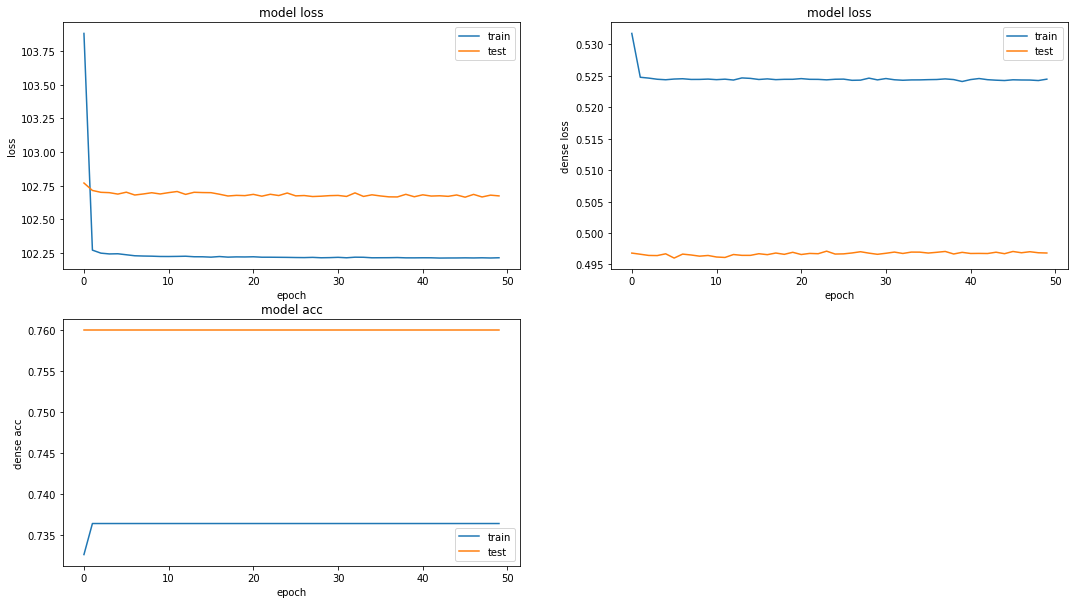

In [9]:
#plots 
f = plt.figure(figsize=(18, 10)); # plot the calculated values    
sp =  f.add_subplot(2, 2, 1 );
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')

sp =  f.add_subplot(2, 2, 2 );
plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])
plt.title('model loss')
plt.ylabel('dense loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')

sp =  f.add_subplot(2, 2, 3 );
plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])
plt.title('model acc')
plt.ylabel('dense acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower right')

In [31]:
def Ising_inference_model(LSTM_cell, densor, n_values, n_a, Ty):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    n_values -- integer, umber of unique values
    n_a -- number of units in the LSTM_cell
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        
        # Step 2.A: Perform one step of LSTM_cell (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, 78) (≈1 line)
        outputs.append(out)
        
        # Step 2.D: Select the next value according to "out", and set "x" to be the one-hot representation of the
        #           selected value, which will be passed as the input to LSTM_cell on the next step. We have provided 
        #           the line of code you need to do this. 
       
        x = Lambda(lambda out: one_hot(out)) #This have to be changed
        
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    return inference_model

In [32]:
inference_model = Ising_inference_model(LSTM_cell, densor, n_values = 2, n_a = n_a , Ty = N)
x_initializer = np.zeros((1, 1, 2))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

ValueError: Layer lstm_1 expects 5 inputs, but it received 3 input tensors. Input received: [<tf.Tensor 'input_12:0' shape=(?, 1, 2) dtype=float32>, <tf.Tensor 'a0_11:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'c0_11:0' shape=(?, 100) dtype=float32>]

In [ ]:
def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 78), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 78), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis=-1)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (1, )
    results = to_categorical(indices, num_classes=2)
 
    
    return results, indices, pred

In [ ]:
_ , _, proba = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)

In [ ]:
def sample_cnfg(prob,seed):
    shape = np.shape(prob)
    sampled_cnfg = np.zeros((shape[0],1))
    
    for i in range(shape[0]):
        random.seed(seed+i*shape[0])
        sampled_cnfg[i] = np.random.choice(list(range(shape[2])),p=prob[i][0][:]) 
    return sampled_cnfg

In [ ]:
Nrep = 5000
new_cnfg = np.zeros((Nrep,N)) 
for i in range(Nrep):
    tmp = sample_cnfg(proba,i)
    new_cnfg[i,:] = tmp[:,0]           

Now I compare the energy and magnetization distribution among the MC and RNN data: 

In [ ]:
E_MC  = np.zeros((N))
M_MC  = np.zeros((N))

E_RNN = np.zeros((Nrep))
M_RNN = np.zeros((Nrep))


for i in range(N): 
    E_MC[i]  = calcEnergy(cnfg_in[0,i,:],J,h)
    M_MC[i]  = calcMag(cnfg_in[0,i,:])

for i in range(Nrep): 
    new_cnfg[i,:][new_cnfg[i,:]<1] = -1
    E_RNN[i] = calcEnergy(new_cnfg[i,:],J,h)
    M_RNN[i] = calcMag(new_cnfg[i,:])

    
f = plt.figure(figsize=(18, 10)); # plot the calculated values    
sp =  f.add_subplot(2, 2, 1 );
plt.hist(E_MC, bins=10, normed=1, alpha=0.5, color='red', label='MC')
plt.hist(E_RNN[2:], bins=10, normed=1, alpha=0.5, color='blue', label='RNN')
plt.legend(loc='upper right')
plt.xlabel("Energy", fontsize=20); 


sp =  f.add_subplot(2, 2, 2 );
plt.hist(M_MC, bins=10, normed=1, alpha=0.5, color='red', label='MC')
plt.hist(M_RNN[2:], bins=10,normed=1, alpha=0.5, color='blue', label='RNN')
plt.legend(loc='upper right')
plt.xlabel("Magnetization", fontsize=20);

It seems that Magnetization is correctly reproduced (meaning, the total amount of + and - spins). 
However, the Energy that keeps track of the ordering among the spins is completely screwed up. 